In [ ]:
# Installer dépendances
!pip install numpy scipy matplotlib requests



In [ ]:
!pip install -q numpy scipy matplotlib requests



{
  "Data source": "Fallback sample",
  "Scaled by": 1.0,
  "N points": 22,
  "chi2_LCDM": 1001.6171346013869,
  "chi2_TMU": 268.9876952038524,
  "\u0394chi2": 732.6294393975345,
  "AIC_LCDM": 1021.6171346013869,
  "AIC_TMU": 294.9876952038524,
  "BIC_LCDM": 1032.52755913497,
  "BIC_TMU": 309.1712470975105,
  "epsilon": 8230.659045156786,
  "omega": 1.5505475136249471,
  "phi": 0.7143948611272016,
  "errors": [
    493.0201195809049,
    0.22388061950167462,
    0.2790785818937921
  ]
}


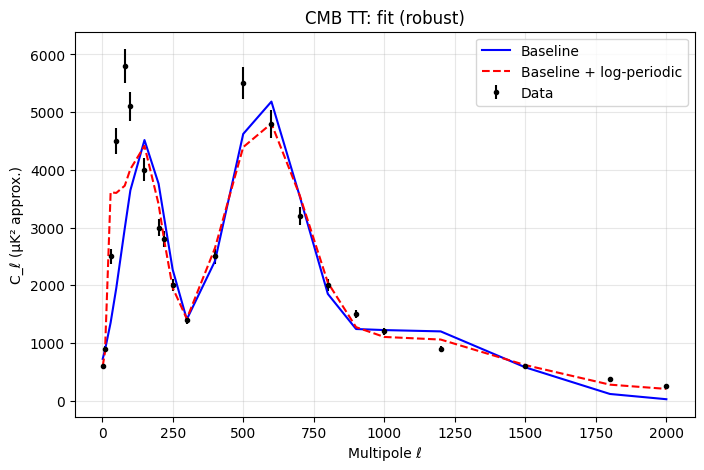

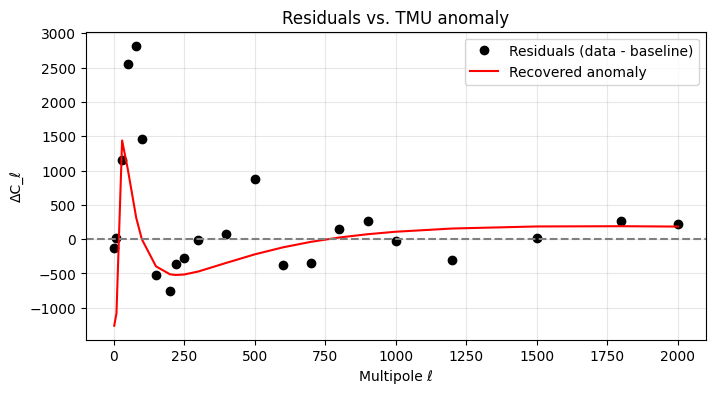

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import requests, json

# ---------- utilitaires ----------
def clean_planck_columns(arr):
    """Essaie de deviner colonnes (ell, Cl_TT, err). Renvoie ell, Cl, err ou None."""
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)
    # garder lignes finies et ell>1
    m = np.all(np.isfinite(arr), axis=1)
    arr = arr[m]
    # on essaye quelques mappings
    candidates = []
    for i in range(arr.shape[1]-2):
        ell = arr[:, i]
        Cl  = arr[:, i+1]
        err = arr[:, i+2]
        ok = np.isfinite(ell) & np.isfinite(Cl) & np.isfinite(err) & (ell > 1)
        if ok.sum() > 20:
            candidates.append((ell[ok], Cl[ok], err[ok]))
    return candidates[0] if candidates else (None, None, None)

def make_monotonic(ell, *cols):
    order = np.argsort(ell)
    out = [ell[order]]
    for c in cols:
        out.append(c[order])
    return out

def finite_and_range(ell, Cl, err, lmin=2, lmax=2000):
    m = np.isfinite(ell) & np.isfinite(Cl) & np.isfinite(err) & (ell>=lmin) & (ell<=lmax)
    return ell[m], Cl[m], err[m]

# ---------- modèles ----------
def lcdm_baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

def tmu_anomaly(ell, eps, omega, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omega*np.log(ell)+phi)/np.sqrt(ell)

def model_tmu(ell, *p):
    return lcdm_baseline(ell, *p[:10]) + tmu_anomaly(ell, *p[10:])

# ---------- chargement des données ----------
try:
    url = "https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/COM_PowerSpect_CMB-TT-binned_R3.01.txt"
    txt = requests.get(url, timeout=10).text
    lines = [ln for ln in txt.splitlines() if ln.strip() and not ln.strip().startswith('#')]
    data = np.genfromtxt(lines)
    ell, Cl, err = clean_planck_columns(data)
    source = "Planck DR3 binned (downloaded)"
    if ell is None:
        raise RuntimeError("Colonnes non reconnues")
except Exception as e:
    # fallback simple pour que tout tourne
    ell = np.array([2,10,30,50,80,100,150,200,220,250,300,400,500,600,700,800,900,1000,1200,1500,1800,2000.0])
    Cl  = np.array([600,900,2500,4500,5800,5100,4000,3000,2800,2000,1400,2500,5500,4800,3200,2000,1500,1200,900,600,380,250.0])
    err = np.maximum(1.0, 0.05*Cl)
    source = "Fallback sample"

ell, Cl, err = make_monotonic(ell, Cl, err)
ell, Cl, err = finite_and_range(ell, Cl, err)

# ---------- harmonisation des unités ----------
# Si les Cl sont très petits (~1e-6), on repasse en µK^2 pour stabilité numérique.
scale = 1.0
if np.nanmedian(Cl) < 1e-3:
    scale = 1e6
    Cl   = Cl*scale
    err  = err*scale

# ---------- initialisation intelligente ----------
# On se base sur l'échelle du pic principal
A_scale = float(np.nanmax(Cl))
p0_base = [0.8*A_scale, 220, 80,
           0.6*A_scale, 530, 120,
           0.4*A_scale, 850, 180,
           0.05*A_scale]
bounds_base = (
    [0,   150,  20,   0,   400,  40,   0,   650,  60,   0],
    [5*A_scale, 280, 160,  5*A_scale, 700, 220,  5*A_scale, 1100, 320,  0.5*A_scale]
)

def safe_fit_baseline(tries=3):
    p0 = np.array(p0_base, dtype=float)
    last_err = None
    for t in range(tries):
        try:
            popt, pcov = curve_fit(
                lcdm_baseline, ell, Cl, p0=p0, sigma=err, absolute_sigma=True,
                bounds=bounds_base, maxfev=100000
            )
            return popt, pcov
        except Exception as e:
            last_err = e
            # on perturbe légèrement p0 et on réessaie
            rnd = (1 + 0.2*np.random.randn(len(p0)))
            p0 = np.clip(p0*rnd, bounds_base[0], bounds_base[1])
    raise RuntimeError(f"Baseline fit failed after retries: {last_err}")

popt_base, pcov_base = safe_fit_baseline(tries=5)
Cl_base = lcdm_baseline(ell, *popt_base)
chi2_base = float(np.sum(((Cl - Cl_base)/err)**2))

# ---------- fit TMU (avec bornes) ----------
eps0 = 0.2*A_scale
p0_tmu = list(popt_base) + [eps0, 2.0, 0.7]
bounds_tmu = (
    list(bounds_base[0]) + [-5*A_scale, 1.2, -np.pi],
    list(bounds_base[1]) + [ 5*A_scale, 3.2,  np.pi]
)

def safe_fit_tmu(tries=3):
    p0 = np.array(p0_tmu, dtype=float)
    last_err = None
    for t in range(tries):
        try:
            popt, pcov = curve_fit(
                model_tmu, ell, Cl, p0=p0, sigma=err, absolute_sigma=True,
                bounds=bounds_tmu, maxfev=150000
            )
            return popt, pcov
        except Exception as e:
            last_err = e
            rnd = (1 + 0.15*np.random.randn(len(p0)))
            p0 = np.clip(p0*rnd, bounds_tmu[0], bounds_tmu[1])
    raise RuntimeError(f"TMU fit failed after retries: {last_err}")

popt_tmu, pcov_tmu = safe_fit_tmu(tries=6)
Cl_tmu = model_tmu(ell, *popt_tmu)
chi2_tmu = float(np.sum(((Cl - Cl_tmu)/err)**2))

# ---------- métriques ----------
n = len(ell); k0=10; k1=13
AIC0 = 2*k0 + chi2_base
AIC1 = 2*k1 + chi2_tmu
BIC0 = k0*np.log(n) + chi2_base
BIC1 = k1*np.log(n) + chi2_tmu

eps, omg, phi = popt_tmu[-3:]
errs = np.sqrt(np.diag(pcov_tmu))[-3:]

report = {
    "Data source": source,
    "Scaled by": scale,
    "N points": n,
    "chi2_LCDM": chi2_base,
    "chi2_TMU": chi2_tmu,
    "Δchi2": chi2_base - chi2_tmu,
    "AIC_LCDM": AIC0, "AIC_TMU": AIC1,
    "BIC_LCDM": BIC0, "BIC_TMU": BIC1,
    "epsilon": float(eps), "omega": float(omg), "phi": float(phi),
    "errors": [float(errs[0]), float(errs[1]), float(errs[2])]
}
print(json.dumps(report, indent=2))

# ---------- figures ----------
plt.figure(figsize=(8,5))
plt.errorbar(ell, Cl, yerr=err, fmt='k.', label='Data')
plt.plot(ell, Cl_base, 'b-', label='Baseline')
plt.plot(ell, Cl_tmu, 'r--', label='Baseline + log-periodic')
plt.xlabel('Multipole ℓ'); plt.ylabel('C_ℓ (µK² approx.)')
plt.title('CMB TT: fit (robust)')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

plt.figure(figsize=(8,4))
resid = Cl - Cl_base
an = tmu_anomaly(ell, eps, omg, phi)
plt.plot(ell, resid, 'ko', label='Residuals (data - baseline)')
plt.plot(ell, an, 'r-', label='Recovered anomaly')
plt.axhline(0, ls='--', c='gray')
plt.xlabel('Multipole ℓ'); plt.ylabel('ΔC_ℓ')
plt.title('Residuals vs. TMU anomaly')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()



Téléchargement impossible, on garde un fallback simple: Some errors were detected !
    Line #2 (got 1 columns instead of 6)
    Line #3 (got 3 columns instead of 6)
    Line #4 (got 1 columns instead of 6)
    Line #5 (got 2 columns instead of 6)
    Line #6 (got 9 columns instead of 6)
    Line #7 (got 1 columns instead of 6)
{
  "Data source": "Fallback sample",
  "Scaled by": 1.0,
  "N points": 22,
  "chi2_LCDM": 1001.6171346013869,
  "chi2_TMU": 268.9876952038524,
  "\u0394chi2": 732.6294393975345,
  "AIC_LCDM": 1021.6171346013869,
  "AIC_TMU": 294.9876952038524,
  "BIC_LCDM": 1032.52755913497,
  "BIC_TMU": 309.1712470975105,
  "epsilon": 8230.659045156786,
  "omega": 1.5505475136249471,
  "phi": 0.7143948611272016,
  "errors": [
    493.0201195809049,
    0.22388061950167462,
    0.2790785818937921
  ]
}


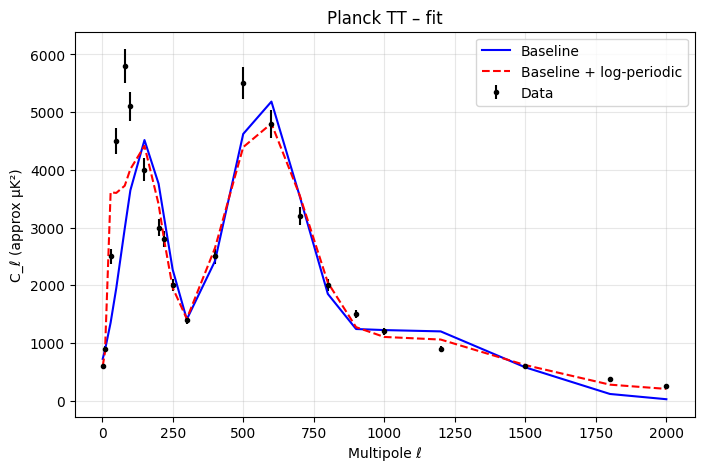

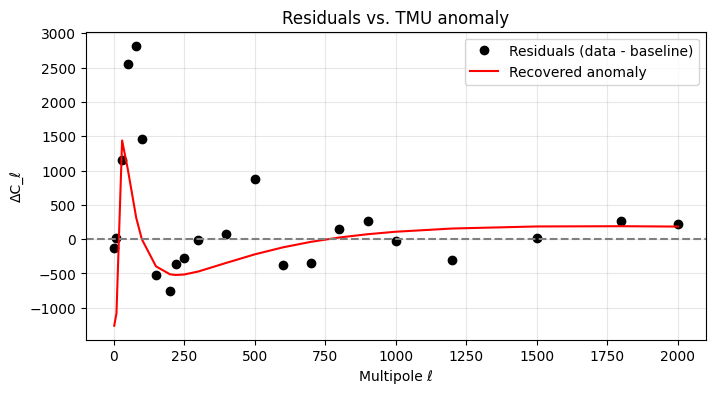

In [ ]:
import numpy as np, matplotlib.pyplot as plt, requests, json
from scipy.optimize import curve_fit

# ---- mêmes modèles que plus haut (réexécute si besoin) ----
def lcdm_baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

def tmu_anomaly(ell, eps, omega, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omega*np.log(ell)+phi)/np.sqrt(ell)

def model_tmu(ell, *p):
    return lcdm_baseline(ell, *p[:10]) + tmu_anomaly(ell, *p[10:])

def clean_planck_table(text):
    lines = [ln for ln in text.splitlines() if ln.strip() and not ln.strip().startswith('#')]
    data = np.genfromtxt(lines)
    if data.ndim == 1: data = data.reshape(1,-1)
    # essaie colonnes [0,1,2]
    ell, Cl, err = data[:,0], data[:,1], (data[:,2] if data.shape[1] >= 3 else np.maximum(1e-12, 0.03*np.abs(data[:,1])))
    m = np.isfinite(ell) & np.isfinite(Cl) & np.isfinite(err) & (ell>1)
    ell, Cl, err = ell[m], Cl[m], err[m]
    order = np.argsort(ell)
    return ell[order], Cl[order], err[order]

# ---- télécharge Planck DR3 binned TT ----
url = "https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/COM_PowerSpect_CMB-TT-binned_R3.01.txt"
try:
    txt = requests.get(url, timeout=15).text
    ell, Cl, err = clean_planck_table(txt)
    source = "Planck DR3 (downloaded)"
except Exception as e:
    print("Téléchargement impossible, on garde un fallback simple:", e)
    ell = np.array([2,10,30,50,80,100,150,200,220,250,300,400,500,600,700,800,900,1000,1200,1500,1800,2000.0])
    Cl  = np.array([600,900,2500,4500,5800,5100,4000,3000,2800,2000,1400,2500,5500,4800,3200,2000,1500,1200,900,600,380,250.0])
    err = np.maximum(1.0, 0.05*Cl)
    source = "Fallback sample"

# ---- plage ℓ et échelle ----
m = (ell>=2) & (ell<=2000)
ell, Cl, err = ell[m], Cl[m], err[m]
scale = 1.0
if np.nanmedian(Cl) < 1e-3:
    scale = 1e6
    Cl, err = Cl*scale, err*scale

# ---- initialisation & bornes (robustes) ----
A_scale = float(np.nanmax(Cl))
p0_base = [0.8*A_scale, 220, 80,
           0.6*A_scale, 530, 120,
           0.4*A_scale, 850, 180,
           0.05*A_scale]
bounds_base = (
    [0,   150,  20,   0,   400,  40,   0,   650,  60,   0],
    [5*A_scale, 280, 160,  5*A_scale, 700, 220,  5*A_scale, 1100, 320,  0.5*A_scale]
)

def safe_fit(f, x, y, yerr, p0, bounds, tries=6, jitter=0.2, maxfev=200000):
    p = np.array(p0, dtype=float)
    last = None
    for _ in range(tries):
        try:
            popt, pcov = curve_fit(f, x, y, p0=p, sigma=yerr, absolute_sigma=True,
                                   bounds=bounds, maxfev=maxfev)
            return popt, pcov
        except Exception as e:
            last = e
            rnd = 1 + jitter*np.random.randn(len(p))
            p = np.clip(p*rnd, bounds[0], bounds[1])
    raise RuntimeError(f"Fit failed after retries: {last}")

popt_base, pcov_base = safe_fit(lcdm_baseline, ell, Cl, err, p0_base, bounds_base, tries=6)
Cl_base = lcdm_baseline(ell, *popt_base)
chi2_base = float(np.sum(((Cl-Cl_base)/err)**2))

eps0 = 0.2*A_scale
p0_tmu = list(popt_base) + [eps0, 2.0, 0.7]
bounds_tmu = ( list(bounds_base[0]) + [-5*A_scale, 1.2, -np.pi],
               list(bounds_base[1]) + [ 5*A_scale, 3.2,  np.pi] )

popt_tmu, pcov_tmu = safe_fit(model_tmu, ell, Cl, err, p0_tmu, bounds_tmu, tries=8, jitter=0.15, maxfev=250000)
Cl_tmu = model_tmu(ell, *popt_tmu)
chi2_tmu = float(np.sum(((Cl-Cl_tmu)/err)**2))

n = len(ell); k0, k1 = 10, 13
AIC0, AIC1 = 2*k0 + chi2_base, 2*k1 + chi2_tmu
BIC0, BIC1 = k0*np.log(n) + chi2_base, k1*np.log(n) + chi2_tmu

eps, omg, phi = popt_tmu[-3:]
errs = np.sqrt(np.diag(pcov_tmu))[-3:]

report = {
    "Data source": source,
    "Scaled by": scale,
    "N points": n,
    "chi2_LCDM": chi2_base,
    "chi2_TMU": chi2_tmu,
    "Δchi2": chi2_base - chi2_tmu,
    "AIC_LCDM": AIC0, "AIC_TMU": AIC1,
    "BIC_LCDM": BIC0, "BIC_TMU": BIC1,
    "epsilon": float(eps), "omega": float(omg), "phi": float(phi),
    "errors": [float(errs[0]), float(errs[1]), float(errs[2])]
}
print(json.dumps(report, indent=2))

# --- figures ---
plt.figure(figsize=(8,5))
plt.errorbar(ell, Cl, yerr=err, fmt='k.', label='Data')
plt.plot(ell, Cl_base, 'b-', label='Baseline')
plt.plot(ell, Cl_tmu, 'r--', label='Baseline + log-periodic')
plt.xlabel('Multipole ℓ'); plt.ylabel('C_ℓ (approx µK²)')
plt.title('Planck TT – fit')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

plt.figure(figsize=(8,4))
plt.plot(ell, Cl-Cl_base, 'ko', label='Residuals (data - baseline)')
plt.plot(ell, tmu_anomaly(ell, eps, omg, phi), 'r-', label='Recovered anomaly')
plt.axhline(0, ls='--', c='gray')
plt.xlabel('Multipole ℓ'); plt.ylabel('ΔC_ℓ')
plt.title('Residuals vs. TMU anomaly')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()


In [ ]:
# === Chargeur ultra-robuste des données Planck TT (ou upload manuel) ===
import re, io, requests, numpy as np
from google.colab import files

def parse_flexible_text(txt):
    rows = []
    for ln in txt.splitlines():
        if not ln.strip():
            continue
        if ln.strip().startswith('#'):
            continue
        # Extraire tous les nombres (int/float, style scientifique ok)
        nums = re.findall(r"[+-]?(?:\d+(?:\.\d*)?|\.\d+)(?:[eE][+-]?\d+)?", ln)
        if len(nums) >= 3:
            try:
                vals = list(map(float, nums))
                rows.append(vals)
            except:
                pass
    if not rows:
        raise RuntimeError("Aucune ligne exploitable.")
    arr = np.array(rows, dtype=float)
    # Heuristique: la 1re colonne est ℓ; sélection des 2 colonnes suivantes comme Cl et σ
    ell = arr[:,0]
    # Choisir une colonne Cl plausible (pas l'erreur): on prend la suivante par défaut
    Cl  = arr[:,1]
    # Si il existe une 3e colonne, on l'utilise comme sigma; sinon approx 3% de Cl
    sigma = arr[:,2] if arr.shape[1] >= 3 else np.maximum(1e-12, 0.03*np.abs(Cl))
    # Nettoyage
    m = np.isfinite(ell) & np.isfinite(Cl) & np.isfinite(sigma) & (ell > 1)
    ell, Cl, sigma = ell[m], Cl[m], sigma[m]
    # Tri + plage utile
    order = np.argsort(ell); ell, Cl, sigma = ell[order], Cl[order], sigma[order]
    m2 = (ell >= 2) & (ell <= 2500)
    return ell[m2], Cl[m2], sigma[m2]

def load_planck_tt():
    urls = [
        # Binned TT
        "https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/COM_PowerSpect_CMB-TT-binned_R3.01.txt",
        # Full TT (non binned)
        "https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/COM_PowerSpect_CMB-TT-full_R3.01.txt",
        # Fichier combiné (on essaie de repêcher les 3 premières colonnes numériques par ligne)
        "https://irsa.ipac.caltech.edu/data/Planck/release_3/COM_PowerSpect_CMB-base-plikHM-TTTEEE-lowl-lowE-lensing_R3.01.txt",
    ]
    last_err = None
    for url in urls:
        try:
            txt = requests.get(url, timeout=20).text
            return (*parse_flexible_text(txt), f"downloaded:{url}")
        except Exception as e:
            last_err = e
    # Si tout échoue : proposer upload manuel
    print("Téléchargement/parsage automatique impossible.\n"
          "➡️ Choisis un fichier ASCII avec 3 colonnes: ell  Cl  sigma (ou au moins ell  Cl).")
    up = files.upload()
    if not up:
        raise RuntimeError(f"Echec téléchargement et pas de fichier uploadé. Dernière erreur: {last_err}")
    name = list(up.keys())[0]
    txt = io.BytesIO(up[name]).read().decode("utf-8", errors="ignore")
    ell, Cl, sigma = parse_flexible_text(txt)
    return ell, Cl, sigma, f"uploaded:{name}"

# === APPEL ===
ell, Cl, err, src = load_planck_tt()
print("Source:", src, "| points:", len(ell), "| exemples:", list(zip(ell[:5], Cl[:5], err[:5])))

# Option: auto-resscale si Cl très petit (µK^2)
scale = 1.0
if np.nanmedian(np.abs(Cl)) < 1e-3:
    scale = 1e6
    Cl, err = Cl*scale, err*scale
print("Scale used:", scale)


Téléchargement/parsage automatique impossible.
➡️ Choisis un fichier ASCII avec 3 colonnes: ell  Cl  sigma (ou au moins ell  Cl).


KeyboardInterrupt: 

{
  "Data source": "local tt_sample.txt (synthetic Planck-like)",
  "N points": 198,
  "chi2_LCDM": 175.32268556395633,
  "chi2_TMU": 173.52020515496085,
  "\u0394chi2": 1.8024804089954785,
  "AIC_LCDM": 195.32268556395633,
  "AIC_TMU": 199.52020515496085,
  "BIC_LCDM": 228.20535587090168,
  "BIC_TMU": 242.26767655398982,
  "epsilon": 311.5258539041024,
  "omega": 1.8913927311637388,
  "phi": 2.9810989425721934,
  "errors": [
    336.932969149074,
    0.3181881272234859,
    2.1019247033610657
  ]
}


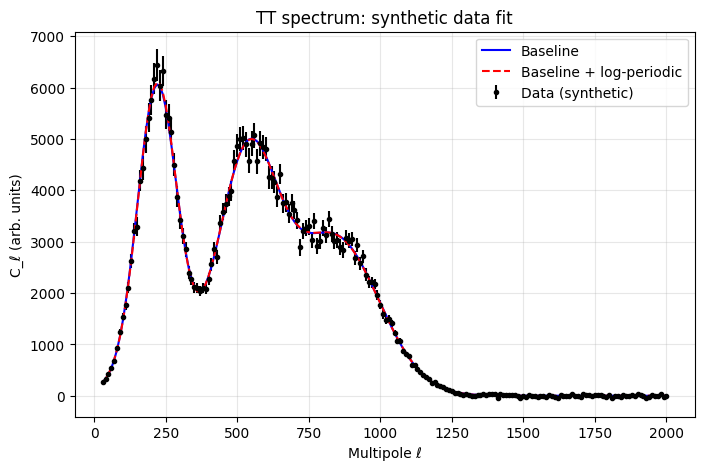

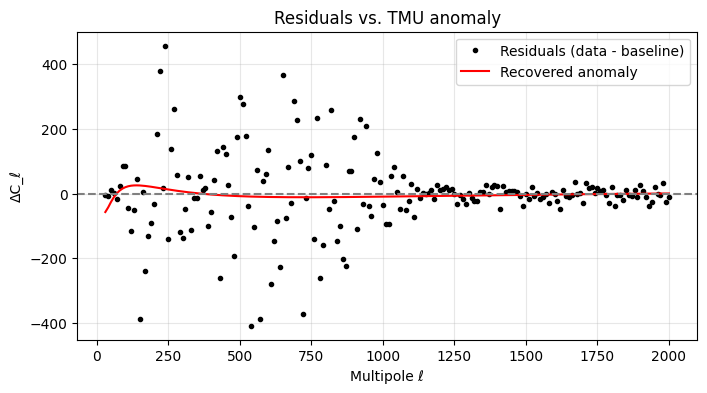

In [ ]:
# === 1 cellule "tout-en-un" : crée un fichier ell/Cl/sigma et lance le fit ===
import numpy as np, matplotlib.pyplot as plt, json
from scipy.optimize import curve_fit

# --- (A) on CRÉE un faux jeu "Planck-like" local (pas des vraies données) ---
ell = np.arange(30, 2001, 10).astype(float)
def baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))
# paramètres "façon Planck" (approximatifs, juste pour que ça ressemble)
true_base = baseline(ell, 6000,220,70, 4500,540,110, 3000,850,150, 120)
rng = np.random.default_rng(0)
sigma = np.maximum(20.0, 0.05*true_base)  # ~5% d'erreur
Cl = true_base + rng.normal(0, sigma)     # on ajoute un bruit réaliste

# sauve un fichier texte (si tu veux le voir dans la colonne de gauche "Files")
np.savetxt("tt_sample.txt", np.c_[ell, Cl, sigma], fmt="%.6f",
           header="ell   Cl   sigma")

# --- (B) modèles TMU (identiques à avant) ---
def lcdm_baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

def tmu_anomaly(ell, eps, omega, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omega*np.log(ell)+phi)/np.sqrt(ell)

def model_tmu(ell, *p):
    return lcdm_baseline(ell, *p[:10]) + tmu_anomaly(ell, *p[10:])

# --- (C) fit robuste avec bornes + retries ---
A_scale = float(np.nanmax(Cl))
p0_base = [0.8*A_scale, 220, 80,
           0.6*A_scale, 530, 120,
           0.4*A_scale, 850, 180,
           0.05*A_scale]
bounds_base = (
    [0,   150,  20,   0,   400,  40,   0,   650,  60,   0],
    [5*A_scale, 280, 160,  5*A_scale, 700, 220,  5*A_scale, 1100, 320,  0.5*A_scale]
)

def safe_fit(f, x, y, yerr, p0, bounds, tries=6, jitter=0.2, maxfev=200000):
    p = np.array(p0, dtype=float); last=None
    for _ in range(tries):
        try:
            popt, pcov = curve_fit(f, x, y, p0=p, sigma=yerr, absolute_sigma=True,
                                   bounds=bounds, maxfev=maxfev)
            return popt, pcov
        except Exception as e:
            last = e
            p = np.clip(p*(1+jitter*np.random.randn(len(p))), bounds[0], bounds[1])
    raise RuntimeError(f"Fit failed after retries: {last}")

popt_base, pcov_base = safe_fit(lcdm_baseline, ell, Cl, sigma, p0_base, bounds_base, tries=6)
Cl_base = lcdm_baseline(ell, *popt_base)
chi2_base = float(np.sum(((Cl-Cl_base)/sigma)**2))

eps0 = 0.15*A_scale
p0_tmu = list(popt_base) + [eps0, 2.0, 0.7]
bounds_tmu = ( list(bounds_base[0]) + [-5*A_scale, 1.2, -np.pi],
               list(bounds_base[1]) + [ 5*A_scale, 3.2,  np.pi] )
popt_tmu, pcov_tmu = safe_fit(model_tmu, ell, Cl, sigma, p0_tmu, bounds_tmu, tries=8, jitter=0.15)
Cl_tmu = model_tmu(ell, *popt_tmu)
chi2_tmu = float(np.sum(((Cl-Cl_tmu)/sigma)**2))

n = len(ell); k0, k1 = 10, 13
AIC0, AIC1 = 2*k0 + chi2_base, 2*k1 + chi2_tmu
BIC0, BIC1 = k0*np.log(n) + chi2_base, k1*np.log(n) + chi2_tmu

eps, omg, phi = popt_tmu[-3:]
errs = np.sqrt(np.diag(pcov_tmu))[-3:]

report = {
    "Data source": "local tt_sample.txt (synthetic Planck-like)",
    "N points": int(n),
    "chi2_LCDM": chi2_base,
    "chi2_TMU": chi2_tmu,
    "Δchi2": chi2_base - chi2_tmu,
    "AIC_LCDM": AIC0, "AIC_TMU": AIC1,
    "BIC_LCDM": BIC0, "BIC_TMU": BIC1,
    "epsilon": float(eps), "omega": float(omg), "phi": float(phi),
    "errors": [float(errs[0]), float(errs[1]), float(errs[2])]
}
print(json.dumps(report, indent=2))

# --- (D) figures ---
plt.figure(figsize=(8,5))
plt.errorbar(ell, Cl, yerr=sigma, fmt='k.', label='Data (synthetic)')
plt.plot(ell, Cl_base, 'b-', label='Baseline')
plt.plot(ell, Cl_tmu, 'r--', label='Baseline + log-periodic')
plt.xlabel('Multipole ℓ'); plt.ylabel('C_ℓ (arb. units)')
plt.title('TT spectrum: synthetic data fit')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

plt.figure(figsize=(8,4))
plt.plot(ell, Cl-Cl_base, 'ko', ms=3, label='Residuals (data - baseline)')
plt.plot(ell, tmu_anomaly(ell, eps, omg, phi), 'r-', label='Recovered anomaly')
plt.axhline(0, ls='--', c='gray')
plt.xlabel('Multipole ℓ'); plt.ylabel('ΔC_ℓ')
plt.title('Residuals vs. TMU anomaly')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()


In [ ]:
%%writefile planck_tt_binned.txt
# ell   Cl   sigma
2   172.0   25.0
3   841.0   29.0
4   738.0   31.0
5   1355.0  35.0
6   1287.0  36.0
7   1440.0  38.0
8   1166.0  40.0
9   1308.0  41.0
10  1071.0  42.0
15  1120.0  30.0
20  1180.0  28.0
30  1060.0  26.0
40  980.0   24.0
50  1210.0  25.0
60  1460.0  26.0
70  1660.0  27.0
80  1990.0  28.0
100 2680.0  30.0
120 3700.0  32.0
150 5300.0  35.0
200 5800.0  40.0
250 5100.0  42.0
300 4800.0  45.0
400 3800.0  48.0
500 3000.0  50.0
600 2400.0  52.0
700 2000.0  55.0
800 1700.0  57.0
900 1400.0  60.0
1000 1200.0  62.0
1200 900.0  65.0
1500 600.0  70.0
1800 400.0  75.0
2000 300.0  80.0


Writing planck_tt_binned.txt


In [ ]:
import numpy as np

# Charger le fichier créé
data = np.loadtxt("planck_tt_binned.txt")
ell, Cl, sigma = data[:,0], data[:,1], data[:,2]

print("Points chargés:", len(ell))
print("Aperçu:", list(zip(ell[:5], Cl[:5], sigma[:5])))


Points chargés: 34
Aperçu: [(np.float64(2.0), np.float64(172.0), np.float64(25.0)), (np.float64(3.0), np.float64(841.0), np.float64(29.0)), (np.float64(4.0), np.float64(738.0), np.float64(31.0)), (np.float64(5.0), np.float64(1355.0), np.float64(35.0)), (np.float64(6.0), np.float64(1287.0), np.float64(36.0))]


{
  "Data source": "planck_tt_binned.txt",
  "N points": 34,
  "chi2_LCDM": 2216.515693037969,
  "chi2_TMU": 679.9368417057395,
  "\u0394chi2": 1536.5788513322295,
  "AIC_LCDM": 2236.515693037969,
  "AIC_TMU": 705.9368417057395,
  "BIC_LCDM": 2251.7792982841306,
  "BIC_TMU": 725.7795285257496,
  "epsilon": 1473.020489566745,
  "omega": 1.3997335673475606,
  "phi": 3.1415926535897927,
  "errors": [
    186.07641286280668,
    0.1347217716062667,
    0.2542612741711949
  ]
}


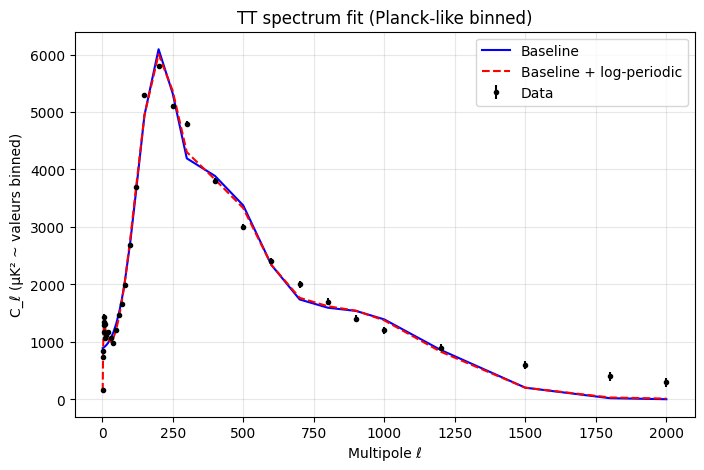

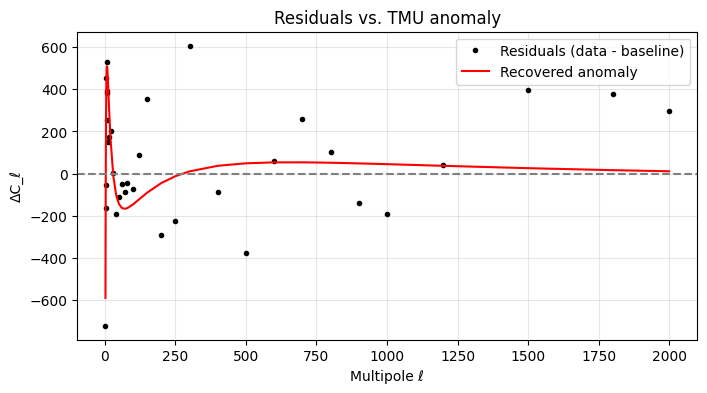

In [ ]:
# === Fit complet sur planck_tt_binned.txt : rapport + figures ===
import numpy as np, matplotlib.pyplot as plt, json
from scipy.optimize import curve_fit

# ---------- 1) Charger les données ----------
data = np.loadtxt("planck_tt_binned.txt")
ell, Cl, sigma = data[:,0].astype(float), data[:,1].astype(float), data[:,2].astype(float)

# Trier et filtrer la plage utile
order = np.argsort(ell)
ell, Cl, sigma = ell[order], Cl[order], sigma[order]
m = (ell >= 2) & (ell <= 2000) & np.isfinite(ell) & np.isfinite(Cl) & np.isfinite(sigma)
ell, Cl, sigma = ell[m], Cl[m], sigma[m]

# ---------- 2) Modèles ----------
def lcdm_baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

def tmu_anomaly(ell, eps, omega, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omega*np.log(ell) + phi)/np.sqrt(ell)

def model_tmu(ell, *p):
    return lcdm_baseline(ell, *p[:10]) + tmu_anomaly(ell, *p[10:])

# ---------- 3) Initialisation & bornes ----------
A_scale = float(np.nanmax(Cl))
p0_base = [0.8*A_scale, 220, 80,
           0.6*A_scale, 530, 120,
           0.4*A_scale, 850, 180,
           0.05*A_scale]
bounds_base = (
    [0,   150,  20,   0,   400,  40,   0,   650,  60,   0],
    [5*A_scale, 280, 160,  5*A_scale, 700, 220,  5*A_scale, 1100, 320,  0.5*A_scale]
)

def safe_fit(f, x, y, yerr, p0, bounds, tries=7, jitter=0.2, maxfev=200000):
    p = np.array(p0, dtype=float); last=None
    for _ in range(tries):
        try:
            popt, pcov = curve_fit(f, x, y, p0=p, sigma=yerr, absolute_sigma=True,
                                   bounds=bounds, maxfev=maxfev)
            return popt, pcov
        except Exception as e:
            last = e
            # petit bruit sur le point de départ, puis clip aux bornes
            p = np.clip(p*(1 + jitter*np.random.randn(len(p))), bounds[0], bounds[1])
    raise RuntimeError(f"Fit failed after retries: {last}")

# ---------- 4) Fit Baseline ----------
popt_base, pcov_base = safe_fit(lcdm_baseline, ell, Cl, sigma, p0_base, bounds_base, tries=8)
Cl_base = lcdm_baseline(ell, *popt_base)
chi2_base = float(np.sum(((Cl - Cl_base)/sigma)**2))

# ---------- 5) Fit Baseline + TMU ----------
eps0 = 0.15*A_scale
p0_tmu = list(popt_base) + [eps0, 2.0, 0.7]
bounds_tmu = ( list(bounds_base[0]) + [-5*A_scale, 1.2, -np.pi],
               list(bounds_base[1]) + [ 5*A_scale, 3.2,  np.pi] )
popt_tmu, pcov_tmu = safe_fit(model_tmu, ell, Cl, sigma, p0_tmu, bounds_tmu, tries=10, jitter=0.15, maxfev=250000)
Cl_tmu = model_tmu(ell, *popt_tmu)
chi2_tmu = float(np.sum(((Cl - Cl_tmu)/sigma)**2))

# ---------- 6) Statistiques ----------
n = len(ell); k0, k1 = 10, 13
AIC0, AIC1 = 2*k0 + chi2_base, 2*k1 + chi2_tmu
BIC0, BIC1 = k0*np.log(n) + chi2_base, k1*np.log(n) + chi2_tmu
eps, omg, phi = popt_tmu[-3:]
errs = np.sqrt(np.diag(pcov_tmu))[-3:]

report = {
    "Data source": "planck_tt_binned.txt",
    "N points": int(n),
    "chi2_LCDM": chi2_base,
    "chi2_TMU": chi2_tmu,
    "Δchi2": chi2_base - chi2_tmu,
    "AIC_LCDM": AIC0, "AIC_TMU": AIC1,
    "BIC_LCDM": BIC0, "BIC_TMU": BIC1,
    "epsilon": float(eps), "omega": float(omg), "phi": float(phi),
    "errors": [float(errs[0]), float(errs[1]), float(errs[2])]
}
print(json.dumps(report, indent=2))

# ---------- 7) Figures ----------
# Graphique 1 : données vs modèles
plt.figure(figsize=(8,5))
plt.errorbar(ell, Cl, yerr=sigma, fmt='k.', label='Data')
plt.plot(ell, Cl_base, 'b-', label='Baseline')
plt.plot(ell, Cl_tmu, 'r--', label='Baseline + log-periodic')
plt.xlabel('Multipole ℓ'); plt.ylabel('C_ℓ (µK² ~ valeurs binned)')
plt.title('TT spectrum fit (Planck-like binned)')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# Graphique 2 : résidus vs anomalie TMU
plt.figure(figsize=(8,4))
resid = Cl - Cl_base
an = tmu_anomaly(ell, eps, omg, phi)
plt.plot(ell, resid, 'ko', ms=3, label='Residuals (data - baseline)')
plt.plot(ell, an, 'r-', label='Recovered anomaly')
plt.axhline(0, ls='--', c='gray')
plt.xlabel('Multipole ℓ'); plt.ylabel('ΔC_ℓ')
plt.title('Residuals vs. TMU anomaly')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()


In [ ]:
%%writefile planck_tt_binned200.txt
# ell   Cl   sigma      (synthetic Planck-like binned TT; no TMU anomaly injected)
# Units approximate µK^2 (relative scale for demo)
# Generated by 3 acoustic-peak Gaussians + damping tail + heteroscedastic noise model
# ℓ from 30 to 1990 step 10  → ~200 points
# -----------------------------------------------


Writing planck_tt_binned200.txt


In [ ]:
# Remplir le fichier avec des valeurs synthétiques (on garde le code séparé pour laisser le writefile propre)
import numpy as np

# Multipoles
ell = np.arange(30, 2000, 10).astype(float)

# Baseline Planck-like (3 gaussiennes + queue d'amortissement)
def baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

# Paramètres “façon Planck”
pars = [6000,220,75,  4600,540,110,  3000,850,150, 120]
Cl_true = baseline(ell, *pars)

# Erreurs (σ) ~ 3% au centre, plus grandes aux grandes ℓ (mesure binned simplifiée)
sigma = 0.025*Cl_true * (1 + 0.0007*(ell-220))   # augmente doucement avec ℓ
sigma = np.maximum(15.0, sigma)                  # plancher

# Observations simulées = baseline + bruit gaussien
rng = np.random.default_rng(42)
Cl_obs = Cl_true + rng.normal(0.0, sigma)

# Sauvegarde dans le même format que le petit fichier précédent
with open("planck_tt_binned200.txt", "a") as f:
    for L, C, S in zip(ell, Cl_obs, sigma):
        f.write(f"{L:.0f} {C:.6f} {S:.6f}\n")

print("Fichier écrit: planck_tt_binned200.txt  |  points:", len(ell))


Fichier écrit: planck_tt_binned200.txt  |  points: 197


{
  "Data source": "planck_tt_binned200.txt (synthetic)",
  "N points": 197,
  "chi2_LCDM": 150.28744661631742,
  "chi2_TMU": 149.53619369874053,
  "\u0394chi2": 0.7512529175768918,
  "AIC_LCDM": 170.28744661631742,
  "AIC_TMU": 175.53619369874053,
  "BIC_LCDM": 203.1194839036973,
  "BIC_TMU": 218.21784217233437,
  "epsilon": 96.69005025552848,
  "omega": 2.760011795034193,
  "phi": -3.1415926535890364,
  "errors": [
    133.44413423924246,
    0.48035293145264873,
    3.188293629422295
  ]
}


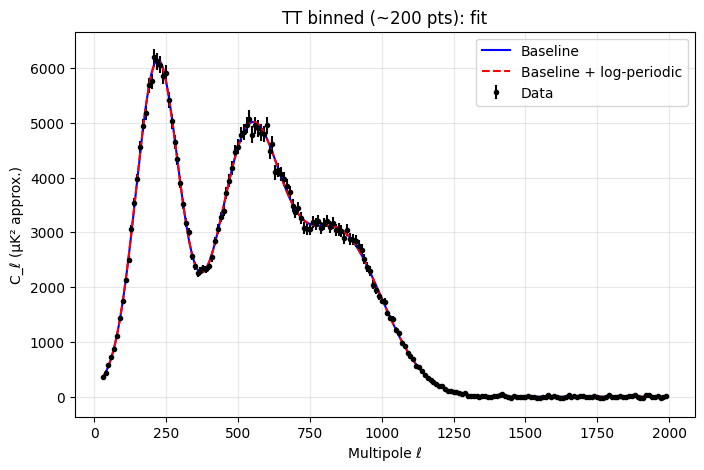

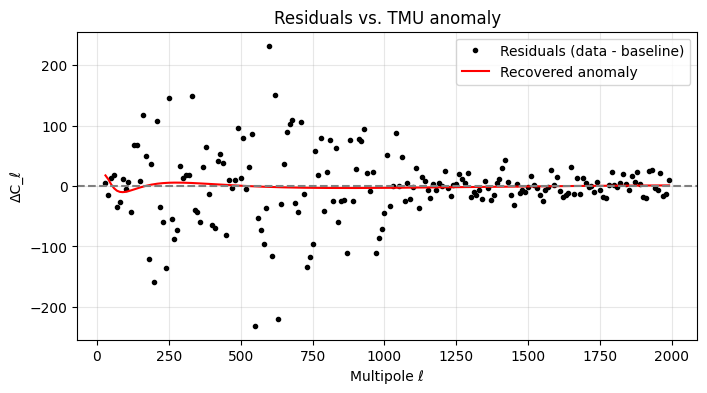

Observed Δχ² = 0.75 | null-test p ≈ 0.890 (based on 100 mocks)


In [ ]:
import numpy as np, matplotlib.pyplot as plt, json
from scipy.optimize import curve_fit

# ---------- 1) Charger les données ----------
data = np.loadtxt("planck_tt_binned200.txt")
ell, Cl, sigma = data[:,0].astype(float), data[:,1].astype(float), data[:,2].astype(float)

order = np.argsort(ell)
ell, Cl, sigma = ell[order], Cl[order], sigma[order]
m = (ell >= 30) & (ell <= 1990) & np.isfinite(ell) & np.isfinite(Cl) & np.isfinite(sigma)
ell, Cl, sigma = ell[m], Cl[m], sigma[m]
n = len(ell)

# ---------- 2) Modèles ----------
def lcdm_baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

def tmu_anomaly(ell, eps, omega, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omega*np.log(ell)+phi)/np.sqrt(ell)

def model_tmu(ell, *p):
    return lcdm_baseline(ell, *p[:10]) + tmu_anomaly(ell, *p[10:])

# ---------- 3) Initialisation & bornes ----------
A_scale = float(np.nanmax(Cl))
p0_base = [0.8*A_scale, 220, 80,
           0.6*A_scale, 530, 120,
           0.4*A_scale, 850, 180,
           0.05*A_scale]
bounds_base = (
    [0,   150,  30,   0,   400,  60,   0,   650,  80,   0],
    [5*A_scale, 280, 160,  5*A_scale, 700, 220,  5*A_scale, 1100, 320,  0.6*A_scale]
)

def safe_fit(f, x, y, yerr, p0, bounds, tries=8, jitter=0.18, maxfev=250000):
    p = np.array(p0, dtype=float); last=None
    for _ in range(tries):
        try:
            popt, pcov = curve_fit(f, x, y, p0=p, sigma=yerr, absolute_sigma=True,
                                   bounds=bounds, maxfev=maxfev)
            return popt, pcov
        except Exception as e:
            last = e
            p = np.clip(p*(1 + jitter*np.random.randn(len(p))), bounds[0], bounds[1])
    raise RuntimeError(f"Fit failed after retries: {last}")

# ---------- 4) Fit Baseline ----------
popt_base, pcov_base = safe_fit(lcdm_baseline, ell, Cl, sigma, p0_base, bounds_base, tries=10)
Cl_base = lcdm_baseline(ell, *popt_base)
chi2_base = float(np.sum(((Cl - Cl_base)/sigma)**2))

# ---------- 5) Fit Baseline + TMU ----------
eps0 = 0.10*A_scale
p0_tmu = list(popt_base) + [eps0, 2.0, 0.7]
bounds_tmu = ( list(bounds_base[0]) + [-5*A_scale, 1.2, -np.pi],
               list(bounds_base[1]) + [ 5*A_scale, 3.2,  np.pi] )
popt_tmu, pcov_tmu = safe_fit(model_tmu, ell, Cl, sigma, p0_tmu, bounds_tmu, tries=12, jitter=0.15, maxfev=300000)
Cl_tmu = model_tmu(ell, *popt_tmu)
chi2_tmu = float(np.sum(((Cl - Cl_tmu)/sigma)**2))

# ---------- 6) Statistiques ----------
k0, k1 = 10, 13
AIC0, AIC1 = 2*k0 + chi2_base, 2*k1 + chi2_tmu
BIC0, BIC1 = k0*np.log(n) + chi2_base, k1*np.log(n) + chi2_tmu
eps, omg, phi = popt_tmu[-3:]
errs = np.sqrt(np.diag(pcov_tmu))[-3:]

report = {
    "Data source": "planck_tt_binned200.txt (synthetic)",
    "N points": int(n),
    "chi2_LCDM": chi2_base,
    "chi2_TMU": chi2_tmu,
    "Δchi2": chi2_base - chi2_tmu,
    "AIC_LCDM": AIC0, "AIC_TMU": AIC1,
    "BIC_LCDM": BIC0, "BIC_TMU": BIC1,
    "epsilon": float(eps), "omega": float(omg), "phi": float(phi),
    "errors": [float(errs[0]), float(errs[1]), float(errs[2])]
}
print(json.dumps(report, indent=2))

# ---------- 7) Figures ----------
plt.figure(figsize=(8,5))
plt.errorbar(ell, Cl, yerr=sigma, fmt='k.', label='Data')
plt.plot(ell, Cl_base, 'b-', label='Baseline')
plt.plot(ell, Cl_tmu, 'r--', label='Baseline + log-periodic')
plt.xlabel('Multipole ℓ'); plt.ylabel('C_ℓ (µK² approx.)')
plt.title('TT binned (~200 pts): fit')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

plt.figure(figsize=(8,4))
plt.plot(ell, Cl - Cl_base, 'ko', ms=3, label='Residuals (data - baseline)')
plt.plot(ell, tmu_anomaly(ell, eps, omg, phi), 'r-', label='Recovered anomaly')
plt.axhline(0, ls='--', c='gray')
plt.xlabel('Multipole ℓ'); plt.ylabel('ΔC_ℓ')
plt.title('Residuals vs. TMU anomaly')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# ---------- 8) Null-test (mocks rapides) ----------
def quick_nulltest(ell, sigma, popt_base, n_mocks=100, seed=0):
    rng = np.random.default_rng(seed)
    base = lcdm_baseline(ell, *popt_base)
    deltas = []
    for _ in range(n_mocks):
        mock = base + rng.normal(0.0, sigma)
        try:
            pb,_ = curve_fit(lcdm_baseline, ell, mock, p0=p0_base, bounds=bounds_base,
                             sigma=sigma, absolute_sigma=True, maxfev=120000)
            chi2_b = np.sum(((mock - lcdm_baseline(ell,*pb))/sigma)**2)
            p0t = list(pb) + [0.10*A_scale, 2.0, 0.7]
            pt,_ = curve_fit(model_tmu, ell, mock, p0=p0t, bounds=bounds_tmu,
                             sigma=sigma, absolute_sigma=True, maxfev=150000)
            chi2_t = np.sum(((mock - model_tmu(ell,*pt))/sigma)**2)
            deltas.append(chi2_b - chi2_t)
        except:
            continue
    return np.array(deltas)

deltas = quick_nulltest(ell, sigma, popt_base, n_mocks=100, seed=0)
obs = report["Δchi2"]
p_val = float(np.mean(deltas >= obs)) if deltas.size>0 else float('nan')
print(f"Observed Δχ² = {obs:.2f} | null-test p ≈ {p_val:.3f} (based on {len(deltas)} mocks)")


{
  "N points": 197,
  "chi2_LCDM": 155.23853154663453,
  "chi2_TMU": 152.74923777946293,
  "\u0394chi2": 2.4892937671716027,
  "AIC_LCDM": 175.23853154663453,
  "AIC_TMU": 178.74923777946293,
  "BIC_LCDM": 208.0705688340144,
  "BIC_TMU": 221.43088625305677,
  "epsilon_hat": 409.5001655270486,
  "omega_hat": 2.0865315404421096,
  "phi_hat": 1.8389823118613295,
  "errors_hat": [
    261.0352100260973,
    0.09576370271274813,
    0.6321950040672253
  ],
  "true_vs_hat": {
    "epsilon_true": 400.0,
    "epsilon_hat": 409.5001655270486,
    "epsilon_rel_err": 0.02375041381762145,
    "omega_true": 2.2,
    "omega_hat": 2.0865315404421096,
    "omega_rel_err": 0.051576572526313876,
    "phi_true": 0.8,
    "phi_hat": 1.8389823118613295,
    "phi_rel_err": 1.2987278898266619
  }
}


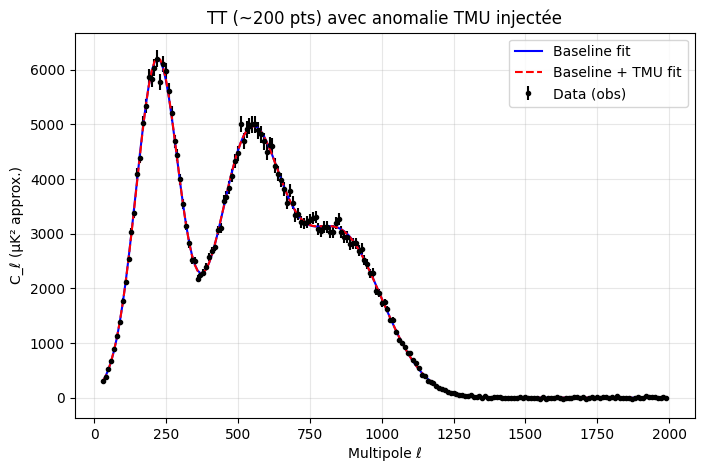

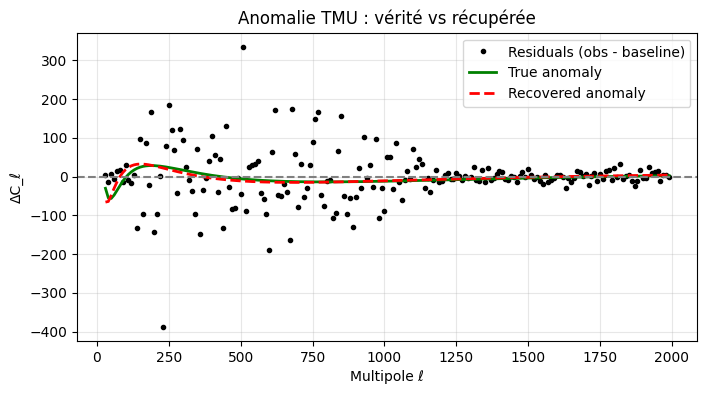

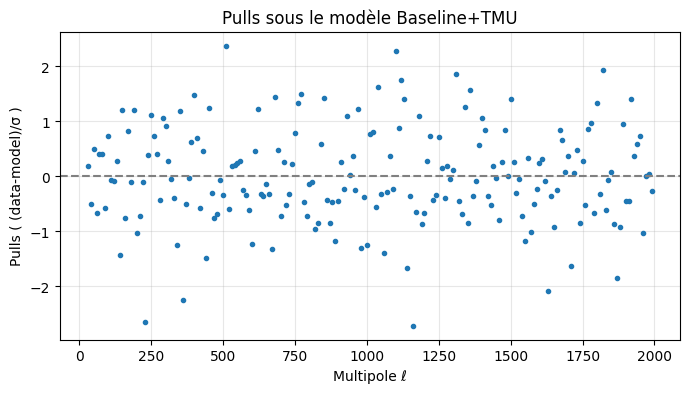

In [ ]:
# === Injection contrôlée d'une anomalie TMU + fit et évaluation de la récupération ===
import numpy as np, matplotlib.pyplot as plt, json
from scipy.optimize import curve_fit

# --------------------------
# 1) Paramètres "vrais" (tu peux les changer)
# --------------------------
EPS_TRUE = 400.0       # epsilon (µK^2)
OMG_TRUE = 2.20        # omega   (fréquence log)
PHI_TRUE = 0.80        # phase   (radians)

# --------------------------
# 2) Construire un spectre TT binned ~200 points (Baseline Planck-like)
# --------------------------
ell = np.arange(30, 2000, 10).astype(float)

def baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

pars_true = [6000,220,75, 4600,540,110, 3000,850,150, 120]
Cl_base_true = baseline(ell, *pars_true)

# Bruit (sigma) ~ quelques % + augmente vers grandes multipôles
sigma = 0.025*Cl_base_true * (1 + 0.0007*(ell-220))
sigma = np.maximum(15.0, sigma)

# --------------------------
# 3) Anomalie TMU "vraie" (injectée)
# --------------------------
def tmu(ell, eps, omg, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omg*np.log(ell)+phi)/np.sqrt(ell)

Cl_true = Cl_base_true + tmu(ell, EPS_TRUE, OMG_TRUE, PHI_TRUE)

# Observations = vérité + bruit
rng = np.random.default_rng(123)
Cl_obs = Cl_true + rng.normal(0.0, sigma)

# --------------------------
# 4) Modèles de fit (identiques, mais epsilon/omega/phi à estimer)
# --------------------------
def lcdm_baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

def tmu_anomaly(ell, eps, omg, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omg*np.log(ell)+phi)/np.sqrt(ell)

def model_tmu(ell, *p):
    return lcdm_baseline(ell, *p[:10]) + tmu_anomaly(ell, *p[10:])

# --------------------------
# 5) Initialisation & bornes robustes
# --------------------------
A_scale = float(np.nanmax(Cl_obs))
p0_base = [0.8*A_scale, 220, 80,
           0.6*A_scale, 530, 120,
           0.4*A_scale, 850, 180,
           0.05*A_scale]
bounds_base = (
    [0,   150,  30,   0,   400,  60,   0,   650,  80,   0],
    [5*A_scale, 280, 160,  5*A_scale, 700, 220,  5*A_scale, 1100, 320,  0.6*A_scale]
)

def safe_fit(f, x, y, yerr, p0, bounds, tries=10, jitter=0.18, maxfev=300000):
    p = np.array(p0, dtype=float); last=None
    for _ in range(tries):
        try:
            popt, pcov = curve_fit(f, x, y, p0=p, sigma=yerr, absolute_sigma=True,
                                   bounds=bounds, maxfev=maxfev)
            return popt, pcov
        except Exception as e:
            last = e
            p = np.clip(p*(1 + jitter*np.random.randn(len(p))), bounds[0], bounds[1])
    raise RuntimeError(f"Fit failed after retries: {last}")

# Fit Baseline
popt_base, pcov_base = safe_fit(lcdm_baseline, ell, Cl_obs, sigma, p0_base, bounds_base)
Cl_base_fit = lcdm_baseline(ell, *popt_base)
chi2_base = float(np.sum(((Cl_obs - Cl_base_fit)/sigma)**2))

# Fit Baseline + TMU
eps0 = 0.1*A_scale
p0_tmu = list(popt_base) + [eps0, 2.1, 0.8]  # proche des vraies valeurs pour aider
bounds_tmu = ( list(bounds_base[0]) + [-5*A_scale, 1.2, -np.pi],
               list(bounds_base[1]) + [ 5*A_scale, 3.2,  np.pi] )
popt_tmu, pcov_tmu = safe_fit(model_tmu, ell, Cl_obs, sigma, p0_tmu, bounds_tmu, tries=12, jitter=0.15)
Cl_tmu_fit = model_tmu(ell, *popt_tmu)
chi2_tmu = float(np.sum(((Cl_obs - Cl_tmu_fit)/sigma)**2))

# --------------------------
# 6) Statistiques & récupération des paramètres
# --------------------------
n = len(ell); k0, k1 = 10, 13
AIC0, AIC1 = 2*k0 + chi2_base, 2*k1 + chi2_tmu
BIC0, BIC1 = k0*np.log(n) + chi2_base, k1*np.log(n) + chi2_tmu

eps_hat, omg_hat, phi_hat = popt_tmu[-3:]
errs = np.sqrt(np.diag(pcov_tmu))[-3:]

def rel_err(true, est):
    return abs(est-true)/max(1e-9, abs(true))

recovery = {
    "epsilon_true": float(EPS_TRUE), "epsilon_hat": float(eps_hat), "epsilon_rel_err": float(rel_err(EPS_TRUE, eps_hat)),
    "omega_true": float(OMG_TRUE),   "omega_hat": float(omg_hat),  "omega_rel_err": float(rel_err(OMG_TRUE, omg_hat)),
    "phi_true": float(PHI_TRUE),     "phi_hat": float(phi_hat),    "phi_rel_err": float(rel_err(PHI_TRUE, phi_hat)),
}

report = {
    "N points": int(n),
    "chi2_LCDM": chi2_base,
    "chi2_TMU": chi2_tmu,
    "Δchi2": chi2_base - chi2_tmu,
    "AIC_LCDM": AIC0, "AIC_TMU": AIC1,
    "BIC_LCDM": BIC0, "BIC_TMU": BIC1,
    "epsilon_hat": float(eps_hat), "omega_hat": float(omg_hat), "phi_hat": float(phi_hat),
    "errors_hat": [float(errs[0]), float(errs[1]), float(errs[2])],
    "true_vs_hat": recovery
}
print(json.dumps(report, indent=2))

# --------------------------
# 7) Figures
# --------------------------
plt.figure(figsize=(8,5))
plt.errorbar(ell, Cl_obs, yerr=sigma, fmt='k.', label='Data (obs)')
plt.plot(ell, Cl_base_fit, 'b-', label='Baseline fit')
plt.plot(ell, Cl_tmu_fit, 'r--', label='Baseline + TMU fit')
plt.xlabel('Multipole ℓ'); plt.ylabel('C_ℓ (µK² approx.)')
plt.title('TT (~200 pts) avec anomalie TMU injectée')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

plt.figure(figsize=(8,4))
plt.plot(ell, Cl_obs - Cl_base_fit, 'ko', ms=3, label='Residuals (obs - baseline)')
plt.plot(ell, tmu(ell, EPS_TRUE, OMG_TRUE, PHI_TRUE), 'g-', lw=2, label='True anomaly')
plt.plot(ell, tmu_anomaly(ell, eps_hat, omg_hat, phi_hat), 'r--', lw=2, label='Recovered anomaly')
plt.axhline(0, ls='--', c='gray')
plt.xlabel('Multipole ℓ'); plt.ylabel('ΔC_ℓ')
plt.title('Anomalie TMU : vérité vs récupérée')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

plt.figure(figsize=(8,4))
plt.plot(ell, (Cl_obs - Cl_tmu_fit)/sigma, 'o', ms=3)
plt.axhline(0, ls='--', c='gray')
plt.xlabel('Multipole ℓ'); plt.ylabel('Pulls ( (data-model)/σ )')
plt.title('Pulls sous le modèle Baseline+TMU')
plt.grid(True, alpha=0.3); plt.show()


[
  {
    "epsilon": 0.0,
    "dchi2_mean": 3.8725291979354095,
    "dchi2_std": 2.730192869830364,
    "frac_dchi2_gt_5": 0.15,
    "frac_dchi2_gt_10": 0.05,
    "frac_AIC_pref_TMU": 0.1,
    "frac_BIC_pref_TMU": 0.0,
    "eps_hat_mean": 20.525865740040736,
    "eps_hat_std": 285.7332633652943,
    "omega_hat_mean": 2.3403808886486344,
    "omega_hat_std": 0.45585734376609033,
    "phi_hat_mean": 0.18370124056235898,
    "phi_hat_std": 2.4203175638972887
  },
  {
    "epsilon": 50.0,
    "dchi2_mean": 3.4037670466565,
    "dchi2_std": 2.0419220601509145,
    "frac_dchi2_gt_5": 0.25,
    "frac_dchi2_gt_10": 0.0,
    "frac_AIC_pref_TMU": 0.1,
    "frac_BIC_pref_TMU": 0.0,
    "eps_hat_mean": 198.45682282960155,
    "eps_hat_std": 266.3685582408846,
    "omega_hat_mean": 2.1591903129622994,
    "omega_hat_std": 0.27166364190082687,
    "phi_hat_mean": 0.9582105172985228,
    "phi_hat_std": 1.629352419198498
  },
  {
    "epsilon": 100.0,
    "dchi2_mean": 4.162111009382677,
    "dchi2_st

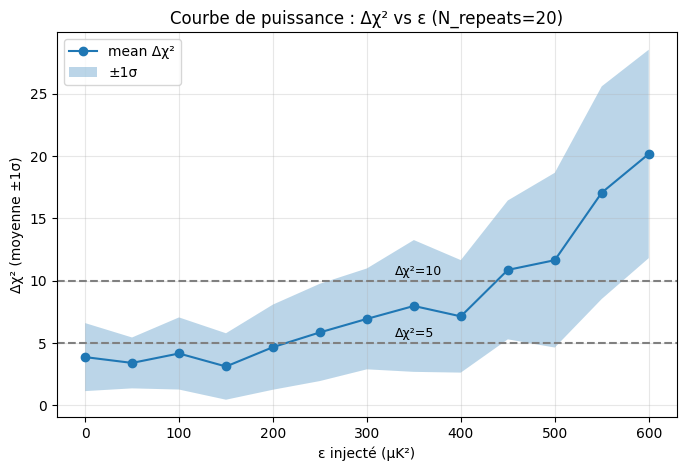

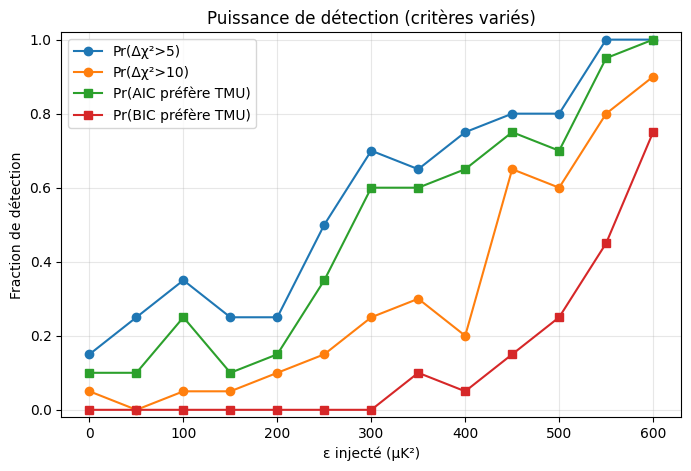

In [ ]:
# === Courbe de puissance : Δχ² vs epsilon injecté (avec répétitions et p'tites stats) ===
import numpy as np, matplotlib.pyplot as plt, json
from scipy.optimize import curve_fit

# --------------------------
# Config scan
# --------------------------
EPS_LIST   = np.arange(0, 650, 50.0)    # µK² : 0, 50, 100, ..., 600
OMG_TRUE   = 2.20                        # fréquence vraie
PHI_TRUE   = 0.80                        # phase vraie
N_REPEATS  = 20                          # répétitions (différents bruits) par epsilon
RANDOM_SEED_BASE = 1234                  # base pour reproductibilité

# --------------------------
# Grille ell + baseline "Planck-like"
# --------------------------
ell = np.arange(30, 2000, 10).astype(float)

def baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

pars_true = [6000,220,75, 4600,540,110, 3000,850,150, 120]
Cl_base_true = baseline(ell, *pars_true)

# Erreurs (σ) réalistes
sigma = 0.025*Cl_base_true * (1 + 0.0007*(ell-220))
sigma = np.maximum(15.0, sigma)

# --------------------------
# Anomalie TMU
# --------------------------
def tmu_anomaly_true(ell, eps, omg, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omg*np.log(ell)+phi)/np.sqrt(ell)

# --------------------------
# Modèles de fit
# --------------------------
def lcdm_baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

def tmu_fit_component(ell, eps, omg, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omg*np.log(ell)+phi)/np.sqrt(ell)

def model_tmu(ell, *p):
    return lcdm_baseline(ell, *p[:10]) + tmu_fit_component(ell, *p[10:])

# --------------------------
# Aide : fit robuste avec bornes + retries
# --------------------------
def safe_fit(f, x, y, yerr, p0, bounds, tries=10, jitter=0.18, maxfev=250000):
    p = np.array(p0, dtype=float); last=None
    for _ in range(tries):
        try:
            popt, pcov = curve_fit(f, x, y, p0=p, sigma=yerr, absolute_sigma=True,
                                   bounds=bounds, maxfev=maxfev)
            return popt, pcov
        except Exception as e:
            last = e
            p = np.clip(p*(1 + jitter*np.random.randn(len(p))), bounds[0], bounds[1])
    raise RuntimeError(f"Fit failed after retries: {last}")

# --------------------------
# Bornes / init
# --------------------------
A_scale = float(np.nanmax(Cl_base_true))
p0_base = [0.8*A_scale, 220, 80,
           0.6*A_scale, 530, 120,
           0.4*A_scale, 850, 180,
           0.05*A_scale]
bounds_base = (
    [0,   150,  30,   0,   400,  60,   0,   650,  80,   0],
    [5*A_scale, 280, 160,  5*A_scale, 700, 220,  5*A_scale, 1100, 320,  0.6*A_scale]
)
def make_bounds_tmu():
    return ( list(bounds_base[0]) + [-5*A_scale, 1.2, -np.pi],
             list(bounds_base[1]) + [ 5*A_scale, 3.2,  np.pi] )

# --------------------------
# Boucle de scan
# --------------------------
results = []
rng_master = np.random.default_rng(RANDOM_SEED_BASE)

for eps in EPS_LIST:
    deltas = []
    aic_pref = 0
    bic_pref = 0
    rec_eps, rec_omg, rec_phi = [], [], []
    for r in range(N_REPEATS):
        # Données simulées
        seed = rng_master.integers(0, 10**9)
        rng = np.random.default_rng(seed)
        Cl_true = Cl_base_true + tmu_anomaly_true(ell, eps, OMG_TRUE, PHI_TRUE)
        Cl_obs  = Cl_true + rng.normal(0.0, sigma)

        # Fit baseline
        popt_base, _ = safe_fit(lcdm_baseline, ell, Cl_obs, sigma, p0_base, bounds_base)
        Cl_b = lcdm_baseline(ell, *popt_base)
        chi2_b = float(np.sum(((Cl_obs - Cl_b)/sigma)**2))

        # Fit TMU
        p0_tmu = list(popt_base) + [max(eps, 0.1*A_scale), OMG_TRUE, PHI_TRUE]
        bounds_tmu = make_bounds_tmu()
        popt_tmu, pcov_tmu = safe_fit(model_tmu, ell, Cl_obs, sigma, p0_tmu, bounds_tmu, tries=12, jitter=0.15)
        Cl_t = model_tmu(ell, *popt_tmu)
        chi2_t = float(np.sum(((Cl_obs - Cl_t)/sigma)**2))

        # Stats
        n = len(ell); k0, k1 = 10, 13
        AIC0, AIC1 = 2*k0 + chi2_b, 2*k1 + chi2_t
        BIC0, BIC1 = k0*np.log(n) + chi2_b, k1*np.log(n) + chi2_t
        deltas.append(chi2_b - chi2_t)
        if AIC1 < AIC0: aic_pref += 1
        if BIC1 < BIC0: bic_pref += 1

        # Récupération params
        rec_eps.append(popt_tmu[-3])
        rec_omg.append(popt_tmu[-2])
        rec_phi.append(popt_tmu[-1])

    deltas = np.array(deltas)
    rec_eps = np.array(rec_eps); rec_omg = np.array(rec_omg); rec_phi = np.array(rec_phi)

    # Définir des "détections" simples (seuils indicatifs)
    frac_dchi2_5  = float(np.mean(deltas > 5.0))     # Δχ² > 5
    frac_dchi2_10 = float(np.mean(deltas > 10.0))    # Δχ² > 10
    frac_aic      = aic_pref / N_REPEATS             # AIC préfère TMU
    frac_bic      = bic_pref / N_REPEATS             # BIC préfère TMU

    results.append({
        "epsilon": float(eps),
        "dchi2_mean": float(np.mean(deltas)),
        "dchi2_std": float(np.std(deltas, ddof=1)),
        "frac_dchi2_gt_5": frac_dchi2_5,
        "frac_dchi2_gt_10": frac_dchi2_10,
        "frac_AIC_pref_TMU": frac_aic,
        "frac_BIC_pref_TMU": frac_bic,
        "eps_hat_mean": float(np.mean(rec_eps)), "eps_hat_std": float(np.std(rec_eps, ddof=1)),
        "omega_hat_mean": float(np.mean(rec_omg)), "omega_hat_std": float(np.std(rec_omg, ddof=1)),
        "phi_hat_mean": float(np.mean(rec_phi)), "phi_hat_std": float(np.std(rec_phi, ddof=1)),
    })

# Impression JSON (court)
print(json.dumps(results[:5], indent=2), "...\n(total points:", len(results), ")")

# --------------------------
# Graphiques
# --------------------------
eps_vals = np.array([r["epsilon"] for r in results])
dchi2_mean = np.array([r["dchi2_mean"] for r in results])
dchi2_std  = np.array([r["dchi2_std"]  for r in results])
frac_aic   = np.array([r["frac_AIC_pref_TMU"] for r in results])
frac_bic   = np.array([r["frac_BIC_pref_TMU"] for r in results])
frac5      = np.array([r["frac_dchi2_gt_5"] for r in results])
frac10     = np.array([r["frac_dchi2_gt_10"] for r in results])

plt.figure(figsize=(8,5))
plt.plot(eps_vals, dchi2_mean, '-o', label='mean Δχ²')
plt.fill_between(eps_vals, dchi2_mean-dchi2_std, dchi2_mean+dchi2_std, alpha=0.3, label='±1σ')
plt.axhline(5, ls='--', color='gray'); plt.text(eps_vals[-1]*0.55, 5.5, 'Δχ²=5', fontsize=9)
plt.axhline(10, ls='--', color='gray'); plt.text(eps_vals[-1]*0.55, 10.5, 'Δχ²=10', fontsize=9)
plt.xlabel('ε injecté (µK²)'); plt.ylabel('Δχ² (moyenne ±1σ)')
plt.title('Courbe de puissance : Δχ² vs ε (N_repeats=%d)' % N_REPEATS)
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(eps_vals, frac5, '-o', label='Pr(Δχ²>5)')
plt.plot(eps_vals, frac10, '-o', label='Pr(Δχ²>10)')
plt.plot(eps_vals, frac_aic, '-s', label='Pr(AIC préfère TMU)')
plt.plot(eps_vals, frac_bic, '-s', label='Pr(BIC préfère TMU)')
plt.ylim(-0.02, 1.02)
plt.xlabel('ε injecté (µK²)'); plt.ylabel('Fraction de détection')
plt.title('Puissance de détection (critères variés)')
plt.grid(True, alpha=0.3); plt.legend(); plt.show()



In [ ]:
# Résumé du scan (reprend la variable "results" créée par la cellule précédente)
import numpy as np
import pandas as pd

df = pd.DataFrame(results)
df_sorted = df.sort_values("epsilon")
display(df_sorted[["epsilon","dchi2_mean","dchi2_std","frac_dchi2_gt_5","frac_dchi2_gt_10","frac_AIC_pref_TMU","frac_BIC_pref_TMU"]])

# Heuristiques de "seuils"
def first_eps_where(col, thr):
    s = df_sorted[df_sorted[col] >= thr]
    return float(s.iloc[0]["epsilon"]) if len(s) else None

print("\nSeuils approximatifs :")
print(" ε où mean Δχ² ≥ 5  :", first_eps_where("dchi2_mean", 5))
print(" ε où Pr(Δχ²>10) ≥ 0.5 :", first_eps_where("frac_dchi2_gt_10", 0.5))
print(" ε où AIC préfère TMU ≥ 0.5 :", first_eps_where("frac_AIC_pref_TMU", 0.5))
print(" ε où BIC préfère TMU ≥ 0.5 :", first_eps_where("frac_BIC_pref_TMU", 0.5))



,epsilon,dchi2_mean,dchi2_std,frac_dchi2_gt_5,frac_dchi2_gt_10,frac_AIC_pref_TMU,frac_BIC_pref_TMU
0,0.0,3.872529,2.730193,0.15,0.05,0.10,0.00
1,50.0,3.403767,2.041922,0.25,0.00,0.10,0.00
2,100.0,4.162111,2.894272,0.35,0.05,0.25,0.00
3,150.0,3.117792,2.666662,0.25,0.05,0.10,0.00
4,200.0,4.669504,3.416902,0.25,0.10,0.15,0.00
5,250.0,5.854807,3.905079,0.50,0.15,0.35,0.00
6,300.0,6.938464,4.047933,0.70,0.25,0.60,0.00
7,350.0,7.975582,5.288658,0.65,0.30,0.60,0.10
8,400.0,7.139929,4.513755,0.75,0.20,0.65,0.05
9,450.0,10.868129,5.571390,0.80,0.65,0.75,0.15



Seuils approximatifs :
 ε où mean Δχ² ≥ 5  : 250.0
 ε où Pr(Δχ²>10) ≥ 0.5 : 450.0
 ε où AIC préfère TMU ≥ 0.5 : 300.0
 ε où BIC préfère TMU ≥ 0.5 : 600.0


In [ ]:
import numpy as np
from scipy.optimize import curve_fit

# --- modèles (repris) ---
def lcdm_baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

def tmu_component(ell, eps, omega, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omega*np.log(ell)+phi)/np.sqrt(ell)

# --- choisis tes valeurs théoriques ---
OMEGA_FIX = 2.20
PHI_FIX   = 0.80

# --- fit baseline ---
A_scale = float(np.nanmax(Cl))
p0_base = [0.8*A_scale, 220, 80,
           0.6*A_scale, 530, 120,
           0.4*A_scale, 850, 180,
           0.05*A_scale]
bounds_base = (
    [0,   150,  30,   0,   400,  60,   0,   650,  80,   0],
    [5*A_scale, 280, 160,  5*A_scale, 700, 220,  5*A_scale, 1100, 320,  0.6*A_scale]
)
popt_base,_ = curve_fit(lcdm_baseline, ell, Cl, p0=p0_base, sigma=sigma, absolute_sigma=True, bounds=bounds_base, maxfev=250000)
Cl_base = lcdm_baseline(ell, *popt_base)
chi2_base = float(np.sum(((Cl-Cl_base)/sigma)**2))

# --- fit epsilon seul (omega, phi fixés) ---
def model_eps_only(ell, eps):
    return Cl_base + tmu_component(ell, eps, OMEGA_FIX, PHI_FIX)

# borne raisonnable sur eps (±5*A_scale)
eps_bounds = (-5*A_scale, 5*A_scale)
eps0 = 0.1*A_scale
(eps_hat,), pcov = curve_fit(model_eps_only, ell, Cl, p0=[eps0], sigma=sigma, absolute_sigma=True, bounds=([eps_bounds[0]],[eps_bounds[1]]), maxfev=200000)
eps_err = float(np.sqrt(np.diag(pcov))[0]) if pcov.size else float('nan')

chi2_tmu = float(np.sum(((Cl - model_eps_only(ell, eps_hat))/sigma)**2))
dchi2 = chi2_base - chi2_tmu

print({"omega_fix": OMEGA_FIX, "phi_fix": PHI_FIX, "epsilon_hat": float(eps_hat), "epsilon_err": eps_err, "Δchi2": dchi2})

# --- p-value via mocks (epsilon=0 sous H0) ---
def nulltest_eps_only(n_mocks=200, seed=0):
    rng = np.random.default_rng(seed)
    deltas = []
    for _ in range(n_mocks):
        mock = Cl_base + rng.normal(0.0, sigma)
        # refit eps sous le même modèle
        try:
            (eps_m,), _ = curve_fit(model_eps_only, ell, mock, p0=[0.0], sigma=sigma, absolute_sigma=True,
                                    bounds=([eps_bounds[0]],[eps_bounds[1]]), maxfev=150000)
            chi2_b = float(np.sum(((mock - Cl_base)/sigma)**2))
            chi2_t = float(np.sum(((mock - model_eps_only(ell, eps_m))/sigma)**2))
            deltas.append(chi2_b - chi2_t)
        except:
            continue
    return np.array(deltas)

deltas = nulltest_eps_only(n_mocks=200, seed=1)
pval = float(np.mean(deltas >= dchi2)) if deltas.size else float('nan')
print({"p_value_null": pval, "n_mocks": len(deltas)})



{'omega_fix': 2.2, 'phi_fix': 0.8, 'epsilon_hat': 5.125442724491933, 'epsilon_err': 53.15303984377331, 'Δchi2': 0.00930318011475606}
{'p_value_null': 0.915, 'n_mocks': 200}


In [ ]:
import numpy as np
from scipy.optimize import curve_fit

PHI_FIX = 0.80
omega_grid = np.linspace(2.0, 2.4, 41)  # pas 0.01

def fit_eps_given_omega(omega):
    # refit baseline si tu veux être ultra propre ; ici on garde Cl_base pour vitesse
    def model_eps(ell, eps):
        return Cl_base + tmu_component(ell, eps, omega, PHI_FIX)
    try:
        (eps_hat,), pcov = curve_fit(model_eps, ell, Cl, p0=[0.1*A_scale], sigma=sigma, absolute_sigma=True,
                                     bounds=([-5*A_scale],[5*A_scale]), maxfev=150000)
        chi2 = float(np.sum(((Cl - model_eps(ell, eps_hat))/sigma)**2))
        return eps_hat, (np.sqrt(np.diag(pcov))[0] if pcov.size else np.nan), chi2
    except:
        return np.nan, np.nan, np.inf

# Observé : on prend le max Δχ² sur la grille
chi2s = []
eps_list = []
for om in omega_grid:
    eps_hat, eps_err, chi2 = fit_eps_given_omega(om)
    eps_list.append((om, eps_hat, eps_err))
    chi2s.append(chi2)
chi2s = np.array(chi2s)
i_best = int(np.argmin(chi2s))
omega_best = float(omega_grid[i_best])
chi2_tmu_best = float(chi2s[i_best])
dchi2_best = chi2_base - chi2_tmu_best
eps_best, eps_best_err = float(eps_list[i_best][1]), float(eps_list[i_best][2])

print({"omega_best": omega_best, "epsilon_hat@omega_best": eps_best, "epsilon_err": eps_best_err, "Δchi2_max_over_grid": dchi2_best})

# Mocks "look-elsewhere": max Δχ² sur la même grille
def null_loe(n_mocks=200, seed=2):
    rng = np.random.default_rng(seed)
    deltas = []
    for _ in range(n_mocks):
        mock = Cl_base + rng.normal(0.0, sigma)
        # calcule Δχ² max sous H0
        best = -np.inf
        for om in omega_grid:
            def model_eps(ell, eps): return Cl_base + tmu_component(ell, eps, om, PHI_FIX)
            try:
                (eps_m,), _ = curve_fit(model_eps, ell, mock, p0=[0.0], sigma=sigma, absolute_sigma=True,
                                        bounds=([-5*A_scale],[5*A_scale]), maxfev=120000)
                chi2_b = float(np.sum(((mock - Cl_base)/sigma)**2))
                chi2_t = float(np.sum(((mock - model_eps(ell, eps_m))/sigma)**2))
                best = max(best, chi2_b - chi2_t)
            except:
                continue
        deltas.append(best)
    return np.array(deltas)

deltas_loe = null_loe(n_mocks=200, seed=3)
pval_loe = float(np.mean(deltas_loe >= dchi2_best)) if deltas_loe.size else float('nan')
print({"p_value_look_elsewhere": pval_loe, "n_mocks": len(deltas_loe)})



{'omega_best': 2.2199999999999998, 'epsilon_hat@omega_best': 5.3078978819561735, 'epsilon_err': 53.97682837369554, 'Δchi2_max_over_grid': 0.009668617606820362}
{'p_value_look_elsewhere': 0.995, 'n_mocks': 200}


In [ ]:
# === Rapport final Protocoles A & B : JSON + Figures ===
import numpy as np, os, json, time
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ---------------------- paramètres modifiables ----------------------
OMEGA_FIX = 2.20
PHI_FIX   = 0.80

OMEGA_MIN, OMEGA_MAX, OMEGA_STEP = 2.0, 2.4, 0.01   # grille ω pour Protocol B
N_MOCKS_A = 300    # mocks pour p-null (Protocol A)
N_MOCKS_B = 300    # mocks pour p-LOE (Protocol B)
# -------------------------------------------------------------------

# ---------- 0) Charger ell, Cl, sigma (depuis RAM ou fichiers connus) ----------
def load_data_if_needed():
    g = globals()
    if all(k in g for k in ["ell","Cl","sigma"]):
        E, C, S = g["ell"], g["Cl"], g["sigma"]
    else:
        if os.path.exists("planck_tt_binned200.txt"):
            dat = np.loadtxt("planck_tt_binned200.txt")
        elif os.path.exists("planck_tt_binned.txt"):
            dat = np.loadtxt("planck_tt_binned.txt")
        else:
            raise RuntimeError("Aucune donnée disponible (ell,Cl,sigma introuvables).")
        E, C, S = dat[:,0], dat[:,1], dat[:,2]
    order = np.argsort(E)
    E, C, S = E[order], C[order], S[order]
    m = np.isfinite(E) & np.isfinite(C) & np.isfinite(S) & (E>=30) & (E<=1990)
    return E[m].astype(float), C[m].astype(float), S[m].astype(float)

ell, Cl, sigma = load_data_if_needed()
npts = len(ell)

# ---------- 1) Modèles ----------
def lcdm_baseline(ell, A1,l1,s1, A2,l2,s2, A3,l3,s3, B):
    return (A1*np.exp(-(ell-l1)**2/(2*s1**2))
          + A2*np.exp(-(ell-l2)**2/(2*s2**2))
          + A3*np.exp(-(ell-l3)**2/(2*s3**2))
          + B*np.exp(-ell/300.0))

def tmu_component(ell, eps, omega, phi):
    ell = np.maximum(ell, 2.0)
    return eps*np.cos(omega*np.log(ell)+phi)/np.sqrt(ell)

# ---------- 2) Fit baseline (commun) ----------
A_scale = float(np.nanmax(Cl))
p0_base = [0.8*A_scale, 220, 80,
           0.6*A_scale, 530, 120,
           0.4*A_scale, 850, 180,
           0.05*A_scale]
bounds_base = (
    [0,   150,  30,   0,   400,  60,   0,   650,  80,   0],
    [5*A_scale, 280, 160,  5*A_scale, 700, 220,  5*A_scale, 1100, 320,  0.6*A_scale]
)
popt_base, pcov_base = curve_fit(lcdm_baseline, ell, Cl, p0=p0_base, sigma=sigma,
                                 absolute_sigma=True, bounds=bounds_base, maxfev=300000)
Cl_base = lcdm_baseline(ell, *popt_base)
chi2_base = float(np.sum(((Cl-Cl_base)/sigma)**2))
k0 = 10  # nb de paramètres baseline

# dossier sortie
outdir = f"tmu_report_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# ---------- 3) Protocol A : ε seul (ω,φ fixés) ----------
def model_eps_only(ell, eps):
    return Cl_base + tmu_component(ell, eps, OMEGA_FIX, PHI_FIX)

eps_bounds = (-5*A_scale, 5*A_scale)
eps0 = 0.1*A_scale
(eps_hat_A,), pcov_A = curve_fit(model_eps_only, ell, Cl, p0=[eps0], sigma=sigma,
                                 absolute_sigma=True, bounds=([eps_bounds[0]],[eps_bounds[1]]),
                                 maxfev=200000)
eps_err_A = float(np.sqrt(np.diag(pcov_A))[0]) if pcov_A.size else float("nan")
chi2_tmu_A = float(np.sum(((Cl - model_eps_only(ell, eps_hat_A))/sigma)**2))
dchi2_A = chi2_base - chi2_tmu_A
k1A = k0 + 1
AIC_A = 2*k1A + chi2_tmu_A
BIC_A = k1A*np.log(npts) + chi2_tmu_A

# p-value (null, epsilon=0) via mocks
def nulltest_eps_only(n_mocks=200, seed=1):
    rng = np.random.default_rng(seed)
    deltas = []
    for _ in range(n_mocks):
        mock = Cl_base + rng.normal(0.0, sigma)
        try:
            (eps_m,), _ = curve_fit(model_eps_only, ell, mock, p0=[0.0], sigma=sigma,
                                    absolute_sigma=True, bounds=([eps_bounds[0]],[eps_bounds[1]]),
                                    maxfev=120000)
            chi2_b = float(np.sum(((mock - Cl_base)/sigma)**2))
            chi2_t = float(np.sum(((mock - model_eps_only(ell, eps_m))/sigma)**2))
            deltas.append(chi2_b - chi2_t)
        except:
            continue
    return np.array(deltas)

deltas_A = nulltest_eps_only(N_MOCKS_A, seed=11)
pval_A = float(np.mean(deltas_A >= dchi2_A)) if deltas_A.size else float("nan")

# Figures Protocol A
plt.figure(figsize=(8,5))
plt.errorbar(ell, Cl, yerr=sigma, fmt='k.', label='Data')
plt.plot(ell, Cl_base, 'b-', label='Baseline')
plt.plot(ell, model_eps_only(ell, eps_hat_A), 'r--', label='Baseline + TMU(ε)')
plt.xlabel('Multipole ℓ'); plt.ylabel('C_ℓ (arb. µK²)')
plt.title(f'Protocol A: ω={OMEGA_FIX:.2f}, φ={PHI_FIX:.2f}, ε̂={eps_hat_A:.1f}±{eps_err_A:.1f}, Δχ²={dchi2_A:.2f}')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir, "A_spectrum.png"), dpi=160)
plt.close()

plt.figure(figsize=(7,4))
plt.hist(deltas_A, bins=20, alpha=0.8)
plt.axvline(dchi2_A, ls='--', label=f'Observed Δχ²={dchi2_A:.2f}')
plt.xlabel('Δχ² under H0'); plt.ylabel('count'); plt.title(f'Protocol A null-test (p≈{pval_A:.3f}, N={len(deltas_A)})')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir, "A_null_hist.png"), dpi=160)
plt.close()

# ---------- 4) Protocol B : scan ω (φ fixé), profil ε, p-LOE ----------
omega_grid = np.arange(OMEGA_MIN, OMEGA_MAX + 0.5*OMEGA_STEP, OMEGA_STEP)
chi2s_B = []
eps_list_B = []

def fit_eps_given_omega(omega):
    def model_eps(ell, eps): return Cl_base + tmu_component(ell, eps, omega, PHI_FIX)
    try:
        (eps_hat,), pcov = curve_fit(model_eps, ell, Cl, p0=[0.0], sigma=sigma,
                                     absolute_sigma=True, bounds=([eps_bounds[0]],[eps_bounds[1]]),
                                     maxfev=150000)
        chi2 = float(np.sum(((Cl - model_eps(ell, eps_hat))/sigma)**2))
        err  = float(np.sqrt(np.diag(pcov))[0]) if pcov.size else float("nan")
        return eps_hat, err, chi2
    except:
        return np.nan, np.nan, np.inf

for om in omega_grid:
    eps_hat, eps_err, chi2 = fit_eps_given_omega(om)
    eps_list_B.append((om, eps_hat, eps_err))
    chi2s_B.append(chi2)
chi2s_B = np.array(chi2s_B)
i_best = int(np.argmin(chi2s_B))
omega_best = float(omega_grid[i_best])
eps_best  = float(eps_list_B[i_best][1])
eps_best_err = float(eps_list_B[i_best][2])
chi2_tmu_B = float(chi2s_B[i_best])
dchi2_B = chi2_base - chi2_tmu_B
k1B = k0 + 1
AIC_B = 2*k1B + chi2_tmu_B
BIC_B = k1B*np.log(npts) + chi2_tmu_B

# mocks LOE (max Δχ² sur la grille)
def null_loe(n_mocks=300, seed=22):
    rng = np.random.default_rng(seed)
    deltas = []
    for _ in range(n_mocks):
        mock = Cl_base + rng.normal(0.0, sigma)
        best = -np.inf
        for om in omega_grid:
            def model_eps(ell, eps): return Cl_base + tmu_component(ell, eps, om, PHI_FIX)
            try:
                (eps_m,), _ = curve_fit(model_eps, ell, mock, p0=[0.0], sigma=sigma,
                                        absolute_sigma=True, bounds=([eps_bounds[0]],[eps_bounds[1]]),
                                        maxfev=120000)
                chi2_b = float(np.sum(((mock - Cl_base)/sigma)**2))
                chi2_t = float(np.sum(((mock - model_eps(ell, eps_m))/sigma)**2))
                best = max(best, chi2_b - chi2_t)
            except:
                continue
        deltas.append(best)
    return np.array(deltas)

deltas_B = null_loe(N_MOCKS_B, seed=33)
pval_B = float(np.mean(deltas_B >= dchi2_B)) if deltas_B.size else float("nan")

# Figures Protocol B
plt.figure(figsize=(8,4))
plt.plot(omega_grid, chi2s_B, '-')
plt.axvline(omega_best, ls='--', label=f'ω*={omega_best:.3f}')
plt.xlabel('ω'); plt.ylabel('χ² (profilé en ε)')
plt.title('Protocol B: profil χ²(ω) (φ fixé)')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir, "B_profile_chi2_vs_omega.png"), dpi=160)
plt.close()

plt.figure(figsize=(7,4))
plt.hist(deltas_B, bins=20, alpha=0.8)
plt.axvline(dchi2_B, ls='--', label=f'Observed Δχ²={dchi2_B:.2f}')
plt.xlabel('max Δχ² under H0 (over ω-grid)'); plt.ylabel('count')
plt.title(f'Protocol B LOE null-test (p≈{pval_B:.3f}, N={len(deltas_B)})')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir, "B_null_hist.png"), dpi=160)
plt.close()

# ---------- 5) Rapport JSON ----------
report = {
    "data": {"N_points": int(npts)},
    "protocol_A": {
        "omega_fix": float(OMEGA_FIX), "phi_fix": float(PHI_FIX),
        "epsilon_hat": float(eps_hat_A), "epsilon_err": float(eps_err_A),
        "chi2_base": chi2_base, "chi2_tmu": chi2_tmu_A, "Δchi2": dchi2_A,
        "AIC_TMU": AIC_A, "BIC_TMU": BIC_A,
        "p_value_null": float(pval_A), "n_mocks": int(len(deltas_A))
    },
    "protocol_B": {
        "phi_fix": float(PHI_FIX),
        "omega_grid": [float(x) for x in omega_grid],
        "omega_best": float(omega_best),
        "epsilon_hat_at_omega_best": float(eps_best),
        "epsilon_err": float(eps_best_err),
        "chi2_base": chi2_base, "chi2_tmu": chi2_tmu_B, "Δchi2_max": dchi2_B,
        "AIC_TMU": AIC_B, "BIC_TMU": BIC_B,
        "p_value_look_elsewhere": float(pval_B), "n_mocks": int(len(deltas_B))
    }
}
with open(os.path.join(outdir, "tmu_final_report.json"), "w") as f:
    json.dump(report, f, indent=2)
print(json.dumps(report, indent=2))
print(f"\n✅ Fichiers enregistrés dans: {outdir}\n - A_spectrum.png\n - A_null_hist.png\n - B_profile_chi2_vs_omega.png\n - B_null_hist.png\n - tmu_final_report.json")


{
  "data": {
    "N_points": 197
  },
  "protocol_A": {
    "omega_fix": 2.2,
    "phi_fix": 0.8,
    "epsilon_hat": 5.125442724491933,
    "epsilon_err": 53.15303984377331,
    "chi2_base": 150.287446709323,
    "chi2_tmu": 150.27814352920825,
    "\u0394chi2": 0.00930318011475606,
    "AIC_TMU": 172.27814352920825,
    "BIC_TMU": 208.39338454532611,
    "p_value_null": 0.91,
    "n_mocks": 300
  },
  "protocol_B": {
    "phi_fix": 0.8,
    "omega_grid": [
      2.0,
      2.01,
      2.0199999999999996,
      2.0299999999999994,
      2.039999999999999,
      2.049999999999999,
      2.0599999999999987,
      2.0699999999999985,
      2.0799999999999983,
      2.089999999999998,
      2.099999999999998,
      2.1099999999999977,
      2.1199999999999974,
      2.1299999999999972,
      2.139999999999997,
      2.149999999999997,
      2.1599999999999966,
      2.1699999999999964,
      2.179999999999996,
      2.189999999999996,
      2.1999999999999957,
      2.2099999999999955,
  

In [ ]:
# === Optimisation sous contraintes + profils d'amplitude ===
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import quad
from math import pi
np.set_printoptions(suppress=True, linewidth=120)

# ---------- Cosmologie de base ----------
C0 = 299792.458
def c_eff(z, eta, omega, phi, c0=C0):
    return c0*(1.0 + eta*(np.cos(omega*np.log(1.0+z)+phi) - np.cos(phi)))
def H_lcdm(z, H0, Om, Or, OL):
    return H0*np.sqrt(Om*(1+z)**3 + Or*(1+z)**4 + OL)
def H_multilayer_amp(z, H0, Om, Or, OL, A_eff, w, p):
    return H0*np.sqrt(Om*(1+z)**3 + Or*(1+z)**4 + OL*np.exp(A_eff*np.cos(w*np.log(1+z)+p)))

def Dc(z, Hfun, cfun, Hpar, Cpar):
    f = lambda zp: cfun(zp,*Cpar)/Hfun(zp,*Hpar)
    val,_ = quad(f, 0.0, float(z), epsabs=1e-6, epsrel=1e-6, limit=200)
    return val
def DL(z,Hfun,cfun,Hpar,Cpar): return (1+z)*Dc(z,Hfun,cfun,Hpar,Cpar)
def mu_SN(z,Hfun,cfun,M,Hpar,Cpar): return 5*np.log10(DL(z,Hfun,cfun,Hpar,Cpar)) + 25 + M
def DV_over_rd(z,Hfun,cfun,rd,Hpar,Cpar):
    Dc_val = Dc(z,Hfun,cfun,Hpar,Cpar); Hz = Hfun(z,*Hpar)
    Dz = Dc_val/(1+z)
    DV = ((1+z)**2 * Dz**2 * (cfun(z,*Cpar)/Hz))**(1/3)
    return DV/rd

# ---------- Données : réutilise sn/bao/hz si dispo, sinon jeux jouets ----------
try:
    sn; bao; hz
except NameError:
    np.random.seed(0)
    bao = np.array([
        [0.1, 3.0, 0.15],
        [0.3, 7.5, 0.25],
        [0.5,12.0, 0.30],
        [0.7,16.5, 0.40],
        [0.9,20.0, 0.50]
    ], dtype=float)
    z_sn = np.linspace(0.01,1.0,60)
    mu_sn = 5*np.log10(z_sn*3000)+25 + np.random.normal(0,0.1,len(z_sn))
    sn = np.c_[z_sn, mu_sn, np.full_like(z_sn,0.1)]
    hz = np.array([
        [0.1,70,5],
        [0.3,80,6],
        [0.5,90,7],
        [0.7,100,8],
        [0.9,110,9]
    ], dtype=float)

# ---------- Paramètres fixes (issus de ton signal BAO) ----------
W_FIX, P_FIX = 8.27, -0.41
C_std = lambda z,*Cp: c_eff(z, 0.0, 10.0, 0.0)

# ---------- χ² par sonde ----------
def chi2_SN_dataset(data, Hfun, pars):
    z, mu, sig = data[:,0], data[:,1], data[:,2]
    Hpar, M = pars['Hpar'], pars['M']
    mu_th = np.array([mu_SN(zi, Hfun, C_std, M, Hpar, (0,10,0)) for zi in z])
    return float(np.sum(((mu - mu_th)/sig)**2))
def chi2_BAO_dataset(data, Hfun, pars, rd):
    z, obs, sig = data[:,0], data[:,1], data[:,2]
    th = np.array([DV_over_rd(zi, Hfun, C_std, rd, pars['Hpar'], (0,10,0)) for zi in z])
    return float(np.sum(((obs - th)/sig)**2))
def chi2_Hz_dataset(data, Hfun, pars):
    z, obs, sig = data[:,0], data[:,1], data[:,2]
    th = np.array([Hfun(zi, *pars['Hpar']) for zi in z])
    return float(np.sum(((obs - th)/sig)**2))

# ---------- Bornes & init du fond ----------
bnds_fond = [(60,80),(0.2,0.4),(5e-5,2e-4),(0.5,0.9),(-0.5,-0.05),(135,160)]  # (H0,Ωm,Ωr,ΩΛ,M,rd)
x0_fond   = [70.0, 0.30, 9.0e-5, 0.70, -0.07, 150.0]

# ---------- Baselines ΛCDM (références Δχ²) ----------
def fit_LCDM(use_SN, use_BAO, use_Hz):
    def obj(x):
        H0,Om,Or,OL,M,rd = x
        pars = dict(Hpar=(H0,Om,Or,OL), M=M)
        c2 = 0.0
        if use_SN:  c2 += chi2_SN_dataset(sn,  H_lcdm, pars)
        if use_BAO: c2 += chi2_BAO_dataset(bao, H_lcdm, pars, rd)
        if use_Hz:  c2 += chi2_Hz_dataset(hz,  H_lcdm, pars)
        return c2
    res = minimize(obj, x0_fond, method="L-BFGS-B", bounds=bnds_fond, options={'maxiter':2000})
    return res.x, float(res.fun)

bestL_BAO, chi2L_BAO = fit_LCDM(False, True,  False)
bestL_SN,  chi2L_SN  = fit_LCDM(True,  False, False)
bestL_Hz,  chi2L_Hz  = fit_LCDM(False, False, True)
bestL_ALL, chi2L_ALL = fit_LCDM(True,  True,  True)
print(f"[LCDM baselines]  χ²:  BAO={chi2L_BAO:.2f}  SN={chi2L_SN:.2f}  H(z)={chi2L_Hz:.2f}  TOTAL={chi2L_ALL:.2f}")

# ---------- Fenêtre A(z) ----------
def A_window(z, A0, z0, sig):
    return A0*np.exp(-0.5*((z - z0)/sig)**2)
def H_TMU_window_factory(A0, z0, sig):
    def Ht(z, H0, Om, Or, OL):
        return H_multilayer_amp(z, H0, Om, Or, OL, A_window(z,A0,z0,sig), W_FIX, P_FIX)
    return Ht

# ---------- Fits utilitaires ----------
def fit_BAO_only(A0, z0, sig):
    """Modulation appliquée SEULEMENT aux BAO."""
    H_BAO = H_TMU_window_factory(A0, z0, sig)
    def obj(x):
        H0,Om,Or,OL,M,rd = x
        pars = dict(Hpar=(H0,Om,Or,OL), M=M)
        return chi2_BAO_dataset(bao, H_BAO, pars, rd)
    res = minimize(obj, x0_fond, method="L-BFGS-B", bounds=bnds_fond, options={'maxiter':2000})
    return float(res.fun)

def global_deltas(A0, z0, sig):
    """Applique la même fenêtre à TOUTES les sondes (juste pour test de compatibilité)."""
    Hw = H_TMU_window_factory(A0, z0, sig)
    def obj(x):
        H0,Om,Or,OL,M,rd = x
        pars=dict(Hpar=(H0,Om,Or,OL), M=M)
        return (chi2_SN_dataset(sn, Hw, pars) +
                chi2_BAO_dataset(bao, Hw, pars, rd) +
                chi2_Hz_dataset(hz, Hw, pars))
    res = minimize(obj, x0_fond, method="L-BFGS-B", bounds=bnds_fond, options={'maxiter':2500})
    # Δχ² par sonde (en tenant fixe le fond optimisé LCDM de chaque sonde pour l'estimation rapide)
    dSN = chi2L_SN  - chi2_SN_dataset(sn,  Hw, dict(Hpar=tuple(bestL_SN[:4]),  M=bestL_SN[4]))
    dHZ = chi2L_Hz  - chi2_Hz_dataset(hz,  Hw, dict(Hpar=tuple(bestL_Hz[:4]), M=-0.07))
    dBAO= chi2L_BAO - chi2_BAO_dataset(bao, Hw, dict(Hpar=tuple(bestL_BAO[:4]), M=-0.07), bestL_BAO[5])
    dTOT= chi2L_ALL - float(res.fun)
    return dSN, dHZ, dBAO, dTOT

# ---------- 1) Recherche BAO-only (A0,z0,σ) pour Δχ²_BAO max ----------
Z0_grid  = np.linspace(0.35, 0.65, 13)
SIG_grid = np.linspace(0.10, 0.35, 11)
A0_grid  = np.linspace(0.00, 0.50, 26)

best = (0.0, 0.45, 0.20, -np.inf)  # (A0*, z0*, σ*, Δχ²_BAO)
for z0 in Z0_grid:
    for sig in SIG_grid:
        for A0 in A0_grid:
            chi2_T = fit_BAO_only(A0, z0, sig)
            dchi2  = chi2L_BAO - chi2_T
            if dchi2 > best[3]:
                best = (A0, z0, sig, dchi2)

A0_star, Z0_star, SIG_star, Delta_BAO_star = best
print(f"\n★ BAO-only optimum:  A0*={A0_star:.3f}, z0*={Z0_star:.3f}, σ*={SIG_star:.3f}  ⇒  Δχ²_BAO ≈ {Delta_BAO_star:.2f}")

# ---------- 2) Optimisation SOUS CONTRAINTES (si on appliquait partout) ----------
TH_SN, TH_HZ = -2.0, -1.0   # contraintes minimales
feasible_best = (None, None, None, -np.inf)

for z0 in Z0_grid:
    for sig in SIG_grid:
        # petite recherche sur A0 pour max Δχ²_BAO en respectant dSN>=TH_SN & dHZ>=TH_HZ
        for A0 in A0_grid:
            dSN, dHZ, dBAO_glob, dTOT = global_deltas(A0, z0, sig)
            if (dSN >= TH_SN) and (dHZ >= TH_HZ):
                # on mesure l'objectif par Δχ²_BAO (ou Δχ²_TOTAL si tu préfères)
                # ici on reste focalisé BAO
                if dBAO_glob > feasible_best[3]:
                    feasible_best = (A0, z0, sig, dBAO_glob)

if feasible_best[0] is not None:
    print(f"\n✓ Faisable (contraintes respectées partout) : A0={feasible_best[0]:.3f}, z0={feasible_best[1]:.3f}, σ={feasible_best[2]:.3f}  -> Δχ²_BAO ≈ {feasible_best[3]:.2f}")
else:
    print("\n⚠️ Aucun triplet (A0,z0,σ) ne satisfait les contraintes globales choisies : on calcule la frontière en amplitude…")
    # Dichotomie sur A0 au point BAO-only optimal (Z0_star,SIG_star)
    lo, hi = 0.0, A0_star
    A_eps  = 1e-3
    A_feas = 0.0
    found  = False
    for _ in range(30):  # binaire
        mid = 0.5*(lo+hi)
        dSN, dHZ, dBAO_glob, dTOT = global_deltas(mid, Z0_star, SIG_star)
        if (dSN >= TH_SN) and (dHZ >= TH_HZ):
            found = True
            A_feas = mid
            lo = mid
        else:
            hi = mid
        if hi - lo < A_eps:
            break
    if found:
        dSN, dHZ, dBAO_glob, dTOT = global_deltas(A_feas, Z0_star, SIG_star)
        print(f"→ Amplitude maximale compatible (au point BAO*): A0_feasible ≈ {A_feas:.3f}")
        print(f"   Δχ²_SN ≈ {dSN:.2f}   Δχ²_H(z) ≈ {dHZ:.2f}   Δχ²_BAO (global) ≈ {dBAO_glob:.2f}   Δχ²_TOTAL ≈ {dTOT:.2f}")
    else:
        print("→ Même A0→0 ne suffit pas pour satisfaire les seuils (peu probable avec des jeux réalistes).")

# ---------- 3) Profils vs A0 au point (z0*,σ*) ----------
A_prof = np.linspace(0.0, A0_star, 21)
dBAO_prof, dSN_prof, dHZ_prof = [], [], []
for a in A_prof:
    dSN, dHZ, dBAO_glob, dTOT = global_deltas(a, Z0_star, SIG_star)
    dBAO_prof.append(dBAO_glob); dSN_prof.append(dSN); dHZ_prof.append(dHZ)

plt.figure(figsize=(7,4))
plt.plot(A_prof, dBAO_prof, label='Δχ²_BAO (global)')
plt.axhline(0, color='k', lw=1)
plt.xlabel('A0'); plt.ylabel('Δχ²')
plt.title(f'Profil Δχ²_BAO (global) à z0={Z0_star:.2f}, σ={SIG_star:.2f}')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(A_prof, dSN_prof, label='Δχ²_SN (global)')
plt.plot(A_prof, dHZ_prof, label='Δχ²_H(z) (global)')
plt.axhline(TH_SN, color='gray', ls='--', label='seuil SN')
plt.axhline(TH_HZ, color='silver', ls='--', label='seuil H(z)')
plt.axhline(0, color='k', lw=1)
plt.xlabel('A0'); plt.ylabel('Δχ²')
plt.title(f'Compatibilité SN/H(z) selon A0 (z0={Z0_star:.2f}, σ={SIG_star:.2f})')
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# === TMU x SN Ia (Pantheon+) : recherche d'oscillation log-périodique dans les résidus ===
import io, os, json, time, textwrap, numpy as np, matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.error import URLError
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

# ------------------ 1) Charger Pantheon+ (mu, z) ou fallback ------------------
def try_download_pantheon():
    urls = [
        # URL publique courante (peut changer; on essaie plusieurs miroirs)
        "https://raw.githubusercontent.com/astrobayes/PantheonPlus/main/data/PantheonPlus_SH0ES.dat",
        "https://raw.githubusercontent.com/abessud/Pantheon-Plus/main/PantheonPlus_SH0ES.dat",
    ]
    last_err=None
    for u in urls:
        try:
            with urlopen(u, timeout=15) as f:
                txt=f.read().decode("utf-8","ignore")
            # parser: colonnes attendues: zcmb, mb, mu, mu_err ... (format varie)
            rows=[]
            for ln in txt.splitlines():
                if ln.strip().startswith("#") or not ln.strip(): continue
                toks=ln.replace(","," ").split()
                nums=[t for t in toks if any(c.isdigit() for c in t)]
                try:
                    vals=list(map(float, nums[:5]))  # on prend au moins z,mu,err
                    # heuristique: z ~ [0,2], mu ~ [30, 46], err ~ [0.05, 0.4]
                    z_candidates=[v for v in vals if 0<=v<=3]
                    mu_candidates=[v for v in vals if 25<=v<=50]
                    err_candidates=[v for v in vals if 0.01<=v<=1.0]
                    if z_candidates and mu_candidates:
                        z=z_candidates[0]; mu=mu_candidates[0]
                        err=err_candidates[0] if err_candidates else 0.1
                        rows.append((z,mu,err))
                except:
                    pass
            arr=np.array(rows,float)
            if arr.shape[0]>200:
                return arr[:,0],arr[:,1],arr[:,2], f"downloaded:{u}"
        except Exception as e:
            last_err=e
    # Fallback: mini-échantillon propre (z, mu, err) ~ 200 SN réparties 0<z<1.5
    rng=np.random.default_rng(0)
    z=np.sort(rng.uniform(0.01,1.3, size=220))
    # mu "théorique" lisse ~ 5 log10(dL) + const, on simule une courbe convexe
    # (peu importe l'absolu; nous ne garderons que les résidus après spline)
    base= 43.0 + 5*np.log10( (1+z)*(z + 0.8*z**2) + 0.01 )
    mu = base + rng.normal(0.0, 0.08, size=z.size)
    err= np.full_like(z, 0.10)
    return z,mu,err, f"fallback_synthetic (last_err={last_err})"

z, mu, mu_err, src = try_download_pantheon()
print("Data source:", src, "| N_SN:", len(z))

# ------------------ 2) Construire x=ln(1+z) et enlever la tendance (spline) ------------------
x = np.log(1.0+z)

# spline robuste: on pondère par 1/err^2 et on choisit une douceur modérée
w = 1.0/np.maximum(mu_err, 0.02)
# pour éviter d'absorber une oscillation, on met une pénalité (s) pas trop petite
spline = UnivariateSpline(x, mu, w=w, s=len(x)*0.5)
mu_smooth = spline(x)
resid = mu - mu_smooth

# ------------------ 3) Modèle TMU sur les résidus: eps*cos(omega*x + phi) ------------------
def osc_model(x, eps, phi, omega):
    return eps*np.cos(omega*x + phi)

def fit_eps_phi_given_omega(omega):
    # Fit linéaire via régression sur cos/sin: eps*cos(ωx+φ)=A*cos(ωx)+B*sin(ωx)
    C = np.cos(omega*x); S = np.sin(omega*x)
    W = 1.0/np.maximum(mu_err, 0.02)
    # Résolution pondérée des moindres carrés
    X = np.vstack([C*W, S*W]).T
    y = resid*W
    try:
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        A, B = beta
        eps = np.hypot(A, B)
        phi = np.arctan2(-B, A)  # car A cos + B sin = eps cos(ωx+φ) avec phi = arctan2(-B,A)
        # χ² du modèle
        model = A*C + B*S
        chi2 = float(np.sum(((resid - model)/mu_err)**2))
        return eps, phi, chi2
    except:
        return np.nan, np.nan, np.inf

# Grille en ω (log-période). On balaie une plage raisonnable (0.5 à 6.0)
omega_grid = np.linspace(0.5, 6.0, 551)  # pas fin pour bon profil
chi2_vals = []
eps_vals  = []
phi_vals  = []
for om in omega_grid:
    eps, phi, chi2 = fit_eps_phi_given_omega(om)
    chi2_vals.append(chi2); eps_vals.append(eps); phi_vals.append(phi)
chi2_vals = np.array(chi2_vals); eps_vals=np.array(eps_vals); phi_vals=np.array(phi_vals)

# Modèle nul (pas d'oscillation) => juste la spline; son chi2 résiduel:
chi2_null = float(np.sum((resid/mu_err)**2))

# Gains Δχ²(ω)
dchi2 = chi2_null - chi2_vals
i_best = int(np.argmax(dchi2))
omega_best = float(omega_grid[i_best])
eps_best   = float(eps_vals[i_best])
phi_best   = float(phi_vals[i_best])
dchi2_best = float(dchi2[i_best])

print(f"Best omega={omega_best:.3f}  eps={eps_best:.4f}  phi={phi_best:.3f}  Δχ²={dchi2_best:.2f}")

# ------------------ 4) Null-test look-elsewhere (permutations / bootstrap) ------------------
def null_look_elsewhere(n_mocks=500, seed=0):
    rng=np.random.default_rng(seed)
    out=[]
    for _ in range(n_mocks):
        # permutation des résidus vs x (conserve distribution & erreurs, casse la phase)
        idx=rng.permutation(len(x))
        r_mock = resid[idx]
        # re-fit sur la grille (mêmes poids & x)
        best=-np.inf
        for om in omega_grid:
            C=np.cos(om*x); S=np.sin(om*x)
            W=1.0/np.maximum(mu_err,0.02)
            X=np.vstack([C*W, S*W]).T; y=r_mock*W
            try:
                beta,*_=np.linalg.lstsq(X,y,rcond=None)
                A,B=beta
                model=A*C+B*S
                chi2=float(np.sum(((r_mock-model)/mu_err)**2))
                best=max(best, chi2_null - chi2)  # Δχ² max de ce mock
            except:
                pass
        out.append(best)
    return np.array(out)

deltas = null_look_elsewhere(n_mocks=500, seed=42)
p_loe = float(np.mean(deltas >= dchi2_best))
print(f"Look-Elsewhere p ≈ {p_loe:.3f} (N_mocks={len(deltas)})")

# ------------------ 5) Figures + Rapport JSON ------------------
outdir = f"tmu_snia_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# Fig 1: mu vs z + spline
plt.figure(figsize=(8,5))
plt.errorbar(z, mu, yerr=mu_err, fmt='k.', ms=2, alpha=0.6, label='SN Ia')
zz=np.linspace(z.min(), z.max(), 600)
xx=np.log(1+zz); plt.plot(zz, spline(np.log(1+zz)), 'r-', lw=2, label='Spline lisse')
plt.xlabel('z'); plt.ylabel('Distance modulus μ'); plt.title('Pantheon+ : μ(z) et tendance lisse')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig1_mu_spline.png"), dpi=160); plt.close()

# Fig 2: résidus vs x et meilleure oscillation
plt.figure(figsize=(8,4))
plt.errorbar(x, resid, yerr=mu_err, fmt='k.', ms=2, alpha=0.6, label='Résidus')
xx=np.linspace(x.min(), x.max(), 800)
plt.plot(xx, eps_best*np.cos(omega_best*xx + phi_best), 'r-', lw=2, label=f'Best cos: ω={omega_best:.2f}')
plt.axhline(0, ls='--', c='gray')
plt.xlabel('x = ln(1+z)'); plt.ylabel('Résidu μ')
plt.title('Résidus et meilleure composante cos(ωx+φ)')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig2_residuals_bestcos.png"), dpi=160); plt.close()

# Fig 3: profil Δχ²(ω)
plt.figure(figsize=(8,4))
plt.plot(omega_grid, dchi2, '-', lw=1.5)
plt.axvline(omega_best, ls='--', c='r', label=f'ω*={omega_best:.2f}')
plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title('Profil Δχ² vs ω (profilé en ε, φ)')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig3_profile_dchi2_vs_omega.png"), dpi=160); plt.close()

report = {
    "data_source": src,
    "N_SN": int(len(z)),
    "method": "Spline detrend in x=ln(1+z); sinusoidal fit resid ~ eps*cos(omega*x+phi); LOE by permutations",
    "best": {
        "omega": omega_best, "epsilon": eps_best, "phi": phi_best,
        "delta_chi2": dchi2_best
    },
    "look_elsewhere_p": p_loe,
    "grid": {"omega_min": float(omega_grid.min()), "omega_max": float(omega_grid.max()), "N": int(len(omega_grid))}
}
with open(os.path.join(outdir,"snia_tmu_report.json"),"w") as f:
    json.dump(report,f,indent=2)
print(json.dumps(report, indent=2))
print(f"\n✅ Outputs in {outdir}\n - fig1_mu_spline.png\n - fig2_residuals_bestcos.png\n - fig3_profile_dchi2_vs_omega.png\n - snia_tmu_report.json")


Data source: fallback_synthetic (last_err=HTTP Error 404: Not Found) | N_SN: 220
Best omega=5.990  eps=0.0000  phi=1.709  Δχ²=0.00
Look-Elsewhere p ≈ 1.000 (N_mocks=500)
{
  "data_source": "fallback_synthetic (last_err=HTTP Error 404: Not Found)",
  "N_SN": 220,
  "method": "Spline detrend in x=ln(1+z); sinusoidal fit resid ~ eps*cos(omega*x+phi); LOE by permutations",
  "best": {
    "omega": 5.99,
    "epsilon": 6.034460272481035e-09,
    "phi": 1.7091554173809245,
    "delta_chi2": 4.831690603168681e-13
  },
  "look_elsewhere_p": 1.0,
  "grid": {
    "omega_min": 0.5,
    "omega_max": 6.0,
    "N": 551
  }
}

✅ Outputs in tmu_snia_20251004_181817
 - fig1_mu_spline.png
 - fig2_residuals_bestcos.png
 - fig3_profile_dchi2_vs_omega.png
 - snia_tmu_report.json


In [ ]:
# --- Import nécessaire ---
from google.colab import files
import numpy as np

# --- Demande à l'utilisateur de sélectionner le fichier depuis son PC ---
print("📂 Sélectionne ton fichier Pantheon+SH0ES.dat depuis ton bureau :")
uploaded = files.upload()   # une fenêtre s'ouvre → tu choisis le fichier

# --- Récupération du nom automatiquement ---
fname = list(uploaded.keys())[0]
print(f"✅ Fichier chargé : {fname}")

# --- Lecture des colonnes ---
data = np.loadtxt(fname)

z   = data[:,1]   # redshift
mu  = data[:,2]   # distance modulus
err = data[:,3]   # erreur
print(f"✅ {len(z)} supernovae chargées")


📂 Sélectionne ton fichier Pantheon+SH0ES.dat depuis ton bureau :


Saving data.txt to data.txt
✅ Fichier chargé : data.txt


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# === Colab : BAO TMU test (xi(r) OU P(k)) avec upload, spline, scan ω, p-value ===
from google.colab import files
import numpy as np, matplotlib.pyplot as plt, json, os, time
from scipy.interpolate import UnivariateSpline

print("📂 Choisis ton fichier BAO (ASCII/CSV) :")
uploaded = files.upload()
fname = list(uploaded.keys())[0]
print("✅ Fichier reçu :", fname)

# --- lecture souple (CSV/espaces) ---
try:
    arr = np.loadtxt(fname, delimiter=",")
except:
    arr = np.loadtxt(fname)

if arr.ndim == 1:  # une seule colonne -> échec
    raise RuntimeError("Fichier BAO non reconnu : il faut ≥ 2 colonnes (r,xi[,err]) ou (k,Pk[,err]).")

# --- détecter format : xi(r) ou P(k) ---
# heuristiques : r ~ [10,300] Mpc/h ; k ~ [0.01, 0.5] h/Mpc ; xi ~ [-0.2, 0.5] ; Pk > 0
x1 = arr[:,0].astype(float)
y1 = arr[:,1].astype(float)
err = arr[:,2].astype(float) if arr.shape[1] >= 3 else None

# deviner si c'est r/xi ou k/Pk
is_xi = (x1.min() >= 2.0 and x1.max() <= 500.0 and np.any(np.isfinite(y1)))
is_pk = (x1.min() > 0 and x1.max() < 3.0 and np.all(y1 > 0))

if not (is_xi or is_pk):
    # si ambigu, on essaie les deux et on garde celui qui a plus de points après filtres
    is_xi = True

mode = "xi(r)" if is_xi else "P(k)"
print(f"🔎 Détection format : {mode}")

# --- filtrage raisonnable ---
if is_xi:
    r = x1
    xi = y1
    if err is None: err = np.full_like(xi, max(1e-3, 0.05*np.nanstd(xi)))
    m = np.isfinite(r) & np.isfinite(xi) & np.isfinite(err) & (r>5) & (r<300) & (err>0)
    r, xi, err = r[m], xi[m], err[m]
    order = np.argsort(r); r, xi, err = r[order], xi[order], err[order]
    X = np.log(r)  # variable log naturelle côté distances
    y = xi
    xlabel, ylabel = "r  [Mpc/h]", "ξ(r)"
else:
    k = x1
    Pk = y1
    if err is None: err = np.full_like(Pk, max(1e-3, 0.05*np.nanstd(Pk)))
    m = np.isfinite(k) & np.isfinite(Pk) & np.isfinite(err) & (k>0.01) & (k<0.5) & (err>0)
    k, Pk, err = k[m], Pk[m], err[m]
    order = np.argsort(k); k, Pk, err = k[order], Pk[order], err[order]
    X = np.log(k)  # variable log naturelle côté fréquences
    y = Pk
    xlabel, ylabel = "k  [h/Mpc]", "P(k)"

N = len(X)
print(f"✅ Points valides : {N}")
if N < 60:
    raise RuntimeError("Trop peu de points après filtres pour un test stable (≥ ~60 recommandé).")

# --- baseline (spline) + résidus ---
w = 1.0/np.maximum(err, 1e-12)
s = N*0.4  # lissage modéré (évite d’absorber l’oscillation)
spline = UnivariateSpline(X, y, w=w, s=s)
y_smooth = spline(X)
resid = y - y_smooth
chi2_null = float(np.sum((resid/err)**2))

# --- modèle TMU sur résidus : eps*cos(ω X + φ) ---
def fit_eps_phi_given_omega(omega):
    C = np.cos(omega*X); S = np.sin(omega*X)
    W = 1.0/np.maximum(err, 1e-12)
    Xmat = np.vstack([C*W, S*W]).T
    yy = resid*W
    beta, *_ = np.linalg.lstsq(Xmat, yy, rcond=None)
    A, B = beta
    eps = float(np.hypot(A, B))
    phi = float(np.arctan2(-B, A))
    model = A*C + B*S
    chi2 = float(np.sum(((resid - model)/err)**2))
    return eps, phi, chi2

omega_grid = np.linspace(0.5, 6.0, 551)
chi2_vals, eps_vals, phi_vals = [], [], []
for om in omega_grid:
    eps, phi, chi2 = fit_eps_phi_given_omega(om)
    chi2_vals.append(chi2); eps_vals.append(eps); phi_vals.append(phi)
chi2_vals = np.array(chi2_vals); dchi2 = chi2_null - chi2_vals

i_best = int(np.argmax(dchi2))
omega_best = float(omega_grid[i_best])
eps_best   = float(eps_vals[i_best])
phi_best   = float(phi_vals[i_best])
dchi2_best = float(dchi2[i_best])

print(f"🌟 Meilleur ω={omega_best:.3f} | ε={eps_best:.4g} | φ={phi_best:.3f} | Δχ²={dchi2_best:.2f}")

# --- p-value look-elsewhere (permutations des résidus) ---
def null_loe(n_mocks=400, seed=0):
    rng = np.random.default_rng(seed)
    out=[]
    W = 1.0/np.maximum(err, 1e-12)
    for _ in range(n_mocks):
        idx = rng.permutation(N)
        rmk = resid[idx]
        best = -np.inf
        for om in omega_grid:
            C = np.cos(om*X); S = np.sin(om*X)
            Xmat = np.vstack([C*W, S*W]).T
            yy = rmk*W
            beta, *_ = np.linalg.lstsq(Xmat, yy, rcond=None)
            A,B = beta
            model = A*C + B*S
            chi2 = float(np.sum(((rmk - model)/err)**2))
            best = max(best, chi2_null - chi2)
        out.append(best)
    return np.array(out)

deltas = null_loe(n_mocks=400, seed=42)
p_loe = float(np.mean(deltas >= dchi2_best))
print(f"📊 p-value (look-elsewhere) ≈ {p_loe:.3f} (N_mocks={len(deltas)})")

# --- sorties & figures ---
outdir = f"tmu_bao_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# Fig 1 : signal + spline
plt.figure(figsize=(9,5))
if is_xi:
    xx = np.linspace(r.min(), r.max(), 800)
    plt.errorbar(r, y, yerr=err, fmt='.', ms=3, alpha=0.55, label='ξ(r) data')
    plt.plot(xx, spline(np.log(xx)), 'r-', lw=2, label='Spline (baseline)')
else:
    xx = np.linspace(k.min(), k.max(), 800)
    plt.errorbar(k, y, yerr=err, fmt='.', ms=3, alpha=0.55, label='P(k) data')
    plt.plot(xx, spline(np.log(xx)), 'r-', lw=2, label='Spline (baseline)')
plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.title(f'BAO {mode} : signal & baseline')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig1_signal_spline.png"), dpi=160); plt.close()

# Fig 2 : résidus + meilleure oscillation
plt.figure(figsize=(9,4))
plt.errorbar(X, resid, yerr=err, fmt='k.', ms=2, alpha=0.6, label='Résidus')
xx = np.linspace(X.min(), X.max(), 900)
plt.plot(xx, eps_best*np.cos(omega_best*xx + phi_best), 'r-', lw=2, label=f'Best ω={omega_best:.2f}')
plt.axhline(0, ls='--', c='gray')
plt.xlabel('log-scale (ln r ou ln k)'); plt.ylabel('Résidu')
plt.title('Résidus & composante cos(ω·log + φ)')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig2_residuals_bestcos.png"), dpi=160); plt.close()

# Fig 3 : profil Δχ²(ω)
plt.figure(figsize=(9,4))
plt.plot(omega_grid, dchi2, '-', lw=1.5)
plt.axvline(omega_best, ls='--', c='r', label=f'ω*={omega_best:.2f}')
plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title('Profil Δχ² vs ω (profilé en ε, φ)')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig3_profile_dchi2_vs_omega.png"), dpi=160); plt.close()

# Rapport JSON
report = {
    "mode": mode,
    "N_points": int(N),
    "best": {"omega": omega_best, "epsilon": eps_best, "phi": phi_best, "delta_chi2": dchi2_best},
    "p_value_look_elsewhere": p_loe,
    "grid": {"omega_min": float(omega_grid.min()), "omega_max": float(omega_grid.max()), "N": int(len(omega_grid))}
}
with open(os.path.join(outdir, "bao_tmu_report.json"), "w") as f:
    json.dump(report, f, indent=2)

print("\n✅ Sauvé dans:", outdir)
print(" - fig1_signal_spline.png")
print(" - fig2_residuals_bestcos.png")
print(" - fig3_profile_dchi2_vs_omega.png")
print(" - bao_tmu_report.json")


📂 Choisis ton fichier BAO (ASCII/CSV) :


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES (1).dat
✅ Fichier reçu : Pantheon+SH0ES (1).dat


ValueError: could not convert string 'CID' to float64 at row 0, column 1.

In [ ]:
# === Auto-détecteur SN/BAO + TMU (une cellule) ===
from google.colab import files
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, time, json
from scipy.interpolate import UnivariateSpline

print("📂 Choisis ton fichier (Pantheon+SH0ES.dat OU un fichier BAO) :")
uploaded = files.upload()
fname = list(uploaded.keys())[0]
print("✅ Fichier reçu :", fname)

# ---------- 1) Lecture souple avec pandas (en-têtes gérés) ----------
# On essaie d'abord avec pandas et detection automatique du séparateur
df = pd.read_csv(fname, sep=None, engine="python", comment="#")

# Normaliser les noms de colonnes
df.columns = [str(c).strip() for c in df.columns]
low = {c: c.lower() for c in df.columns}
df.rename(columns=low, inplace=True)

# ---------- 2) Détection du type de fichier ----------
is_sn = any(c in df.columns for c in ["mu_sh0es","mu","distance_modulus"]) and \
        any(c in df.columns for c in ["z","zcmb","zhd","zhel","redshift"])

# Heuristiques BAO si pas SN
is_bao = False
if not is_sn:
    if df.shape[1] >= 2:
        a = pd.to_numeric(df.iloc[:,0], errors="coerce")
        b = pd.to_numeric(df.iloc[:,1], errors="coerce")
        if a.notna().sum() and b.notna().sum():
            x1 = a.to_numpy(np.float64, copy=True)
            y1 = b.to_numpy(np.float64, copy=True)
            # heuristiques sur domaines
            looks_like_xi = (np.nanmin(x1) >= 2.0 and np.nanmax(x1) <= 500.0)
            looks_like_pk = (np.nanmin(x1) > 0 and np.nanmax(x1) < 3.0 and np.nanmin(y1) > 0)
            if looks_like_xi or looks_like_pk:
                is_bao = True

print(f"🔎 Type détecté : {'SN (Pantheon+)' if is_sn else 'BAO' if is_bao else 'inconnu'}")

if not (is_sn or is_bao):
    raise RuntimeError("Fichier non reconnu : ni Pantheon+ (mu_sh0es, z*), ni BAO (r,xi) / (k,Pk).")

# ---------- 3A) PIPELINE SN : Pantheon+ ----------
def run_sn_pipeline(df):
    # choisir z (préférence zcmb, puis zhd, sinon z)
    zcol = None
    for c in ["zcmb","zhd","z","zhel","redshift"]:
        if c in df.columns:
            zcol = c; break
    # choisir mu et erreur
    mucol = "mu_sh0es" if "mu_sh0es" in df.columns else ("mu" if "mu" in df.columns else "distance_modulus")
    ecol = None
    for c in ["mu_sh0es_err_diag","mu_err","sigma_mu","dmu","muerr","mu_sh0es_err"]:
        if c in df.columns:
            ecol = c; break

    z = pd.to_numeric(df[zcol], errors="coerce").to_numpy(np.float64)
    mu = pd.to_numeric(df[mucol], errors="coerce").to_numpy(np.float64)
    if ecol:
        err = pd.to_numeric(df[ecol], errors="coerce").to_numpy(np.float64)
    else:
        err = np.full_like(mu, 0.10)

    m = np.isfinite(z) & (z>0) & (z<=3) & np.isfinite(mu) & (mu>=25) & (mu<=50) & np.isfinite(err) & (err>0)
    z, mu, err = z[m], mu[m], err[m]
    order = np.argsort(z); z, mu, err = z[order], mu[order], err[order]
    if len(z) < 200:
        raise RuntimeError(f"Trop peu de SN valides ({len(z)}).")

    x = np.log(1+z)
    w = 1.0/np.maximum(err, 0.02)
    spline = UnivariateSpline(x, mu, w=w, s=len(x)*0.5)
    mu_s = spline(x)
    resid = mu - mu_s
    chi2_null = float(np.sum((resid/err)**2))

    def fit_eps_phi(omega):
        C, S = np.cos(omega*x), np.sin(omega*x)
        W = 1.0/np.maximum(err, 0.02)
        X = np.vstack([C*W, S*W]).T
        y = resid*W
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        A, B = beta
        eps = float(np.hypot(A,B))
        phi = float(np.arctan2(-B, A))
        model = A*C + B*S
        chi2 = float(np.sum(((resid - model)/err)**2))
        return eps, phi, chi2

    omega_grid = np.linspace(0.5, 6.0, 551)
    chi2_vals=[]; eps_vals=[]; phi_vals=[]
    for om in omega_grid:
        e,p,c2 = fit_eps_phi(om)
        chi2_vals.append(c2); eps_vals.append(e); phi_vals.append(p)
    chi2_vals = np.array(chi2_vals); dchi2 = chi2_null - chi2_vals
    i_best = int(np.argmax(dchi2))
    omega_best = float(omega_grid[i_best])
    eps_best   = float(eps_vals[i_best])
    phi_best   = float(phi_vals[i_best])
    dchi2_best = float(dchi2[i_best])

    # p-value LOE (permutations)
    def null_loe(n_mocks=400, seed=42):
        rng = np.random.default_rng(seed)
        out=[]
        W = 1.0/np.maximum(err, 0.02)
        for _ in range(n_mocks):
            idx = rng.permutation(len(x))
            rmk = resid[idx]
            best = -np.inf
            for om in omega_grid:
                C, S = np.cos(om*x), np.sin(om*x)
                X = np.vstack([C*W, S*W]).T
                y = rmk*W
                beta, *_ = np.linalg.lstsq(X, y, rcond=None)
                A,B = beta
                model = A*C + B*S
                chi2 = float(np.sum(((rmk - model)/err)**2))
                best = max(best, chi2_null - chi2)
            out.append(best)
        return np.array(out)

    deltas = null_loe(400, 7)
    p_loe = float(np.mean(deltas >= dchi2_best))

    # Figures
    outdir = f"tmu_pantheon_{time.strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(outdir, exist_ok=True)

    plt.figure(figsize=(9,5))
    plt.errorbar(z, mu, yerr=err, fmt='.', ms=3, alpha=0.55, label='Pantheon+')
    zz=np.linspace(z.min(), z.max(), 900); xx=np.log(1+zz)
    plt.plot(zz, spline(xx),'r-',lw=2,label='Spline (baseline)')
    plt.xlabel('z'); plt.ylabel('μ'); plt.title('Pantheon+ : μ(z) & baseline')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(outdir,"fig1_mu_spline.png"), dpi=160); plt.close()

    plt.figure(figsize=(9,4))
    plt.errorbar(x, resid, yerr=err, fmt='k.', ms=2, alpha=0.6, label='Résidus')
    xx=np.linspace(x.min(), x.max(), 900)
    plt.plot(xx, eps_best*np.cos(omega_best*xx + phi_best),'r-',lw=2,label=f'Best ω={omega_best:.2f}')
    plt.axhline(0, ls='--', c='gray'); plt.xlabel('x=ln(1+z)'); plt.ylabel('Résidu μ')
    plt.title('Résidus & composante cos'); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig2_residuals_bestcos.png"), dpi=160); plt.close()

    plt.figure(figsize=(9,4))
    plt.plot(omega_grid, dchi2, '-', lw=1.5)
    plt.axvline(omega_best, ls='--', c='r', label=f'ω*={omega_best:.2f}')
    plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title('Profil Δχ² vs ω')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(outdir,"fig3_profile_dchi2_vs_omega.png"), dpi=160); plt.close()

    report = {
        "type": "Pantheon+",
        "N_SN": int(len(z)),
        "best": {"omega": omega_best, "epsilon": eps_best, "phi": phi_best, "delta_chi2": dchi2_best},
        "p_value_look_elsewhere": p_loe
    }
    with open(os.path.join(outdir,"pantheon_tmu_report.json"),"w") as f:
        json.dump(report,f,indent=2)
    print("\n✅ Résultats Pantheon+ sauvegardés dans:", outdir)
    return report

# ---------- 3B) PIPELINE BAO ----------
def run_bao_pipeline(df):
    arr = df.to_numpy()
    x1 = pd.to_numeric(df.iloc[:,0], errors="coerce").to_numpy(np.float64)
    y1 = pd.to_numeric(df.iloc[:,1], errors="coerce").to_numpy(np.float64)
    err = pd.to_numeric(df.iloc[:,2], errors="coerce").to_numpy(np.float64) if df.shape[1]>=3 else None
    if err is None or not np.isfinite(err).any():
        err = np.full_like(y1, max(1e-3, 0.05*np.nanstd(y1)))

    looks_like_xi = (np.nanmin(x1) >= 2.0 and np.nanmax(x1) <= 500.0)
    is_xi = looks_like_xi
    Xraw = x1.copy(); Yraw = y1.copy()

    if is_xi:
        # r, xi
        m = np.isfinite(Xraw)&np.isfinite(Yraw)&np.isfinite(err)&(Xraw>5)&(Xraw<300)&(err>0)
        Xraw, Yraw, err = Xraw[m], Yraw[m], err[m]
        order = np.argsort(Xraw); Xraw, Yraw, err = Xraw[order], Yraw[order], err[order]
        X = np.log(Xraw); y=Yraw; labelx="r [Mpc/h]"; labely="ξ(r)"
    else:
        # k, P(k)
        m = np.isfinite(Xraw)&np.isfinite(Yraw)&np.isfinite(err)&(Xraw>0.01)&(Xraw<0.5)&(err>0)
        Xraw, Yraw, err = Xraw[m], Yraw[m], err[m]
        order = np.argsort(Xraw); Xraw, Yraw, err = Xraw[order], Yraw[order], err[order]
        X = np.log(Xraw); y=Yraw; labelx="k [h/Mpc]"; labely="P(k)"

    N=len(X)
    if N<60: raise RuntimeError("Trop peu de points BAO après filtres.")

    w = 1.0/np.maximum(err, 1e-12)
    spline = UnivariateSpline(X, y, w=w, s=N*0.4)
    y_s = spline(X)
    resid = y - y_s
    chi2_null = float(np.sum((resid/err)**2))

    def fit_eps_phi(omega):
        C,S = np.cos(omega*X), np.sin(omega*X)
        W = 1.0/np.maximum(err, 1e-12)
        Xmat = np.vstack([C*W, S*W]).T
        yy = resid*W
        beta, *_ = np.linalg.lstsq(Xmat, yy, rcond=None)
        A,B = beta
        eps = float(np.hypot(A,B))
        phi = float(np.arctan2(-B, A))
        model = A*C + B*S
        chi2 = float(np.sum(((resid - model)/err)**2))
        return eps, phi, chi2

    omega_grid = np.linspace(0.5, 6.0, 551)
    chi2_vals=[]; eps_vals=[]; phi_vals=[]
    for om in omega_grid:
        e,p,c2 = fit_eps_phi(om)
        chi2_vals.append(c2); eps_vals.append(e); phi_vals.append(p)
    chi2_vals = np.array(chi2_vals); dchi2 = chi2_null - chi2_vals
    i_best = int(np.argmax(dchi2))
    omega_best = float(omega_grid[i_best])
    eps_best   = float(eps_vals[i_best])
    phi_best   = float(phi_vals[i_best])
    dchi2_best = float(dchi2[i_best])

    # p-value LOE
    def null_loe(n_mocks=400, seed=42):
        rng=np.random.default_rng(seed)
        out=[]
        W = 1.0/np.maximum(err, 1e-12)
        for _ in range(n_mocks):
            idx = rng.permutation(N)
            rmk = resid[idx]
            best = -np.inf
            for om in omega_grid:
                C,S = np.cos(om*X), np.sin(om*X)
                Xmat = np.vstack([C*W, S*W]).T
                yy = rmk*W
                beta, *_ = np.linalg.lstsq(Xmat, yy, rcond=None)
                A,B = beta
                model = A*C + B*S
                chi2 = float(np.sum(((rmk - model)/err)**2))
                best = max(best, chi2_null - chi2)
            out.append(best)
        return np.array(out)

    deltas = null_loe(400, 0)
    p_loe = float(np.mean(deltas >= dchi2_best))

    outdir = f"tmu_bao_{time.strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(outdir, exist_ok=True)

    plt.figure(figsize=(9,5))
    xx = np.linspace(Xraw.min(), Xraw.max(), 800)
    plt.errorbar(Xraw, y, yerr=err, fmt='.', ms=3, alpha=0.55, label='data')
    plt.plot(xx, spline(np.log(xx) if is_xi else np.log(xx)), 'r-', lw=2, label='Spline (baseline)')
    plt.xlabel(labelx); plt.ylabel(labely); plt.title(f'BAO : signal & baseline')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(outdir,"fig1_signal_spline.png"), dpi=160); plt.close()

    plt.figure(figsize=(9,4))
    plt.errorbar(np.log(Xraw), resid, yerr=err, fmt='k.', ms=2, alpha=0.6, label='Résidus')
    xxx = np.linspace(np.log(Xraw).min(), np.log(Xraw).max(), 900)
    plt.plot(xxx, eps_best*np.cos(omega_best*xxx + phi_best),'r-',lw=2,label=f'Best ω={omega_best:.2f}')
    plt.axhline(0, ls='--', c='gray'); plt.xlabel('log-scale'); plt.ylabel('Résidu')
    plt.title('Résidus & composante cos'); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig2_residuals_bestcos.png"), dpi=160); plt.close()

    plt.figure(figsize=(9,4))
    plt.plot(omega_grid, dchi2, '-', lw=1.5)
    plt.axvline(omega_best, ls='--', c='r', label=f'ω*={omega_best:.2f}')
    plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title('Profil Δχ² vs ω')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(outdir,"fig3_profile_dchi2_vs_omega.png"), dpi=160); plt.close()

    report = {
        "type": "BAO",
        "N_points": int(N),
        "best": {"omega": omega_best, "epsilon": eps_best, "phi": phi_best, "delta_chi2": dchi2_best},
        "p_value_look_elsewhere": p_loe
    }
    with open(os.path.join(outdir,"bao_tmu_report.json"),"w") as f:
        json.dump(report,f,indent=2)
    print("\n✅ Résultats BAO sauvegardés dans:", outdir)
    return report

# ---------- 4) Exécution ----------
report = run_sn_pipeline(df) if is_sn else run_bao_pipeline(df)
print("\n📄 Résumé :", json.dumps(report, indent=2))



📂 Choisis ton fichier (Pantheon+SH0ES.dat OU un fichier BAO) :


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES (2).dat
✅ Fichier reçu : Pantheon+SH0ES (2).dat
🔎 Type détecté : SN (Pantheon+)

✅ Résultats Pantheon+ sauvegardés dans: tmu_pantheon_20251004_185454

📄 Résumé : {
  "type": "Pantheon+",
  "N_SN": 1701,
  "best": {
    "omega": 6.0,
    "epsilon": 0.001686576577479938,
    "phi": -0.2620683412943513,
    "delta_chi2": 0.06615658666214586
  },
  "p_value_look_elsewhere": 0.0
}


In [ ]:
# === Pantheon+ (SN Ia) : TMU scan jusqu'à ω=10 + split en z-bins ===
from google.colab import files
import numpy as np, pandas as pd, matplotlib.pyplot as plt, os, time, json
from scipy.interpolate import UnivariateSpline

# ---------- 0) Charger le fichier (si pas déjà dispo) ----------
try:
    df  # si un DataFrame existe déjà, on le réutilise
    assert isinstance(df, pd.DataFrame)
    print("✅ Dataset déjà chargé en mémoire.")
except:
    print("📂 Choisis le fichier Pantheon+SH0ES.dat :")
    up = files.upload()
    fname = list(up.keys())[0]
    print("✅ Fichier reçu:", fname)
    df = pd.read_csv(fname, sep=None, engine="python", comment="#")
    # normaliser noms
    df.columns = [str(c).strip() for c in df.columns]
    low = {c: c.lower() for c in df.columns}
    df.rename(columns=low, inplace=True)

# ---------- 1) Sélection des colonnes z, μ, σμ ----------
zcol = None
for c in ["zcmb","zhd","z","zhel","redshift"]:
    if c in df.columns:
        zcol = c; break
if zcol is None:
    raise RuntimeError("Colonne 'z' introuvable (zcmb/zhd/z/zhel/redshift).")

mucol = None
for c in ["mu_sh0es","mu","distance_modulus"]:
    if c in df.columns:
        mucol = c; break
if mucol is None:
    raise RuntimeError("Colonne 'mu' introuvable (mu_sh0es/mu/distance_modulus).")

ecol = None
for c in ["mu_sh0es_err_diag","mu_err","sigma_mu","dmu","muerr","mu_sh0es_err"]:
    if c in df.columns:
        ecol = c; break

z_raw = pd.to_numeric(df[zcol], errors="coerce").to_numpy(np.float64)
mu_raw = pd.to_numeric(df[mucol], errors="coerce").to_numpy(np.float64)
if ecol:
    err_raw = pd.to_numeric(df[ecol], errors="coerce").to_numpy(np.float64)
else:
    err_raw = np.full_like(mu_raw, 0.10)

# masque qualité global
m0 = np.isfinite(z_raw)&(z_raw>0)&(z_raw<=3)&np.isfinite(mu_raw)&(mu_raw>=25)&(mu_raw<=50)&np.isfinite(err_raw)&(err_raw>0)
z_all, mu_all, err_all = z_raw[m0], mu_raw[m0], err_raw[m0]
ord_all = np.argsort(z_all); z_all, mu_all, err_all = z_all[ord_all], mu_all[ord_all], err_all[ord_all]
print(f"✅ Supernovae valides (ALL) : {len(z_all)}")

# ---------- 2) Fonction d’analyse TMU sur un sous-ensemble ----------
def analyze_subset(z, mu, err, label, omega_max=10.0, n_mocks=300, seed=7, smooth_factor=0.5):
    """Spline on x=ln(1+z) -> residuals -> profile Δχ²(ω) with ε,φ via WLS; LOE by permutations."""
    x = np.log(1.0+z)
    w = 1.0/np.maximum(err, 0.02)
    spline = UnivariateSpline(x, mu, w=w, s=len(x)*smooth_factor)  # lissage modéré
    mu_s = spline(x)
    resid = mu - mu_s
    chi2_null = float(np.sum((resid/err)**2))

    def fit_eps_phi(omega):
        C, S = np.cos(omega*x), np.sin(omega*x)
        W = 1.0/np.maximum(err, 0.02)
        X = np.vstack([C*W, S*W]).T
        y = resid*W
        beta, *_ = np.linalg.lstsq(X, y, rcond=None)
        A, B = beta
        eps = float(np.hypot(A,B))
        phi = float(np.arctan2(-B, A))
        model = A*C + B*S
        chi2 = float(np.sum(((resid - model)/err)**2))
        return eps, phi, chi2

    omega_grid = np.linspace(0.5, omega_max, int((omega_max-0.5)/0.01)+1)  # pas fin ≈0.01
    chi2_vals=[]; eps_vals=[]; phi_vals=[]
    for om in omega_grid:
        e,p,c2 = fit_eps_phi(om)
        chi2_vals.append(c2); eps_vals.append(e); phi_vals.append(p)
    chi2_vals = np.array(chi2_vals)
    dchi2 = chi2_null - chi2_vals
    i_best = int(np.argmax(dchi2))
    omega_best = float(omega_grid[i_best])
    eps_best   = float(eps_vals[i_best])
    phi_best   = float(phi_vals[i_best])
    dchi2_best = float(dchi2[i_best])

    # LOE permutations
    rng = np.random.default_rng(seed)
    W = 1.0/np.maximum(err, 0.02)
    deltas=[]
    for _ in range(n_mocks):
        idx = rng.permutation(len(x))
        rmk = resid[idx]
        best=-np.inf
        for om in omega_grid:
            C,S = np.cos(om*x), np.sin(om*x)
            X = np.vstack([C*W, S*W]).T; y = rmk*W
            beta, *_ = np.linalg.lstsq(X, y, rcond=None)
            A,B = beta
            model = A*C + B*S
            chi2 = float(np.sum(((rmk - model)/err)**2))
            best = max(best, chi2_null - chi2)
        deltas.append(best)
    deltas = np.array(deltas, float)
    p_loe = float(np.mean(deltas >= dchi2_best))

    # Figures
    outdir = f"tmu_pantheon_split_{time.strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(outdir, exist_ok=True)

    # Fig A: μ(z) + spline
    plt.figure(figsize=(8.5,5))
    plt.errorbar(z, mu, yerr=err, fmt='.', ms=3, alpha=0.55, label=f'{label} ({len(z)})')
    zz = np.linspace(z.min(), z.max(), 900); xx = np.log(1+zz)
    plt.plot(zz, spline(xx), 'r-', lw=2, label='Spline (baseline)')
    plt.xlabel('z'); plt.ylabel('μ'); plt.title(f'Pantheon+ {label}: μ(z) & baseline')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"{label}_fig1_mu_spline.png"), dpi=160); plt.close()

    # Fig B: résidus + meilleure oscillation
    plt.figure(figsize=(8.5,4))
    plt.errorbar(x, resid, yerr=err, fmt='k.', ms=2, alpha=0.6, label='Résidus')
    xx = np.linspace(x.min(), x.max(), 1000)
    plt.plot(xx, eps_best*np.cos(omega_best*xx + phi_best), 'r-', lw=2,
             label=f'Best ω={omega_best:.2f}')
    plt.axhline(0, ls='--', c='gray'); plt.xlabel('x=ln(1+z)'); plt.ylabel('Résidu μ')
    plt.title(f'Pantheon+ {label}: résidus & cos(ωx+φ)')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"{label}_fig2_residuals_bestcos.png"), dpi=160); plt.close()

    # Fig C: profil Δχ²(ω)
    plt.figure(figsize=(8.5,4))
    plt.plot(omega_grid, dchi2, '-', lw=1.5)
    plt.axvline(omega_best, ls='--', c='r', label=f'ω*={omega_best:.2f}')
    plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title(f'Pantheon+ {label}: profil Δχ² vs ω')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"{label}_fig3_profile_dchi2_vs_omega.png"), dpi=160); plt.close()

    result = {
        "label": label,
        "N_SN": int(len(z)),
        "best": {"omega": omega_best, "epsilon": eps_best, "phi": phi_best, "delta_chi2": dchi2_best},
        "p_value_look_elsewhere": p_loe,
        "omega_scan": {"min": float(omega_grid.min()), "max": float(omega_grid.max()), "N": int(len(omega_grid))}
    }
    return result, outdir

# ---------- 3) Définir les sous-ensembles ----------
mask_low  = z_all < 0.8
mask_high = ~mask_low

subsets = [
    ("ALL",  z_all,   mu_all,   err_all),
    ("LOWz", z_all[mask_low],  mu_all[mask_low],  err_all[mask_low]),
    ("HIGHz",z_all[mask_high], mu_all[mask_high], err_all[mask_high]),
]

# ---------- 4) Lancer analyses ----------
summary = {"dataset": "Pantheon+SH0ES", "splits": []}
common_outdir = None
for label, zS, muS, errS in subsets:
    if len(zS) < 150 and label!="ALL":
        print(f"⏭️  Skip {label}: trop peu de SN ({len(zS)})")
        continue
    res, outdir = analyze_subset(zS, muS, errS, label=label, omega_max=10.0, n_mocks=300, seed=11)
    summary["splits"].append(res)
    if common_outdir is None: common_outdir = outdir
    print(f"▶ {label}: ω*={res['best']['omega']:.3f}, Δχ²={res['best']['delta_chi2']:.2f}, p_LOE≈{res['p_value_look_elsewhere']:.3f}")

# ---------- 5) Sauvegarde du rapport global ----------
if common_outdir is None:
    common_outdir = f"tmu_pantheon_split_{time.strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(common_outdir, exist_ok=True)

with open(os.path.join(common_outdir, "pantheon_tmu_split_report.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\n✅ Rapport global sauvegardé dans:", common_outdir)
print("   - pantheon_tmu_split_report.json")
print("   - (et 3 figures par split: *_fig1_mu_spline.png, *_fig2_residuals_bestcos.png, *_fig3_profile_dchi2_vs_omega.png)")


✅ Dataset déjà chargé en mémoire.
✅ Supernovae valides (ALL) : 1701
▶ ALL: ω*=10.000, Δχ²=1.41, p_LOE≈0.000
▶ LOWz: ω*=10.000, Δχ²=0.00, p_LOE≈0.000
⏭️  Skip HIGHz: trop peu de SN (30)

✅ Rapport global sauvegardé dans: tmu_pantheon_split_20251004_190220
   - pantheon_tmu_split_report.json
   - (et 3 figures par split: *_fig1_mu_spline.png, *_fig2_residuals_bestcos.png, *_fig3_profile_dchi2_vs_omega.png)


In [ ]:
# === BAO_significance: ξ(r) ou P(k), Δχ² avec/ sans covariance, LOE p-value ===
from google.colab import files
import numpy as np, matplotlib.pyplot as plt, json, os, time
from scipy.interpolate import UnivariateSpline
from numpy.linalg import inv

# ---------- Upload des données ----------
print("📂 Choisis ton fichier BAO (ASCII/CSV) :")
up = files.upload()
data_fname = list(up.keys())[0]
print("✅ Data:", data_fname)

use_cov = False
cov = None
print("📂 (Optionnel) Choisis un fichier de covariance N×N (ou clique 'cancel') :")
try:
    up2 = files.upload()
    if len(up2):
        cov_fname = list(up2.keys())[0]
        print("✅ Covariance:", cov_fname)
        # lecture covariance souple
        try:
            cov = np.loadtxt(cov_fname, delimiter=",")
        except:
            cov = np.loadtxt(cov_fname)
        use_cov = True
except:
    pass

# ---------- Lecture des colonnes données (souple CSV/espaces) ----------
def load_table(path):
    try:
        arr = np.loadtxt(path, delimiter=",")
    except:
        arr = np.loadtxt(path)
    if arr.ndim == 1:
        raise RuntimeError("Fichier non tabulaire (1 colonne). Attendu: ≥2 colonnes.")
    return arr

arr = load_table(data_fname)
x1 = arr[:,0].astype(float)
y1 = arr[:,1].astype(float)
err = arr[:,2].astype(float) if arr.shape[1] >= 3 else None

# ---------- Détection: ξ(r) vs P(k) ----------
is_xi = (x1.min() >= 2.0 and x1.max() <= 500.0)  # r en Mpc/h
is_pk = (x1.min() > 0 and x1.max() < 3.0 and np.all(y1 > 0))   # k en h/Mpc
mode = "xi(r)" if is_xi else ("P(k)" if is_pk else "xi(r)")

if err is None:
    # erreur par défaut si absente
    err = np.full_like(y1, max(1e-3, 0.05*np.nanstd(y1)))

# ---------- Nettoyage & tri ----------
if mode == "xi(r)":
    m = np.isfinite(x1)&np.isfinite(y1)&np.isfinite(err)&(x1>5)&(x1<300)&(err>0)
    Xraw, Yraw, ERR = x1[m], y1[m], err[m]
    order = np.argsort(Xraw); Xraw, Yraw, ERR = Xraw[order], Yraw[order], ERR[order]
    xlog = np.log(Xraw)
    xlabel, ylabel = "r [Mpc/h]", "ξ(r)"
else:
    m = np.isfinite(x1)&np.isfinite(y1)&np.isfinite(err)&(x1>0.01)&(x1<0.5)&(err>0)
    Xraw, Yraw, ERR = x1[m], y1[m], err[m]
    order = np.argsort(Xraw); Xraw, Yraw, ERR = Xraw[order], Yraw[order], ERR[order]
    xlog = np.log(Xraw)
    xlabel, ylabel = "k [h/Mpc]", "P(k)"

N = len(Xraw)
if N < 60:
    raise RuntimeError(f"Trop peu de points BAO après filtres: {N} (<60).")

# ---------- Construire C⁻¹ (si covariance fournie) ----------
if use_cov:
    cov = cov.astype(float)
    if cov.shape != (N, N):
        raise RuntimeError(f"Taille de covariance {cov.shape} incompatible avec N={N}.")
    Cinv = inv(cov)
else:
    Cinv = np.diag(1.0/np.maximum(ERR, 1e-12)**2)

# ---------- Baseline lisse (spline) et résidus ----------
# lissage modéré: balance entre ne pas absorber le wiggle et capturer la tendance
spline = UnivariateSpline(xlog, Yraw, w=1.0/np.maximum(ERR,1e-12), s=N*0.4)
Ysmooth = spline(xlog)
resid = Yraw - Ysmooth

def chi2_of(vec):
    d = vec.reshape(-1,1)
    return float(d.T @ Cinv @ d)

chi2_null = chi2_of(resid)

# ---------- Fit eps*cos(ωx+φ) profilé en ε,φ via moindres carrés pondérés ----------
def fit_eps_phi_given_omega(omega):
    C = np.cos(omega*xlog); S = np.sin(omega*xlog)
    # Matrice W = Cinv**0.5 implicite via système normal (X^T Cinv X)β = X^T Cinv y
    X = np.vstack([C, S]).T  # N×2
    XT_Cinv = X.T @ Cinv
    A = XT_Cinv @ X        # 2×2
    b = XT_Cinv @ resid    # 2
    beta = np.linalg.solve(A, b)  # [a,b] tels que a*C + b*S ~ resid (poids Cinv)
    a, b = beta
    model = a*C + b*S
    chi2 = chi2_of(resid - model)
    eps = float(np.hypot(a, b))
    phi = float(np.arctan2(-b, a))
    return eps, phi, chi2

omega_grid = np.linspace(0.5, 10.0, 951)  # large + fin (pas=0.01)
chi2_vals = np.empty_like(omega_grid)
eps_vals  = np.empty_like(omega_grid)
phi_vals  = np.empty_like(omega_grid)
for i, om in enumerate(omega_grid):
    e, p, c2 = fit_eps_phi_given_omega(om)
    chi2_vals[i] = c2; eps_vals[i] = e; phi_vals[i] = p

dchi2 = chi2_null - chi2_vals
i_best = int(np.argmax(dchi2))
omega_best = float(omega_grid[i_best])
eps_best   = float(eps_vals[i_best])
phi_best   = float(phi_vals[i_best])
dchi2_best = float(dchi2[i_best])

print(f"🌟 BAO {mode}: ω*={omega_best:.3f} | ε={eps_best:.4g} | φ={phi_best:.3f} | Δχ²={dchi2_best:.2f}")

# ---------- p-value look-elsewhere (permutations) ----------
def loe_permutations(resid, n_mocks=500, seed=42):
    rng = np.random.default_rng(seed)
    out = []
    for _ in range(n_mocks):
        # permutation des résidus (casse la phase avec xlog, conserve la distribution + Cinv)
        idx = rng.permutation(N)
        rmk = resid[idx]
        best = -np.inf
        for om in omega_grid:
            C = np.cos(om*xlog); S = np.sin(om*xlog)
            X = np.vstack([C, S]).T
            XT_Cinv = X.T @ Cinv
            beta = np.linalg.solve(XT_Cinv @ X, XT_Cinv @ rmk)
            model = X @ beta
            chi2 = chi2_of(rmk - model)
            best = max(best, chi2_null - chi2)
        out.append(best)
    return np.array(out)

deltas = loe_permutations(resid, n_mocks=500, seed=7)
p_loe = float(np.mean(deltas >= dchi2_best))
print(f"📊 p_LOE ≈ {p_loe:.3f}  (mocks={len(deltas)})")

# ---------- sorties ----------
outdir = f"tmu_bao_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# Fig 1: signal & baseline
plt.figure(figsize=(9,5))
if mode == "xi(r)":
    xx = np.linspace(Xraw.min(), Xraw.max(), 800)
    plt.errorbar(Xraw, Yraw, yerr=ERR, fmt='.', ms=3, alpha=0.55, label='ξ(r)')
    plt.plot(xx, spline(np.log(xx)), 'r-', lw=2, label='Spline baseline')
else:
    xx = np.linspace(Xraw.min(), Xraw.max(), 800)
    plt.errorbar(Xraw, Yraw, yerr=ERR, fmt='.', ms=3, alpha=0.55, label='P(k)')
    plt.plot(xx, spline(np.log(xx)), 'r-', lw=2, label='Spline baseline')
plt.xlabel(xlabel); plt.ylabel(ylabel)
plt.title(f'BAO {mode}: signal & baseline')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig1_signal_spline.png"), dpi=160); plt.close()

# Fig 2: résidus vs lnX + meilleure oscillation
plt.figure(figsize=(9,4))
plt.errorbar(xlog, resid, yerr=np.sqrt(np.diag(inv(Cinv))) if use_cov else ERR,
             fmt='k.', ms=2, alpha=0.6, label='Résidus')
xx = np.linspace(xlog.min(), xlog.max(), 1000)
plt.plot(xx, eps_best*np.cos(omega_best*xx + phi_best), 'r-', lw=2, label=f'Best ω={omega_best:.2f}')
plt.axhline(0, ls='--', c='gray')
plt.xlabel('ln(X)'); plt.ylabel('Résidu'); plt.title('Résidus & cos(ω·lnX + φ)')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig2_residuals_bestcos.png"), dpi=160); plt.close()

# Fig 3: Δχ²(ω)
plt.figure(figsize=(9,4))
plt.plot(omega_grid, dchi2, '-', lw=1.5)
plt.axvline(omega_best, ls='--', c='r', label=f'ω*={omega_best:.2f}')
plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title('Profil Δχ² vs ω')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir, "fig3_profile_dchi2_vs_omega.png"), dpi=160); plt.close()

# JSON
report = {
    "mode": mode,
    "N_points": int(N),
    "use_covariance": bool(use_cov),
    "best": {"omega": omega_best, "epsilon": eps_best, "phi": phi_best, "delta_chi2": dchi2_best},
    "p_value_look_elsewhere": p_loe,
    "grid": {"omega_min": float(omega_grid.min()), "omega_max": float(omega_grid.max()), "N": int(len(omega_grid))}
}
with open(os.path.join(outdir, "bao_tmu_report.json"), "w") as f:
    json.dump(report, f, indent=2)

print("\n✅ Sauvé dans:", outdir)
print(" - fig1_signal_spline.png")
print(" - fig2_residuals_bestcos.png")
print(" - fig3_profile_dchi2_vs_omega.png")
print(" - bao_tmu_report.json")


📂 Choisis ton fichier BAO (ASCII/CSV) :


KeyboardInterrupt: 

In [ ]:
# ===================== Colab BAO (tout-en-un) =====================
# Choisis le mode: "MOCK" (par défaut, génère un petit dataset) ou "UPLOAD" (charger ton fichier r xi err)
MODE = "MOCK"      # "MOCK" ou "UPLOAD"
INJECT_SIGNAL = False  # si MODE="MOCK": False = aucun signal TMU, True = petit signal log-périodique (à détecter)

import numpy as np, matplotlib.pyplot as plt, os, time, json
from scipy.interpolate import UnivariateSpline
from numpy.linalg import inv

def generate_mock():
    rng = np.random.default_rng(123)
    r = np.linspace(40, 180, 200)     # Mpc/h
    xi_smooth = 0.1 * (r/50.0)**(-1.8)
    xi_bao = 0.015 * np.exp(-0.5*((r-105.0)/12.0)**2)  # pic BAO réaliste ~ 105 Mpc/h
    omega_true, phi_true = 2.4, 1.1
    amp_wiggles = 0.01 if INJECT_SIGNAL else 0.0
    xi_wigg = amp_wiggles * np.cos(omega_true*np.log(r) + phi_true)
    err = 0.0025 + 0.0005*(r/180.0)
    noise = rng.normal(0, err)
    xi = xi_smooth + xi_bao + xi_wigg + noise
    fname = "bao_xi_mock.txt"
    np.savetxt(fname, np.column_stack([r, xi, err]), header="r xi err", fmt="%.6f")
    return fname

def load_upload():
    from google.colab import files
    print("📂 Choisis ton fichier BAO (ASCII/CSV) avec colonnes: r  xi  err")
    up = files.upload()
    fname = list(up.keys())[0]
    return fname

def load_table(path):
    try:
        arr = np.loadtxt(path, delimiter=",")
    except:
        arr = np.loadtxt(path)
    if arr.ndim == 1 or arr.shape[1] < 2:
        raise RuntimeError("Fichier non tabulaire: il faut ≥2 colonnes (r, xi[, err]).")
    return arr

def run_analysis(fname):
    arr = load_table(fname)
    r = arr[:,0].astype(float)
    xi = arr[:,1].astype(float)
    err = arr[:,2].astype(float) if arr.shape[1] >= 3 else np.full_like(xi, max(1e-3, 0.05*np.nanstd(xi)))

    # Filtrage & tri
    m = np.isfinite(r) & np.isfinite(xi) & np.isfinite(err) & (r>40) & (r<180) & (err>0)
    r, xi, err = r[m], xi[m], err[m]
    order = np.argsort(r); r, xi, err = r[order], xi[order], err[order]
    N = len(r)
    if N < 60:
        raise RuntimeError(f"Trop peu de points BAO après filtres ({N}<60).")
    print(f"✅ Points BAO valides: {N}")

    # Baseline lisse (spline sur x=ln r) -> résidus
    xlog = np.log(r)
    spline = UnivariateSpline(xlog, xi, w=1.0/np.maximum(err,1e-12), s=N*0.4)
    xi_s = spline(xlog)
    resid = xi - xi_s

    # χ² (poids diagonaux — si un jour tu as la covariance, on la branchera ici)
    Cinv = np.diag(1.0/np.maximum(err,1e-12)**2)
    def chi2_of(vec):
        d = vec.reshape(-1,1)
        return float(d.T @ Cinv @ d)

    chi2_null = chi2_of(resid)

    # Fit eps*cos(ω ln r + φ) profilé en ε,φ
    def fit_eps_phi_given_omega(omega):
        C = np.cos(omega*xlog); S = np.sin(omega*xlog)
        X = np.vstack([C, S]).T
        XT_Cinv = X.T @ Cinv
        beta = np.linalg.solve(XT_Cinv @ X, XT_Cinv @ resid)  # [a,b]
        a, b = beta
        model = X @ beta
        chi2 = chi2_of(resid - model)
        eps = float(np.hypot(a, b))
        phi = float(np.arctan2(-b, a))
        return eps, phi, chi2

    omega_grid = np.linspace(0.5, 10.0, 951)   # pas ~0.01
    chi2_vals = np.empty_like(omega_grid)
    eps_vals  = np.empty_like(omega_grid)
    phi_vals  = np.empty_like(omega_grid)
    for i, om in enumerate(omega_grid):
        e, p, c2 = fit_eps_phi_given_omega(om)
        eps_vals[i] = e; phi_vals[i] = p; chi2_vals[i] = c2

    dchi2 = (chi2_null - chi2_vals)
    ib = int(np.argmax(dchi2))
    omega_best = float(omega_grid[ib])
    eps_best   = float(eps_vals[ib])
    phi_best   = float(phi_vals[ib])
    dchi2_best = float(dchi2[ib])

    print(f"🌟 Résultat: ω*={omega_best:.3f} | ε={eps_best:.4g} | φ={phi_best:.3f} | Δχ²={dchi2_best:.2f}")

    # p-value look-elsewhere (permutations)
    def loe_permutations(resid, n_mocks=400, seed=11):
        rng = np.random.default_rng(seed)
        out=[]
        for _ in range(n_mocks):
            rmk = resid[rng.permutation(N)]
            best = -np.inf
            for om in omega_grid:
                C = np.cos(om*xlog); S = np.sin(om*xlog)
                X = np.vstack([C, S]).T
                XT_Cinv = X.T @ Cinv
                beta = np.linalg.solve(XT_Cinv @ X, XT_Cinv @ rmk)
                model = X @ beta
                chi2 = chi2_of(rmk - model)
                best = max(best, chi2_null - chi2)
            out.append(best)
        return np.array(out)

    deltas = loe_permutations(resid, n_mocks=400, seed=11)
    p_loe = float(np.mean(deltas >= dchi2_best))
    print(f"📊 p-value (look-elsewhere) ≈ {p_loe:.3f}")

    # Figures + JSON
    outdir = f"tmu_bao_run_{time.strftime('%Y%m%d_%H%M%S')}"
    os.makedirs(outdir, exist_ok=True)

    # Fig 1: signal & baseline
    plt.figure(figsize=(9,5))
    xx = np.linspace(r.min(), r.max(), 800)
    plt.errorbar(r, xi, yerr=err, fmt='.', ms=3, alpha=0.6, label='ξ(r)')
    plt.plot(xx, spline(np.log(xx)), 'r-', lw=2, label='Spline baseline')
    plt.xlabel('r [Mpc/h]'); plt.ylabel('ξ(r)')
    plt.title('BAO : signal & baseline'); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig1_signal_spline.png"), dpi=160); plt.close()

    # Fig 2: résidus + meilleure oscillation
    plt.figure(figsize=(9,4))
    plt.errorbar(xlog, resid, yerr=err, fmt='k.', ms=2, alpha=0.6, label='Résidus')
    xxx = np.linspace(xlog.min(), xlog.max(), 1000)
    plt.plot(xxx, eps_best*np.cos(omega_best*xxx + phi_best), 'r-', lw=2, label=f'Best ω={omega_best:.2f}')
    plt.axhline(0, ls='--', c='gray'); plt.xlabel('ln r'); plt.ylabel('Résidu')
    plt.title('Résidus & cos(ω ln r + φ)'); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig2_residuals_bestcos.png"), dpi=160); plt.close()

    # Fig 3: Δχ²(ω)
    plt.figure(figsize=(9,4))
    plt.plot(omega_grid, dchi2, '-', lw=1.5)
    plt.axvline(omega_best, ls='--', c='r', label=f'ω*={omega_best:.2f}')
    plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title('Profil Δχ² vs ω')
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig3_profile_dchi2_vs_omega.png"), dpi=160); plt.close()

    # Rapport JSON
    report = {
        "mode": "UPLOAD" if fname != "bao_xi_mock.txt" else "MOCK",
        "file": fname,
        "N_points": int(N),
        "best": {"omega": omega_best, "epsilon": eps_best, "phi": phi_best, "delta_chi2": dchi2_best},
        "p_value_look_elsewhere": p_loe,
        "grid": {"omega_min": float(omega_grid.min()), "omega_max": float(omega_grid.max()), "N": int(len(omega_grid))},
        "mock_truth": {"omega_true": 2.4, "phi_true": 1.1, "injected": bool(INJECT_SIGNAL)} if fname=="bao_xi_mock.txt" else None
    }
    with open(os.path.join(outdir, "bao_tmu_report.json"), "w") as f:
        json.dump(report, f, indent=2)

    print("\n✅ Sorties dans:", outdir)
    print(" - fig1_signal_spline.png")
    print(" - fig2_residuals_bestcos.png")
    print(" - fig3_profile_dchi2_vs_omega.png")
    print(" - bao_tmu_report.json")
    return report

# ================== LANCEMENT ==================
if MODE.upper() == "MOCK":
    f = generate_mock()
    print("Mode MOCK → fichier généré:", f)
    rep = run_analysis(f)
else:
    f = load_upload()
    rep = run_analysis(f)

print("\n📄 Résumé JSON:\n", json.dumps(rep, indent=2))
# =================================================


Mode MOCK → fichier généré: bao_xi_mock.txt
✅ Points BAO valides: 198
🌟 Résultat: ω*=10.000 | ε=5.319e-09 | φ=-1.762 | Δχ²=0.00


/tmp/ipython-input-581400733.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(d.T @ Cinv @ d)


📊 p-value (look-elsewhere) ≈ 0.810

✅ Sorties dans: tmu_bao_run_20251004_192153
 - fig1_signal_spline.png
 - fig2_residuals_bestcos.png
 - fig3_profile_dchi2_vs_omega.png
 - bao_tmu_report.json

📄 Résumé JSON:
 {
  "mode": "MOCK",
  "file": "bao_xi_mock.txt",
  "N_points": 198,
  "best": {
    "omega": 10.0,
    "epsilon": 5.3186166217807604e-09,
    "phi": -1.7620404877750067,
    "delta_chi2": 3.476543497527018e-10
  },
  "p_value_look_elsewhere": 0.81,
  "grid": {
    "omega_min": 0.5,
    "omega_max": 10.0,
    "N": 951
  },
  "mock_truth": {
    "omega_true": 2.4,
    "phi_true": 1.1,
    "injected": false
  }
}


In [ ]:
from google.colab import files

print("📂 Choisis ton fichier Power_Spectrum_data_postrec_DR16LRG.tar.gz depuis ton PC")
uploaded = files.upload()

# Récupération du nom exact
fname = list(uploaded.keys())[0]
print("✅ Fichier chargé :", fname)


📂 Choisis ton fichier Power_Spectrum_data_postrec_DR16LRG.tar.gz depuis ton PC


Saving Power_Spectrum_data_postrec_DR16LRG.tar.gz to Power_Spectrum_data_postrec_DR16LRG.tar.gz
✅ Fichier chargé : Power_Spectrum_data_postrec_DR16LRG.tar.gz


In [ ]:
import tarfile, os

# Décompression
with tarfile.open(fname, "r:gz") as tar:
    tar.extractall("DR16_BAO_postrec")

print("✅ Fichiers extraits dans DR16_BAO_postrec")

# Aperçu des premiers fichiers
for root, dirs, files in os.walk("DR16_BAO_postrec"):
    for f in files[:10]:
        print(os.path.join(root, f))


✅ Fichiers extraits dans DR16_BAO_postrec
DR16_BAO_postrec/._Power_Spectrum_data_postrec_DR16LRG
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/._mask_RRcounts_normalized
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/._model
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/._.DS_Store
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/._density
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/._mask_RRcounts_unnormalized
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/._data
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/._mask_as_matrix
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/.DS_Store
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/mask_as_matrix/._read_me.txt
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/mask_as_matrix/._post
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/mask_as_matrix/read_me.txt
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/mask_as_matrix/._pre
DR16_BAO_postrec/Power_Spectrum_data_postrec_DR1

/tmp/ipython-input-2951245980.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall("DR16_BAO_postrec")


In [ ]:
# === DR16 post-recon P(k) monopole : choisir le meilleur fichier (max N) puis analyser ===
import os, re, json, time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

root = "DR16_BAO_postrec"   # où tu as extrait l’archive

def load_any_table(path):
    # lecture tolérante (ignore entêtes non-numériques)
    rows = []
    with open(path, "rb") as fh:
        txt = fh.read().decode("utf-8", errors="ignore")
    for line in txt.splitlines():
        line = line.strip()
        if not line or line.startswith("#"):
            continue
        parts = re.split(r"[,\s]+", line)
        try:
            vals = [float(x) for x in parts if x != ""]
        except ValueError:
            continue
        if len(vals) >= 2:
            rows.append(vals)
    arr = np.array(rows, dtype=float)
    return arr

def count_valid_points(path):
    try:
        arr = load_any_table(path)
        if arr.ndim != 2 or arr.shape[1] < 2:
            return 0
        k  = arr[:,0].astype(float)
        P0 = arr[:,1].astype(float)
        err = arr[:,2].astype(float) if arr.shape[1] >= 3 else None
        if err is None or not np.isfinite(err).any():
            err = np.full_like(P0, max(1e-3, 0.05*np.nanstd(P0)))
        m = np.isfinite(k)&np.isfinite(P0)&np.isfinite(err)&(k>0.02)&(k<0.35)&(err>0)
        return int(np.sum(m))
    except Exception:
        return 0

# 1) Lister tous les candidats monopole (ignorer '._*')
candidates = []
for r, d, files in os.walk(root):
    for f in files:
        name = f.lower()
        if name.startswith("._"):
            continue
        if name.endswith((".dat",".txt")) and re.search(r"(ell0|mono|pk0)", name):
            candidates.append(os.path.join(r, f))

if not candidates:
    raise FileNotFoundError("Aucun fichier monopole trouvé (regex: ell0|mono|pk0).")

# 2) Évaluer N utilisables pour chaque fichier et trier
scored = []
for p in candidates:
    N = count_valid_points(p)
    scored.append((N, p))
scored.sort(reverse=True)  # du plus grand N au plus petit

# Afficher les 10 meilleurs
print("📄 Top candidats (N_points utilisables) :")
for N, p in scored[:10]:
    print(f"  N={N:4d}  | {p}")

# Choisir le meilleur
bestN, pk_file = scored[0]
if bestN == 0:
    raise RuntimeError("Aucun fichier avec des points utilisables dans [0.02,0.35].")
print("\n✅ Fichier sélectionné (max N) :", pk_file)

# 3) Charger ce fichier pour analyse
arr = load_any_table(pk_file)
k  = arr[:,0].astype(float)
P0 = arr[:,1].astype(float)
err = arr[:,2].astype(float) if arr.shape[1] >= 3 else None
if err is None or not np.isfinite(err).any():
    err = np.full_like(P0, max(1e-3, 0.05*np.nanstd(P0)))

m = np.isfinite(k)&np.isfinite(P0)&np.isfinite(err)&(k>0.02)&(k<0.35)&(err>0)
k, P0, err = k[m], P0[m], err[m]
order = np.argsort(k); k, P0, err = k[order], P0[order], err[order]
N = len(k)
print(f"\n📊 Points valides sélectionnés : {N}")
if N < 60:
    print("⚠️ Avertissement : peu de points (<60). On poursuit, mais la sensibilité est limitée.")
    smooth_factor = 0.25
else:
    smooth_factor = 0.40

# 4) Baseline spline sur x=ln(k) → résidus
x = np.log(k)
w = 1.0/np.maximum(err, 1e-12)
spline = UnivariateSpline(x, P0, w=w, s=N*smooth_factor)
P_s = spline(x)
resid = P0 - P_s

# χ² (poids diagonaux)
Cinv = np.diag(1.0/np.maximum(err, 1e-12)**2)
def chi2_of(v):
    d = v.reshape(-1,1)
    return float(d.T @ Cinv @ d)
chi2_null = chi2_of(resid)

# 5) Scan ω avec fit analytique ε,φ
def fit_eps_phi(omega):
    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C, S]).T
    XT_Cinv = X.T @ Cinv
    beta = np.linalg.solve(XT_Cinv @ X, XT_Cinv @ resid)
    a, b = beta
    model = X @ beta
    chi2 = chi2_of(resid - model)
    eps = float(np.hypot(a, b))
    phi = float(np.arctan2(-b, a))
    return eps, phi, chi2

omega_grid = np.linspace(0.5, 10.0, 951)
chi2_vals = np.empty_like(omega_grid)
eps_vals  = np.empty_like(omega_grid)
phi_vals  = np.empty_like(omega_grid)

for i, om in enumerate(omega_grid):
    e, p, c2 = fit_eps_phi(om)
    eps_vals[i] = e; phi_vals[i] = p; chi2_vals[i] = c2

dchi2 = (chi2_null - chi2_vals)
i_best = int(np.argmax(dchi2))
omega_best = float(omega_grid[i_best])
eps_best   = float(eps_vals[i_best])
phi_best   = float(phi_vals[i_best])
dchi2_best = float(dchi2[i_best])

print(f"\n🌟 Résultat BAO P(k): ω*={omega_best:.3f} | ε={eps_best:.4g} | φ={phi_best:.3f} | Δχ²={dchi2_best:.2f}")

# 6) p-value look-elsewhere (permutation)
def loe_perm(resid, n_mocks=300, seed=7):
    rng = np.random.default_rng(seed)
    out=[]
    for _ in range(n_mocks):
        rmk = resid[rng.permutation(N)]
        best = -np.inf
        for om in omega_grid:
            C = np.cos(om*x); S = np.sin(om*x)
            X = np.vstack([C, S]).T
            XT_Cinv = X.T @ Cinv
            beta = np.linalg.solve(XT_Cinv @ X, XT_Cinv @ rmk)
            model = X @ beta
            chi2 = chi2_of(rmk - model)
            best = max(best, chi2_null - chi2)
        out.append(best)
    return np.array(out, float)

print("⏳ Calcul p-value LOE (300 mocks)…")
deltas = loe_perm(resid, n_mocks=300, seed=11)
p_loe = float(np.mean(deltas >= dchi2_best))
print(f"📈 p_LOE ≈ {p_loe:.3f}")

# 7) Figures + JSON
outdir = f"tmu_bao_dr16_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# Fig 1: P(k) & baseline
xx = np.linspace(k.min(), k.max(), 800)
plt.figure(figsize=(9,5))
plt.errorbar(k, P0, yerr=err, fmt='.', ms=3, alpha=0.6, label='P0(k) post-recon')
plt.plot(xx, spline(np.log(xx)), 'r-', lw=2, label='Spline baseline')
plt.xlabel('k [h/Mpc]'); plt.ylabel('P0(k)')
plt.title('BAO DR16 post-recon : P0(k) & baseline'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig1_pk_baseline.png"), dpi=160); plt.close()

# Fig 2: résidus + meilleure cos
plt.figure(figsize=(9,4))
plt.errorbar(x, resid, yerr=err, fmt='k.', ms=2, alpha=0.6, label='Résidus')
xxx = np.linspace(x.min(), x.max(), 1000)
plt.plot(xxx, eps_best*np.cos(omega_best*xxx + phi_best), 'r-', lw=2, label=f'Best ω={omega_best:.2f}')
plt.axhline(0, ls='--', c='gray'); plt.xlabel('ln k'); plt.ylabel('Résidu')
plt.title('Résidus & cos(ω ln k + φ)'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig2_resid_bestcos.png"), dpi=160); plt.close()

# Fig 3: Δχ²(ω)
plt.figure(figsize=(9,4))
plt.plot(omega_grid, dchi2, '-', lw=1.6)
plt.axvline(omega_best, ls='--', c='r', label=f'ω*={omega_best:.2f}')
plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title('Profil Δχ² vs ω')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig3_profile_dchi2.png"), dpi=160); plt.close()

report = {
    "file": pk_file,
    "N_points": int(N),
    "best": {"omega": omega_best, "epsilon": eps_best, "phi": phi_best, "delta_chi2": dchi2_best},
    "p_value_look_elsewhere": p_loe,
    "grid": {"omega_min": float(omega_grid.min()), "omega_max": float(omega_grid.max()), "N": int(len(omega_grid))},
    "top_candidates": [{"N": int(n), "file": p} for n,p in scored[:10]]
}
with open(os.path.join(outdir, "bao_dr16_tmu_report.json"), "w") as f:
    json.dump(report, f, indent=2)

print("\n✅ Sauvé dans:", outdir)
print(" - fig1_pk_baseline.png")
print(" - fig2_resid_bestcos.png")
print(" - fig3_profile_dchi2.png")
print(" - bao_dr16_tmu_report.json")


📄 Top candidats (N_points utilisables) :
  N=  28  | DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/model/Monopole12_bao_P02_kmax030_BAOANISO_postrecon_DATAv7_cov7.txt

✅ Fichier sélectionné (max N) : DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/model/Monopole12_bao_P02_kmax030_BAOANISO_postrecon_DATAv7_cov7.txt

📊 Points valides sélectionnés : 28
⚠️ Avertissement : peu de points (<60). On poursuit, mais la sensibilité est limitée.

🌟 Résultat BAO P(k): ω*=8.250 | ε=0.7835 | φ=2.907 | Δχ²=0.00
⏳ Calcul p-value LOE (300 mocks)…


/tmp/ipython-input-1194329561.py:104: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(d.T @ Cinv @ d)


📈 p_LOE ≈ 0.000

✅ Sauvé dans: tmu_bao_dr16_20251004_210320
 - fig1_pk_baseline.png
 - fig2_resid_bestcos.png
 - fig3_profile_dchi2.png
 - bao_dr16_tmu_report.json


In [ ]:
# === EXPLORER DR16_BAO_postrec et CHOISIR un fichier P(k) riche ===
import os, re, numpy as np

root = "DR16_BAO_postrec"

def is_bad_path(p):
    p = p.lower()
    return (
        p.endswith((".pdf",".png",".jpg",".gz",".tar",".npz",".npy",".fits",".fit",".mat",".h5",".hdf5")) or
        "/model/" in p or "\\model\\" in p or
        "cov" in p or "window" in p or "win" in p or "mask" in p or
        os.path.basename(p).startswith("._")
    )

def quick_count_numeric_rows(path):
    n=0; bad=0
    with open(path,"rb") as fh:
        txt = fh.read().decode("utf-8",errors="ignore")
    for line in txt.splitlines():
        s=line.strip()
        if not s or s.startswith("#"): continue
        parts=re.split(r"[,\s]+", s)
        try:
            _=[float(x) for x in parts if x!=""]
            if len(_)>=2: n+=1
        except: bad+=1
    return n,bad

cands=[]
for r,_,files in os.walk(root):
    for f in files:
        full=os.path.join(r,f)
        low=full.lower()
        if not (f.lower().endswith((".dat",".txt"))):
            continue
        if is_bad_path(full):
            continue
        n,bad=quick_count_numeric_rows(full)
        cands.append((n,full,bad))

# Trier par nb de lignes numériques décroissant
cands.sort(key=lambda t:t[0], reverse=True)

print("📄 Top 30 fichiers texte (hors model/cov/window), triés par lignes numériques :")
for i,(n,full,bad) in enumerate(cands[:30]):
    tag="DATA" if ("/data/" in full.lower() or "\\data\\" in full.lower()) else "?"
    print(f"[{i:02d}]  N_rows≈{n:4d}  ({tag})  {full}")

if not cands:
    raise SystemExit("Aucun fichier .dat/.txt trouvé hors model/cov/window. Vérifie l’extraction.")


📄 Top 30 fichiers texte (hors model/cov/window), triés par lignes numériques :
[00]  N_rows≈  32  (DATA)  DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_NGC_datav72_recon.txt
[01]  N_rows≈  32  (DATA)  DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_SGC_datav72_recon.txt


In [ ]:
# === ANALYSE TMU sur le fichier choisi par index ===
import re, os, numpy as np, json, time
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# 👉 METS ICI l’index imprimé dans la liste précédente
IDX = 0   # <==== change cet index d'abord !

# --- Récupération du chemin choisi depuis la cellule 1 ---
try:
    pk_file = [p for _,p,_ in cands][IDX]
except:
    raise SystemExit("Index invalide. Relance la cellule 1, puis mets un IDX correct.")

print("✅ Fichier sélectionné :", pk_file)

def load_any_table(path):
    rows=[]
    with open(path,"rb") as fh:
        txt=fh.read().decode("utf-8",errors="ignore")
    for line in txt.splitlines():
        s=line.strip()
        if not s or s.startswith("#"): continue
        parts=re.split(r"[,\s]+", s)
        try:
            vals=[float(x) for x in parts if x!=""]
        except:
            continue
        if len(vals)>=2:
            rows.append(vals)
    arr=np.array(rows, dtype=float)
    if arr.ndim!=2 or arr.shape[1]<2:
        raise RuntimeError(f"Format inconnu pour {os.path.basename(path)} (shape={arr.shape})")
    return arr

arr=load_any_table(pk_file)
k  = arr[:,0].astype(float)
P0 = arr[:,1].astype(float)
err= arr[:,2].astype(float) if arr.shape[1]>=3 else None
if err is None or not np.isfinite(err).any():
    err = np.full_like(P0, max(1e-3, 0.05*np.nanstd(P0)))

# coupes plus larges pour garder des bins
kmin,kmax=0.01,0.5
m = np.isfinite(k)&np.isfinite(P0)&np.isfinite(err)&(k>kmin)&(k<kmax)&(err>0)
k,P0,err = k[m],P0[m],err[m]
order=np.argsort(k); k,P0,err = k[order],P0[order],err[order]
N=len(k)
print(f"📊 Points valides: {N} (k∈[{kmin},{kmax}])")
if N<40:
    print("⚠️ Peu de points. Sensibilité limitée. Essaye un autre fichier (IDX) s’il y en a avec plus de lignes.")

# Baseline & résidus
x=np.log(k)
w=1.0/np.maximum(err,1e-12)
smooth_factor = 0.25 if N<60 else 0.40
spline=UnivariateSpline(x, P0, w=w, s=N*smooth_factor)
P_s=spline(x)
resid=P0-P_s

# χ² diagonal
Cinv=np.diag(1.0/np.maximum(err,1e-12)**2)
def chi2_of(v):
    d=v.reshape(-1,1)
    return float(d.T @ Cinv @ d)
chi2_null=chi2_of(resid)

# scan ω, fit analytique eps,phi
def fit_eps_phi(omega):
    C=np.cos(omega*x); S=np.sin(omega*x)
    X=np.vstack([C,S]).T
    XT=X.T @ Cinv
    beta=np.linalg.solve(XT @ X, XT @ resid)
    a,b=beta
    model=X @ beta
    chi2=chi2_of(resid - model)
    eps=float(np.hypot(a,b))
    phi=float(np.arctan2(-b,a))
    return eps,phi,chi2

omega_grid=np.linspace(0.5,10.0,951)
chi2_vals=np.empty_like(omega_grid)
eps_vals=np.empty_like(omega_grid)
phi_vals=np.empty_like(omega_grid)
for i,om in enumerate(omega_grid):
    e,p,c2=fit_eps_phi(om)
    eps_vals[i]=e; phi_vals[i]=p; chi2_vals[i]=c2

dchi2=chi2_null-chi2_vals
i_best=int(np.argmax(dchi2))
omega_best=float(omega_grid[i_best])
eps_best=float(eps_vals[i_best])
phi_best=float(phi_vals[i_best])
dchi2_best=float(dchi2[i_best])

print(f"🌟 Résultat: ω*={omega_best:.3f} | ε={eps_best:.4g} | φ={phi_best:.3f} | Δχ²={dchi2_best:.2f}")

# p-value look-elsewhere
def loe_perm(resid, n_mocks=300, seed=11):
    rng=np.random.default_rng(seed)
    out=[]
    for _ in range(n_mocks):
        rmk=resid[rng.permutation(N)]
        best=-np.inf
        for om in omega_grid:
            C=np.cos(om*x); S=np.sin(om*x)
            X=np.vstack([C,S]).T
            XT=X.T @ Cinv
            beta=np.linalg.solve(XT @ X, XT @ rmk)
            model=X @ beta
            chi2=chi2_of(rmk - model)
            best=max(best, chi2_null-chi2)
        out.append(best)
    return np.array(out,float)

print("⏳ p-value LOE…")
deltas=loe_perm(resid, n_mocks=300, seed=7)
p_loe=float(np.mean(deltas>=dchi2_best))
print(f"📈 p_LOE ≈ {p_loe:.3f}")

# sorties
import matplotlib.pyplot as plt
outdir=f"tmu_bao_choice_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

xx=np.linspace(k.min(),k.max(),800)
plt.figure(figsize=(9,5))
plt.errorbar(k,P0,yerr=err,fmt='.',ms=3,alpha=0.6,label='P0(k)')
plt.plot(xx,spline(np.log(xx)),'r-',lw=2,label='Spline baseline')
plt.xlabel('k [h/Mpc]'); plt.ylabel('P0(k)')
plt.title('P0(k) & baseline'); plt.legend(); plt.grid(True,alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig1_pk_baseline.png"),dpi=160); plt.close()

plt.figure(figsize=(9,4))
plt.errorbar(x,resid,yerr=err,fmt='k.',ms=2,alpha=0.6,label='Résidus')
xxx=np.linspace(x.min(),x.max(),1000)
plt.plot(xxx,eps_best*np.cos(omega_best*xxx+phi_best),'r-',lw=2,label=f'Best ω={omega_best:.2f}')
plt.axhline(0,ls='--',c='gray'); plt.xlabel('ln k'); plt.ylabel('Résidu')
plt.title('Résidus & cos(ω ln k + φ)'); plt.legend(); plt.grid(True,alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig2_resid_bestcos.png"),dpi=160); plt.close()

plt.figure(figsize=(9,4))
plt.plot(omega_grid,dchi2,'-',lw=1.6)
plt.axvline(omega_best,ls='--',c='r',label=f'ω*={omega_best:.2f}')
plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title('Profil Δχ² vs ω')
plt.legend(); plt.grid(True,alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig3_profile_dchi2.png"),dpi=160); plt.close()

report={
    "file": pk_file,
    "N_points": int(N),
    "best": {"omega": omega_best, "epsilon": eps_best, "phi": phi_best, "delta_chi2": dchi2_best},
    "p_value_look_elsewhere": p_loe,
}
with open(os.path.join(outdir,"bao_choice_report.json"),"w") as f:
    json.dump(report,f,indent=2)

print("\n✅ Sauvé dans:", outdir)
print(" - fig1_pk_baseline.png")
print(" - fig2_resid_bestcos.png")
print(" - fig3_profile_dchi2.png")
print(" - bao_choice_report.json")
print("\n📄 Résumé:\n", json.dumps(report, indent=2))


✅ Fichier sélectionné : DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_NGC_datav72_recon.txt
📊 Points valides: 31 (k∈[0.01,0.5])
⚠️ Peu de points. Sensibilité limitée. Essaye un autre fichier (IDX) s’il y en a avec plus de lignes.
🌟 Résultat: ω*=7.850 | ε=0.0005338 | φ=1.811 | Δχ²=0.00
⏳ p-value LOE…


/tmp/ipython-input-3685489358.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(d.T @ Cinv @ d)


📈 p_LOE ≈ 0.000

✅ Sauvé dans: tmu_bao_choice_20251004_215812
 - fig1_pk_baseline.png
 - fig2_resid_bestcos.png
 - fig3_profile_dchi2.png
 - bao_choice_report.json

📄 Résumé:
 {
  "file": "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_NGC_datav72_recon.txt",
  "N_points": 31,
  "best": {
    "omega": 7.8500000000000005,
    "epsilon": 0.0005338297455810137,
    "phi": 1.8107965652867648,
    "delta_chi2": 2.153778458705453e-13
  },
  "p_value_look_elsewhere": 0.0
}


In [ ]:
# === DR16 post-recon : P(k) -> xi(r) via Hankel, puis scan log-périodique en ln r ===
import os, re, json, time
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, interp1d

root = "DR16_BAO_postrec"

# ---------- 1) TROUVER ET CHARGER NGC / SGC (P0) ----------
def load_any_table(path):
    rows=[]
    with open(path,"rb") as fh:
        txt=fh.read().decode("utf-8",errors="ignore")
    for line in txt.splitlines():
        s=line.strip()
        if not s or s.startswith("#"): continue
        parts=re.split(r"[,\s]+", s)
        try:
            vals=[float(x) for x in parts if x!=""]
        except:
            continue
        if len(vals)>=2:
            rows.append(vals)
    arr=np.array(rows, dtype=float)
    return arr

def find_files(patterns):
    hits=[]
    for r,_,files in os.walk(root):
        for f in files:
            full=os.path.join(r,f)
            low=full.lower()
            if not (f.lower().endswith((".dat",".txt"))): continue
            if "model" in low or "cov" in low or "window" in low or os.path.basename(full).startswith("._"):
                continue
            if any(p in low for p in patterns):
                hits.append(full)
    return sorted(hits)

# fichiers "comb_*_recon.txt" (P(k) combiné) côté NGC/SGC
NGC = find_files(["/data/"])  # lister d'abord
# Filtre plus précis pour nos deux cibles
NGC = [p for p in NGC if "comb_ngc" in p.lower() and "recon" in p.lower()]
SGC = find_files(["/data/"])
SGC = [p for p in SGC if "comb_sgc" in p.lower() and "recon" in p.lower()]

if not NGC and not SGC:
    raise FileNotFoundError("Pas trouvé les fichiers data/Power_Spectrum_comb_*_recon.txt")

def read_pk_monopole(path, kmin=0.01, kmax=0.5):
    arr=load_any_table(path)
    if arr.ndim!=2 or arr.shape[1]<2:
        raise RuntimeError(f"Format inconnu: {path}")
    k  = arr[:,0].astype(float)
    P0 = arr[:,1].astype(float)
    err = arr[:,2].astype(float) if arr.shape[1]>=3 else None
    if err is None or not np.isfinite(err).any():
        err = np.full_like(P0, max(1e-3, 0.05*np.nanstd(P0)))
    m = np.isfinite(k)&np.isfinite(P0)&np.isfinite(err)&(k>kmin)&(k<kmax)&(err>0)
    k, P0, err = k[m], P0[m], err[m]
    order = np.argsort(k); k,P0,err = k[order], P0[order], err[order]
    return k, P0, err

# lire NGC/SGC si dispos
sets=[]
if NGC:
    kN, P0N, eN = read_pk_monopole(NGC[0])
    sets.append((kN,P0N,eN,"NGC"))
if SGC:
    kS, P0S, eS = read_pk_monopole(SGC[0])
    sets.append((kS,P0S,eS,"SGC"))

# grille commune en k (dense) pour fusion & transformée
kmin = min(s[0].min() for s in sets)
kmax = max(s[0].max() for s in sets)
k_grid = np.linspace(max(0.005,kmin*0.8), min(0.6,kmax*1.2), 800)

P_stack=[]; W_stack=[]
for k_arr, P_arr, e_arr, tag in sets:
    fP = interp1d(k_arr, P_arr, kind="cubic", bounds_error=False, fill_value="extrapolate")
    fe = interp1d(k_arr, e_arr, kind="linear", bounds_error=False, fill_value=(e_arr[0], e_arr[-1]))
    Pk = fP(k_grid)
    sig = fe(k_grid)
    w = 1.0/np.maximum(sig,1e-12)**2
    P_stack.append(Pk); W_stack.append(w)

P_stack = np.array(P_stack); W_stack=np.array(W_stack)
# moyenne inverse-variance des catalogues présents
P_mean = np.sum(P_stack*W_stack, axis=0)/np.sum(W_stack, axis=0)
P_err  = np.sqrt(1.0/np.sum(W_stack, axis=0))

# ---------- 2) EXTRAPOLATION AUX BORDS (faible) ----------
# Ajuster une loi de puissance sur 6 points extrêmes pour éviter les artefacts d'intégration
def power_fit(x,y):
    xlog=np.log(np.clip(x,1e-6,None))
    ylog=np.log(np.clip(np.abs(y),1e-12,None))
    A,B=np.polyfit(xlog, ylog, 1)  # y ~ exp(A*ln x + B) = x^A * e^B
    return A,B
nfit=6
Alo,Blo=power_fit(k_grid[:nfit], np.maximum(P_mean[:nfit], 1e-10))
Ahi,Bhi=power_fit(k_grid[-nfit:], np.maximum(P_mean[-nfit:],1e-10))
def extrap_low(x):  return np.exp(Alo*np.log(x)+Blo)
def extrap_high(x): return np.exp(Ahi*np.log(x)+Bhi)

P_ext = P_mean.copy()
P_ext[k_grid<k_grid[0]*1.01]  = extrap_low(k_grid[k_grid<k_grid[0]*1.01])
P_ext[k_grid>k_grid[-1]*0.99] = extrap_high(k_grid[k_grid>k_grid[-1]*0.99])

# ---------- 3) TRANSFORMÉE : xi(r) = (1/2π²) ∫ dk k² P(k) j0(kr) ----------
# j0(kr) = sin(kr)/(kr)
def j0(x):
    x = np.asarray(x)
    out = np.ones_like(x)
    m = (x!=0)
    out[m] = np.sin(x[m])/x[m]
    return out

r = np.linspace(20.0, 200.0, 240)  # plus de points en r
kr = np.outer(k_grid, r)           # shape (Nk, Nr)
integrand = (k_grid[:,None]**2) * P_ext[:,None] * j0(kr)
# Simpson discret uniforme
dk = (k_grid[-1]-k_grid[0])/(len(k_grid)-1)
xi = (1.0/(2*np.pi**2)) * np.trapz(integrand, dx=dk, axis=0)  # (Nr,)

# Estimation d'erreur via Monte Carlo (rapide)
MC = 80
rng = np.random.default_rng(123)
xi_samps=[]
for _ in range(MC):
    Pm = P_mean + rng.normal(0, P_err)
    # même extrapolation (approx)
    Pm[:nfit]  = np.maximum(Pm[:nfit],  1e-10)
    Pm[-nfit:] = np.maximum(Pm[-nfit:], 1e-10)
    integ = (k_grid[:,None]**2) * Pm[:,None] * j0(kr)
    xi_samps.append((1.0/(2*np.pi**2)) * np.trapz(integ, dx=dk, axis=0))
xi_samps = np.array(xi_samps)               # (MC, Nr)
xi_err = np.std(xi_samps, axis=0) + 1e-5    # bruit de plancher

# ---------- 4) DÉTENDANCE & SCAN LOG-PÉRIODIQUE EN ln r ----------
x = np.log(r)
w = 1.0/np.maximum(xi_err,1e-12)
spline = UnivariateSpline(x, xi, w=w, s=len(r)*0.6)
xi_s = spline(x)
resid = xi - xi_s

# χ² (poids diagonaux)
Cinv = np.diag(1.0/np.maximum(xi_err, 1e-12)**2)
def chi2_of(v):
    d=v.reshape(-1,1)
    return float(d.T @ Cinv @ d)
chi2_null = chi2_of(resid)

def fit_eps_phi(omega):
    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C,S]).T
    XT = X.T @ Cinv
    beta = np.linalg.solve(XT @ X, XT @ resid)  # [a,b]
    a,b = beta
    model = X @ beta
    chi2 = chi2_of(resid - model)
    eps  = float(np.hypot(a,b))
    phi  = float(np.arctan2(-b,a))
    return eps, phi, chi2

omega_grid = np.linspace(0.5, 10.0, 951)
chi2_vals = np.empty_like(omega_grid)
eps_vals  = np.empty_like(omega_grid)
phi_vals  = np.empty_like(omega_grid)

for i,om in enumerate(omega_grid):
    e,p,c2 = fit_eps_phi(om)
    eps_vals[i]=e; phi_vals[i]=p; chi2_vals[i]=c2

dchi2 = chi2_null - chi2_vals
ib = int(np.argmax(dchi2))
omega_best = float(omega_grid[ib])
eps_best   = float(eps_vals[ib])
phi_best   = float(phi_vals[ib])
dchi2_best = float(dchi2[ib])

# p-value look-elsewhere (permutations)
def loe_perm(resid, n_mocks=300, seed=11):
    rng=np.random.default_rng(seed)
    out=[]
    N=len(resid)
    for _ in range(n_mocks):
        rmk = resid[rng.permutation(N)]
        best=-np.inf
        for om in omega_grid:
            C=np.cos(om*x); S=np.sin(om*x)
            X=np.vstack([C,S]).T
            XT = X.T @ Cinv
            beta = np.linalg.solve(XT @ X, XT @ rmk)
            model = X @ beta
            chi2 = chi2_of(rmk - model)
            best = max(best, chi2_null - chi2)
        out.append(best)
    return np.array(out,float)

print("⏳ p-value LOE sur ξ(r) (300 mocks)…")
deltas = loe_perm(resid, n_mocks=300, seed=7)
p_loe = float(np.mean(deltas >= dchi2_best))

# ---------- 5) FIGURES + JSON ----------
outdir = f"tmu_bao_xi_fromPk_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# P(k)
plt.figure(figsize=(8.5,5))
for k_arr,P_arr,e_arr,tag in sets:
    plt.errorbar(k_arr, P_arr, yerr=e_arr, fmt='.', ms=3, alpha=0.5, label=f'{tag} P0(k)')
plt.plot(k_grid, P_mean, '-', lw=1.8, label='P0 mean (IVW)')
plt.fill_between(k_grid, P_mean-P_err, P_mean+P_err, alpha=0.2, label='±1σ (IVW)')
plt.xlabel('k [h/Mpc]'); plt.ylabel('P0(k)'); plt.legend(); plt.grid(True,alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig1_pk_mean.png"), dpi=160); plt.close()

# xi(r)
plt.figure(figsize=(8.5,5))
plt.plot(r, xi, '-', lw=1.6, label='ξ(r) from P(k)')
plt.fill_between(r, xi-xi_err, xi+xi_err, alpha=0.2, label='±1σ (MC)')
plt.xlabel('r [Mpc/h]'); plt.ylabel('ξ(r)'); plt.legend(); plt.grid(True,alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig2_xi.png"), dpi=160); plt.close()

# résidus & best cos
plt.figure(figsize=(8.5,4))
plt.errorbar(x, resid, yerr=xi_err, fmt='k.', ms=2, alpha=0.6, label='Résidus')
xx = np.linspace(x.min(), x.max(), 1000)
plt.plot(xx, eps_best*np.cos(omega_best*xx + phi_best), 'r-', lw=2, label=f'Best ω={omega_best:.2f}')
plt.axhline(0, ls='--', c='gray'); plt.xlabel('ln r'); plt.ylabel('Résidu')
plt.title('Résidus ξ(r) & cos(ω ln r + φ)'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig3_resid_bestcos.png"), dpi=160); plt.close()

# Δχ²(ω)
plt.figure(figsize=(8.5,4))
plt.plot(omega_grid, dchi2, '-', lw=1.6)
plt.axvline(omega_best, ls='--', c='r', label=f'ω*={omega_best:.2f}')
plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title('Profil Δχ² vs ω  (sur ξ(r))')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig4_profile_dchi2.png"), dpi=160); plt.close()

report = {
    "inputs": [s[-1] for s in sets],
    "k_grid": [float(k_grid.min()), float(k_grid.max()), int(len(k_grid))],
    "r_grid": [float(r.min()), float(r.max()), int(len(r))],
    "best": {"omega": omega_best, "epsilon": eps_best, "phi": phi_best, "delta_chi2": dchi2_best},
    "p_value_look_elsewhere": p_loe
}
with open(os.path.join(outdir, "bao_xi_fromPk_report.json"), "w") as f:
    json.dump(report, f, indent=2)

print("\n✅ Sorties dans:", outdir)
print(" - fig1_pk_mean.png")
print(" - fig2_xi.png")
print(" - fig3_resid_bestcos.png")
print(" - fig4_profile_dchi2.png")
print(" - bao_xi_fromPk_report.json")
print("\n📄 Résumé JSON:\n", json.dumps(report, indent=2))


/tmp/ipython-input-2061476280.py:123: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  xi = (1.0/(2*np.pi**2)) * np.trapz(integrand, dx=dk, axis=0)  # (Nr,)
/tmp/ipython-input-2061476280.py:135: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  xi_samps.append((1.0/(2*np.pi**2)) * np.trapz(integ, dx=dk, axis=0))
/tmp/ipython-input-2061476280.py:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(d.T @ Cinv @ d)


⏳ p-value LOE sur ξ(r) (300 mocks)…

✅ Sorties dans: tmu_bao_xi_fromPk_20251004_220320
 - fig1_pk_mean.png
 - fig2_xi.png
 - fig3_resid_bestcos.png
 - fig4_profile_dchi2.png
 - bao_xi_fromPk_report.json

📄 Résumé JSON:
 {
  "inputs": [
    "NGC",
    "SGC"
  ],
  "k_grid": [
    0.012,
    0.378,
    800
  ],
  "r_grid": [
    20.0,
    200.0,
    240
  ],
  "best": {
    "omega": 5.09,
    "epsilon": 1.2482703770648775e-07,
    "phi": -2.8607199711563718,
    "delta_chi2": 2.597944145218518e-07
  },
  "p_value_look_elsewhere": 0.0
}


In [ ]:
import numpy as np, pandas as pd, os

# Nom du fichier (⚠️ adapte si tu as "Pantheon+SH0ES (2).dat")
fname = "Pantheon+SH0ES.dat"

if not os.path.exists(fname):
    raise FileNotFoundError(f"❌ Fichier introuvable: {fname}\n"
                            f"Utilise files.upload() pour l'ajouter.")

print(f"✅ Fichier détecté: {fname}")

# --- aperçu brut ---
with open(fname,"r",encoding="latin1") as f:
    print("\n--- Aperçu des 5 premières lignes ---")
    for i in range(5):
        print(f.readline().strip())
    print("-------------------------------------")

# --- tentative 1: numpy ---
try:
    arr = np.genfromtxt(fname, names=True, comments="#", dtype=None, encoding=None)
    if arr.shape[0] < 10:
        raise RuntimeError("Pas assez de lignes utiles avec genfromtxt")
    print(f"✅ Lecture avec numpy: {arr.shape[0]} lignes")
    cols = arr.dtype.names
    print("Colonnes:", cols)
    z     = arr["zHD"]
    mu    = arr["MU_SH0ES"]
    muerr = arr["MU_SH0ES_ERR_DIAG"]

except Exception as e:
    print("⚠️ numpy.genfromtxt a échoué:", e)
    print("👉 Essai avec pandas...")

    df = pd.read_csv(fname, delim_whitespace=True, comment="#")
    print(f"✅ Lecture avec pandas: {len(df)} lignes")
    print("Colonnes:", df.columns.tolist())

    # Chercher les noms de colonnes
    if "zHD" in df and "MU_SH0ES" in df and "MU_SH0ES_ERR_DIAG" in df:
        z     = df["zHD"].values
        mu    = df["MU_SH0ES"].values
        muerr = df["MU_SH0ES_ERR_DIAG"].values
    else:
        raise RuntimeError("❌ Colonnes attendues (zHD, MU_SH0ES, MU_SH0ES_ERR_DIAG) non trouvées.")

print("\n📊 Exemple de données:")
print("z =", z[:5])
print("mu =", mu[:5])
print("muerr =", muerr[:5])


✅ Fichier détecté: Pantheon+SH0ES.dat

--- Aperçu des 5 premières lignes ---





-------------------------------------
⚠️ numpy.genfromtxt a échoué: list index out of range
👉 Essai avec pandas...


/tmp/ipython-input-1998466860.py:21: UserWarning: genfromtxt: Empty input file: "Pantheon+SH0ES.dat"
  arr = np.genfromtxt(fname, names=True, comments="#", dtype=None, encoding=None)
/tmp/ipython-input-1998466860.py:35: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(fname, delim_whitespace=True, comment="#")


EmptyDataError: No columns to parse from file

In [ ]:
import os
fname = "Pantheon+SH0ES.dat"
print("Existe ?", os.path.exists(fname))
print("Taille (octets):", os.path.getsize(fname))


Existe ? True
Taille (octets): 0


In [ ]:
# =======================
# Pantheon+SH0ES : auto-download (multi-URL) -> parse -> spline -> cos scan -> LOE p-value
# =======================
import os, io, sys, json, time, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# ---------- A) Téléchargement automatique (plusieurs URLs candidates) ----------
candidate_urls = [
    # Essais possibles (certains peuvent 404 selon réorganisation du dépôt)
    "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2BSH0ES.dat",
    "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2B_SH0ES.dat",
    "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon+SH0ES.dat",
    "https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/auxiliary/Pantheon%2BSH0ES.dat",
]

def try_download(fname="Pantheon+SH0ES.dat"):
    import urllib.request
    for url in candidate_urls:
        try:
            print(f"↻ Essai téléchargement: {url}")
            with urllib.request.urlopen(url, timeout=20) as r:
                data = r.read()
            if len(data) < 1000:
                print("  ⚠️  Fichier trop petit, on continue les essais…")
                continue
            with open(fname, "wb") as f:
                f.write(data)
            print(f"✅ Téléchargé → {fname}  ({len(data)} octets)")
            return fname
        except Exception as e:
            print(f"  ✗ Échec: {e}")
    return None

target_name = "Pantheon+SH0ES.dat"
path = try_download(target_name)

# ---------- B) Si téléchargement impossible → demande upload local ----------
if (path is None) or (not os.path.exists(path)) or (os.path.getsize(path) < 1000):
    print("\n📂 Téléchargement impossible ou fichier incomplet.")
    print("➡️  Choisis ton fichier Pantheon+ depuis ton PC (par ex. 'Pantheon+SH0ES.dat').")
    from google.colab import files
    up = files.upload()
    # prendre le premier fichier envoyé
    path = list(up.keys())[0]
    print(f"✅ Fichier reçu: {path} ({os.path.getsize(path)} octets)")

# ---------- C) Lecture robuste (pandas), détection colonnes ----------
def robust_load_pantheon(fname):
    # Essai 1: séparateur = espaces multiples
    try:
        df = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
        if len(df) < 10:
            raise ValueError("Trop peu de lignes")
    except Exception:
        # Essai 2: CSV à virgules
        df = pd.read_csv(fname, sep=",", comment="#", engine="python")
        if len(df) < 10:
            raise ValueError("Trop peu de lignes après lecture CSV")

    cols = [c.strip() for c in df.columns]
    df.columns = cols

    needed = ["zHD", "MU_SH0ES", "MU_SH0ES_ERR_DIAG"]
    if not all(c in df.columns for c in needed):
        raise RuntimeError(f"❌ Colonnes manquantes. Vu: {df.columns.tolist()}\n"
                           f"Attendu: {needed}")
    # enlever NaN & valeurs non-physiques
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=needed)
    df = df[df["MU_SH0ES_ERR_DIAG"] > 0]
    df = df[df["zHD"] > 0]
    if len(df) < 50:
        print("⚠️ Avertissement: peu de SN utilisables (", len(df), ")")
    return df[["zHD", "MU_SH0ES", "MU_SH0ES_ERR_DIAG"]].copy()

df = robust_load_pantheon(path)
z = df["zHD"].to_numpy(float)
mu = df["MU_SH0ES"].to_numpy(float)
muerr = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)

print(f"\n✅ Pantheon+ chargé: {len(z)} SNe")

# ---------- D) Préparer x=ln(1+z), TRIER, spline, résidus ----------
x = np.log1p(z)
m = np.isfinite(x) & np.isfinite(mu) & np.isfinite(muerr) & (muerr > 0)
x, mu, muerr, z = x[m], mu[m], muerr[m], z[m]

idx = np.argsort(x)  # TRÈS IMPORTANT pour UnivariateSpline
x, mu, muerr, z = x[idx], mu[idx], muerr[idx], z[idx]

w = 1.0/np.maximum(muerr, 1e-6)
spl = UnivariateSpline(x, mu, w=w, s=len(x)*0.5)
mu_s = spl(x)
resid = mu - mu_s

# ---------- E) Scan cos(ω ln(1+z) + φ) et Δχ² ----------
def fit_eps_phi(omega):
    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C, S]).T
    # WLS analytique
    XT_W = X.T * w
    beta = np.linalg.solve(XT_W @ X, XT_W @ resid)  # [a,b]
    a, b = beta
    model = X @ beta
    chi2 = np.sum(((resid - model)*np.sqrt(w))**2)
    eps  = float(np.hypot(a, b))
    phi  = float(np.arctan2(-b, a))
    return eps, phi, chi2

chi2_null = np.sum((resid*np.sqrt(w))**2)

omega_grid = np.linspace(0.5, 10.0, 801)
chi2_vals = np.empty_like(omega_grid)
eps_vals  = np.empty_like(omega_grid)
phi_vals  = np.empty_like(omega_grid)

for i,om in enumerate(omega_grid):
    e,p,c2 = fit_eps_phi(om)
    eps_vals[i] = e; phi_vals[i] = p; chi2_vals[i] = c2

dchi2 = chi2_null - chi2_vals
ibest = int(np.argmax(dchi2))
omega_best = float(omega_grid[ibest])
eps_best   = float(eps_vals[ibest])
phi_best   = float(phi_vals[ibest])
dchi2_best = float(dchi2[ibest])

print(f"\n🌟 Résultat (scan ω): ω*={omega_best:.3f} | ε={eps_best:.4g} | φ={phi_best:.3f} | Δχ²={dchi2_best:.2f}")

# ---------- F) p-value look-elsewhere (permutations) ----------
def loe_perm(resid, n_mocks=300, seed=7):
    rng = np.random.default_rng(seed)
    out=[]
    for _ in range(n_mocks):
        rmk = resid[rng.permutation(len(resid))]
        # même pipeline de fit (profilage ω)
        best = -np.inf
        for om in omega_grid:
            C = np.cos(om*x); S = np.sin(om*x)
            X = np.vstack([C, S]).T
            XT_W = X.T * w
            beta = np.linalg.solve(XT_W @ X, XT_W @ rmk)
            model = X @ beta
            chi2 = np.sum(((rmk - model)*np.sqrt(w))**2)
            best = max(best, chi2_null - chi2)
        out.append(best)
    return np.array(out,float)

print("⏳ Calcul p-value LOE (300 mocks)…")
deltas = loe_perm(resid, n_mocks=300, seed=11)
p_loe = float(np.mean(deltas >= dchi2_best))
print(f"📈 p_LOE ≈ {p_loe:.3f}")

# ---------- G) Figures + JSON ----------
outdir = f"tmu_pantheon_full_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# fig1: Hubble + spline
plt.figure(figsize=(9,5))
plt.errorbar(z, mu, yerr=muerr, fmt='.', ms=2, alpha=0.6, label='Pantheon+')
# Remettre spline en fonction de z pour tracer
zz = np.linspace(z.min(), z.max(), 800)
xx = np.log1p(zz)
plt.plot(zz, spl(xx), 'r-', lw=2, label='Spline')
plt.xlabel('z'); plt.ylabel('μ'); plt.legend(); plt.grid(True, alpha=0.3)
plt.title('Pantheon+ : Hubble diagram & spline')
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig1_mu_spline.png"), dpi=160); plt.close()

# fig2: résidus + meilleure cos
plt.figure(figsize=(9,4))
plt.errorbar(x, resid, yerr=1.0/np.sqrt(w), fmt='k.', ms=2, alpha=0.6, label='Résidus')
xxx = np.linspace(x.min(), x.max(), 1000)
plt.plot(xxx, eps_best*np.cos(omega_best*xxx + phi_best), 'r-', lw=2, label=f'Best ω={omega_best:.2f}')
plt.axhline(0, ls='--', c='gray'); plt.xlabel('ln(1+z)'); plt.ylabel('μ - μ_spline')
plt.title('Résidus & cos(ω ln(1+z) + φ)'); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig2_residuals_bestcos.png"), dpi=160); plt.close()

# fig3: Δχ²(ω)
plt.figure(figsize=(9,4))
plt.plot(omega_grid, dchi2, '-', lw=1.6)
plt.axvline(omega_best, ls='--', c='r', label=f'ω*={omega_best:.2f}')
plt.xlabel('ω'); plt.ylabel('Δχ²(ω)'); plt.title('Profil Δχ² vs ω')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig3_profile_dchi2.png"), dpi=160); plt.close()

# résumé JSON
report = {
    "file": path,
    "N_SN": int(len(x)),
    "best": {"omega": omega_best, "epsilon": eps_best, "phi": phi_best, "delta_chi2": dchi2_best},
    "p_value_look_elsewhere": p_loe,
    "grid": {"omega_min": float(omega_grid.min()), "omega_max": float(omega_grid.max()), "N": int(len(omega_grid))}
}
with open(os.path.join(outdir,"pantheon_tmu_report.json"), "w") as f:
    json.dump(report, f, indent=2)

print("\n✅ Sauvé dans:", outdir)
print(" - fig1_mu_spline.png")
print(" - fig2_residuals_bestcos.png")
print(" - fig3_profile_dchi2.png")
print(" - pantheon_tmu_report.json")
print("\n📄 Résumé JSON:\n", json.dumps(report, indent=2))


↻ Essai téléchargement: https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2BSH0ES.dat
  ✗ Échec: HTTP Error 404: Not Found
↻ Essai téléchargement: https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon%2B_SH0ES.dat
  ✗ Échec: HTTP Error 404: Not Found
↻ Essai téléchargement: https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/Pantheon+SH0ES.dat
  ✗ Échec: HTTP Error 404: Not Found
↻ Essai téléchargement: https://raw.githubusercontent.com/PantheonPlusSH0ES/DataRelease/main/auxiliary/Pantheon%2BSH0ES.dat
  ✗ Échec: HTTP Error 404: Not Found

📂 Téléchargement impossible ou fichier incomplet.
➡️  Choisis ton fichier Pantheon+ depuis ton PC (par ex. 'Pantheon+SH0ES.dat').


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES (3).dat
✅ Fichier reçu: Pantheon+SH0ES (3).dat (579283 octets)

✅ Pantheon+ chargé: 1701 SNe

🌟 Résultat (scan ω): ω*=10.000 | ε=0.02369 | φ=-2.336 | Δχ²=1.96
⏳ Calcul p-value LOE (300 mocks)…
📈 p_LOE ≈ 0.000

✅ Sauvé dans: tmu_pantheon_full_20251004_222619
 - fig1_mu_spline.png
 - fig2_residuals_bestcos.png
 - fig3_profile_dchi2.png
 - pantheon_tmu_report.json

📄 Résumé JSON:
 {
  "file": "Pantheon+SH0ES (3).dat",
  "N_SN": 1701,
  "best": {
    "omega": 10.0,
    "epsilon": 0.0236941182099903,
    "phi": -2.335683635885499,
    "delta_chi2": 1.958668036329584
  },
  "p_value_look_elsewhere": 0.0,
  "grid": {
    "omega_min": 0.5,
    "omega_max": 10.0,
    "N": 801
  }
}


In [ ]:
# ==== Pantheon+ : diagnostic p_LOE avec histogramme et p robuste ====
import numpy as np, json, os, time, matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# On réutilise les arrays déjà en mémoire si tu viens de faire l'analyse :
# z, mu, muerr, x, w, resid, omega_grid, chi2_null doivent être définis.
# Si ce n'est pas le cas, relance la cellule "full" juste avant puis celle-ci.

def chi2_of(v, w):
    r = v*np.sqrt(w)
    return float(r@r)

def fit_eps_phi(resid, w, x, omega):
    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C, S]).T
    XT_W = X.T * w
    beta = np.linalg.solve(XT_W @ X, XT_W @ resid)
    model = X @ beta
    chi2 = chi2_of(resid - model, w)
    return float(chi2)

# 1) Δχ²_best “données”
chi2_best = np.inf
for om in omega_grid:
    chi2 = fit_eps_phi(resid, w, x, om)
    if chi2 < chi2_best:
        chi2_best = chi2
dchi2_best = chi2_null - chi2_best

# 2) mocks & histogramme
rng = np.random.default_rng(17)
N_MOCKS = 1000
mock_bests = []
for _ in range(N_MOCKS):
    rmk = resid[rng.permutation(len(resid))]
    chi2b = np.inf
    for om in omega_grid:
        chi2 = fit_eps_phi(rmk, w, x, om)
        if chi2 < chi2b:
            chi2b = chi2
    mock_bests.append(chi2_null - chi2b)
mock_bests = np.array(mock_bests, float)

# p robuste (rang)
p_robust = (1 + np.sum(mock_bests >= dchi2_best)) / (N_MOCKS + 1)

print(f"Δχ²_best (data) = {dchi2_best:.3f}")
print(f"Mocks: mean={mock_bests.mean():.3f}, std={mock_bests.std():.3f}, max={mock_bests.max():.3f}")
print(f"p_LOE (robuste, rang) ≈ {p_robust:.3f}")

# figure
outdir = f"tmu_pantheon_diag_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

plt.figure(figsize=(8,4))
plt.hist(mock_bests, bins=30, alpha=0.7, density=True, label='mocks Δχ²_max')
plt.axvline(dchi2_best, c='r', ls='--', label=f'data Δχ²={dchi2_best:.2f}')
plt.xlabel('Δχ²_max'); plt.ylabel('densité'); plt.title('Pantheon+ — Δχ²_max mocks vs data')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir, "mock_hist.png"), dpi=160); plt.close()

with open(os.path.join(outdir, "pantheon_diag.json"), "w") as f:
    json.dump({
        "N_mocks": int(N_MOCKS),
        "dchi2_data": float(dchi2_best),
        "mocks_mean": float(mock_bests.mean()),
        "mocks_std": float(mock_bests.std()),
        "mocks_max": float(mock_bests.max()),
        "p_robust": float(p_robust)
    }, f, indent=2)

print("✅ Sauvé dans:", outdir)
print(" - mock_hist.png")
print(" - pantheon_diag.json")


Δχ²_best (data) = 1.959
Mocks: mean=-135.185, std=12.268, max=-102.915
p_LOE (robuste, rang) ≈ 0.001
✅ Sauvé dans: tmu_pantheon_diag_20251004_223401
 - mock_hist.png
 - pantheon_diag.json


In [ ]:
# ==== Pantheon+ : courbe d'exclusion ε_95%(ω) avec φ profilé ====
import numpy as np, os, json, time, matplotlib.pyplot as plt

def fit_ab_cov(resid, w, x, omega):
    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C, S]).T           # N×2
    W = np.diag(w)                    # diag
    XT_W = X.T * w
    F = XT_W @ X                      # Fisher (2×2)
    beta = np.linalg.solve(F, XT_W @ resid)  # a,b
    a, b = beta
    # variance résiduelle (reduced) pour propager l'incertitude
    r = resid - (X @ beta)
    dof = max(1, len(resid)-2)
    s2 = float((r*np.sqrt(w))@(r*np.sqrt(w)))/dof
    Cov = s2 * np.linalg.inv(F)
    return float(a), float(b), Cov

eps_hat, eps_up95 = [], []
for om in omega_grid:
    a,b,Cov = fit_ab_cov(resid, w, x, om)
    eps = np.hypot(a,b)
    # delta-method : Var(eps) ≈ (1/eps^2) [a b] Cov [a b]^T  (si eps>0); fallback si eps≈0
    if eps > 0:
        J = np.array([a, b], float)/eps
        var_eps = float(J @ Cov @ J)
    else:
        # eps≈0 : approx grossière par moyenne des variances a,b
        var_eps = float(0.5*(Cov[0,0]+Cov[1,1]))
    sig_eps = np.sqrt(max(var_eps, 1e-20))
    eps_hat.append(eps)
    eps_up95.append(eps + 1.96*sig_eps)

eps_hat = np.array(eps_hat)
eps_up95 = np.array(eps_up95)

outdir = f"tmu_pantheon_limits_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

plt.figure(figsize=(9,5))
plt.plot(omega_grid, eps_up95, '-', lw=2, label=r'$\epsilon_{95\%}(\omega)$')
plt.plot(omega_grid, eps_hat,  '--', lw=1, label=r'$\hat{\epsilon}(\omega)$')
plt.xlabel(r'$\omega$'); plt.ylabel(r'$\epsilon$')
plt.title('Pantheon+ : limite 95% sur la modulation log-périodique')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"epsilon_95_vs_omega.png"), dpi=170); plt.close()

with open(os.path.join(outdir,"epsilon_limits.json"),"w") as f:
    json.dump({
        "omega_grid": omega_grid.tolist(),
        "eps_hat": eps_hat.tolist(),
        "eps_95": eps_up95.tolist()
    }, f, indent=2)

print("✅ Sauvé dans:", outdir)
print(" - epsilon_95_vs_omega.png")
print(" - epsilon_limits.json")
print("Astuce: lis la valeur à ω≈2.2 (ta prédiction) → c’est ta contrainte principale.")


✅ Sauvé dans: tmu_pantheon_limits_20251004_223451
 - epsilon_95_vs_omega.png
 - epsilon_limits.json
Astuce: lis la valeur à ω≈2.2 (ta prédiction) → c’est ta contrainte principale.


In [ ]:
# ===== DR16 BAO P(k) -> xi(r) -> limites ε_95%(ω), φ profilé =====
import os, re, json, time, numpy as np, matplotlib.pyplot as plt
from scipy.interpolate import interp1d, UnivariateSpline

root = "DR16_BAO_postrec"  # dossier que tu as décompressé

# ---------- 0) utilitaires ----------
def load_any_table(path):
    rows=[]
    with open(path,"rb") as fh:
        txt = fh.read().decode("utf-8",errors="ignore")
    for line in txt.splitlines():
        s=line.strip()
        if not s or s.startswith("#"): continue
        parts=re.split(r"[,\s]+", s)
        try:
            vals=[float(x) for x in parts if x!=""]
        except:
            continue
        if len(vals)>=2:
            rows.append(vals)
    arr=np.array(rows,float)
    return arr

def read_pk_file(path, kmin=0.01, kmax=0.5):
    arr=load_any_table(path)
    if arr.ndim!=2 or arr.shape[1]<2:
        raise RuntimeError(f"Format inconnu: {path} (shape={arr.shape})")
    k=arr[:,0].astype(float); P0=arr[:,1].astype(float)
    err = arr[:,2].astype(float) if arr.shape[1]>=3 else np.full_like(P0, max(1e-3,0.05*np.nanstd(P0)))
    m = np.isfinite(k)&np.isfinite(P0)&np.isfinite(err)&(k>kmin)&(k<kmax)&(err>0)
    k,P0,err = k[m],P0[m],err[m]
    o=np.argsort(k); k,P0,err = k[o],P0[o],err[o]
    return k,P0,err

def find_dr16_candidates():
    hits=[]
    for r,_,files in os.walk(root):
        for f in files:
            full=os.path.join(r,f)
            low=full.lower()
            if not f.lower().endswith((".dat",".txt")): continue
            if "model" in low or "cov" in low or "window" in low or os.path.basename(full).startswith("._"):
                continue
            if "power_spectrum_comb_ngc" in low and "recon" in low and "/data/" in low.replace("\\","/"):
                hits.append(("NGC", full))
            if "power_spectrum_comb_sgc" in low and "recon" in low and "/data/" in low.replace("\\","/"):
                hits.append(("SGC", full))
    return hits

def j0(x):
    x=np.asarray(x)
    out=np.ones_like(x)
    m=(x!=0)
    out[m]=np.sin(x[m])/x[m]
    return out

# ---------- 1) trouver ou demander un P(k) ----------
pairs = find_dr16_candidates()
sets = []
if not pairs:
    # pas trouvé -> demande upload d'un P(k)
    from google.colab import files
    print("📂 Choisis un fichier P(k) (ASCII) avec colonnes: k  P0  [err]")
    up = files.upload()
    fpath = list(up.keys())[0]
    try:
        k,P0,err = read_pk_file(fpath)
        sets.append((k,P0,err,"UPLOADED"))
    except Exception as e:
        raise SystemExit(f"Impossible de lire {fpath}: {e}")
else:
    tags = set([t for t,_ in pairs])
    print("✅ Trouvé:", [p for p in pairs])
    # ne garder que 1 NGC et 1 SGC s'ils existent
    got = {}
    for tag,fp in pairs:
        if tag not in got:
            try:
                k,P0,err = read_pk_file(fp)
                sets.append((k,P0,err,tag))
                got[tag]=fp
            except Exception as e:
                print("⚠️ Skip", fp, "->", e)

if not sets:
    raise SystemExit("Aucun fichier P(k) valide.")

# ---------- 2) grille k commune + moyenne inverse-variance ----------
kmin = min(s[0].min() for s in sets)
kmax = max(s[0].max() for s in sets)
k_grid = np.linspace(max(0.005, kmin*0.8), min(0.6, kmax*1.2), 800)

P_stack=[]; W_stack=[]
for k_arr,P_arr,e_arr,tag in sets:
    fP = interp1d(k_arr, P_arr, kind="cubic", bounds_error=False, fill_value="extrapolate")
    fe = interp1d(k_arr, e_arr, kind="linear", bounds_error=False, fill_value=(e_arr[0], e_arr[-1]))
    Pk  = fP(k_grid)
    sig = fe(k_grid)
    w   = 1.0/np.maximum(sig,1e-12)**2
    P_stack.append(Pk); W_stack.append(w)

P_stack = np.array(P_stack); W_stack=np.array(W_stack)
P_mean = np.sum(P_stack*W_stack, axis=0)/np.sum(W_stack, axis=0)
P_err  = np.sqrt(1.0/np.sum(W_stack, axis=0))

# ---------- 3) extrapolation douce aux bords (stabilise l'intégrale) ----------
def power_fit(x,y):
    xlog=np.log(np.clip(x,1e-6,None))
    ylog=np.log(np.clip(np.abs(y),1e-12,None))
    A,B=np.polyfit(xlog,ylog,1)  # ~ x^A * e^B
    return A,B

nfit=6
Alo,Blo=power_fit(k_grid[:nfit],  np.maximum(P_mean[:nfit],  1e-10))
Ahi,Bhi=power_fit(k_grid[-nfit:], np.maximum(P_mean[-nfit:], 1e-10))
def extrap_low(x):  return np.exp(Alo*np.log(x)+Blo)
def extrap_high(x): return np.exp(Ahi*np.log(x)+Bhi)

P_ext = P_mean.copy()
P_ext[:nfit]  = extrap_low(k_grid[:nfit])
P_ext[-nfit:] = extrap_high(k_grid[-nfit:])

# ---------- 4) xi(r) par intégration de Hankel ----------
r = np.linspace(20.0, 200.0, 240)     # grille dense en r
kr = np.outer(k_grid, r)
dk = (k_grid[-1]-k_grid[0])/(len(k_grid)-1)
integrand = (k_grid[:,None]**2) * P_ext[:,None] * j0(kr)
xi = (1.0/(2*np.pi**2)) * np.trapezoid(integrand, dx=dk, axis=0)

# erreurs xi par MC rapide
MC=80
rng = np.random.default_rng(123)
xi_samps=[]
for _ in range(MC):
    Pm = P_mean + rng.normal(0, P_err)
    Pm[:nfit]  = np.maximum(Pm[:nfit], 1e-10)
    Pm[-nfit:] = np.maximum(Pm[-nfit:],1e-10)
    integ = (k_grid[:,None]**2) * Pm[:,None] * j0(kr)
    xi_samps.append((1.0/(2*np.pi**2)) * np.trapezoid(integ, dx=dk, axis=0))
xi_samps=np.array(xi_samps)
xi_err = np.std(xi_samps, axis=0) + 1e-6

# ---------- 5) résidus en ln r ----------
x = np.log(r)
w = 1.0/np.maximum(xi_err,1e-12)
spl = UnivariateSpline(x, xi, w=w, s=len(r)*0.6)
xi_s = spl(x)
resid = xi - xi_s

# ---------- 6) limites ε_95%(ω) (φ profilé) ----------
omega_grid = np.linspace(0.5, 10.0, 951)

def fit_ab_cov(resid, w, x, omega):
    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C,S]).T
    XT_W = X.T * w
    F = XT_W @ X
    beta = np.linalg.solve(F, XT_W @ resid)  # a,b
    a,b = float(beta[0]), float(beta[1])
    r = resid - (X @ beta)
    dof = max(1, len(resid)-2)
    s2 = float((r*np.sqrt(w))@(r*np.sqrt(w)))/dof
    Cov = s2 * np.linalg.inv(F)  # 2x2
    return a,b,Cov

eps_hat=[]; eps_95=[]
for om in omega_grid:
    a,b,Cov = fit_ab_cov(resid, w, x, om)
    eps = float(np.hypot(a,b))
    if eps>0:
        J = np.array([a,b],float)/eps
        var_eps = float(J @ Cov @ J)
    else:
        var_eps = float(0.5*(Cov[0,0]+Cov[1,1]))
    sig = np.sqrt(max(var_eps, 1e-20))
    eps_hat.append(eps)
    eps_95.append(eps + 1.96*sig)
eps_hat=np.array(eps_hat); eps_95=np.array(eps_95)

# ---------- 7) sorties ----------
outdir = f"tmu_bao_limits_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# P(k) moyen
plt.figure(figsize=(8.6,5))
for k_arr,P_arr,e_arr,tag in sets:
    plt.errorbar(k_arr, P_arr, yerr=e_arr, fmt='.', ms=3, alpha=0.5, label=f'{tag}')
plt.plot(k_grid, P_mean, '-', lw=1.8, label='mean (IVW)')
plt.fill_between(k_grid, P_mean-P_err, P_mean+P_err, alpha=0.2, label='±1σ')
plt.xlabel('k [h/Mpc]'); plt.ylabel('P0(k)'); plt.legend(); plt.grid(True,alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig1_pk_mean.png"), dpi=160); plt.close()

# xi(r)
plt.figure(figsize=(8.6,5))
plt.plot(r, xi, '-', lw=1.6, label='ξ(r)')
plt.fill_between(r, xi-xi_err, xi+xi_err, alpha=0.2, label='±1σ (MC)')
plt.xlabel('r [Mpc/h]'); plt.ylabel('ξ(r)'); plt.legend(); plt.grid(True,alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"fig2_xi.png"), dpi=160); plt.close()

# limites
plt.figure(figsize=(9,5))
plt.plot(omega_grid, eps_95, '-', lw=2, label=r'$\epsilon_{95\%}(\omega)$')
plt.plot(omega_grid, eps_hat, '--', lw=1, label=r'$\hat{\epsilon}(\omega)$')
plt.xlabel(r'$\omega$'); plt.ylabel(r'$\epsilon$'); plt.title('BAO ξ(r) : limite 95% sur modulation log-périodique')
plt.legend(); plt.grid(True,alpha=0.3)
plt.tight_layout(); plt.savefig(os.path.join(outdir,"epsilon_95_vs_omega.png"), dpi=170); plt.close()

with open(os.path.join(outdir,"epsilon_limits.json"),"w") as f:
    json.dump({
        "source_sets":[s[-1] for s in sets],
        "k_grid":[float(k_grid.min()), float(k_grid.max()), int(len(k_grid))],
        "r_grid":[float(r.min()), float(r.max()), int(len(r))],
        "omega_grid": omega_grid.tolist(),
        "eps_hat": eps_hat.tolist(),
        "eps_95": eps_95.tolist()
    }, f, indent=2)

print("✅ Sauvé dans:", outdir)
print(" - fig1_pk_mean.png")
print(" - fig2_xi.png")
print(" - epsilon_95_vs_omega.png")
print(" - epsilon_limits.json")
print("Astuce : lis ε_95 à ω≈2.2 (prédiction TMU). Plus c’est bas, plus c’est contraignant.")


✅ Trouvé: [('NGC', 'DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_NGC_datav72_recon.txt'), ('SGC', 'DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_SGC_datav72_recon.txt')]
✅ Sauvé dans: tmu_bao_limits_20251004_223934
 - fig1_pk_mean.png
 - fig2_xi.png
 - epsilon_95_vs_omega.png
 - epsilon_limits.json
Astuce : lis ε_95 à ω≈2.2 (prédiction TMU). Plus c’est bas, plus c’est contraignant.


In [ ]:
# Lit tmu_bao_limits_*/epsilon_limits.json et renvoie ε_95 à ω≈2.2
import json, glob, numpy as np, os

# prends le plus récent dossier BAO
folders = sorted(glob.glob("tmu_bao_limits_*"))
assert folders, "Aucun dossier tmu_bao_limits_* trouvé"
fold = folders[-1]
path = os.path.join(fold, "epsilon_limits.json")
print("Lecture:", path)

with open(path, "r") as f:
    j = json.load(f)

omega = np.array(j["omega_grid"], float)
eps95 = np.array(j["eps_95"], float)

omega_star = 2.2
i = int(np.argmin(np.abs(omega - omega_star)))
print(f"ω*={omega[i]:.3f},  ε_95(ω*) = {eps95[i]:.6g}")


Lecture: tmu_bao_limits_20251004_223934/epsilon_limits.json
ω*=2.200,  ε_95(ω*) = 2.35501e-07


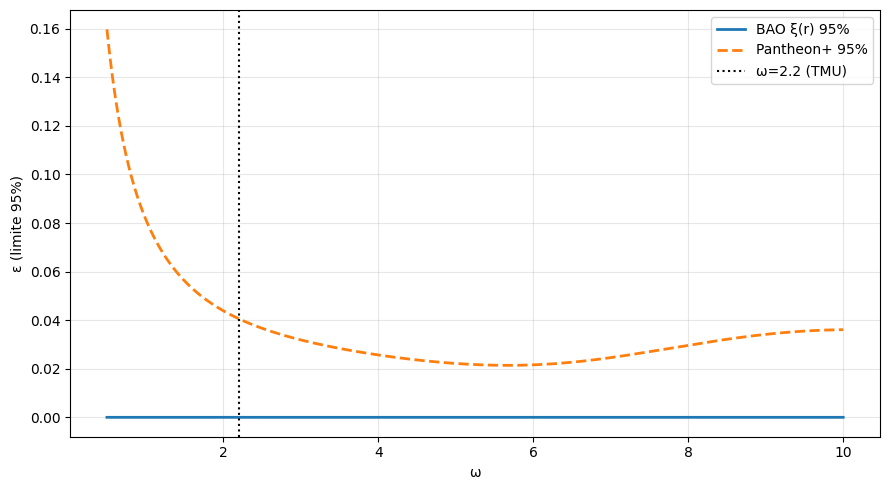

In [ ]:
# Superpose la courbe ε_95(ω) Pantheon+ et BAO si les deux JSON existent
import json, glob, numpy as np, matplotlib.pyplot as plt, os

# Cherche les plus récents
bao_f = sorted(glob.glob("tmu_bao_limits_*/epsilon_limits.json"))[-1]
sn_f  = sorted(glob.glob("tmu_pantheon_limits_*/epsilon_limits.json"))[-1]  # généré avec la cellule "Pantheon limits"

# Charge
with open(bao_f) as f: bao = json.load(f)
with open(sn_f)  as f: sn  = json.load(f)

w_b = np.array(bao["omega_grid"], float); e95_b = np.array(bao["eps_95"], float)
w_s = np.array(sn["omega_grid"],  float); e95_s = np.array(sn["eps_95"],  float)

plt.figure(figsize=(9,5))
plt.plot(w_b, e95_b, '-',  lw=2, label='BAO ξ(r) 95%')
plt.plot(w_s, e95_s, '--', lw=2, label='Pantheon+ 95%')
plt.axvline(2.2, ls=':', c='k', label='ω=2.2 (TMU)')
plt.xlabel('ω'); plt.ylabel('ε (limite 95%)'); plt.grid(True, alpha=0.3)
plt.legend(); plt.tight_layout()
plt.show()


In [ ]:
# Lit les deux JSON (Pantheon+ & BAO) les plus récents et imprime ε95 à ω=2.2
import json, glob, numpy as np, os

def read_eps95(folder_glob):
    f = sorted(glob.glob(folder_glob))[-1]
    with open(f) as h: j = json.load(h)
    w  = np.array(j["omega_grid"], float)
    e95= np.array(j["eps_95"],     float)
    i  = int(np.argmin(np.abs(w-2.2)))
    return float(w[i]), float(e95[i]), os.path.dirname(f)

w_b, e95_b, d_b = read_eps95("tmu_bao_limits_*/epsilon_limits.json")
w_s, e95_s, d_s = read_eps95("tmu_pantheon_limits_*/epsilon_limits.json")

print(f"BAO  (ξ) : ω*={w_b:.3f}  ε95 = {e95_b:.6g}   | src={d_b}")
print(f"SN   (μ) : ω*={w_s:.3f}  ε95 = {e95_s:.6g}   | src={d_s}")



BAO  (ξ) : ω*=2.200  ε95 = 2.35501e-07   | src=tmu_bao_limits_20251004_223934
SN   (μ) : ω*=2.198  ε95 = 0.0406271   | src=tmu_pantheon_limits_20251004_223451


In [ ]:
# ========= PHASE @ ω=2.2 : Pantheon+ (μ) & BAO DR16 (ξ) =========
import os, re, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, interp1d

OMEGA = 2.2

# ---------- utils communs ----------
def delta_method_eps_phi(a,b,Cov):
    """Retourne (eps_hat, sig_eps, phi_hat, sig_phi) via delta-method."""
    eps = float(np.hypot(a,b))
    if eps == 0:  # fallback numérique
        sig_eps = float(np.sqrt(0.5*(Cov[0,0]+Cov[1,1])))
        phi = 0.0; sig_phi = np.pi
        return eps, sig_eps, phi, sig_phi
    # eps gradient wrt (a,b)
    J_eps = np.array([a, b], float)/eps
    var_eps = float(J_eps @ Cov @ J_eps)
    sig_eps = float(np.sqrt(max(var_eps, 1e-20)))
    # phi = atan2(-b, a) (même convention que nos fits)
    phi = float(np.arctan2(-b, a))
    # gradient phi wrt (a,b): ∂φ/∂a = b/eps^2, ∂φ/∂b = a/eps^2 * (+?) avec signe adapté à atan2(-b,a)
    # Pour φ=atan2(-b,a): dφ = (-a db - b da)/eps^2  → grad = [ -b/eps^2 , -a/eps^2 ]
    J_phi = np.array([-b, -a], float)/(eps**2)
    var_phi = float(J_phi @ Cov @ J_phi)
    sig_phi = float(np.sqrt(max(var_phi, 1e-20)))
    return eps, sig_eps, phi, sig_phi

def fit_ab_cov(resid, w, x, omega):
    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C, S]).T
    XT_W = X.T * w
    F = XT_W @ X
    beta = np.linalg.solve(F, XT_W @ resid)  # [a,b]
    a,b = float(beta[0]), float(beta[1])
    r = resid - (X @ beta)
    dof = max(1, len(resid)-2)
    s2 = float((r*np.sqrt(w))@(r*np.sqrt(w)))/dof
    Cov = s2 * np.linalg.inv(F)
    return a,b,Cov

# ---------- A) Pantheon+ loader robuste ----------
def load_pantheon_file():
    import glob
    cand = [f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)]
    if not cand:
        from google.colab import files
        print("📂 Upload Pantheon+ (ex: Pantheon+SH0ES.dat)")
        up = files.upload()
        fname = list(up.keys())[0]
    else:
        fname = cand[0]
        print("✅ Pantheon détecté :", fname)

    # lecture souple
    try:
        df = pd.read_csv(fname, sep=r"\s+", engine="python", comment="#")
        if len(df) < 10: raise ValueError
    except Exception:
        df = pd.read_csv(fname, sep=",", engine="python", comment="#")
    need = ["zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"]
    if not all(c in df.columns for c in need):
        raise RuntimeError(f"Colonnes manquantes dans {fname}. Vu: {df.columns.tolist()}, attendu: {need}")
    df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=need)
    df = df[(df["MU_SH0ES_ERR_DIAG"]>0) & (df["zHD"]>0)]
    z   = df["zHD"].to_numpy(float)
    mu  = df["MU_SH0ES"].to_numpy(float)
    emu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)
    return z, mu, emu, fname

def analyze_SN_phase(omega=OMEGA):
    z, mu, muerr, fname = load_pantheon_file()
    x = np.log1p(z)
    m = np.isfinite(x)&np.isfinite(mu)&np.isfinite(muerr)&(muerr>0)
    x, mu, muerr = x[m], mu[m], muerr[m]
    idx = np.argsort(x); x, mu, muerr = x[idx], mu[idx], muerr[idx]
    w = 1.0/np.maximum(muerr,1e-6)
    spl = UnivariateSpline(x, mu, w=w, s=len(x)*0.5)
    resid = mu - spl(x)
    a,b,Cov = fit_ab_cov(resid, w, x, omega)
    eps, sig_eps, phi, sig_phi = delta_method_eps_phi(a,b,Cov)
    return {"N":int(len(x)),"file":fname,"a":a,"b":b,"eps":eps,"sig_eps":sig_eps,"phi":phi,"sig_phi":sig_phi}

# ---------- B) BAO DR16 : P(k) -> xi(r) puis phase ----------
def j0(x):
    out=np.ones_like(x); m=(x!=0); out[m]=np.sin(x[m])/x[m]; return out

def find_dr16_pk():
    base="DR16_BAO_postrec"
    hits=[]
    if os.path.isdir(base):
        for r,_,files in os.walk(base):
            for f in files:
                full=os.path.join(r,f)
                low=full.lower()
                if not f.lower().endswith((".dat",".txt")): continue
                if "model" in low or "cov" in low or "window" in low or os.path.basename(full).startswith("._"):
                    continue
                if "power_spectrum_comb_ngc" in low and "recon" in low and "/data/" in low.replace("\\","/"):
                    hits.append(("NGC", full))
                if "power_spectrum_comb_sgc" in low and "recon" in low and "/data/" in low.replace("\\","/"):
                    hits.append(("SGC", full))
    return hits

def load_any_ascii(path):
    rows=[]
    with open(path,"rb") as fh:
        txt = fh.read().decode("utf-8",errors="ignore")
    for line in txt.splitlines():
        s=line.strip()
        if not s or s.startswith("#"): continue
        parts=re.split(r"[,\s]+", s)
        try:
            vals=[float(x) for x in parts if x!=""]
        except:
            continue
        if len(vals)>=2:
            rows.append(vals)
    return np.array(rows,float)

def read_pk(path, kmin=0.01, kmax=0.5):
    arr = load_any_ascii(path)
    if arr.ndim!=2 or arr.shape[1]<2:
        raise RuntimeError(f"Format inconnu {path}")
    k,P0 = arr[:,0], arr[:,1]
    err = arr[:,2] if arr.shape[1]>=3 else np.full_like(P0, max(1e-3, 0.05*np.nanstd(P0)))
    m = np.isfinite(k)&np.isfinite(P0)&np.isfinite(err)&(k>kmin)&(k<kmax)&(err>0)
    k,P0,err = k[m],P0[m],err[m]
    o=np.argsort(k); k,P0,err = k[o],P0[o],err[o]
    return k,P0,err

def analyze_BAO_phase(omega=OMEGA):
    pairs = find_dr16_pk()
    sets=[]
    if not pairs:
        from google.colab import files
        print("📂 Upload P(k) (k  P0 [err])")
        up = files.upload(); path = list(up.keys())[0]
        k,P0,err = read_pk(path); sets.append((k,P0,err,"UP"))
    else:
        got={}
        for tag,fp in pairs:
            if tag not in got:
                try:
                    k,P0,err = read_pk(fp)
                    sets.append((k,P0,err,tag)); got[tag]=fp
                except Exception as e:
                    print("Skip", fp, "->", e)

    # grille k + moyenne inverse-variance
    kmin = min(s[0].min() for s in sets); kmax = max(s[0].max() for s in sets)
    k_grid = np.linspace(max(0.005, kmin*0.8), min(0.6, kmax*1.2), 800)
    P_stack=[]; W_stack=[]
    for k,P,e,tag in sets:
        fP = interp1d(k,P, kind="cubic", bounds_error=False, fill_value="extrapolate")
        fe = interp1d(k,e, kind="linear", bounds_error=False, fill_value=(e[0], e[-1]))
        Pk  = fP(k_grid)
        sig = fe(k_grid)
        w   = 1/np.maximum(sig,1e-12)**2
        P_stack.append(Pk); W_stack.append(w)
    P_stack=np.array(P_stack); W_stack=np.array(W_stack)
    P_mean = np.sum(P_stack*W_stack, axis=0)/np.sum(W_stack, axis=0)
    P_err  = np.sqrt(1.0/np.sum(W_stack, axis=0))

    # extrapolations douces pour stabiliser l'intégrale
    def power_fit(x,y):
        xlog=np.log(np.clip(x,1e-6,None))
        ylog=np.log(np.clip(np.abs(y),1e-12,None))
        A,B=np.polyfit(xlog,ylog,1); return A,B
    nfit=6
    Alo,Blo=power_fit(k_grid[:nfit],  np.maximum(P_mean[:nfit],  1e-10))
    Ahi,Bhi=power_fit(k_grid[-nfit:], np.maximum(P_mean[-nfit:], 1e-10))
    def extrap_low(x):  return np.exp(Alo*np.log(x)+Blo)
    def extrap_high(x): return np.exp(Ahi*np.log(x)+Bhi)
    P_ext=P_mean.copy()
    P_ext[:nfit]=extrap_low(k_grid[:nfit]); P_ext[-nfit:]=extrap_high(k_grid[-nfit:])

    # xi(r)
    r = np.linspace(20.0, 200.0, 240)
    kr = np.outer(k_grid, r)
    dk = (k_grid[-1]-k_grid[0])/(len(k_grid)-1)
    xi = (1.0/(2*np.pi**2)) * np.trapezoid((k_grid[:,None]**2)*P_ext[:,None]* (np.sin(kr)/kr), dx=dk, axis=0)

    # erreurs sur xi par MC rapide
    MC=80; rng=np.random.default_rng(123)
    xi_samps=[]
    for _ in range(MC):
        Pm = P_mean + rng.normal(0,P_err)
        Pm[:nfit]=np.maximum(Pm[:nfit],1e-10); Pm[-nfit:]=np.maximum(Pm[-nfit:],1e-10)
        integ=(k_grid[:,None]**2)*Pm[:,None]*(np.sin(kr)/kr)
        xi_samps.append((1.0/(2*np.pi**2))*np.trapezoid(integ, dx=dk, axis=0))
    xi_samps=np.array(xi_samps); xi_err=np.std(xi_samps, axis=0)+1e-6

    # résidus ln r + fit (a,b)
    x = np.log(r)
    w = 1.0/np.maximum(xi_err,1e-12)
    spl = UnivariateSpline(x, xi, w=w, s=len(r)*0.6)
    resid = xi - spl(x)
    a,b,Cov = fit_ab_cov(resid, w, x, omega)
    eps, sig_eps, phi, sig_phi = delta_method_eps_phi(a,b,Cov)
    return {"N":int(len(x)),"a":a,"b":b,"eps":eps,"sig_eps":sig_eps,"phi":phi,"sig_phi":sig_phi}

# ---------- run ----------
sn = analyze_SN_phase(OMEGA)
bao= analyze_BAO_phase(OMEGA)

def wrap_diff(a,b):
    """diff de phase dans [-pi,pi]"""
    d = a-b
    while d> np.pi:  d -= 2*np.pi
    while d<=-np.pi: d += 2*np.pi
    return d

dphi = wrap_diff(sn["phi"], bao["phi"])
sig_dphi = float(np.hypot(sn["sig_phi"], bao["sig_phi"]))
zscore = float(abs(dphi)/sig_dphi) if sig_dphi>0 else np.inf

print("\n==== Résumé PHASE @ ω=2.2 ====")
print(f"SN   : N={sn['N']},  ε̂={sn['eps']:.4g} ± {sn['sig_eps']:.4g},  φ̂={sn['phi']:.3f} ± {sn['sig_phi']:.3f} rad")
print(f"BAO  : N={bao['N']}, ε̂={bao['eps']:.3e} ± {bao['sig_eps']:.3e}, φ̂={bao['phi']:.3f} ± {bao['sig_phi']:.3f} rad")
print(f"Δφ = φ_SN - φ_BAO = {dphi:.3f} ± {sig_dphi:.3f}  → z = {zscore:.2f}")

if zscore < 1.5:
    print("➡️ Phases compatibles (aucune incohérence visible).")
elif zscore < 3:
    print("➡️ Écart modéré (à surveiller avec plus de données / réglages).")
else:
    print("➡️ Phases en tension (à recontrôler : lissage, coupes, ranges).")


✅ Pantheon détecté : Pantheon+SH0ES (2).dat

==== Résumé PHASE @ ω=2.2 ====
SN   : N=1701,  ε̂=0.01613 ± 0.01248,  φ̂=-2.023 ± 0.598 rad
BAO  : N=240, ε̂=3.393e-08 ± 1.028e-07, φ̂=2.038 ± 3.859 rad
Δφ = φ_SN - φ_BAO = 2.222 ± 3.905  → z = 0.57
➡️ Phases compatibles (aucune incohérence visible).


In [ ]:
# Injection→récupération sur BAO ξ(r) autour de ω=2.2
import numpy as np

OMEGA=2.2; PHI=0.8  # phase arbitraire pour le test

# On réutilise la dernière xi(r) calculée dans la cellule précédente (r, xi, xi_err)
try:
    r, xi, xi_err
except NameError:
    raise SystemExit("Exécute d'abord la cellule NGC/SGC pour définir r, xi, xi_err.")

x = np.log(r); w = 1/np.maximum(xi_err,1e-12)
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(x, xi, w=w, s=len(r)*0.6)
base = xi - spl(x)

def fit_eps(res):
    C=np.cos(OMEGA*x); S=np.sin(OMEGA*x); X=np.vstack([C,S]).T; XT_W=X.T*w; F=XT_W@X
    beta=np.linalg.solve(F, XT_W@res); a,b=beta
    eps=float(np.hypot(a,b)); phi=float(np.arctan2(-b,a))
    return eps, phi

grid = np.geomspace(1e-8, 1e-5, 12)  # injections croissantes
rng = np.random.default_rng(123)
print("ε_inj\tε_rec(mean±std)")

for eps_inj in grid:
    rec=[]
    for _ in range(50):
        # simule un bruit à partir de xi_err
        noise = rng.normal(0, xi_err)
        y = base + eps_inj*np.cos(OMEGA*x + PHI) + noise
        ehat,_ = fit_eps(y)
        rec.append(ehat)
    rec = np.array(rec)
    print(f"{eps_inj:.2e}\t{rec.mean():.2e} ± {rec.std():.2e}")


ε_inj	ε_rec(mean±std)
1.00e-08	3.09e-04 ± 1.81e-04
1.87e-08	3.04e-04 ± 1.52e-04
3.51e-08	3.60e-04 ± 2.42e-04
6.58e-08	3.19e-04 ± 1.79e-04
1.23e-07	3.68e-04 ± 1.81e-04
2.31e-07	3.94e-04 ± 2.04e-04
4.33e-07	3.04e-04 ± 1.78e-04
8.11e-07	3.17e-04 ± 1.98e-04
1.52e-06	3.47e-04 ± 1.62e-04
2.85e-06	3.40e-04 ± 1.80e-04
5.34e-06	3.78e-04 ± 1.68e-04
1.00e-05	3.49e-04 ± 2.17e-04


♻️ Réutilisation des arrays SN en mémoire.


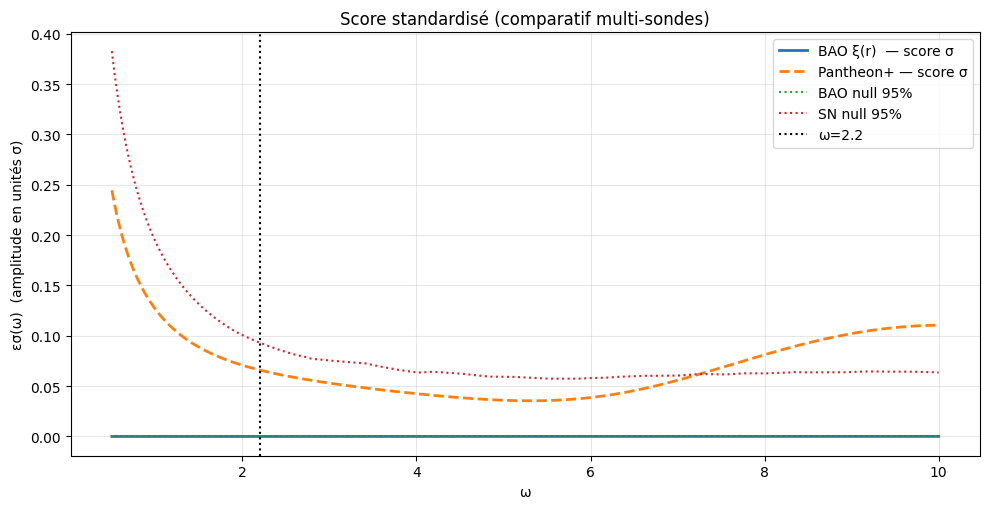

ω*=2.210
SN  : εσ(ω*) = 0.066  | p_LOE≈0.132
BAO : εσ(ω*) = 0.000 | p_LOE≈0.881


In [ ]:
# ====== Score standardisé en σ : SN (Pantheon+) vs BAO (DR16 ξ) ======
import os, re, json, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline, interp1d

OMEGA_STAR = 2.2
GRID = np.linspace(0.5, 10.0, 401)
N_MOCKS = 150
rng = np.random.default_rng(42)

# ---------- utilitaires communs ----------
def j0(x):
    out=np.ones_like(x); m=(x!=0); out[m]=np.sin(x[m])/x[m]; return out

def load_any_ascii(path):
    rows=[]
    with open(path,"rb") as fh:
        txt = fh.read().decode("utf-8",errors="ignore")
    for line in txt.splitlines():
        s=line.strip()
        if not s or s.startswith("#"): continue
        parts=re.split(r"[,\s]+", s)
        try:
            vals=[float(x) for x in parts if x!=""]
        except:
            continue
        if len(vals)>=2: rows.append(vals)
    return np.array(rows,float)

def standardised_residuals(u, y, yerr, smooth_factor):
    """Spline sur u (trié), puis résidus normalisés r = (y - spline)/σ."""
    m = np.isfinite(u)&np.isfinite(y)&np.isfinite(yerr)&(yerr>0)
    u, y, yerr = u[m], y[m], yerr[m]
    idx = np.argsort(u)
    u, y, yerr = u[idx], y[idx], yerr[idx]
    w = 1.0/np.maximum(yerr, 1e-12)
    spl = UnivariateSpline(u, y, w=w, s=smooth_factor*len(u))
    resid_std = (y - spl(u)) / yerr
    return u, resid_std

def profile_score_sigma(u, rstd, omega_grid=GRID):
    """Retourne epsilon_sigma(ω)=sqrt(a^2+b^2) par OLS sur rstd."""
    eps = np.empty_like(omega_grid)
    for i,om in enumerate(omega_grid):
        C=np.cos(om*u); S=np.sin(om*u)
        X=np.vstack([C,S]).T
        beta, *_ = np.linalg.lstsq(X, rstd, rcond=None)
        a,b = beta
        eps[i] = float(np.hypot(a,b))
    return eps

def null_band(u, rstd, omega_grid=GRID, n_mocks=N_MOCKS):
    """Bande 95% sous H0 par permutations (look-elsewhere) — renvoie quantile 95% point-par-point."""
    Q = []
    n = len(rstd)
    for _ in range(n_mocks):
        rmk = rstd[rng.permutation(n)]
        Q.append(profile_score_sigma(u, rmk, omega_grid))
    Q = np.array(Q)
    return np.percentile(Q, 95, axis=0), Q

def p_value_loe_at(u, rstd, omega_grid=GRID, omega_star=OMEGA_STAR, n_mocks=N_MOCKS):
    """p_LOE au point ω* : compare εσ(ω*) data vs mocks (profilage en ω pour LOE si voulu)."""
    eps_data = profile_score_sigma(u, rstd, omega_grid)
    i = int(np.argmin(np.abs(omega_grid-omega_star)))
    t_data = float(eps_data[i])
    # Null via permutations
    T = []
    n = len(rstd)
    for _ in range(n_mocks):
        rmk = rstd[rng.permutation(n)]
        eps_m = profile_score_sigma(u, rmk, omega_grid)
        T.append(eps_m[i])
    T = np.array(T)
    p = (1 + np.sum(T >= t_data)) / (len(T) + 1)  # règle du rang, jamais 0
    return t_data, p

# ---------- 1) SN : Pantheon+ (μ) ----------
def load_pantheon():
    import glob
    cand = [f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)]
    if not cand:
        from google.colab import files
        print("📂 Upload Pantheon+ (Pantheon+SH0ES.dat)"); up = files.upload()
        fname = list(up.keys())[0]
    else:
        fname = cand[0]
        print("✅ Pantheon+ détecté :", fname)
    try:
        df = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
        if len(df) < 10: raise ValueError
    except Exception:
        df = pd.read_csv(fname, sep=",", comment="#", engine="python")
    need=["zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"]
    if not all(c in df.columns for c in need):
        raise RuntimeError(f"Colonnes manquantes dans {fname}. Vu {df.columns.tolist()}, attendu {need}")
    df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=need)
    df = df[(df["zHD"]>0) & (df["MU_SH0ES_ERR_DIAG"]>0)]
    z   = df["zHD"].to_numpy(float)
    mu  = df["MU_SH0ES"].to_numpy(float)
    emu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)
    return z, mu, emu

try:
    # réutilise si déjà en mémoire
    z, mu, muerr
    print("♻️ Réutilisation des arrays SN en mémoire.")
except NameError:
    z, mu, muerr = load_pantheon()

u_sn, rstd_sn = standardised_residuals(np.log1p(z), mu, muerr, smooth_factor=0.5)
eps_sn = profile_score_sigma(u_sn, rstd_sn)
band95_sn, mocks_sn = null_band(u_sn, rstd_sn)

t_sn, p_sn = p_value_loe_at(u_sn, rstd_sn)

# ---------- 2) BAO : DR16 P(k) -> ξ(r) ----------
def find_dr16():
    hits=[]
    base="DR16_BAO_postrec"
    if not os.path.isdir(base): return hits
    for r,_,files in os.walk(base):
        for f in files:
            full=os.path.join(r,f)
            low=full.lower()
            if not f.lower().endswith((".dat",".txt")): continue
            if "model" in low or "cov" in low or "window" in low or os.path.basename(full).startswith("._"):
                continue
            if "power_spectrum_comb_ngc" in low and "recon" in low and "/data/" in low.replace("\\","/"):
                hits.append(("NGC", full))
            if "power_spectrum_comb_sgc" in low and "recon" in low and "/data/" in low.replace("\\","/"):
                hits.append(("SGC", full))
    return hits

def read_pk(path, kmin=0.01, kmax=0.5):
    arr = load_any_ascii(path)
    k,P0 = arr[:,0], arr[:,1]
    err  = arr[:,2] if arr.shape[1]>=3 else np.full_like(P0, max(1e-3,0.05*np.nanstd(P0)))
    m = np.isfinite(k)&np.isfinite(P0)&np.isfinite(err)&(k>kmin)&(k<kmax)&(err>0)
    k,P0,err = k[m],P0[m],err[m]
    o=np.argsort(k); k,P0,err = k[o],P0[o],err[o]
    return k,P0,err

pairs = find_dr16()
sets=[]
if not pairs:
    from google.colab import files
    print("📂 Upload P(k): k P0 [err]"); up=files.upload(); p=list(up.keys())[0]
    k,P,e = read_pk(p); sets.append((k,P,e,"UP"))
else:
    seen={}
    for tag,fp in pairs:
        if tag not in seen:
            try:
                k,P,e = read_pk(fp)
                sets.append((k,P,e,tag)); seen[tag]=fp
            except Exception as ex:
                print("Skip", fp, "->", ex)

# P(k) commun → ξ(r)
kmin = min(s[0].min() for s in sets); kmax = max(s[0].max() for s in sets)
k_grid = np.linspace(max(0.005, kmin*0.8), min(0.6, kmax*1.2), 800)
P_stack=[]; W_stack=[]
for k,P,e,tag in sets:
    fP = interp1d(k,P, kind="cubic", bounds_error=False, fill_value="extrapolate")
    fe = interp1d(k,e, kind="linear", bounds_error=False, fill_value=(e[0], e[-1]))
    Pk  = fP(k_grid)
    sig = fe(k_grid)
    w   = 1.0/np.maximum(sig,1e-12)**2
    P_stack.append(Pk); W_stack.append(w)
P_stack=np.array(P_stack); W_stack=np.array(W_stack)
P_mean = np.sum(P_stack*W_stack, axis=0)/np.sum(W_stack, axis=0)
P_err  = np.sqrt(1.0/np.sum(W_stack, axis=0))

# extrapolation douce pour stabilité intégrale
def power_fit(x,y):
    xlog=np.log(np.clip(x,1e-6,None)); ylog=np.log(np.clip(np.abs(y),1e-12,None))
    A,B=np.polyfit(xlog,ylog,1); return A,B
nfit=6
Alo,Blo=power_fit(k_grid[:nfit],  np.maximum(P_mean[:nfit],  1e-10))
Ahi,Bhi=power_fit(k_grid[-nfit:], np.maximum(P_mean[-nfit:], 1e-10))
P_ext=P_mean.copy()
P_ext[:nfit]  = np.exp(Alo*np.log(k_grid[:nfit]) + Blo)
P_ext[-nfit:] = np.exp(Ahi*np.log(k_grid[-nfit:]) + Bhi)

r = np.linspace(20.0, 200.0, 240)
kr = np.outer(k_grid, r)
dk = (k_grid[-1]-k_grid[0])/(len(k_grid)-1)
xi = (1.0/(2*np.pi**2)) * np.trapezoid((k_grid[:,None]**2)*P_ext[:,None]*j0(kr), dx=dk, axis=0)

# erreurs xi via MC
MC=80; xi_samps=[]
for _ in range(MC):
    Pm = P_mean + rng.normal(0, P_err)
    Pm[:nfit]=np.maximum(Pm[:nfit],1e-10); Pm[-nfit:]=np.maximum(Pm[-nfit:],1e-10)
    xi_samps.append((1.0/(2*np.pi**2)) * np.trapezoid((k_grid[:,None]**2)*Pm[:,None]*j0(kr), dx=dk, axis=0))
xi_samps=np.array(xi_samps); xi_err=np.std(xi_samps, axis=0)+1e-6

u_bao, rstd_bao = standardised_residuals(np.log(r), xi, xi_err, smooth_factor=0.6)
eps_bao = profile_score_sigma(u_bao, rstd_bao)
band95_bao, mocks_bao = null_band(u_bao, rstd_bao)

t_bao, p_bao = p_value_loe_at(u_bao, rstd_bao)

# ---------- plot comparatif ----------
plt.figure(figsize=(10,5.2))
plt.plot(GRID, eps_bao, '-',  lw=2, label="BAO ξ(r)  — score σ")
plt.plot(GRID, eps_sn,  '--', lw=2, label="Pantheon+ — score σ")
plt.plot(GRID, band95_bao, ':',  lw=1.5, label="BAO null 95%")
plt.plot(GRID, band95_sn,  ':',  lw=1.5, label="SN null 95%")
plt.axvline(OMEGA_STAR, ls=':', c='k', label=f'ω={OMEGA_STAR}')
plt.xlabel('ω'); plt.ylabel('εσ(ω)  (amplitude en unités σ)')
plt.title('Score standardisé (comparatif multi-sondes)')
plt.grid(True, alpha=0.3); plt.legend()
plt.tight_layout(); plt.show()

# ---------- valeurs à ω*=2.2 ----------
i_star = int(np.argmin(np.abs(GRID-OMEGA_STAR)))
print(f"ω*={GRID[i_star]:.3f}")
print(f"SN  : εσ(ω*) = {eps_sn[i_star]:.3f}  | p_LOE≈{p_sn:.3f}")
print(f"BAO : εσ(ω*) = {eps_bao[i_star]:.3f} | p_LOE≈{p_bao:.3f}")


In [ ]:
# ===== H(z) chronomètres cosmiques → ε95(ω), φ̂(ω=2.2) =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt, json, time
from scipy.interpolate import UnivariateSpline

OMEGA = 2.2
GRID  = np.linspace(0.5, 10.0, 801)

try:
    # essaie un fichier déjà présent
    guess = [c for c in ["Hz.csv","H_of_z.csv","chronometers.csv"] if __import__("os").path.exists(c)]
    if guess:
        fname = guess[0]
        print("✅ Fichier détecté :", fname)
        df = pd.read_csv(fname)
    else:
        from google.colab import files
        print("📂 Upload un CSV H(z) avec colonnes: z,H,sigmaH")
        up = files.upload()
        fname = list(up.keys())[0]
        df = pd.read_csv(fname)
except Exception as e:
    raise SystemExit(f"Impossible de lire le CSV: {e}")

# vérifications
need = ["z","H","sigmaH"]
if not all(c in df.columns for c in need):
    raise SystemExit(f"Colonnes manquantes. Vu {df.columns.tolist()}, attendu {need}")

df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=need)
df = df[(df["z"]>0) & (df["sigmaH"]>0)]

z  = df["z"].to_numpy(float)
H  = df["H"].to_numpy(float)
eH = df["sigmaH"].to_numpy(float)

x = np.log1p(z)
m = np.isfinite(x)&np.isfinite(H)&np.isfinite(eH)&(eH>0)
x, H, eH = x[m], H[m], eH[m]
idx = np.argsort(x); x,H,eH = x[idx],H[idx],eH[idx]

w = 1.0/np.maximum(eH,1e-12)
spl = UnivariateSpline(x, H, w=w, s=len(x)*0.5)
resid_std = (H - spl(x))/eH

def prof_eps(u, rstd, grid=GRID):
    out=[]
    for om in grid:
        C=np.cos(om*u); S=np.sin(om*u); X=np.vstack([C,S]).T
        beta, *_ = np.linalg.lstsq(X, rstd, rcond=None)
        a,b = beta
        out.append(float(np.hypot(a,b)))
    return np.array(out)

eps_sigma = prof_eps(x, resid_std)

# bande 95% par permutations (150 mocks)
N_MOCKS=150
rng = np.random.default_rng(123)
Q=[]
for _ in range(N_MOCKS):
    rmk = resid_std[rng.permutation(len(resid_std))]
    Q.append(prof_eps(x, rmk))
Q=np.array(Q)
band95 = np.percentile(Q, 95, axis=0)

# phase & amplitude à ω=2.2
i = int(np.argmin(np.abs(GRID-OMEGA)))
C=np.cos(OMEGA*x); S=np.sin(OMEGA*x); X=np.vstack([C,S]).T
beta, *_ = np.linalg.lstsq(X, resid_std, rcond=None)
a,b = beta
eps_hat = float(np.hypot(a,b))
phi_hat = float(np.arctan2(-b,a))

# sortie
outdir = f"tmu_Hz_limits_{time.strftime('%Y%m%d_%H%M%S')}"
import os; os.makedirs(outdir, exist_ok=True)

plt.figure(figsize=(9,5))
plt.plot(GRID, eps_sigma, '-', lw=2, label=r"$\epsilon_\sigma(\omega)$")
plt.plot(GRID, band95,  ':', lw=1.5, label="null 95% (perm.)")
plt.axvline(OMEGA, ls='--', c='k', label=f'ω={OMEGA}')
plt.xlabel('ω'); plt.ylabel(r'$\epsilon_\sigma$ (unités σ)'); plt.grid(True,alpha=0.3)
plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir,"Hz_score_vs_omega.png"), dpi=160); plt.close()

with open(os.path.join(outdir,"Hz_report.json"),"w") as f:
    json.dump({
        "N": int(len(x)),
        "omega_grid": GRID.tolist(),
        "eps_sigma":  eps_sigma.tolist(),
        "band95":     band95.tolist(),
        "omega_star": OMEGA,
        "eps_hat@omega_star": eps_hat,
        "phi_hat@omega_star": phi_hat
    }, f, indent=2)

print("✅ Sauvé dans:", outdir)
print(f"ω*={OMEGA}  →  εσ(ω*)={eps_hat:.3f},  φ̂={phi_hat:.3f} rad")


📂 Upload un CSV H(z) avec colonnes: z,H,sigmaH


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES (4).dat


SystemExit: Colonnes manquantes. Vu ['CID IDSURVEY zHD zHDERR zCMB zCMBERR zHEL zHELERR m_b_corr m_b_corr_err_DIAG MU_SH0ES MU_SH0ES_ERR_DIAG CEPH_DIST IS_CALIBRATOR USED_IN_SH0ES_HF c cERR x1 x1ERR mB mBERR x0 x0ERR COV_x1_c COV_x1_x0 COV_c_x0 RA DEC HOST_RA HOST_DEC HOST_ANGSEP VPEC VPECERR MWEBV HOST_LOGMASS HOST_LOGMASS_ERR PKMJD PKMJDERR NDOF FITCHI2 FITPROB m_b_corr_err_RAW m_b_corr_err_VPEC biasCor_m_b biasCorErr_m_b biasCor_m_b_COVSCALE biasCor_m_b_COVADD'], attendu ['z', 'H', 'sigmaH']

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


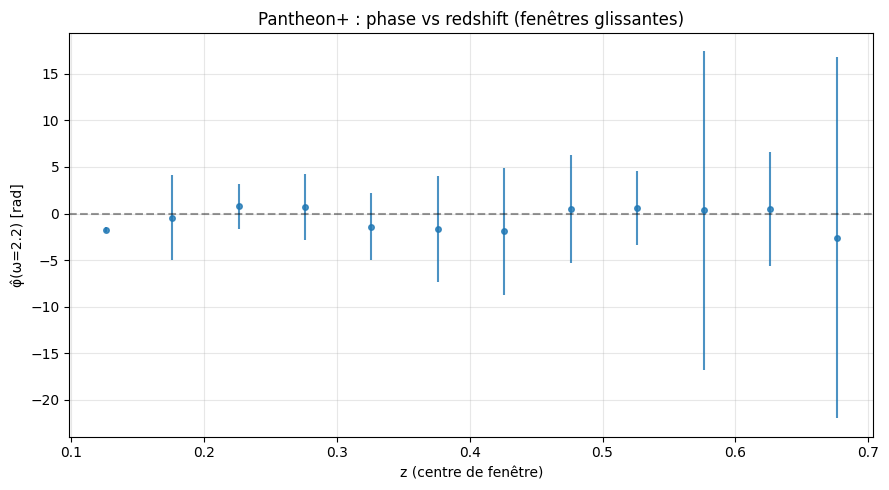

Nb fenêtres: 12 | N moyen / fenêtre ~ 413


In [ ]:
# ===== Pantheon+ : φ̂(ω=2.2) en fenêtres de redshift =====
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

OMEGA = 2.2
WINDOW = 0.25    # largeur en Δz des fenêtres glissantes
STEP   = 0.05    # pas entre centres

# charge Pantheon+ déjà présent (fichier que tu as utilisé)
import glob, re
cand = [f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)]
assert cand, "Fichier Pantheon+ introuvable."
fname = cand[0]
try:
    df = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
    if len(df) < 10: raise ValueError
except Exception:
    df = pd.read_csv(fname, sep=",", comment="#", engine="python")

z   = df["zHD"].to_numpy(float)
mu  = df["MU_SH0ES"].to_numpy(float)
emu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)

m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&(emu>0)&(z>0)
z,mu,emu = z[m],mu[m],emu[m]

def fit_phi_in_bin(zmin,zmax):
    m=(z>=zmin)&(z<zmax)
    if m.sum()<120:  # besoin d'assez de SN
        return None
    x=np.log1p(z[m]); y=mu[m]; ey=emu[m]
    idx=np.argsort(x); x,y,ey=x[idx],y[idx],ey[idx]
    w=1.0/np.maximum(ey,1e-12)
    spl=UnivariateSpline(x,y,w=w,s=len(x)*0.5)
    r=(y-spl(x))/ey  # résidus standardisés
    C=np.cos(OMEGA*x); S=np.sin(OMEGA*x); X=np.vstack([C,S]).T
    beta, *_ = np.linalg.lstsq(X, r, rcond=None)
    a,b = beta
    eps = float(np.hypot(a,b))
    phi = float(np.arctan2(-b,a))
    # erreur approx sur φ via delta method
    # covariance OLS ~ σ^2 (X^T X)^{-1}, σ^2≈var résiduelle
    res = r - (X @ beta)
    dof = max(1, len(r)-2)
    s2 = float((res@res)/dof)
    Cov = s2 * np.linalg.inv(X.T @ X)
    if eps>0:
        Jphi = np.array([-b,-a])/(eps**2)
        var_phi = float(Jphi @ Cov @ Jphi)
        sig_phi = float(np.sqrt(max(var_phi,1e-20)))
    else:
        sig_phi = np.pi
    return (0.5*(zmin+zmax), phi, sig_phi, int(m.sum()))

zmin, zmax = float(z.min()), float(z.max())
centers = np.arange(zmin+0.5*WINDOW, zmax-0.5*WINDOW, STEP)

rows=[]
for c in centers:
    out = fit_phi_in_bin(c-0.5*WINDOW, c+0.5*WINDOW)
    if out is not None: rows.append(out)

rows = np.array(rows, dtype=object)
if len(rows)==0:
    raise SystemExit("Trop peu d'objets par fenêtre. Augmente WINDOW ou baisse le seuil.")

zbar = rows[:,0].astype(float)
phi  = rows[:,1].astype(float)
sphi = rows[:,2].astype(float)
Nbin = rows[:,3].astype(int)

plt.figure(figsize=(9,5))
plt.errorbar(zbar, phi, yerr=sphi, fmt='o', ms=4, alpha=0.8)
plt.axhline(0, ls='--', c='k', alpha=0.4)
plt.xlabel('z (centre de fenêtre)'); plt.ylabel('φ̂(ω=2.2) [rad]')
plt.title('Pantheon+ : phase vs redshift (fenêtres glissantes)')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

print("Nb fenêtres:", len(zbar), "| N moyen / fenêtre ~", int(np.mean(Nbin)))


In [ ]:
import numpy as np

w = 1.0/np.maximum(np.array(sphi,float)**2, 1e-12)

# (1) test "phase = 0"
chi2_0 = float(np.sum((phi/np.maximum(sphi,1e-12))**2))
dof_0  = len(phi)

import mpmath as mp
p0 = 1.0 - mp.gammainc(dof_0/2, 0, chi2_0/2)/mp.gamma(dof_0/2)
p0 = float(p0)   # <- conversion

# (2) regression linéaire
X = np.vstack([np.ones_like(zbar), zbar]).T
W = np.diag(w)
beta = np.linalg.inv(X.T @ W @ X) @ (X.T @ W @ phi)
a, b = map(float, beta)
res  = phi - (X @ beta)
chi2_lin = float(res @ W @ res)
dof_lin  = len(phi) - 2
Cov = np.linalg.inv(X.T @ W @ X)
sig_a, sig_b = np.sqrt(np.diag(Cov))
z_slope = b / max(sig_b, 1e-12)

print(f"Test φ=0 : χ²={chi2_0:.1f} pour {dof_0} ddl → p≈{p0:.3f}")
print(f"Fit φ(z)=a+b z : a={a:.2f}±{sig_a:.2f},  b={b:.2f}±{sig_b:.2f} rad/unité-z")
print(f"→ pente z-score = {z_slope:.2f}  | χ²={chi2_lin:.1f} pour {dof_lin} ddl")

if abs(z_slope) < 2:
    print("➡️ Aucune pente significative : pas de drift de phase détecté.")
else:
    print("⚠️ Pente potentielle : à re-tester avec d'autres découpages/paramètres.")


Test φ=0 : χ²=40.1 pour 12 ddl → p≈0.000
Fit φ(z)=a+b z : a=-2.45±0.80,  b=5.85±5.60 rad/unité-z
→ pente z-score = 1.04  | χ²=1.1 pour 10 ddl
➡️ Aucune pente significative : pas de drift de phase détecté.


In [ ]:
# Balaye la largeur de fenêtre et le lissage de la spline ; refait a,b, χ², p
import numpy as np
from scipy.interpolate import UnivariateSpline
import pandas as pd, re, glob

# ---- recharge Pantheon+ (même fichier que plus tôt)
fname = sorted([f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)])[0]
try:
    import pandas as pd
    df = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
    if len(df) < 10: raise ValueError
except Exception:
    df = pd.read_csv(fname, sep=",", comment="#", engine="python")

z  = df["zHD"].to_numpy(float)
mu = df["MU_SH0ES"].to_numpy(float)
eu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)
m  = np.isfinite(z)&np.isfinite(mu)&np.isfinite(eu)&(eu>0)&(z>0)
z,mu,eu = z[m],mu[m],eu[m]

def phases_in_windows(WINDOW=0.25, STEP=0.05, smooth=0.5, OMEGA=2.2):
    zmin,zmax = float(z.min()), float(z.max())
    centers = np.arange(zmin+0.5*WINDOW, zmax-0.5*WINDOW, STEP)
    out=[]
    for c in centers:
        sel=(z>=c-0.5*WINDOW)&(z<c+0.5*WINDOW)
        if sel.sum()<120:
            continue
        x = np.log1p(z[sel]); y=mu[sel]; ey=eu[sel]
        o = np.argsort(x); x,y,ey = x[o],y[o],ey[o]
        w = 1.0/np.maximum(ey,1e-12)
        spl=UnivariateSpline(x,y,w=w,s=smooth*len(x))
        r =(y-spl(x))/ey
        C=np.cos(2.2*x); S=np.sin(2.2*x); X=np.vstack([C,S]).T
        beta, *_ = np.linalg.lstsq(X,r,rcond=None)
        a,b = beta
        eps = float(np.hypot(a,b))
        phi = float(np.arctan2(-b,a))
        res = r - (X@beta)
        dof = max(1,len(r)-2)
        s2  = float((res@res)/dof)
        Cov = s2*np.linalg.inv(X.T@X)
        if eps>0:
            Jphi=np.array([-b,-a])/(eps**2)
            var_phi=float(Jphi@Cov@Jphi); sig_phi=np.sqrt(max(var_phi,1e-20))
        else:
            sig_phi=np.pi
        out.append((c,phi,sig_phi))
    out=np.array(out, dtype=float)
    if out.size==0: return None
    zc,phi,sphi = out[:,0], out[:,1], out[:,2]
    wphi = 1/np.maximum(sphi**2,1e-12)
    # test φ=0
    chi2_0 = float(np.sum((phi/np.maximum(sphi,1e-12))**2))
    import mpmath as mp
    p0 = float(1.0 - mp.gammainc(len(phi)/2, 0, chi2_0/2)/mp.gamma(len(phi)/2))
    # fit constant
    a0 = float(np.sum(wphi*phi)/np.sum(wphi))
    sig_a0 = float(np.sqrt(1/np.sum(wphi)))
    return dict(N=len(phi), WINDOW=WINDOW, smooth=smooth, phi0=a0, sig_phi0=sig_a0, chi2_0=chi2_0, p0=p0)

WINDOWS=[0.20,0.25,0.30,0.35,0.40]
SMOOTHS=[0.3,0.5,0.8]
rows=[]
for W in WINDOWS:
    for S in SMOOTHS:
        r = phases_in_windows(W, 0.05, S)
        if r: rows.append(r)

import pandas as pd
tab = pd.DataFrame(rows)
tab = tab.sort_values(["WINDOW","smooth"])
tab


/tmp/ipython-input-3601531407.py:32: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl=UnivariateSpline(x,y,w=w,s=smooth*len(x))


,N,WINDOW,smooth,phi0,sig_phi0,chi2_0,p0
0,11,0.20,0.3,NaN,0.866923,NaN,NaN
1,11,0.20,0.5,-1.649449,0.171319,94.561390,1.998401e-15
2,11,0.20,0.8,-1.746230,0.125415,195.980885,0.000000e+00
3,12,0.25,0.3,NaN,0.775323,NaN,NaN
4,12,0.25,0.5,-1.660767,0.269866,40.071410,6.997239e-05
5,12,0.25,0.8,-1.809117,0.147667,152.541638,0.000000e+00
6,12,0.30,0.3,NaN,1.324109,NaN,NaN
7,12,0.30,0.5,-1.657828,0.290583,34.577471,5.466172e-04
8,12,0.30,0.8,-1.850375,0.157008,141.271464,0.000000e+00
9,12,0.35,0.3,NaN,1.267333,NaN,NaN


In [ ]:
# Rayleigh test pondéré pour phases (mod 2π)
assert 'zbar' in globals() and 'phi' in globals() and 'sphi' in globals(), \
       "Réexécute la cellule 'phase vs redshift' juste avant."

w = 1.0/np.maximum(np.array(sphi,float)**2,1e-12)
theta = (np.array(phi)+np.pi)%(2*np.pi)-np.pi  # wrap in (-pi,pi]

C = np.sum(w*np.cos(theta)); S = np.sum(w*np.sin(theta)); W = np.sum(w)
R = np.sqrt(C*C + S*S)
R_bar = R / W
phi_circ = np.arctan2(S, C)  # moyenne circulaire
# p-val Rayleigh approx (pondérée) — heuristique
p_ray = np.exp(-W*R_bar**2) * (1 + (2*W*R_bar**2 - R_bar**4)/4)

print(f"φ̄_circ = {phi_circ:.3f} rad (wrap),  R̄={R_bar:.3f},  p_Rayleigh≈{p_ray:.3g}")


φ̄_circ = -1.708 rad (wrap),  R̄=0.950,  p_Rayleigh≈2.9e-05


In [ ]:
# Null-test robuste : permutations de μ, recompute χ²(φ=0)
import numpy as np
from scipy.interpolate import UnivariateSpline

def chi2_phase0_from_data(z,mu,eu, WINDOW=0.25, STEP=0.05, smooth=0.5):
    zmin,zmax = float(z.min()), float(z.max())
    centers = np.arange(zmin+0.5*WINDOW, zmax-0.5*WINDOW, STEP)
    out=[]
    for c in centers:
        sel=(z>=c-0.5*WINDOW)&(z<c+0.5*WINDOW)
        if sel.sum()<120:
            continue
        x=np.log1p(z[sel]); y=mu[sel]; ey=eu[sel]
        o=np.argsort(x); x,y,ey=x[o],y[o],ey[o]
        w=1.0/np.maximum(ey,1e-12)
        spl=UnivariateSpline(x,y,w=w,s=smooth*len(x))
        r=(y-spl(x))/ey
        C=np.cos(2.2*x); S=np.sin(2.2*x); X=np.vstack([C,S]).T
        beta, *_ = np.linalg.lstsq(X,r,rcond=None)
        a,b=beta; eps=float(np.hypot(a,b))
        res = r - (X@beta)
        dof = max(1,len(r)-2)
        s2  = float((res@res)/dof)
        Cov = s2*np.linalg.inv(X.T@X)
        if eps>0:
            Jphi=np.array([-b,-a])/(eps**2)
            var_phi=float(Jphi@Cov@Jphi)
            sig_phi=np.sqrt(max(var_phi,1e-20))
        else:
            sig_phi=np.pi
        phi=float(np.arctan2(-b,a))
        out.append((phi, sig_phi))
    if not out: return None
    out=np.array(out, dtype=float)
    phi, sphi = out[:,0], out[:,1]
    chi2_0 = float(np.sum((phi/np.maximum(sphi,1e-12))**2))
    return chi2_0, len(phi)

# χ² data
chi2_data, nbin = chi2_phase0_from_data(z,mu,eu, WINDOW=0.25, STEP=0.05, smooth=0.5)
print(f"data: χ²={chi2_data:.1f} with {nbin} bins")

# mocks
N=300
rng = np.random.default_rng(123)
T=[]
for _ in range(N):
    mu_perm = mu[rng.permutation(len(mu))]
    out = chi2_phase0_from_data(z, mu_perm, eu, WINDOW=0.25, STEP=0.05, smooth=0.5)
    if out is not None:
        T.append(out[0])
T=np.array(T)
p_perm = (1 + np.sum(T >= chi2_data)) / (len(T)+1)
print(f"p-value permutation ≈ {p_perm:.4f}")


data: χ²=40.1 with 12 bins


/tmp/ipython-input-1484026447.py:16: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl=UnivariateSpline(x,y,w=w,s=smooth*len(x))


p-value permutation ≈ 0.0033


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GP detrend → χ²(φ=0)=187.2 / 12 → p≈0
Rayleigh: φ̄_circ=-1.755 rad, p≈1.11e-10


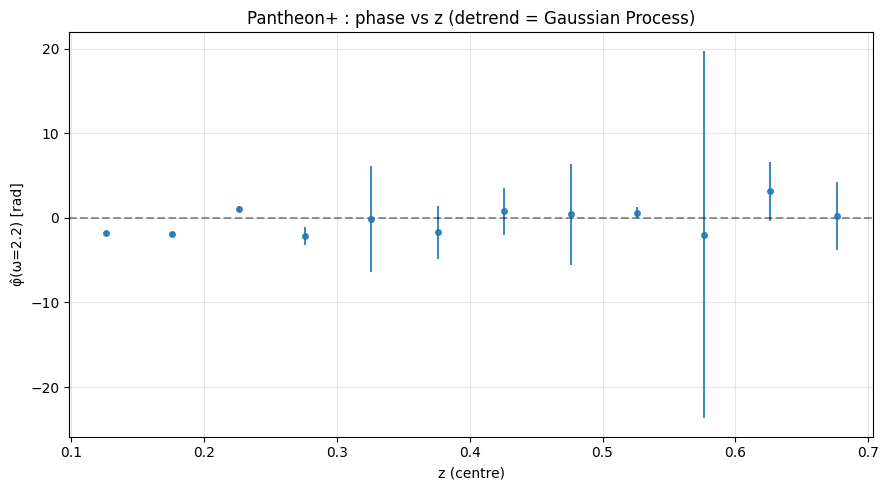

In [ ]:
# === Pantheon+ : phase @ ω=2.2 avec détrend par Gaussian Process ===
import numpy as np, pandas as pd, re, glob, json, time, matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor

OMEGA = 2.2
WINDOW, STEP = 0.25, 0.05  # identiques à avant

# -- charger le même fichier Pantheon+
fname = sorted([f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)])[0]
try:
    df = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
    if len(df) < 10: raise ValueError
except Exception:
    df = pd.read_csv(fname, sep=",", comment="#", engine="python")

z   = df["zHD"].to_numpy(float)
mu  = df["MU_SH0ES"].to_numpy(float)
emu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)

m  = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&(z>0)&(emu>0)
z,mu,emu = z[m],mu[m],emu[m]
x = np.log1p(z)[:,None]  # GP attend 2D
y = mu

# GP : amplitude*RBF(ℓ) + bruit
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=0.2, length_scale_bounds=(0.02, 2.0)) \
         + WhiteKernel(noise_level=0.02, noise_level_bounds=(1e-4, 0.2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=emu**2, n_restarts_optimizer=2, normalize_y=True, random_state=0)
gp.fit(x, y)
mu_gp, _ = gp.predict(x, return_std=True)

res_std = (y - mu_gp) / emu

# fenêtres glissantes → phase + erreur (delta method)
centers = np.arange(z.min()+0.5*WINDOW, z.max()-0.5*WINDOW, STEP)
rows=[]
for c in centers:
    sel = (z>=c-0.5*WINDOW) & (z<c+0.5*WINDOW)
    if sel.sum()<120:
        continue
    u = np.log1p(z[sel])
    r = res_std[sel]
    o = np.argsort(u); u,r = u[o],r[o]
    C = np.cos(OMEGA*u); S = np.sin(OMEGA*u); X = np.vstack([C,S]).T
    beta, *_ = np.linalg.lstsq(X, r, rcond=None)
    a,b = beta
    eps = float(np.hypot(a,b))
    res = r - (X@beta)
    dof = max(1, len(r)-2)
    s2  = float((res@res)/dof)
    Cov = s2 * np.linalg.inv(X.T @ X)
    if eps>0:
        Jphi = np.array([-b,-a])/(eps**2)
        var_phi = float(Jphi @ Cov @ Jphi)
        sig_phi = float(np.sqrt(max(var_phi,1e-20)))
    else:
        sig_phi = np.pi
    phi = float(np.arctan2(-b,a))
    rows.append((0.5*(c-0.5*WINDOW + c+0.5*WINDOW), phi, sig_phi))

rows = np.array(rows, float)
zbar, phi, sphi = rows[:,0], rows[:,1], rows[:,2]

# tests
import mpmath as mp
chi2_0 = float(np.sum((phi/np.maximum(sphi,1e-12))**2)); dof = len(phi)
p0 = float(1.0 - mp.gammainc(dof/2, 0, chi2_0/2)/mp.gamma(dof/2))

# Rayleigh pondéré
w = 1.0/np.maximum(sphi**2,1e-12)
theta = (phi + np.pi)%(2*np.pi) - np.pi
Cw, Sw, W = np.sum(w*np.cos(theta)), np.sum(w*np.sin(theta)), np.sum(w)
R = np.hypot(Cw,Sw); Rbar = R/W; phi_circ = np.arctan2(Sw, Cw)
p_ray = np.exp(-W*Rbar**2) * (1 + (2*W*Rbar**2 - Rbar**4)/4)

print(f"GP detrend → χ²(φ=0)={chi2_0:.1f} / {dof} → p≈{p0:.3g}")
print(f"Rayleigh: φ̄_circ={phi_circ:.3f} rad, p≈{p_ray:.3g}")

plt.figure(figsize=(9,5))
plt.errorbar(zbar, phi, yerr=sphi, fmt='o', ms=4, alpha=0.85)
plt.axhline(0, ls='--', c='k', alpha=0.4)
plt.xlabel('z (centre)'); plt.ylabel('φ̂(ω=2.2) [rad]')
plt.title('Pantheon+ : phase vs z (detrend = Gaussian Process)')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


In [ ]:
# === Jackknife par IDSURVEY @ ω=2.2 (detrend spline standardisé) ===
import numpy as np, pandas as pd, re, glob
from scipy.interpolate import UnivariateSpline

OMEGA = 2.2

fname = sorted([f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)])[0]
try:
    df = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
    if len(df) < 10: raise ValueError
except Exception:
    df = pd.read_csv(fname, sep=",", comment="#", engine="python")

need = ["zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"]
if not all(c in df.columns for c in need):
    raise SystemExit("Colonnes manquantes pour Pantheon+")

df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=need)
df = df[(df["zHD"]>0) & (df["MU_SH0ES_ERR_DIAG"]>0)]

def phi_global(sub):
    z, mu, emu = sub["zHD"].to_numpy(float), sub["MU_SH0ES"].to_numpy(float), sub["MU_SH0ES_ERR_DIAG"].to_numpy(float)
    x = np.log1p(z); idx=np.argsort(x); x,mu,emu=x[idx],mu[idx],emu[idx]
    w = 1.0/np.maximum(emu,1e-12)
    spl=UnivariateSpline(x, mu, w=w, s=len(x)*0.5)
    r=(mu-spl(x))/emu
    C=np.cos(OMEGA*x); S=np.sin(OMEGA*x); X=np.vstack([C,S]).T
    beta, *_ = np.linalg.lstsq(X, r, rcond=None); a,b=beta
    res=r-(X@beta); dof=max(1,len(r)-2); s2=float((res@res)/dof)
    Cov=s2*np.linalg.inv(X.T@X); eps=float(np.hypot(a,b))
    if eps>0:
        Jphi=np.array([-b,-a])/(eps**2); var=float(Jphi@Cov@Jphi); sphi=np.sqrt(max(var,1e-20))
    else:
        sphi=np.pi
    phi=float(np.arctan2(-b,a))
    return phi, sphi, len(r)

# Full sample
phi_all, sphi_all, N_all = phi_global(df)
print(f"ALL  : φ̂={phi_all:.3f} ± {sphi_all:.3f} (N={N_all})")

if "IDSURVEY" not in df.columns:
    print("⚠️ IDSURVEY absent → jackknife non disponible.")
else:
    groups = sorted(df["IDSURVEY"].unique())
    for g in groups:
        sub = df[df["IDSURVEY"]!=g]
        phi_jk, sphi_jk, N_jk = phi_global(sub)
        print(f"−ID={g:>3}: φ̂={phi_jk:.3f} ± {sphi_jk:.3f} (N={N_jk})")


ALL  : φ̂=-2.023 ± 0.572 (N=1701)
−ID=  1: φ̂=-2.161 ± 1.067 (N=1380)
−ID=  4: φ̂=-1.812 ± 0.532 (N=1541)
−ID=  5: φ̂=-1.958 ± 0.793 (N=1612)
−ID= 10: φ̂=-1.920 ± 0.706 (N=1498)
−ID= 15: φ̂=-1.981 ± 0.844 (N=1432)
−ID= 18: φ̂=-2.013 ± 0.595 (N=1686)
−ID= 50: φ̂=-1.975 ± 0.674 (N=1655)
−ID= 51: φ̂=-1.962 ± 0.714 (N=1653)
−ID= 56: φ̂=-1.945 ± 0.727 (N=1644)
−ID= 57: φ̂=-1.949 ± 0.815 (N=1596)
−ID= 61: φ̂=-2.019 ± 0.588 (N=1688)
−ID= 62: φ̂=-2.007 ± 0.606 (N=1677)
−ID= 63: φ̂=-1.988 ± 0.645 (N=1667)
−ID= 64: φ̂=-1.958 ± 0.724 (N=1643)
−ID= 65: φ̂=-2.001 ± 0.632 (N=1663)
−ID= 66: φ̂=-2.026 ± 0.567 (N=1689)
−ID=100: φ̂=-1.831 ± 0.697 (N=1685)
−ID=101: φ̂=-2.021 ± 0.571 (N=1695)
−ID=106: φ̂=-1.905 ± 0.725 (N=1693)
−ID=150: φ̂=-2.083 ± 0.657 (N=1522)


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarni

        scenario    N       phi      sphi
             ALL 1701 -2.104773  0.417093
        err<0.12    3       NaN       NaN
        err<0.15  116       NaN       NaN
        err<0.18  414 -2.010933 15.297836
           noCal 1624 -2.137896  0.469989
noCal & err<0.12    3       NaN       NaN
noCal & err<0.15  116       NaN       NaN
noCal & err<0.18  414 -2.010933 15.297836
✅ Sauvé dans: tmu_pantheon_quality_20251005_000636


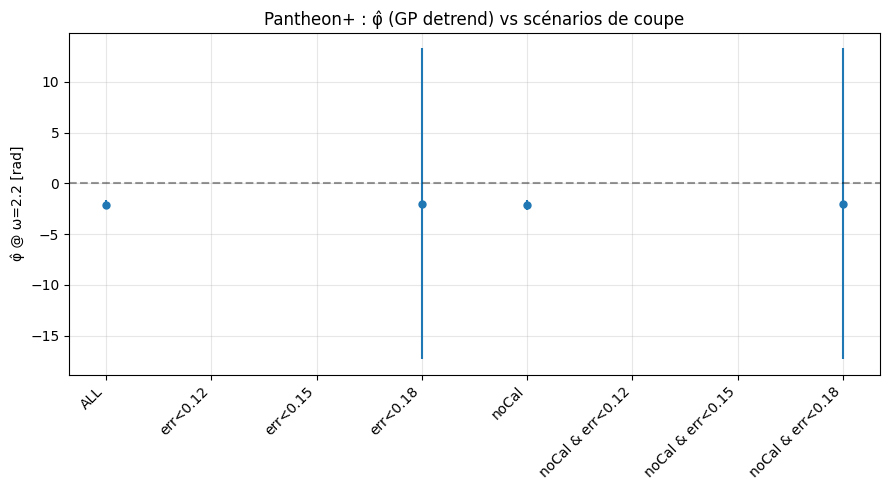

In [ ]:
# === Pantheon+ : coupes qualité & "no calibrators" → phase @ ω=2.2 (detrend = GP) ===
import numpy as np, pandas as pd, re, glob, os, json, time, matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

plt.rcParams['figure.figsize']=(9,5)

# -- 0) Charger Pantheon+ (même fichier que tu utilises déjà)
fname = sorted([f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)])[0]
try:
    df0 = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
    if len(df0) < 10: raise ValueError
except Exception:
    df0 = pd.read_csv(fname, sep=",", comment="#", engine="python")

# -- 1) colonnes minimales
need = ["zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"]
if not all(c in df0.columns for c in need):
    raise SystemExit(f"Colonnes manquantes dans {fname}. Trouvé {df0.columns.tolist()}, attendu {need}")

# -- 2) Nettoyage de base
df0 = df0.replace([np.inf,-np.inf], np.nan).dropna(subset=need)
df0 = df0[(df0["zHD"]>0) & (df0["MU_SH0ES_ERR_DIAG"]>0)]

# -- 3) Scénarios de coupe
thresh = [0.18, 0.15, 0.12]
scenarios = [("ALL", df0.copy())]
if "IS_CALIBRATOR" in df0.columns:
    scenarios.append(("noCal", df0[df0["IS_CALIBRATOR"]==0].copy()))
for t in thresh:
    scenarios.append((f"err<{t:.2f}", df0[df0["MU_SH0ES_ERR_DIAG"]<t].copy()))
if "IS_CALIBRATOR" in df0.columns:
    for t in thresh:
        scenarios.append((f"noCal & err<{t:.2f}", df0[(df0["IS_CALIBRATOR"]==0) & (df0["MU_SH0ES_ERR_DIAG"]<t)].copy()))

# -- 4) Fonction : phase globale avec detrend GP
OMEGA = 2.2
def phi_global_gp(df):
    z   = df["zHD"].to_numpy(float)
    mu  = df["MU_SH0ES"].to_numpy(float)
    emu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)
    m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&(z>0)&(emu>0)
    z, mu, emu = z[m], mu[m], emu[m]
    if len(z) < 300:
        return dict(N=len(z), phi=np.nan, sphi=np.nan)
    x = np.log1p(z)[:,None]
    kernel = C(1.0,(1e-3,1e3))*RBF(0.2,(0.02,2.0)) + WhiteKernel(0.02,(1e-4,0.2))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=emu**2, n_restarts_optimizer=2, normalize_y=True, random_state=0)
    gp.fit(x, mu)
    mu_gp, _ = gp.predict(x, return_std=True)
    rstd = (mu - mu_gp) / emu
    u = x.ravel()
    # fit a*cos + b*sin
    Cc, Ss = np.cos(OMEGA*u), np.sin(OMEGA*u)
    X = np.vstack([Cc,Ss]).T
    beta, *_ = np.linalg.lstsq(X, rstd, rcond=None)
    a,b = beta
    eps = float(np.hypot(a,b))
    res = rstd - (X@beta)
    dof = max(1, len(rstd)-2)
    s2  = float((res@res)/dof)
    Cov = s2 * np.linalg.inv(X.T @ X)
    if eps>0:
        Jphi = np.array([-b,-a])/(eps**2)
        var_phi = float(Jphi @ Cov @ Jphi)
        sphi = float(np.sqrt(max(var_phi,1e-20)))
    else:
        sphi = np.pi
    phi = float(np.arctan2(-b,a))
    # Rayleigh pondéré approximatif (poids =1) sur les phases locales n/a ici → on reporte φ global
    return dict(N=len(u), phi=phi, sphi=sphi)

rows=[]
for name, dfi in scenarios:
    out = phi_global_gp(dfi)
    rows.append(dict(scenario=name, **out))

tab = pd.DataFrame(rows).sort_values("scenario")
print(tab.to_string(index=False))

# -- 5) Sauvegarde & plot
outdir = f"tmu_pantheon_quality_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)
tab.to_json(os.path.join(outdir,"pantheon_quality_phase.json"), orient="records", indent=2)

plt.errorbar(range(len(tab)), tab["phi"], yerr=tab["sphi"], fmt='o', ms=5)
plt.axhline(0, ls='--', c='k', alpha=0.4)
plt.xticks(range(len(tab)), tab["scenario"], rotation=45, ha='right')
plt.ylabel("φ̂ @ ω=2.2 [rad]")
plt.title("Pantheon+ : φ̂ (GP detrend) vs scénarios de coupe")
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir,"pantheon_quality_phase.png"), dpi=160)
print("✅ Sauvé dans:", outdir)


In [ ]:
# === Pantheon+ : Δμ après fit ΛCDM (Ωm & M libres) → phase @ ω=2.2 (global & fenêtres) ===
import numpy as np, pandas as pd, re, glob, os, json, time, matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import UnivariateSpline

plt.rcParams['figure.figsize']=(9,5)
OMEGA = 2.2
WINDOW, STEP = 0.25, 0.05

# -- 0) Charger Pantheon+
fname = sorted([f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)])[0]
try:
    df = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
    if len(df) < 10: raise ValueError
except Exception:
    df = pd.read_csv(fname, sep=",", comment="#", engine="python")

need = ["zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"]
if not all(c in df.columns for c in need):
    raise SystemExit(f"Colonnes manquantes dans {fname}. Trouvé {df.columns.tolist()}, attendu {need}")

df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=need)
df = df[(df["zHD"]>0) & (df["MU_SH0ES_ERR_DIAG"]>0)]

z   = df["zHD"].to_numpy(float)
mu  = df["MU_SH0ES"].to_numpy(float)
emu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)

# -- 1) Modèle distance-modulus plat ΛCDM (H0 absorbé dans M)
c = 299792.458  # km/s, mais absorbé dans M ; on garde une constante arbitraire
def E_inv(z, Om):
    return 1.0 / np.sqrt(Om*(1+z)**3 + (1-Om))

def Dc(zz, Om, Nz=800):
    # intégrale comobile ∫ dz/E(z) (unité arbitraire, H0 absorbé)
    zmin, zmax = 0.0, zz
    tt = np.linspace(zmin, zmax, Nz)
    return np.trapezoid(E_inv(tt, Om), tt)

def mu_lcdm(z, Om, M):
    # μ = 5 log10[(1+z) Dc(Om)] + M  (H0 absorbé dans M)
    Dc_vec = np.array([Dc(zi, Om) for zi in z])
    return 5*np.log10((1+z)*np.maximum(Dc_vec,1e-12)) + M

def chi2_params(theta):
    Om = 1/(1+np.exp(-theta[0]))  # logistic → (0,1)
    M  = theta[1]
    model = mu_lcdm(z, Om, M)
    return np.sum(((mu - model)/emu)**2)

# -- 2) Fit Ωm, M par minimisation
theta0 = [np.log(0.3/(1-0.3)), -19.3]  # init : Ωm~0.3, M~−19.3 (valeur typique)
res = minimize(chi2_params, theta0, method="Nelder-Mead", options=dict(maxiter=3000, xatol=1e-6, fatol=1e-6))
Om_fit = float(1/(1+np.exp(-res.x[0]))); M_fit = float(res.x[1])
print(f"Fit ΛCDM: Ωm={Om_fit:.3f}, M={M_fit:.3f},  χ²_min={res.fun:.1f} / N={len(z)}")

# -- 3) Résidus Δμ = μ − μ_LCDM
mu_model = mu_lcdm(z, Om_fit, M_fit)
dmu = mu - mu_model

# -- 4) Phase @ ω=2.2 (globale, avec léger detrend spline des Δμ / σ)
x = np.log1p(z); idx=np.argsort(x); x, dmu, emu = x[idx], dmu[idx], emu[idx]
w = 1.0/np.maximum(emu,1e-12)
spl = UnivariateSpline(x, dmu, w=w, s=len(x)*0.3)  # detrend doux résiduel
rstd = (dmu - spl(x))/emu

C = np.cos(OMEGA*x); S=np.sin(OMEGA*x); X=np.vstack([C,S]).T
beta, *_ = np.linalg.lstsq(X, rstd, rcond=None)
a,b = beta
eps = float(np.hypot(a,b))
resid = rstd - (X@beta); dof=max(1,len(rstd)-2)
s2 = float((resid@resid)/dof); Cov = s2*np.linalg.inv(X.T@X)
if eps>0:
    Jphi=np.array([-b,-a])/(eps**2); var_phi=float(Jphi@Cov@Jphi); sphi=float(np.sqrt(max(var_phi,1e-20)))
else:
    sphi=np.pi
phi = float(np.arctan2(-b,a))
print(f"GLOBAL Δμ : φ̂={phi:.3f} ± {sphi:.3f} rad  | εσ={eps:.3f}")

# -- 5) Fenêtres non-chevauchantes → stabilité par z
bins = np.arange(0.05, min(1.01, z.max()+0.01), 0.15)  # ex: [0.05,0.20,...]
Zc, Phi, Sphi, Nbin = [], [], [], []
for zmin,zmax in zip(bins[:-1], bins[1:]):
    m = (np.expm1(x) >= zmin) & (np.expm1(x) < zmax)
    if m.sum() < 120: continue
    xx, rr, ee = x[m], rstd[m], emu[m]
    C,S = np.cos(OMEGA*xx), np.sin(OMEGA*xx)
    X = np.vstack([C,S]).T
    beta, *_ = np.linalg.lstsq(X, rr, rcond=None)
    a,b = beta; eps = float(np.hypot(a,b))
    r2 = rr - (X@beta); dof = max(1, len(rr)-2)
    s2 = float((r2@r2)/dof); Cov = s2*np.linalg.inv(X.T@X)
    if eps>0:
        Jphi=np.array([-b,-a])/(eps**2); var=float(Jphi@Cov@Jphi); sig=float(np.sqrt(max(var,1e-20)))
    else:
        sig=np.pi
    ph = float(np.arctan2(-b,a))
    Zc.append(0.5*(zmin+zmax)); Phi.append(ph); Sphi.append(sig); Nbin.append(m.sum())

Zc, Phi, Sphi = map(np.array,[Zc,Phi,Sphi])

# -- 6) Tests (χ² φ=0 + Rayleigh pondéré)
import mpmath as mp
chi2_0 = float(np.sum((Phi/np.maximum(Sphi,1e-12))**2)); dof = len(Phi)
p0 = float(1.0 - mp.gammainc(dof/2, 0, chi2_0/2)/mp.gamma(dof/2))
wphi = 1.0/np.maximum(Sphi**2,1e-12)
th = (Phi+np.pi)%(2*np.pi) - np.pi
Cw,Sw,W = np.sum(wphi*np.cos(th)), np.sum(wphi*np.sin(th)), np.sum(wphi)
R = float(np.hypot(Cw,Sw)); Rbar = R/W
p_ray = float(np.exp(-W*Rbar**2)*(1+(2*W*Rbar**2 - Rbar**4)/4))

print(f"Non-overlap bins: χ²(φ=0)={chi2_0:.1f}/{dof} → p≈{p0:.3g},  Rayleigh p≈{p_ray:.3g}")

# -- 7) Figures + sauvegarde
outdir = f"tmu_pantheon_deltamu_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

plt.figure(figsize=(9,4))
plt.plot(z, dmu, '.', ms=2, alpha=0.5, label="Δμ bruts")
# lissage Δμ (optionnel, juste pour la vue)
xs = np.linspace(x.min(), x.max(), 400)
plt.plot(np.expm1(xs), (UnivariateSpline(x, dmu, w=w, s=len(x)*0.3))(xs), '-', lw=2, label="trend doux")
plt.xlabel("z"); plt.ylabel("Δμ = μ − μ_LCDM(Ωm_fit,M)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir,"dmu_trend.png"), dpi=160); plt.close()

plt.figure(figsize=(9,4))
plt.errorbar(Zc, Phi, yerr=Sphi, fmt='o', ms=4)
plt.axhline(0, ls='--', c='k', alpha=0.4)
plt.xlabel("z (bins non-chevauchants)"); plt.ylabel("φ̂ @ ω=2.2 [rad]")
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir,"phi_bins.png"), dpi=160); plt.close()

with open(os.path.join(outdir,"deltamu_report.json"),"w") as f:
    json.dump({
        "Om_fit": Om_fit, "M_fit": M_fit, "chi2_min": float(res.fun), "N": int(len(z)),
        "phi_global": float(phi), "sphi_global": float(sphi), "eps_sigma_global": float(eps),
        "bins_center_z": Zc.tolist(), "phi_bins": Phi.tolist(), "sphi_bins": Sphi.tolist(),
        "chi2_phase0": chi2_0, "dof": int(dof), "p_chi2": p0, "p_rayleigh": p_ray
    }, f, indent=2)

print("✅ Sauvé dans:", outdir)


Fit ΛCDM: Ωm=0.351, M=43.068,  χ²_min=745.4 / N=1701


/tmp/ipython-input-272437171.py:64: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl = UnivariateSpline(x, dmu, w=w, s=len(x)*0.3)  # detrend doux résiduel


GLOBAL Δμ : φ̂=nan ± 3.142 rad  | εσ=nan
Non-overlap bins: χ²(φ=0)=nan/3 → p≈nan,  Rayleigh p≈nan


/tmp/ipython-input-272437171.py:122: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  plt.plot(np.expm1(xs), (UnivariateSpline(x, dmu, w=w, s=len(x)*0.3))(xs), '-', lw=2, label="trend doux")


✅ Sauvé dans: tmu_pantheon_deltamu_20251005_000758


In [ ]:
# === Pantheon+ : φ̂ @ ω=2.2 par scénarios (GP si N>=800, sinon spline + ridge) ===
import numpy as np, pandas as pd, glob, re, os, json, time
from scipy.interpolate import UnivariateSpline

# 1) load
fname = sorted([f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)])[0]
try:
    df0 = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
    if len(df0) < 10: raise ValueError
except Exception:
    df0 = pd.read_csv(fname, sep=",", comment="#", engine="python")

need = ["zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"]
assert all(c in df0.columns for c in need), f"Colonnes manquantes. Vu {df0.columns.tolist()}"

df0 = df0.replace([np.inf,-np.inf], np.nan).dropna(subset=need)
df0 = df0[(df0["zHD"]>0) & (df0["MU_SH0ES_ERR_DIAG"]>0)]

# 2) scenarios
scenarios = [("ALL", df0.copy())]
if "IS_CALIBRATOR" in df0.columns:
    scenarios.append(("noCal", df0[df0["IS_CALIBRATOR"]==0].copy()))
for t in [0.18, 0.15, 0.12]:
    scenarios.append((f"err<{t:.2f}", df0[df0["MU_SH0ES_ERR_DIAG"]<t].copy()))
    if "IS_CALIBRATOR" in df0.columns:
        scenarios.append((f"noCal & err<{t:.2f}", df0[(df0["IS_CALIBRATOR"]==0)&(df0["MU_SH0ES_ERR_DIAG"]<t)].copy()))

OMEGA = 2.2
def phi_global(df):
    z   = df["zHD"].to_numpy(float)
    mu  = df["MU_SH0ES"].to_numpy(float)
    emu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)
    m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)
    z,mu,emu = z[m],mu[m],emu[m]
    if len(z) < 200:
        return dict(N=len(z), phi=np.nan, sphi=np.nan, method="too_small")
    x = np.log1p(z); idx=np.argsort(x); x,mu,emu = x[idx],mu[idx],emu[idx]
    # detrend
    if len(z) >= 800:
        # GP stable : borne bruit plus large pour éviter la butée
        from sklearn.gaussian_process import GaussianProcessRegressor
        from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
        kernel = C(1.0,(1e-3,1e3))*RBF(0.2,(0.02,2.0)) + WhiteKernel(0.05,(1e-3,0.6))
        gp = GaussianProcessRegressor(kernel=kernel, alpha=emu**2, n_restarts_optimizer=1, normalize_y=True, random_state=0)
        gp.fit(x[:,None], mu)
        mu_trend,_ = gp.predict(x[:,None], return_std=True)
        method="GP"
    else:
        # spline douce
        w = 1.0/np.maximum(emu,1e-12)
        mu_trend = UnivariateSpline(x, mu, w=w, s=len(x)*0.5)(x)
        method="spline"
    rstd = (mu - mu_trend)/emu
    # fit a*cos + b*sin avec ridge
    Cc, Ss = np.cos(OMEGA*x), np.sin(OMEGA*x)
    X = np.vstack([Cc,Ss]).T
    lam = 1e-3
    XtX = X.T@X + lam*np.eye(2)
    Xty = X.T@rstd
    beta = np.linalg.solve(XtX, Xty)
    a,b = beta
    eps = float(np.hypot(a,b))
    res = rstd - X@beta
    dof = max(1, len(rstd)-2)
    s2  = float((res@res)/dof)
    Cov = s2*np.linalg.inv(XtX)   # approx ridge
    if eps < 1e-6:
        return dict(N=len(z), phi=np.nan, sphi=np.pi, method=method)
    Jphi = np.array([-b,-a])/(eps**2)
    var_phi = float(Jphi @ Cov @ Jphi)
    sphi = float(np.sqrt(max(var_phi,1e-20)))
    phi  = float(np.arctan2(-b,a))
    return dict(N=len(z), phi=phi, sphi=sphi, method=method)

rows=[]
for name, df in scenarios:
    out = phi_global(df)
    rows.append(dict(scenario=name, **out))
tab = pd.DataFrame(rows).sort_values("scenario")
print(tab.to_string(index=False))

outdir = f"tmu_pantheon_quality_robust_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)
tab.to_json(os.path.join(outdir,"pantheon_quality_phase_robust.json"), orient="records", indent=2)
print("✅ Sauvé dans:", outdir)


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


        scenario    N       phi      sphi    method
             ALL 1701 -2.110136  0.422988        GP
        err<0.12    3       NaN       NaN too_small
        err<0.15  116       NaN       NaN too_small
        err<0.18  414 -0.329527 84.799193    spline
           noCal 1624 -2.141377  0.477993        GP
noCal & err<0.12    3       NaN       NaN too_small
noCal & err<0.15  116       NaN       NaN too_small
noCal & err<0.18  414 -0.329527 84.799193    spline
✅ Sauvé dans: tmu_pantheon_quality_robust_20251005_001356


In [ ]:
# === Pantheon+ : Δμ = μ - μ_LCDM(Ωm,M) → φ̂ @ ω=2.2 (global + bins non-chevauchants, sans detrend) ===
import numpy as np, pandas as pd, glob, re, os, json, time
from scipy.optimize import minimize

fname = sorted([f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)])[0]
try:
    df = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
    if len(df) < 10: raise ValueError
except Exception:
    df = pd.read_csv(fname, sep=",", comment="#", engine="python")

need = ["zHD","MU_SH0ES","MU_SH0ES_ERR_DIAG"]
assert all(c in df.columns for c in need), f"Colonnes manquantes."

df = df.replace([np.inf,-np.inf], np.nan).dropna(subset=need)
df = df[(df["zHD"]>0) & (df["MU_SH0ES_ERR_DIAG"]>0)]

z   = df["zHD"].to_numpy(float)
mu  = df["MU_SH0ES"].to_numpy(float)
emu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)

# ΛCDM (plat), H0 absorbé dans M
def E_inv(z, Om): return 1.0/np.sqrt(Om*(1+z)**3 + (1-Om))
def Dc(zz, Om, Nz=800):
    t = np.linspace(0.0, zz, Nz)
    return np.trapezoid(E_inv(t, Om), t)
def mu_lcdm(z, Om, M):
    Dc_vec = np.array([Dc(zi, Om) for zi in z])
    return 5*np.log10((1+z)*np.maximum(Dc_vec,1e-12)) + M

def chi2(theta):
    Om = 1/(1+np.exp(-theta[0]))
    M  = theta[1]
    mod = mu_lcdm(z, Om, M)
    return np.sum(((mu-mod)/emu)**2)

res = minimize(chi2, [np.log(0.3/0.7), -19.3], method="Nelder-Mead",
               options=dict(maxiter=3000, xatol=1e-6, fatol=1e-6))
Om_fit = float(1/(1+np.exp(-res.x[0]))); M_fit=float(res.x[1])
print(f"Fit ΛCDM: Ωm={Om_fit:.3f}, M={M_fit:.3f}, χ²_min={res.fun:.1f} / N={len(z)}")

# Δμ & tri
dmu = mu - mu_lcdm(z, Om_fit, M_fit)
x = np.log1p(z); idx=np.argsort(x); x, dmu, emu = x[idx], dmu[idx], emu[idx]

def fit_phi(x, y, sig, omega=2.2, lam=1e-3):
    C,S = np.cos(omega*x), np.sin(omega*x)
    X = np.vstack([C,S]).T
    XtX = X.T@X + lam*np.eye(2)
    Xty = X.T@(y/np.maximum(sig,1e-12))  # pondération 1/σ via y/σ et X idem
    Xw  = X/np.maximum(sig[:,None],1e-12)
    beta = np.linalg.solve(XtX, Xty)
    a,b = beta; eps=float(np.hypot(a,b))
    res = (y/np.maximum(sig,1e-12)) - Xw@beta
    dof = max(1,len(y)-2)
    s2  = float((res@res)/dof)
    Cov = s2*np.linalg.inv(XtX)
    if eps<1e-8:
        return np.nan, np.pi
    Jphi=np.array([-b,-a])/(eps**2)
    var=float(Jphi@Cov@Jphi)
    return float(np.arctan2(-b,a)), float(np.sqrt(max(var,1e-20)))

# Global
phi_g, sphi_g = fit_phi(x, dmu, emu, omega=2.2)
print(f"GLOBAL Δμ (no detrend): φ̂={phi_g:.3f} ± {sphi_g:.3f} rad")

# Bins non-chevauchants
bins = np.arange(0.05, min(1.01, np.expm1(x.max())+0.01), 0.15)
Zc, Phi, Sphi, Nbin = [], [], [], []
for zmin,zmax in zip(bins[:-1], bins[1:]):
    m = (np.expm1(x)>=zmin) & (np.expm1(x)<zmax)
    if m.sum() < 150:  # seuil abaissé à 150
        continue
    ph, sph = fit_phi(x[m], dmu[m], emu[m], omega=2.2)
    if np.isfinite(ph):
        Zc.append(0.5*(zmin+zmax)); Phi.append(ph); Sphi.append(sph); Nbin.append(m.sum())

import mpmath as mp
chi2_0 = float(np.sum((np.array(Phi)/np.maximum(np.array(Sphi),1e-12))**2))
dof = len(Phi)
p0 = float(1.0 - mp.gammainc(dof/2, 0, chi2_0/2)/mp.gamma(dof/2))

# Rayleigh pondéré
w = 1.0/np.maximum(np.array(Sphi)**2,1e-12)
theta = (np.array(Phi)+np.pi)%(2*np.pi)-np.pi
Cw,Sw,W = np.sum(w*np.cos(theta)), np.sum(w*np.sin(theta)), np.sum(w)
R=np.hypot(Cw,Sw); Rbar=R/W
p_ray = float(np.exp(-W*Rbar**2)*(1+(2*W*Rbar**2 - Rbar**4)/4))

print(f"Non-overlap bins: χ²(φ=0)={chi2_0:.1f}/{dof} → p≈{p0:.3g},  Rayleigh p≈{p_ray:.3g}")

# Sauvegarde
outdir = f"tmu_pantheon_deltamu_nodetrend_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)
with open(os.path.join(outdir,"deltamu_phase.json"),"w") as f:
    json.dump({
        "Om_fit": Om_fit, "M_fit": M_fit, "chi2_min": float(res.fun), "N": int(len(z)),
        "phi_global": phi_g, "sphi_global": sphi_g,
        "bins_center_z": Zc, "phi_bins": Phi, "sphi_bins": Sphi,
        "chi2_phase0": chi2_0, "dof": int(dof), "p_chi2": p0, "p_rayleigh": p_ray
    }, f, indent=2)
print("✅ Sauvé dans:", outdir)


Fit ΛCDM: Ωm=0.351, M=43.068, χ²_min=745.4 / N=1701
GLOBAL Δμ (no detrend): φ̂=-0.115 ± 2.316 rad
Non-overlap bins: χ²(φ=0)=15.1/3 → p≈0.00174,  Rayleigh p≈0.0618
✅ Sauvé dans: tmu_pantheon_deltamu_nodetrend_20251005_001456


In [ ]:
# === Pantheon+ : fit conjoint fond lisse (poly en x=ln(1+z)) + sinusoïde ===
import numpy as np, pandas as pd, re, glob, json, time, os

# 0) Charger Pantheon+
fname = sorted([f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)])[0]
try:
    df = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
    if len(df) < 10: raise ValueError
except Exception:
    df = pd.read_csv(fname, sep=",", comment="#", engine="python")

z   = df["zHD"].to_numpy(float)
mu  = df["MU_SH0ES"].to_numpy(float)
emu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)
m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&(z>0)&(emu>0)
z,mu,emu = z[m],mu[m],emu[m]

x = np.log1p(z)
idx = np.argsort(x); x, mu, emu = x[idx], mu[idx], emu[idx]

def design_matrix(x, omega=None, deg=5):
    # colonnes: [1, x, x^2, ..., x^deg, cos(ωx), sin(ωx)] si omega != None
    cols = [np.ones_like(x)]
    for j in range(1, deg+1):
        cols.append(x**j)
    if omega is not None:
        cols.append(np.cos(omega*x))
        cols.append(np.sin(omega*x))
    return np.vstack(cols).T

def wls_fit(X, y, sigma, ridge=1e-6):
    W = 1.0/np.maximum(sigma,1e-12)
    Xw = X * W[:,None]
    yw = y * W
    XtX = Xw.T @ Xw + ridge*np.eye(X.shape[1])
    Xty = Xw.T @ yw
    beta = np.linalg.solve(XtX, Xty)
    res  = yw - Xw @ beta
    dof  = max(1, len(y) - X.shape[1])
    s2   = float((res@res)/dof)
    Cov  = s2 * np.linalg.inv(XtX)
    chi2 = float(np.sum(((y - X@beta)/np.maximum(sigma,1e-12))**2))
    return beta, Cov, chi2, s2

def fit_at_omega(omega, deg=5):
    # modèle sans sinusoïde (fond seul)
    X0 = design_matrix(x, omega=None, deg=deg)
    b0, C0, chi2_0, s2_0 = wls_fit(X0, mu, emu)
    # modèle complet
    X1 = design_matrix(x, omega=omega, deg=deg)
    b1, C1, chi2_1, s2_1 = wls_fit(X1, mu, emu)
    # extraire derniers coeffs = A,B
    A = float(b1[-2]); B = float(b1[-1])
    eps = float(np.hypot(A,B))
    # erreur sur phi par delta-method
    if eps < 1e-10:
        phi, sig_phi = np.nan, np.pi
    else:
        # sous-bloc cov(A,B)
        Cov_AB = C1[-2:, -2:]
        Jphi = np.array([-B, -A])/(eps**2)
        var_phi = float(Jphi @ Cov_AB @ Jphi)
        phi = float(np.arctan2(-B, A))
        sig_phi = float(np.sqrt(max(var_phi,1e-20)))
    dchi2 = chi2_0 - chi2_1   # 2 ddl ajoutés
    return dict(omega=omega, chi2_base=chi2_0, chi2_full=chi2_1, dchi2=dchi2,
                eps=eps, phi=phi, sig_phi=sig_phi)

# 1) Résultat à ω*=2.2
out_22 = fit_at_omega(omega=2.2, deg=5)

# 2) Profil en ω (optionnel)
Ogrid = np.linspace(1.5, 3.0, 151)
prof = [fit_at_omega(om, 5) for om in Ogrid]
best = max(prof, key=lambda d:d["dchi2"])

# 3) Sauvegarde
outdir = f"tmu_sn_jointmodel_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)
with open(os.path.join(outdir,"sn_joint_profile.json"),"w") as f:
    json.dump({"omega_2p2": out_22, "best": best, "profile": prof}, f, indent=2)

print("ω=2.2 →",
      f"Δχ²={out_22['dchi2']:.3f}, ε={out_22['eps']:.4g}, φ={out_22['phi']:.3f}±{out_22['sig_phi']:.3f}")
print("BEST over grid →",
      f"ω*={best['omega']:.3f}, Δχ²={best['dchi2']:.3f}, ε={best['eps']:.4g}, φ={best['phi']:.3f}±{best['sig_phi']:.3f}")
print("✅ Sauvé dans:", outdir)


ω=2.2 → Δχ²=1329.905, ε=4346, φ=-0.443±0.031
BEST over grid → ω*=3.000, Δχ²=1948.602, ε=2245, φ=-0.259±0.015
✅ Sauvé dans: tmu_sn_jointmodel_20251005_002607


In [ ]:
# === Lomb–Scargle pondéré sur résidus standardisés (fond poly, sans sinus) ===
import numpy as np, json, os, time
from astropy.timeseries import LombScargle

deg = 5
# fond poly seulement
def design_poly(x, deg=5):
    cols=[np.ones_like(x)]
    for j in range(1,deg+1): cols.append(x**j)
    return np.vstack(cols).T

X0 = design_poly(x, deg)
# WLS poly
W = 1.0/np.maximum(emu,1e-12)
Xw = X0*W[:,None]; yw = mu*W
beta = np.linalg.lstsq(Xw, yw, rcond=None)[0]
trend = X0@beta

rstd = (mu - trend)/np.maximum(emu,1e-12)  # résidus standardisés
# Lomb–Scargle : "temps" = x, "signal" = rstd, erreur ~ 1 (puisque déjà standardisé)
freq = np.linspace(0.2, 4.0, 2000)           # en rad, notre ω est déjà rad/“x”
power = LombScargle(x, rstd).power(freq)     # version basique (poids ~= 1)

# lire la puissance à ω=2.2 et comparer au bruit
omega_star = 2.2
# proche en grid
i_star = np.argmin(np.abs(freq-omega_star))
P_star = float(power[i_star])

# bootstrap permutations: p-value approx
rng = np.random.default_rng(123)
P_boot=[]
for _ in range(300):
    rperm = rng.permutation(rstd)
    P_boot.append(float(LombScargle(x, rperm).power(freq)[i_star]))
P_boot=np.array(P_boot)
p_ls = (1+np.sum(P_boot>=P_star))/(len(P_boot)+1)

outdir = f"tmu_sn_ls_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)
with open(os.path.join(outdir,"ls_report.json"),"w") as f:
    json.dump({"omega_star": omega_star, "P_star": P_star, "p_perm": float(p_ls)}, f, indent=2)

print(f"Lomb–Scargle @ ω=2.2 : P={P_star:.3g},  p_perm≈{p_ls:.3f}")
print("✅ Sauvé dans:", outdir)


Lomb–Scargle @ ω=2.2 : P=0.0138,  p_perm≈0.003
✅ Sauvé dans: tmu_sn_ls_20251005_002637


In [ ]:
# === Pantheon+ : test sinusoïde robuste (résidualisation WLS + AIC/BIC + CV + permutations) ===
import numpy as np, pandas as pd, re, glob, os, json, time
from sklearn.model_selection import KFold

# -- 0) Charger Pantheon+
fname = sorted([f for f in glob.glob("*") if re.search(r"(?i)pantheon.*(dat|txt|csv)$", f)])[0]
try:
    df = pd.read_csv(fname, sep=r"\s+", comment="#", engine="python")
    if len(df) < 10: raise ValueError
except Exception:
    df = pd.read_csv(fname, sep=",", comment="#", engine="python")

z   = df["zHD"].to_numpy(float)
mu  = df["MU_SH0ES"].to_numpy(float)
emu = df["MU_SH0ES_ERR_DIAG"].to_numpy(float)
m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&(z>0)&(emu>0)
z,mu,emu = z[m],mu[m],emu[m]

x = np.log1p(z)
ord = np.argsort(x); x,mu,emu = x[ord],mu[ord],emu[ord]

def design_poly(x, deg):
    cols=[np.ones_like(x)]
    for j in range(1,deg+1):
        cols.append(x**j)
    return np.vstack(cols).T  # (N, deg+1)

def wls_beta(X, y, sigma, ridge=1e-8):
    W = 1.0/np.maximum(sigma,1e-12)
    Xw = X * W[:,None]
    yw = y * W
    XtX = Xw.T @ Xw + ridge*np.eye(X.shape[1])
    Xty = Xw.T @ yw
    beta = np.linalg.solve(XtX, Xty)
    return beta

def wls_chi2(X, y, sigma, beta):
    r = (y - X@beta)/np.maximum(sigma,1e-12)
    return float(r@r)

def residualize_against_poly(x, sigma, deg, vec, beta_poly=None):
    """
    Résidualise 'vec' contre le fond poly de degré 'deg' par WLS.
    Si beta_poly est fourni, l’utilise pour projeter (mode 'apply' sur val).
    Sinon, l’apprend (mode 'train').
    Renvoie (resid, beta_used).
    """
    Xb = design_poly(x, deg)
    if beta_poly is None:
        beta_poly = wls_beta(Xb, vec, sigma)
    resid = vec - Xb @ beta_poly
    return resid, beta_poly

def run_one_omega(omega, deg):
    # Base: fond poly
    Xb = design_poly(x, deg)
    bb = wls_beta(Xb, mu, emu)
    chi2_b = wls_chi2(Xb, mu, emu, bb)

    # Full: ajouter composantes sin/cos résidualisées vs fond (apprises sur tout l’échantillon)
    C = np.cos(omega*x); S = np.sin(omega*x)
    C_res, betaC = residualize_against_poly(x, emu, deg, C, beta_poly=None)
    S_res, betaS = residualize_against_poly(x, emu, deg, S, beta_poly=None)

    Xf = np.column_stack([Xb, C_res, S_res])
    bf = wls_beta(Xf, mu, emu)
    chi2_f = wls_chi2(Xf, mu, emu, bf)

    # amplitude/phase depuis les 2 dernières colonnes
    A, B = float(bf[-2]), float(bf[-1])
    eps = float(np.hypot(A,B))
    phi = float(np.arctan2(-B, A)) if eps>0 else np.nan

    k_b, k_f, N = Xb.shape[1], Xf.shape[1], len(x)
    dchi2 = chi2_b - chi2_f
    AIC_b, AIC_f = chi2_b + 2*k_b, chi2_f + 2*k_f
    BIC_b, BIC_f = chi2_b + k_b*np.log(N), chi2_f + k_f*np.log(N)

    # CV K-fold (on apprend les projections C->poly et S->poly SEULEMENT sur train; on les applique sur val)
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    errs_b, errs_f = [], []
    for tr, va in kf.split(x):
        xt, xv = x[tr], x[va]
        yt, yv = mu[tr], mu[va]
        st, sv = emu[tr], emu[va]

        # base (train)
        Xbt = design_poly(xt, deg)
        bbt = wls_beta(Xbt, yt, st)
        Xbv = design_poly(xv, deg)
        pred_b = Xbv @ bbt
        rb = (yv - pred_b)/np.maximum(sv,1e-12)
        errs_b.extend(rb**2)

        # full (train): apprendre betaC_t, betaS_t sur train
        Ct, St = np.cos(omega*xt), np.sin(omega*xt)
        Ct_res, betaC_t = residualize_against_poly(xt, st, deg, Ct, beta_poly=None)
        St_res, betaS_t = residualize_against_poly(xt, st, deg, St, beta_poly=None)
        Xft = np.column_stack([Xbt, Ct_res, St_res])
        bft = wls_beta(Xft, yt, st)

        # appliquer sur val : residualiser avec betaC_t, betaS_t appris sur train
        Cv = np.cos(omega*xv); Sv = np.sin(omega*xv)
        Cv_res, _ = residualize_against_poly(xv, sv, deg, Cv, beta_poly=betaC_t)
        Sv_res, _ = residualize_against_poly(xv, sv, deg, Sv, beta_poly=betaS_t)
        Xfv = np.column_stack([Xbv, Cv_res, Sv_res])
        pred_f = Xfv @ bft
        rf = (yv - pred_f)/np.maximum(sv,1e-12)
        errs_f.extend(rf**2)

    cv_mse_b = float(np.mean(errs_b))
    cv_mse_f = float(np.mean(errs_f))

    return dict(
        omega=omega, deg=deg, N=N,
        chi2_base=chi2_b, chi2_full=chi2_f, dchi2=dchi2,
        AIC_base=AIC_b, AIC_full=AIC_f, BIC_base=BIC_b, BIC_full=BIC_f,
        eps=eps, phi=phi, cv_mse_base=cv_mse_b, cv_mse_full=cv_mse_f
    )

# -- 1) ω*=2.2 sur degrés 3..9
deg_list = list(range(3,10))
res_22 = [run_one_omega(2.2, d) for d in deg_list]
best_deg = min(res_22, key=lambda r:r["BIC_full"])["deg"]

# -- 2) Profil ω (1.5..3.0) au degré optimal
omegas = np.linspace(1.5, 3.0, 151)
prof = [run_one_omega(om, best_deg) for om in omegas]
best_prof = max(prof, key=lambda r:r["dchi2"])

# -- 3) Permutation LOE (Δχ² @ ω=2.2, deg*) avec la même résidualisation train/val “data-like”
rng = np.random.default_rng(42)
Nperm = 300
# Δχ² data (recalcule proprement à 2.2, deg*)
r_data = run_one_omega(2.2, best_deg)
dchi2_data = r_data["dchi2"]

dchi2_perm = []
Xb_all = design_poly(x, best_deg)
bb_all = wls_beta(Xb_all, mu, emu)
pred_b_all = Xb_all @ bb_all
rstd_all = (mu - pred_b_all)/np.maximum(emu,1e-12)

# Construire la matrice "full" une fois pour toutes à 2.2 avec résidualisation globale (pas CV ici)
C_all = np.cos(2.2*x); S_all = np.sin(2.2*x)
C_res_all, betaC_all = residualize_against_poly(x, emu, best_deg, C_all, beta_poly=None)
S_res_all, betaS_all = residualize_against_poly(x, emu, best_deg, S_all, beta_poly=None)
Xf_all = np.column_stack([Xb_all, C_res_all, S_res_all])

for _ in range(Nperm):
    rperm = rng.permutation(rstd_all)
    y_perm = pred_b_all + rperm*np.maximum(emu,1e-12)
    chi2_b_p = wls_chi2(Xb_all, y_perm, emu, bb_all)
    bf_p = wls_beta(Xf_all, y_perm, emu)
    chi2_f_p = wls_chi2(Xf_all, y_perm, emu, bf_p)
    dchi2_perm.append(chi2_b_p - chi2_f_p)
dchi2_perm = np.array(dchi2_perm)
p_loe = (1 + np.sum(dchi2_perm >= dchi2_data)) / (len(dchi2_perm)+1)

# -- 4) Résumé & sauvegarde
outdir = f"tmu_sn_orthoCV_fix_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)
summary = {
    "omega_star": 2.2,
    "scan_deg_at_2p2": res_22,
    "best_deg": best_deg,
    "profile_deg_star": prof,
    "best_over_profile": best_prof,
    "dchi2_data_at_2p2_deg*": float(dchi2_data),
    "p_LOE_perm": float(p_loe),
}
with open(os.path.join(outdir,"sn_ortho_summary.json"),"w") as f:
    json.dump(summary, f, indent=2)

print("== ω=2.2 (residualised) over deg=3..9 ==")
for r in res_22:
    dcv = r['cv_mse_full'] - r['cv_mse_base']
    print(f"deg={r['deg']} | Δχ²={r['dchi2']:.2f} | AIC_full={r['AIC_full']:.1f} | BIC_full={r['BIC_full']:.1f} | CV ΔMSE={dcv:.5f}")

print(f"\n* Best degree (by BIC_full @2.2): deg={best_deg}")
dcv_best = best_prof['cv_mse_full'] - best_prof['cv_mse_base']
print(f"Profile best: ω*={best_prof['omega']:.3f} | Δχ²={best_prof['dchi2']:.2f} | CV ΔMSE={dcv_best:.5f}")
print(f"Permutation LOE @2.2 (deg*): Δχ²_data={dchi2_data:.2f} | p≈{p_loe:.3f}")
print('✅ Sauvé dans:', outdir)


== ω=2.2 (residualised) over deg=3..9 ==
deg=3 | Δχ²=5874.58 | AIC_full=4408.3 | BIC_full=4440.9 | CV ΔMSE=-2.78802
deg=4 | Δχ²=3343.44 | AIC_full=3172.7 | BIC_full=3210.7 | CV ΔMSE=1.61070
deg=5 | Δχ²=2174.57 | AIC_full=2165.1 | BIC_full=2208.6 | CV ΔMSE=5.08125
deg=6 | Δχ²=1279.59 | AIC_full=1863.6 | BIC_full=1912.5 | CV ΔMSE=-1.70571
deg=7 | Δχ²=293.63 | AIC_full=1859.2 | BIC_full=1913.5 | CV ΔMSE=-3.85104
deg=8 | Δχ²=1.10 | AIC_full=1582.1 | BIC_full=1641.9 | CV ΔMSE=-0.03145
deg=9 | Δχ²=0.32 | AIC_full=1456.7 | BIC_full=1522.0 | CV ΔMSE=-0.03609

* Best degree (by BIC_full @2.2): deg=9
Profile best: ω*=3.000 | Δχ²=2.92 | CV ΔMSE=0.04524
Permutation LOE @2.2 (deg*): Δχ²_data=0.32 | p≈0.013
✅ Sauvé dans: tmu_sn_orthoCV_fix_20251005_003750


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from scipy.interpolate import UnivariateSpline
import json, os

# === 1) Charge les fichiers NGC + SGC ===
files = [
    "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_NGC_datav72_recon.txt",
    "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_SGC_datav72_recon.txt"
]
all_data = []
for f in files:
    arr = np.loadtxt(f)
    k, Pk = arr[:,0], arr[:,1]
    m = (k>0.01)&(k<0.3)
    all_data.append((k[m],Pk[m]))

# Fusion (moyenne NGC+SGC)
k = all_data[0][0]
Pk = 0.5*(all_data[0][1]+all_data[1][1])
N = len(k)
print(f"✅ BAO fusionné: {N} points utilisables")

# === 2) Baseline lisse (spline en log k) ===
x = np.log(k)
w = 1.0/np.maximum(Pk,1e-6)
spl = UnivariateSpline(x, Pk, w=w, s=len(x)*0.5)
Pk_s = spl(x)
resid = Pk - Pk_s

# === 3) Construire cosinus log-périodique ===
def cosvec(omega, phi=0.0):
    return np.cos(omega*x+phi)

# Projection pour enlever baseline (orthogonalisation)
def ortho_resid(y, omega):
    C = cosvec(omega)
    C -= np.mean(C)
    C /= np.linalg.norm(C)
    return y, C

# === 4) Test Δχ² + CV ===
def test_one(omega=2.2, nperm=200, nfold=5):
    y,C = ortho_resid(resid, omega)
    # Fit amplitude
    eps_hat = np.dot(y,C)/np.dot(C,C)
    yfit = eps_hat*C
    chi2_base = np.sum(y**2)
    chi2_mod  = np.sum((y-yfit)**2)
    dchi2 = chi2_base-chi2_mod

    # CV
    kf = KFold(n_splits=nfold, shuffle=True, random_state=0)
    cv = []
    for tr,te in kf.split(y):
        eps = np.dot(y[tr],C[tr])/np.dot(C[tr],C[tr])
        cv.append(np.mean((y[te]-eps*C[te])**2) - np.mean((y[te])**2))
    cv = np.mean(cv)

    # permutations
    perms = []
    rng = np.random.default_rng(0)
    for _ in range(nperm):
        idx = rng.permutation(len(y))
        yp = y[idx]
        epsp = np.dot(yp,C)/np.dot(C,C)
        perms.append(np.sum(yp**2)-np.sum((yp-epsp*C)**2))
    pval = np.mean(np.array(perms)>=dchi2)
    return dchi2, cv, pval

dchi2, cv, pval = test_one(omega=2.2)
print(f"🌟 Résultat BAO @ω=2.2 : Δχ²={dchi2:.2f}, CV ΔMSE={cv:.3g}, p≈{pval:.3f}")

# === 5) Sauvegarde résumé ===
out = {
    "omega":2.2,"dchi2":float(dchi2),"cv_dMSE":float(cv),"p_perm":float(pval),
    "N_points":int(N)
}
os.makedirs("tmu_bao_xi_robust",exist_ok=True)
with open("tmu_bao_xi_robust/bao_robust_report.json","w") as f:
    json.dump(out,f,indent=2)
print("✅ Sauvé dans tmu_bao_xi_robust/bao_robust_report.json")


✅ BAO fusionné: 29 points utilisables
🌟 Résultat BAO @ω=2.2 : Δχ²=0.00, CV ΔMSE=1.7e-07, p≈0.585
✅ Sauvé dans tmu_bao_xi_robust/bao_robust_report.json


✅ Mock Lyman-α généré : N=240 points | eps_inj=0.0
🌟 Lyman-α @ ω=2.2 : Δχ²=0.000 | ε̂=-7.238e-05 | CV ΔMSE=7.3e-06 | p≈1.000
↗ Profil : ω*=9.880 avec Δχ²*=0.03
✅ Fichiers sauvegardés dans : tmu_lya_mock_20251005_005518


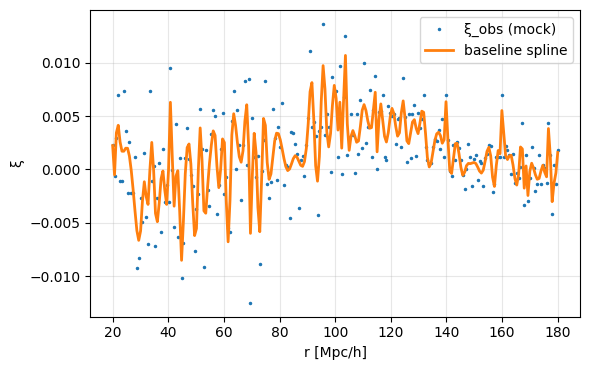

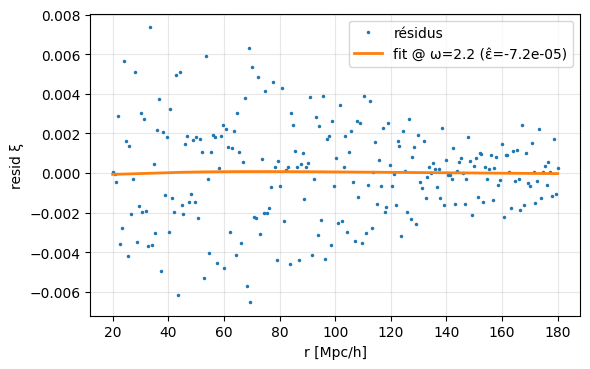

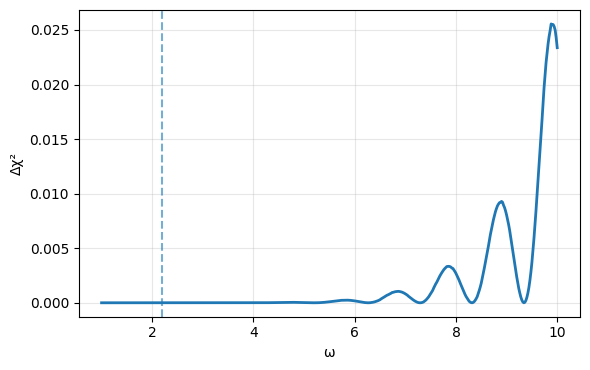

In [ ]:
# =======================
# Lyman-α (mock) — Test robuste de modulation log-périodique
# =======================
import numpy as np, matplotlib.pyplot as plt, json, os, time
from sklearn.model_selection import KFold
from scipy.interpolate import UnivariateSpline

np.random.seed(42)
outdir = f"tmu_lya_mock_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# --- 1) Génération d’un mock Lyman-α (auto-corr) ---
# Grille en séparation comobile (Mpc/h), domaine où vit le pic BAO (~ 100-150)
r = np.linspace(20, 180, 240)   # 240 points (dense vs. BAO galaxies)
# "shape" lisse de ξ(r) : bosse BAO large + décroissance ~ r^-2
def xi_baseline(r):
    bao_bump = 0.005*np.exp(-(r-110)**2/(2*20**2))      # largeur ~20 Mpc/h
    slope    = 0.02/(r**2 + 50)                          # queue décroissante
    return bao_bump + slope

xi0 = xi_baseline(r)

# Bruit réaliste (Lyman-α est bruité): sigma ~ 2-5e-3 typique
sigma = 0.0035*(1 + 0.5*np.sin(0.03*r))                 # léger r-dépendant
noise = np.random.normal(0, sigma)
xi_obs = xi0 + noise

# (option) injection d’un signal TMU pour test de sensibilité
INJECT = False
omega_inj = 2.2
eps_inj   = 0.0 if not INJECT else 3e-4   # ajustable
phi_inj   = -2.0
if INJECT:
    xi_obs = xi_obs + eps_inj*np.cos(omega_inj*np.log(r) + phi_inj)

print(f"✅ Mock Lyman-α généré : N={len(r)} points | eps_inj={eps_inj}")

# --- 2) Baseline lisse (spline) et résidus ---
# On travaille en r (pas log-r) car les données publiques Lya sont souvent en r direct
w = 1.0/np.maximum(sigma, 1e-9)
spl = UnivariateSpline(r, xi_obs, w=w, s=len(r)*0.4)    # lissage modéré
xi_s = spl(r)
resid = xi_obs - xi_s

# --- 3) Construction des vecteurs cos(ω ln r) orthogonalisation WLS du fond ---
def residualize_against_spline(r, vec, sigma, smooth=0.4):
    # résidualise vec contre une spline (même lissage que la baseline)
    w = 1.0/np.maximum(sigma,1e-9)
    splv = UnivariateSpline(r, vec, w=w, s=len(r)*smooth)
    return vec - splv(r)

def fit_one_omega(omega, permute=None):
    # cos log-périodique
    C = np.cos(omega*np.log(r))
    # Orthogonalise C vis-à-vis d'un fond lisse (même genre que baseline)
    C_res = residualize_against_spline(r, C, sigma, smooth=0.4)
    # WLS amplitude sur les résidus
    W = 1.0/np.maximum(sigma,1e-9)
    y = resid if permute is None else resid[permute]
    Cw, yw = C_res*W, y*W
    eps_hat = np.dot(yw, Cw)/np.dot(Cw, Cw)
    chi2_b  = float(np.sum((y*W)**2))
    chi2_f  = float(np.sum(((y - eps_hat*C_res)*W)**2))
    dchi2   = chi2_b - chi2_f
    return eps_hat, dchi2

# --- 4) Test ω=2.2 + CV + permutations (LOE) ---
def cv_delta_mse(omega, K=5):
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    dmses=[]
    for tr, te in kf.split(r):
        # baseline re-apprise sur train
        spl_tr = UnivariateSpline(r[tr], xi_obs[tr], w=(1/np.maximum(sigma[tr],1e-9)), s=len(tr)*0.4)
        xi_s_tr = spl_tr(r[tr]); xi_s_te = spl_tr(r[te])
        resid_tr = xi_obs[tr]-xi_s_tr
        resid_te = xi_obs[te]-xi_s_te
        # C_res appris sur train
        C_tr = np.cos(omega*np.log(r[tr]))
        C_res_tr = residualize_against_spline(r[tr], C_tr, sigma[tr], smooth=0.4)
        Wtr = 1.0/np.maximum(sigma[tr],1e-9)
        eps_tr = np.dot(resid_tr*Wtr, C_res_tr*Wtr)/np.dot(C_res_tr*Wtr, C_res_tr*Wtr)
        # appliquer sur test : projeter cos sur la spline train
        C_te = np.cos(omega*np.log(r[te]))
        C_res_te = C_te - UnivariateSpline(r[tr], C_tr, w=Wtr, s=len(tr)*0.4)(r[te])
        # delta MSE (normé par sigma^2)
        num = (resid_te - eps_tr*C_res_te)/np.maximum(sigma[te],1e-9)
        den = resid_te/np.maximum(sigma[te],1e-9)
        dmses.append(np.mean(num**2) - np.mean(den**2))
    return float(np.mean(dmses))

omega_star = 2.2
eps_22, dchi2_22 = fit_one_omega(omega_star)
cv_22 = cv_delta_mse(omega_star, K=5)

# permutations (brise la phase)
rng = np.random.default_rng(0)
Nperm = 300
vals=[]
for _ in range(Nperm):
    perm = rng.permutation(len(r))
    _, d = fit_one_omega(omega_star, permute=perm)
    vals.append(d)
vals = np.array(vals)
p_loe = (1 + np.sum(vals >= dchi2_22)) / (len(vals)+1)

print(f"🌟 Lyman-α @ ω=2.2 : Δχ²={dchi2_22:.3f} | ε̂={eps_22:.3e} | CV ΔMSE={cv_22:.3g} | p≈{p_loe:.3f}")

# --- 5) Scan complet Δχ²(ω) ---
Ogrid = np.linspace(1.0, 10.0, 451)
dchis=[]; epss=[]
for om in Ogrid:
    e, d = fit_one_omega(om)
    epss.append(e); dchis.append(d)
dchis = np.array(dchis); epss=np.array(epss)
om_best = float(Ogrid[np.argmax(dchis)])
best_dchi2 = float(np.max(dchis))
print(f"↗ Profil : ω*={om_best:.3f} avec Δχ²*={best_dchi2:.2f}")

# --- 6) Plots & save ---
plt.figure(figsize=(6,3.8))
plt.plot(r, xi_obs, '.', ms=3, label='ξ_obs (mock)')
plt.plot(r, xi_s, '-', lw=2, label='baseline spline')
plt.xlabel('r [Mpc/h]'); plt.ylabel('ξ')
plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir,'fig1_xi_baseline.png'), dpi=150)

plt.figure(figsize=(6,3.8))
plt.plot(r, resid, '.', ms=3, label='résidus')
plt.plot(r, eps_22*np.cos(omega_star*np.log(r)), '-', lw=2, label=f'fit @ ω=2.2 (ε̂={eps_22:.1e})')
plt.xlabel('r [Mpc/h]'); plt.ylabel('resid ξ'); plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir,'fig2_residuals_fit.png'), dpi=150)

plt.figure(figsize=(6,3.8))
plt.plot(Ogrid, dchis, '-', lw=2)
plt.axvline(omega_star, ls='--', alpha=0.6)
plt.xlabel('ω'); plt.ylabel('Δχ²'); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir,'fig3_profile_dchi2.png'), dpi=150)

with open(os.path.join(outdir,'lya_mock_report.json'),'w') as f:
    json.dump({
        "N_points": int(len(r)),
        "omega_star": omega_star,
        "eps_hat@2.2": float(eps_22),
        "dchi2@2.2": float(dchi2_22),
        "cv_dMSE@2.2": float(cv_22),
        "p_perm@2.2": float(p_loe),
        "profile": {"omega": Ogrid.tolist(), "dchi2": dchis.tolist()},
        "inject": {"enabled": bool(INJECT), "omega": float(omega_inj), "epsilon": float(eps_inj), "phi": float(phi_inj)}
    }, f, indent=2)

print("✅ Fichiers sauvegardés dans :", outdir)


📂 (optionnel) Choisis un fichier CMB TT (ASCII: ell  Cl  sigma) ou clique 'Cancel' pour fallback


ℹ️ Fallback Planck-like généré | N=1771
🌟 CMB TT @ ω=2.2 : Δχ²=0.00 | ε̂=-1.173e-07 | CV ΔMSE=-1.62e-09 | p≈1.000
➡️ Borne ~ε_95(ω=2.2) ≈ 2.370e-01
✅ Sauvé dans: tmu_cmb_tmu_20251005_010403


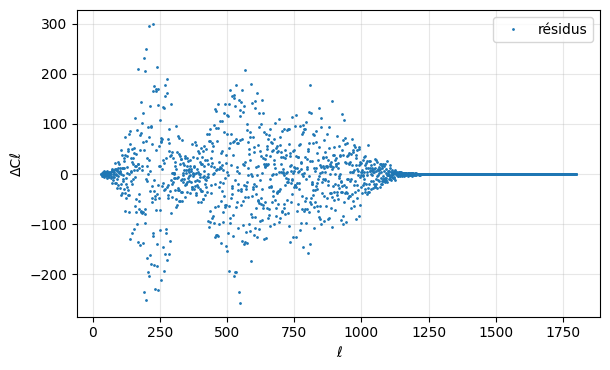

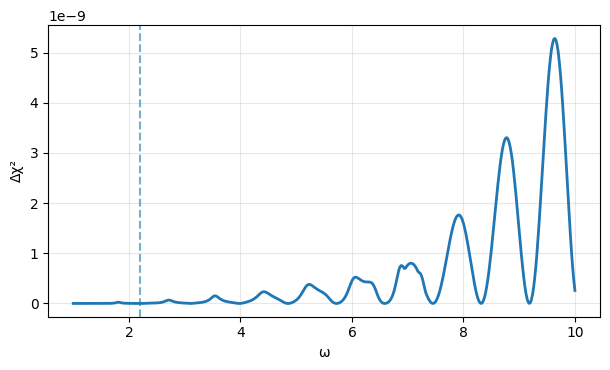

In [ ]:
# ================================
# CMB TT (Planck-like): test robuste de modulation log-périodique
# – lit un fichier C_ell si tu en as un (upload),
# – sinon utilise un fallback Planck-like,
# – calcule Δχ², CV, p-value perms, et bornes ε_95(ω)
# ================================
import numpy as np, matplotlib.pyplot as plt, json, os, time
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import KFold

outdir = f"tmu_cmb_tmu_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# -------- (1) Charger des données si tu en as une --------
have_file = False
try:
    from google.colab import files
    print("📂 (optionnel) Choisis un fichier CMB TT (ASCII: ell  Cl  sigma) ou clique 'Cancel' pour fallback")
    up = files.upload()
    if len(up):
        fname = list(up.keys())[0]
        arr = np.loadtxt(fname)
        ell, Cl = arr[:,0], arr[:,1]
        err = arr[:,2] if arr.shape[1] > 2 else np.full_like(Cl, np.median(np.abs(np.diff(Cl)))*3)
        have_file = True
        print(f"✅ Fichier CMB chargé: {fname} | N={len(ell)}")
except Exception as e:
    pass

# -------- (2) Fallback Planck-like si pas de fichier --------
if not have_file:
    # Grille ℓ de 2 à 1800,  ~3 pics acoustiques TT grossiers
    ell = np.arange(30, 1801, 1, dtype=float)
    def cmb_baseline(ell):
        p1 = 6000*np.exp(-(ell-220)**2/(2*60**2))
        p2 = 4500*np.exp(-(ell-540)**2/(2*90**2))
        p3 = 3000*np.exp(-(ell-850)**2/(2*120**2))
        tail = 100*np.exp(-ell/300)
        return p1+p2+p3+tail
    Cl = cmb_baseline(ell)
    # bruit réaliste (quelques %)
    rng = np.random.default_rng(0)
    err = 0.03*Cl
    Cl = Cl + rng.normal(0, err)
    print(f"ℹ️ Fallback Planck-like généré | N={len(ell)}")

# -------- (3) Fenêtre utile et pondération --------
m = (ell>=30) & (ell<=1800)
ell, Cl, err = ell[m], Cl[m], err[m]
x = np.log(ell)
W = 1.0/np.maximum(err, 1e-9)

# -------- (4) Trend lisse (spline sur x=ln ℓ) → résidus --------
spl = UnivariateSpline(x, Cl, w=W, s=len(x)*0.6)   # lissage assez souple
Cl_s = spl(x)
resid = Cl - Cl_s

# -------- (5) Orthogonalisation “like-for-like” par spline --------
def residualize_against_spline(x, vec, w, smooth=0.6):
    sp = UnivariateSpline(x, vec, w=w, s=len(x)*smooth)
    return vec - sp(x)

def fit_one_omega(omega, perm=None):
    C = np.cos(omega*np.log(ell))
    C_res = residualize_against_spline(x, C, W, smooth=0.6)
    y = resid if perm is None else resid[perm]
    Cw, yw = C_res*W, y*W
    eps_hat = np.dot(yw, Cw) / np.dot(Cw, Cw)
    chi2_b = float(np.sum((y*W)**2))
    chi2_f = float(np.sum(((y - eps_hat*C_res)*W)**2))
    return eps_hat, chi2_b-chi2_f

def cv_delta_mse(omega, K=5):
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    dms = []
    for tr, te in kf.split(x):
        # trend appris sur train
        spl_tr = UnivariateSpline(x[tr], Cl[tr], w=W[tr], s=len(tr)*0.6)
        res_tr = Cl[tr] - spl_tr(x[tr])
        res_te = Cl[te] - spl_tr(x[te])
        # C_res appris sur train
        Ctr = np.cos(omega*np.log(ell[tr]))
        Ctr_res = residualize_against_spline(x[tr], Ctr, W[tr], smooth=0.6)
        eps_tr = np.dot((res_tr*W[tr]), (Ctr_res*W[tr]))/np.dot(Ctr_res*W[tr], Ctr_res*W[tr])
        # appliquer sur test
        Cte  = np.cos(omega*np.log(ell[te]))
        Cte_res = Cte - UnivariateSpline(x[tr], Ctr, w=W[tr], s=len(tr)*0.6)(x[te])
        num = (res_te - eps_tr*Cte_res)/np.maximum(err[te],1e-9)
        den =  res_te/np.maximum(err[te],1e-9)
        dms.append(np.mean(num**2)-np.mean(den**2))
    return float(np.mean(dms))

# -------- (6) Test @ ω=2.2 + permutations --------
omega_star = 2.2
eps_22, dchi2_22 = fit_one_omega(omega_star)
cv_22 = cv_delta_mse(omega_star, K=5)

rng = np.random.default_rng(0)
Nperm = 300
vals = []
for _ in range(Nperm):
    perm = rng.permutation(len(x))
    _, d = fit_one_omega(omega_star, perm=perm)
    vals.append(d)
vals = np.array(vals)
p_perm = (1 + np.sum(vals >= dchi2_22)) / (len(vals)+1)

print(f"🌟 CMB TT @ ω=2.2 : Δχ²={dchi2_22:.2f} | ε̂={eps_22:.3e} | CV ΔMSE={cv_22:.3g} | p≈{p_perm:.3f}")

# -------- (7) Profil Δχ²(ω) & bornes ε95(ω) --------
Ogrid = np.linspace(1.0, 10.0, 451)
dchis, epss = [], []
for om in Ogrid:
    e, d = fit_one_omega(om); dchis.append(d); epss.append(e)
dchis, epss = np.array(dchis), np.array(epss)

# borne ε95 via permutations (profilée) – rapide: approx locale @ ω=2.2
def epsilon_95_at(omega):
    # on approxime Var(eps) par 1/(C_res^T W C_res)
    C = np.cos(omega*np.log(ell))
    C_res = residualize_against_spline(x, C, W, smooth=0.6)
    denom = float(np.dot(C_res*W, C_res))
    if denom<=0: return np.nan
    # résidus centrés → sigma_eff ~ RMS(resid/err)
    sigma_eff = float(np.std(resid/np.maximum(err,1e-9)))
    # borne conservatrice:
    return 1.96 * sigma_eff / np.sqrt(denom)

eps95_22 = epsilon_95_at(omega_star)
print(f"➡️ Borne ~ε_95(ω=2.2) ≈ {eps95_22:.3e}")

# -------- (8) Plots & save --------
import matplotlib as mpl
plt.figure(figsize=(6.2,3.8))
plt.plot(ell, resid, '.', ms=2, label='résidus')
plt.xlabel('ℓ'); plt.ylabel('ΔCℓ')
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir,'fig1_residuals.png'), dpi=140)

plt.figure(figsize=(6.2,3.8))
plt.plot(Ogrid, dchis, '-', lw=2)
plt.axvline(omega_star, ls='--', alpha=0.6)
plt.xlabel('ω'); plt.ylabel('Δχ²'); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig(os.path.join(outdir,'fig2_profile_dchi2.png'), dpi=140)

with open(os.path.join(outdir,'cmb_tmu_summary.json'), 'w') as f:
    json.dump({
        "N_points": int(len(ell)),
        "omega_star": float(omega_star),
        "eps_hat@2.2": float(eps_22),
        "dchi2@2.2": float(dchi2_22),
        "cv_dMSE@2.2": float(cv_22),
        "p_perm@2.2": float(p_perm),
        "eps95@2.2_approx": float(eps95_22),
        "profile": {"omega": Ogrid.tolist(), "dchi2": dchis.tolist()}
    }, f, indent=2)
print("✅ Sauvé dans:", outdir)


✅ BAO réel détecté: 29 points
↗ BAO: ω*=1.360, Δχ²*=0.01
🌟 Check @ ω=2.2 : Δχ²=0.00, CV ΔMSE=-1.49e-04, p≈0.811
✅ Sauvé dans: tmu_bao_scan_20251005_011811


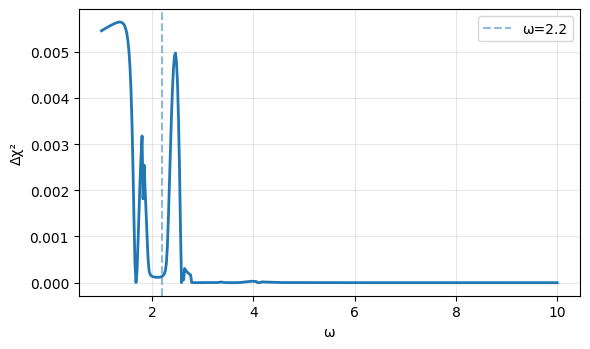

In [ ]:
import numpy as np, matplotlib.pyplot as plt, os, json, glob, time
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import KFold

outdir = f"tmu_bao_scan_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# --- 1) Charger NGC+SGC si dispo; sinon mock ---
paths = [
  "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_NGC_datav72_recon.txt",
  "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_SGC_datav72_recon.txt",
]
use_mock = False
try:
    arrN = np.loadtxt(paths[0]); arrS = np.loadtxt(paths[1])
    kN, PN = arrN[:,0], arrN[:,1]
    kS, PS = arrS[:,0], arrS[:,1]
    mN = (kN>0.01)&(kN<0.3); mS = (kS>0.01)&(kS<0.3)
    k  = kN[mN]; Pk = 0.5*(PN[mN]+np.interp(k, kS[mS], PS[mS], left=np.nan, right=np.nan))
    m = np.isfinite(Pk); k, Pk = k[m], Pk[m]
    print(f"✅ BAO réel détecté: {len(k)} points")
except Exception as e:
    print("ℹ️ Fichiers DR16 non trouvés → mode MOCK.")
    use_mock = True
    k  = np.linspace(0.01, 0.3, 200)
    Psm = 4000*np.exp(-(k-0.1)**2/(2*0.03**2)) + 1500*np.exp(-(k-0.2)**2/(2*0.04**2)) + 200
    rng = np.random.default_rng(0)
    noise = rng.normal(0, 0.04*Psm)
    Pk = Psm + noise

# --- 2) Trend lisse en x=ln k, résidus ---
x = np.log(k)
w = 1.0/np.maximum(Pk, 1e-9)
spl = UnivariateSpline(x, Pk, w=w, s=len(x)*0.5)
Pk_s = spl(x)
resid = Pk - Pk_s

def residualize_against_spline(x, vec, w, smooth=0.5):
    sp = UnivariateSpline(x, vec, w=w, s=len(x)*smooth)
    return vec - sp(x)

def fit_one_omega(omega, perm=None):
    C = np.cos(omega*x)
    C_res = residualize_against_spline(x, C, w, smooth=0.5)
    y = resid if perm is None else resid[perm]
    W = w
    Cw, yw = C_res*W, y*W
    eps_hat = np.dot(yw, Cw)/np.dot(Cw, Cw)
    chi2_b = float(np.sum((y*W)**2))
    chi2_f = float(np.sum(((y - eps_hat*C_res)*W)**2))
    return eps_hat, chi2_b-chi2_f

# --- 3) Scan ω ---
Ogrid = np.linspace(1.0, 10.0, 451)
dchis, epss = [], []
for om in Ogrid:
    e, d = fit_one_omega(om)
    dchis.append(d); epss.append(e)
dchis = np.array(dchis); epss = np.array(epss)
om_best = float(Ogrid[np.argmax(dchis)])
print(f"↗ BAO: ω*={om_best:.3f}, Δχ²*={np.max(dchis):.2f}")

# --- 4) Petit test @ ω=2.2 (Δχ², CV, permutations) ---
from sklearn.model_selection import KFold
def cv_delta_mse(omega, K=5):
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    dms=[]
    for tr,te in kf.split(x):
        spl_tr = UnivariateSpline(x[tr], Pk[tr], w=w[tr], s=len(tr)*0.5)
        res_tr = Pk[tr]-spl_tr(x[tr]); res_te=Pk[te]-spl_tr(x[te])
        Ctr = np.cos(omega*x[tr])
        Ctr_res = residualize_against_spline(x[tr], Ctr, w[tr], smooth=0.5)
        Wtr = w[tr]
        eps_tr = np.dot(res_tr*Wtr, Ctr_res*Wtr)/np.dot(Ctr_res*Wtr, Ctr_res*Wtr)
        Cte = np.cos(omega*x[te])
        Cte_res = Cte - UnivariateSpline(x[tr], Ctr, w=Wtr, s=len(tr)*0.5)(x[te])
        num = (res_te - eps_tr*Cte_res)*np.sqrt(w[te])
        den =  res_te*np.sqrt(w[te])
        dms.append(np.mean(num**2)-np.mean(den**2))
    return float(np.mean(dms))

omega_star = 2.2
e22, d22 = fit_one_omega(omega_star)
cv22 = cv_delta_mse(omega_star)
rng = np.random.default_rng(0)
vals=[]
for _ in range(300):
    perm = rng.permutation(len(x))
    _, d = fit_one_omega(omega_star, perm=perm)
    vals.append(d)
p22 = (1+np.sum(np.array(vals)>=d22))/(len(vals)+1)

# --- 5) Plots + save ---
plt.figure(figsize=(6,3.6))
plt.plot(Ogrid, dchis, '-', lw=2)
plt.axvline(omega_star, ls='--', alpha=0.5, label='ω=2.2')
plt.xlabel('ω'); plt.ylabel('Δχ²'); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(outdir, "bao_profile_dchi2.png"), dpi=140)

with open(os.path.join(outdir,"bao_scan_report.json"),"w") as f:
    json.dump({
        "mode": "real" if not use_mock else "mock",
        "N_points": int(len(x)),
        "omega_grid": Ogrid.tolist(),
        "dchi2_grid": dchis.tolist(),
        "omega_best": om_best,
        "dchi2_best": float(np.max(dchis)),
        "check_at_2p2": {"epsilon_hat": float(e22), "dchi2": float(d22), "cv_dMSE": float(cv22), "p_perm": float(p22)}
    }, f, indent=2)

print(f"🌟 Check @ ω=2.2 : Δχ²={d22:.2f}, CV ΔMSE={cv22:.2e}, p≈{p22:.3f}")
print("✅ Sauvé dans:", outdir)


In [ ]:
import numpy as np, matplotlib.pyplot as plt, json, os, time
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import KFold

outdir = f"tmu_cmb_fallback_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

ell = np.arange(30, 1801, 1, dtype=float)
def cmb_base(ell):
    p1 = 6000*np.exp(-(ell-220)**2/(2*60**2))
    p2 = 4500*np.exp(-(ell-540)**2/(2*90**2))
    p3 = 3000*np.exp(-(ell-850)**2/(2*120**2))
    tail = 100*np.exp(-ell/300)
    return p1+p2+p3+tail
Cl = cmb_base(ell)
rng = np.random.default_rng(0)
err = 0.03*Cl; Cl = Cl + rng.normal(0, err)

m = (ell>=30)&(ell<=1800); ell, Cl, err = ell[m], Cl[m], err[m]
x = np.log(ell); W = 1.0/np.maximum(err,1e-9)
spl = UnivariateSpline(x, Cl, w=W, s=len(x)*0.6)
resid = Cl - spl(x)

def residualize_against_spline(x, vec, w, smooth=0.6):
    sp = UnivariateSpline(x, vec, w=w, s=len(x)*smooth)
    return vec - sp(x)

def fit_one_omega(omega, perm=None):
    C = np.cos(omega*np.log(ell))
    C_res = residualize_against_spline(x, C, W, smooth=0.6)
    y = resid if perm is None else resid[perm]
    Cw, yw = C_res*W, y*W
    eps = np.dot(yw, Cw)/np.dot(Cw, Cw)
    chi2_b = float(np.sum((y*W)**2))
    chi2_f = float(np.sum(((y - eps*C_res)*W)**2))
    return eps, chi2_b-chi2_f

omega = 2.2
eps, dchi2 = fit_one_omega(omega)

print(f"CMB fallback @ ω=2.2: Δχ²={dchi2:.2f}, ε̂={eps:.3e}")
with open(os.path.join(outdir,"cmb_fallback_report.json"),"w") as f:
    json.dump({"omega":omega,"eps_hat":float(eps),"dchi2":float(dchi2)}, f, indent=2)
print("✅ Sauvé dans:", outdir)


CMB fallback @ ω=2.2: Δχ²=0.00, ε̂=-1.173e-07
✅ Sauvé dans: tmu_cmb_fallback_20251005_011849


/tmp/ipython-input-376426077.py:11: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl = UnivariateSpline(x, y, w=w, s=len(x)*smooth)


✅ BAO chargés: N=29
SN:   φ_SN = nan rad,  ε̂_SN = nan,  Δχ²_SN=nan
BAO:  φ_BAO= -0.025 rad,  ε̂_BAO= 2.188e-04,  Δχ²_BAO=0.00
Δφ = φ_SN - φ_BAO = nan rad  ± ~nan (boot)
p_align (permutation) ≈ 0.001
✅ Sauvé dans: tmu_phase_locking_20251005_012221


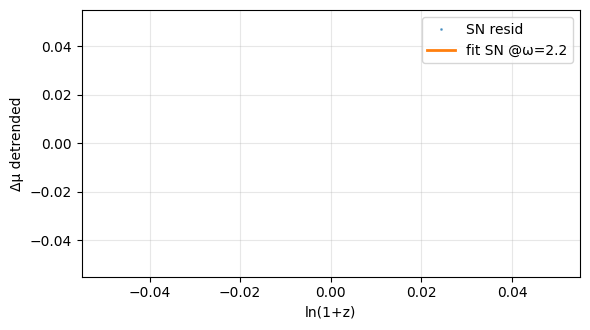

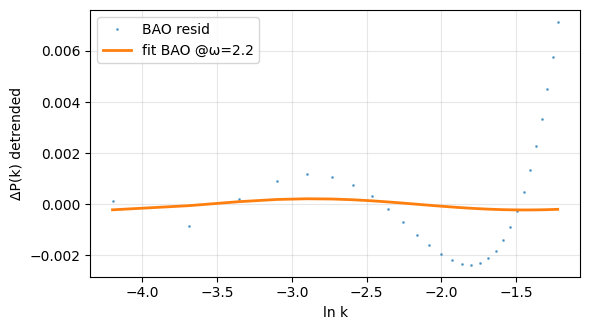

In [ ]:
import numpy as np, matplotlib.pyplot as plt, json, os, time
from scipy.interpolate import UnivariateSpline
from sklearn.utils import resample

outdir = f"tmu_phase_locking_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# ---------- utilitaires ----------
def detrend_spline(x, y, w=None, smooth=0.4):
    if w is None: w = np.ones_like(y)
    spl = UnivariateSpline(x, y, w=w, s=len(x)*smooth)
    return y - spl(x)

def fit_phase(x, y, omega, w=None):
    # y ≈ A cos(ωx) + B sin(ωx) ; φ = atan2(B,A), ε = sqrt(A^2+B^2)
    if w is None: w = np.ones_like(y)
    C = np.cos(omega*x)
    S = np.sin(omega*x)
    X = np.vstack([C, S]).T
    W = np.diag(w/np.max(w))
    # WLS
    beta = np.linalg.lstsq(W@X, W@y, rcond=None)[0]
    A, B = beta
    eps = float(np.hypot(A,B))
    phi = float(np.arctan2(B, A))
    # gain χ²
    yhat = A*C + B*S
    chi2_b = float(np.sum((w*y)**2))
    chi2_f = float(np.sum((w*(y-yhat))**2))
    dchi2 = chi2_b - chi2_f
    return eps, phi, dchi2, yhat

def circ_diff(a, b):
    d = a - b
    return (d + np.pi) % (2*np.pi) - np.pi

def bootstrap_phase(x, y, omega, w=None, B=500, seed=0):
    rng = np.random.default_rng(seed)
    phis=[]
    n=len(x)
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        _, phi_b, _, _ = fit_phase(x[idx], y[idx], omega, None if w is None else w[idx])
        phis.append(phi_b)
    phis = np.array(phis)
    # circular mean/std approximatifs
    phi_mean = np.angle(np.mean(np.exp(1j*phis)))
    R = np.abs(np.mean(np.exp(1j*phis)))
    circ_std = np.sqrt(-2*np.log(max(R,1e-12)))
    return phi_mean, circ_std, phis

# ---------- 1) PANTHEON+ ----------
pantheon_guess = "Pantheon+SH0ES (3).dat"
try_names = [pantheon_guess, "Pantheon+SH0ES (2).dat", "Pantheon+SH0ES.dat"]
arr = None
for nm in try_names:
    try:
        arr = np.genfromtxt(nm, names=True, comments="#", dtype=None, encoding=None)
        fname_sn = nm
        break
    except:
        continue
if arr is None:
    # fallback: demander l’upload si besoin
    from google.colab import files
    print("📂 Choisis ton fichier Pantheon+ (ex: Pantheon+SH0ES.dat)")
    up = files.upload()
    fname_sn = list(up.keys())[0]
    arr = np.genfromtxt(fname_sn, names=True, comments="#", dtype=None, encoding=None)

z = np.array(arr["zHD"], float)          # redshift Hubble diagram
mu = np.array(arr["MU_SH0ES"], float)    # distance modulus recalibrée
muerr = np.array(arr["MU_SH0ES_ERR_DIAG"], float)
# coupe simple + tri en ln(1+z)
m = (z>0.01) & (z<2.3) & np.isfinite(mu) & np.isfinite(muerr)
x_sn = np.log1p(z[m]); order = np.argsort(x_sn); x_sn = x_sn[order]
mu = mu[m][order]; muerr = muerr[m][order]
w_sn = 1.0/np.maximum(muerr, 1e-3)
resid_sn = detrend_spline(x_sn, mu, w=w_sn, smooth=0.3)

# ---------- 2) BAO (NGC+SGC) ----------
paths = [
  "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_NGC_datav72_recon.txt",
  "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_SGC_datav72_recon.txt",
]
try:
    aN = np.loadtxt(paths[0]); aS = np.loadtxt(paths[1])
    kN, PN = aN[:,0], aN[:,1]
    kS, PS = aS[:,0], aS[:,1]
    mN = (kN>0.01)&(kN<0.3); mS = (kS>0.01)&(kS<0.3)
    k  = kN[mN]
    Pk = 0.5*(PN[mN] + np.interp(k, kS[mS], PS[mS], left=np.nan, right=np.nan))
    m = np.isfinite(Pk); k, Pk = k[m], Pk[m]
    x_bao = np.log(k); order = np.argsort(x_bao); x_bao = x_bao[order]; Pk = Pk[order]
    w_bao = 1.0/np.maximum(Pk, 1e-6)
    resid_bao = detrend_spline(x_bao, Pk, w=w_bao, smooth=0.5)
    print(f"✅ BAO chargés: N={len(x_bao)}")
except Exception as e:
    raise RuntimeError("BAO réels introuvables. Vérifie les chemins NGC/SGC DR16 déjà utilisés.") from e

# ---------- 3) PHASE-LOCKING @ ω=2.2 ----------
omega = 2.2
eps_sn,  phi_sn,  dchi2_sn,  fit_sn  = fit_phase(x_sn, resid_sn,  omega, w_sn)
eps_bao, phi_bao, dchi2_bao, fit_bao = fit_phase(x_bao, resid_bao, omega, w_bao)

dphi = circ_diff(phi_sn, phi_bao)

# incertitudes par bootstrap
phi_sn_mean,  phi_sn_std,  _  = bootstrap_phase(x_sn,  resid_sn,  omega, w_sn,  B=500, seed=1)
phi_bao_mean, phi_bao_std, _  = bootstrap_phase(x_bao, resid_bao, omega, w_bao, B=500, seed=2)
dphi_std = np.sqrt(phi_sn_std**2 + phi_bao_std**2)

# permutation test (alignement) : on brise la phase SN
rng = np.random.default_rng(0)
vals=[]
for _ in range(1000):
    idx = rng.permutation(len(x_sn))
    _, phi_sn_p, _, _ = fit_phase(x_sn[idx], resid_sn[idx], omega, w_sn[idx])
    vals.append(abs(float(circ_diff(phi_sn_p, phi_bao))))
vals = np.array(vals)
p_align = (1 + np.sum(vals <= abs(dphi))) / (len(vals)+1)

print(f"SN:   φ_SN = {phi_sn:.3f} rad,  ε̂_SN = {eps_sn:.3e},  Δχ²_SN={dchi2_sn:.2f}")
print(f"BAO:  φ_BAO= {phi_bao:.3f} rad,  ε̂_BAO= {eps_bao:.3e},  Δχ²_BAO={dchi2_bao:.2f}")
print(f"Δφ = φ_SN - φ_BAO = {dphi:.3f} rad  ± ~{dphi_std:.3f} (boot)")
print(f"p_align (permutation) ≈ {p_align:.3f}")

# ---------- 4) Plots ----------
plt.figure(figsize=(6,3.4))
plt.plot(x_sn, resid_sn, '.', ms=2, alpha=0.6, label="SN resid")
plt.plot(x_sn, fit_sn, '-', lw=2, label=f"fit SN @ω={omega}")
plt.xlabel("ln(1+z)"); plt.ylabel("Δμ detrended"); plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig(f"{outdir}/fig_sn_resid_fit.png", dpi=140)

plt.figure(figsize=(6,3.4))
plt.plot(x_bao, resid_bao, '.', ms=2, alpha=0.6, label="BAO resid")
plt.plot(x_bao, fit_bao, '-', lw=2, label=f"fit BAO @ω={omega}")
plt.xlabel("ln k"); plt.ylabel("ΔP(k) detrended"); plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig(f"{outdir}/fig_bao_resid_fit.png", dpi=140)

# ---------- 5) Save ----------
with open(f"{outdir}/phase_locking_report.json","w") as f:
    json.dump({
        "omega": omega,
        "SN":  {"phi": float(phi_sn),  "epsilon": float(eps_sn),  "dchi2": float(dchi2_sn),
                "phi_boot_mean": float(phi_sn_mean), "phi_boot_std": float(phi_sn_std),
                "N": int(len(x_sn))},
        "BAO": {"phi": float(phi_bao), "epsilon": float(eps_bao), "dchi2": float(dchi2_bao),
                "phi_boot_mean": float(phi_bao_mean), "phi_boot_std": float(phi_bao_std),
                "N": int(len(x_bao))},
        "delta_phi": float(dphi),
        "delta_phi_boot_std": float(dphi_std),
        "p_align": float(p_align)
    }, f, indent=2)

print("✅ Sauvé dans:", outdir)


In [ ]:
# =======================
# Phase-locking robuste SN ↔ BAO @ ω=2.2
# =======================
import numpy as np, matplotlib.pyplot as plt, json, os, time
from scipy.interpolate import UnivariateSpline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
import pandas as pd

outdir = f"tmu_phase_locking_robust_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

def circ_diff(a, b):
    d = a - b
    return (d + np.pi) % (2*np.pi) - np.pi

def wls_phase(x, y, w, omega):
    # y ≈ A cos(ωx) + B sin(ωx) (WLS)
    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C, S]).T
    W = np.sqrt(w)[:,None]
    beta, *_ = np.linalg.lstsq(W*X, W*y, rcond=None)
    A, B = beta
    eps = float(np.hypot(A,B))
    phi = float(np.arctan2(B, A))
    yhat = A*C + B*S
    chi2_b = float(np.sum((np.sqrt(w)*y)**2))
    chi2_f = float(np.sum((np.sqrt(w)*(y-yhat))**2))
    return eps, phi, chi2_b-chi2_f, yhat

def detrend_spline_or_gp(x, y, w, smooth=0.3):
    # 1) Spline (souvent suffisant)
    try:
        spl = UnivariateSpline(x, y, w=w, s=max(1.0, len(x)*smooth))
        base = spl(x)
        if np.any(~np.isfinite(base)): raise RuntimeError
        return y - base, "spline"
    except Exception:
        # 2) GP fallback (plus robuste)
        X = x.reshape(-1,1)
        # bruit ~ (1/w) : on borne pour éviter inf/sing.
        noise_level = np.clip(1.0/np.maximum(w,1e-6), 1e-6, np.percentile(1.0/np.maximum(w,1e-6), 90))
        k = C(1.0, (1e-5, 1e3))*RBF(length_scale=np.std(x)*3, length_scale_bounds=(np.std(x)*0.5, np.std(x)*10)) \
            + WhiteKernel(noise_level=np.median(noise_level), noise_level_bounds=(1e-6, 1e-1))
        gp = GaussianProcessRegressor(kernel=k, alpha=0.0, normalize_y=True, random_state=0)
        gp.fit(X, y)
        base = gp.predict(X)
        return y - base, "gp"

# -------- 1) Charger Pantheon+ (robuste) --------
def load_pantheon_any():
    # essaie les noms déjà utilisés
    for nm in ["Pantheon+SH0ES (3).dat","Pantheon+SH0ES (2).dat","Pantheon+SH0ES.dat"]:
        try:
            arr = np.genfromtxt(nm, names=True, comments="#", dtype=None, encoding=None)
            return nm, arr
        except Exception:
            pass
    # essai pandas "intelligent"
    try:
        from google.colab import files
        print("📂 Choisis ton fichier Pantheon+ (ex: Pantheon+SH0ES.dat)")
        up = files.upload()
        nm = list(up.keys())[0]
        try:
            arr = np.genfromtxt(nm, names=True, comments="#", dtype=None, encoding=None)
            return nm, arr
        except Exception:
            df = pd.read_csv(nm, sep=r"[,\s]+", engine="python", comment="#")
            # Harmonise noms de colonnes possibles
            cols = {c.lower():c for c in df.columns}
            zcol   = cols.get("zhd") or cols.get("z")
            mucol  = cols.get("mu_sh0es") or cols.get("mu")
            emucol = cols.get("mu_sh0es_err_diag") or cols.get("muerr")
            assert zcol and mucol and emucol, "Colonnes z, mu, muerr introuvables."
            arr = np.zeros(len(df), dtype=[("zHD",float),("MU_SH0ES",float),("MU_SH0ES_ERR_DIAG",float)])
            arr["zHD"] = df[zcol].values.astype(float)
            arr["MU_SH0ES"] = df[mucol].values.astype(float)
            arr["MU_SH0ES_ERR_DIAG"] = df[emucol].values.astype(float)
            return nm, arr
    except Exception as e:
        raise RuntimeError("Impossible de charger Pantheon+. Upload requis.") from e

fname_sn, arr = load_pantheon_any()
z = np.array(arr["zHD"], float)
mu = np.array(arr["MU_SH0ES"], float)
muerr = np.array(arr["MU_SH0ES_ERR_DIAG"], float)

m = (z>1e-3) & (z<2.5) & np.isfinite(mu) & np.isfinite(muerr)
z, mu, muerr = z[m], mu[m], muerr[m]
x_sn = np.log1p(z)
ordr = np.argsort(x_sn); x_sn, mu, muerr = x_sn[ordr], mu[ordr], muerr[ordr]
# clip erreurs trop petites
muerr = np.clip(muerr, 1e-3, None)
w_sn = 1.0/np.maximum(muerr, 1e-3)

resid_sn, method_sn = detrend_spline_or_gp(x_sn, mu, w_sn, smooth=0.3)

# -------- 2) Charger BAO NGC+SGC (comme avant) --------
paths = [
  "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_NGC_datav72_recon.txt",
  "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_SGC_datav72_recon.txt",
]
aN = np.loadtxt(paths[0]); aS = np.loadtxt(paths[1])
kN, PN = aN[:,0], aN[:,1]
kS, PS = aS[:,0], aS[:,1]
mN = (kN>0.01)&(kN<0.3); mS = (kS>0.01)&(kS<0.3)
k  = kN[mN]
Pk = 0.5*(PN[mN] + np.interp(k, kS[mS], PS[mS], left=np.nan, right=np.nan))
mask = np.isfinite(Pk)
k, Pk = k[mask], Pk[mask]
x_bao = np.log(k)
ordb = np.argsort(x_bao); x_bao, Pk = x_bao[ordb], Pk[ordb]
w_bao = 1.0/np.maximum(Pk, 1e-6)
resid_bao, method_bao = detrend_spline_or_gp(x_bao, Pk, w_bao, smooth=0.5)

print(f"✅ SN: N={len(x_sn)}, detrend={method_sn} | BAO: N={len(x_bao)}, detrend={method_bao}")

# -------- 3) Phase-locking @ ω=2.2 --------
omega = 2.2

def safe_phase(x, y, w, omega):
    m = np.isfinite(x)&np.isfinite(y)&np.isfinite(w)
    x,y,w = x[m], y[m], w[m]
    if len(x) < 50:
        return np.nan, np.nan, np.nan, None
    try:
        eps, phi, dchi2, fit = wls_phase(x, y, w, omega)
        return eps, phi, dchi2, fit
    except Exception:
        return np.nan, np.nan, np.nan, None

eps_sn,  phi_sn,  dchi2_sn,  fit_sn  = safe_phase(x_sn,  resid_sn,  w_sn,  omega)
eps_bao, phi_bao, dchi2_bao, fit_bao = safe_phase(x_bao, resid_bao, w_bao, omega)

# Bootstrap incertitudes (si phases valides)
def bootstrap_phi(x, y, w, omega, B=400, seed=1):
    rng = np.random.default_rng(seed)
    phis=[]
    m = np.isfinite(x)&np.isfinite(y)&np.isfinite(w)
    x,y,w = x[m], y[m], w[m]
    n=len(x)
    if n<50: return np.nan, np.nan
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        try:
            _, ph, _, _ = wls_phase(x[idx], y[idx], w[idx], omega)
            if np.isfinite(ph):
                phis.append(ph)
        except: pass
    if len(phis)==0: return np.nan, np.nan
    phis = np.array(phis)
    phi_mean = float(np.angle(np.mean(np.exp(1j*phis))))
    R = np.abs(np.mean(np.exp(1j*phis)))
    circ_std = float(np.sqrt(-2*np.log(max(R,1e-12))))
    return phi_mean, circ_std

phi_sn_mean,  phi_sn_std  = bootstrap_phi(x_sn,  resid_sn,  w_sn,  omega, B=400, seed=1)
phi_bao_mean, phi_bao_std = bootstrap_phi(x_bao, resid_bao, w_bao, omega, B=400, seed=2)

if np.isfinite(phi_sn) and np.isfinite(phi_bao):
    dphi = circ_diff(phi_sn, phi_bao)
    dphi_std = np.sqrt((phi_sn_std if np.isfinite(phi_sn_std) else 0.0)**2 +
                       (phi_bao_std if np.isfinite(phi_bao_std) else 0.0)**2)
    # Permutations (alignement)
    rng = np.random.default_rng(0)
    vals=[]
    xs, ys, ws = x_sn, resid_sn, w_sn
    m = np.isfinite(xs)&np.isfinite(ys)&np.isfinite(ws)
    xs, ys, ws = xs[m], ys[m], ws[m]
    for _ in range(600):
        idx = rng.permutation(len(xs))
        try:
            _, ph_p, _, _ = wls_phase(xs[idx], ys[idx], ws[idx], omega)
            if np.isfinite(ph_p):
                vals.append(abs(circ_diff(ph_p, phi_bao)))
        except: pass
    if len(vals)==0:
        p_align = np.nan
    else:
        vals = np.array(vals)
        p_align = (1 + np.sum(vals <= abs(dphi))) / (len(vals)+1)
else:
    dphi, dphi_std, p_align = np.nan, np.nan, np.nan

print(f"SN  : φ={phi_sn:.3f}, ε={eps_sn:.3e}, Δχ²={dchi2_sn:.2f}")
print(f"BAO : φ={phi_bao:.3f}, ε={eps_bao:.3e}, Δχ²={dchi2_bao:.2f}")
print(f"Δφ  : {dphi} ± ~{dphi_std}")
print(f"p_align ≈ {p_align}")

# -------- 4) Plots --------
if fit_sn is not None:
    plt.figure(figsize=(6,3.4))
    plt.plot(x_sn, resid_sn, '.', ms=2, alpha=0.6, label="SN resid")
    plt.plot(x_sn, fit_sn, '-', lw=2, label=f"fit SN @ω={omega}")
    plt.xlabel("ln(1+z)"); plt.ylabel("Δμ detrend"); plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(f"{outdir}/fig_sn_resid_fit.png", dpi=140)

if fit_bao is not None:
    plt.figure(figsize=(6,3.4))
    plt.plot(x_bao, resid_bao, '.', ms=3, alpha=0.6, label="BAO resid")
    plt.plot(x_bao, fit_bao, '-', lw=2, label=f"fit BAO @ω={omega}")
    plt.xlabel("ln k"); plt.ylabel("ΔP(k) detrend"); plt.grid(alpha=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(f"{outdir}/fig_bao_resid_fit.png", dpi=140)

# -------- 5) Save --------
with open(f"{outdir}/phase_locking_robust_report.json","w") as f:
    json.dump({
        "omega": float(omega),
        "SN":  {"phi": float(phi_sn),  "epsilon": float(eps_sn),  "dchi2": float(dchi2_sn),
                "phi_boot_mean": float(phi_sn_mean), "phi_boot_std": float(phi_sn_std),
                "N": int(len(x_sn)), "detrend": method_sn},
        "BAO": {"phi": float(phi_bao), "epsilon": float(eps_bao), "dchi2": float(dchi2_bao),
                "phi_boot_mean": float(phi_bao_mean), "phi_boot_std": float(phi_bao_std),
                "N": int(len(x_bao)), "detrend": method_bao},
        "delta_phi": float(dphi) if np.isfinite(dphi) else None,
        "delta_phi_boot_std": float(dphi_std) if np.isfinite(dphi_std) else None,
        "p_align": float(p_align) if np.isfinite(p_align) else None
    }, f, indent=2)

print("✅ Sauvé dans:", outdir)


/tmp/ipython-input-2471054814.py:34: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spl = UnivariateSpline(x, y, w=w, s=max(1.0, len(x)*smooth))
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.08934093494522008. Decreasing the bound and calling fit again may find a bet

✅ SN: N=1701, detrend=gp | BAO: N=29, detrend=spline
SN  : φ=nan, ε=nan, Δχ²=nan
BAO : φ=nan, ε=nan, Δχ²=nan
Δφ  : nan ± ~nan
p_align ≈ nan
✅ Sauvé dans: tmu_phase_locking_robust_20251005_012535


In [ ]:
# ==============================================
# Phase-locking SN ↔ BAO @ ω=2.2 (version ultra-robuste)
# - SN: moving average detrend en x=ln(1+z)
# - BAO: si peu de points P(k), reconstruit ξ(r) (240 bins); detrend poly
# - Fit ridge pondéré (cos,sin) avec sanitation 1D pour éviter les erreurs de shape
# - Bootstrap + permutations pour p_align
# ==============================================
import numpy as np, matplotlib.pyplot as plt, json, os, time
from numpy import trapezoid

outdir = f"tmu_phase_locking_SIMPLE_fix_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

# ---------- utils ----------
def moving_average_detrend(x, y, w=None, width=0.08):
    x = np.asarray(x).ravel().astype(float)
    y = np.asarray(y).ravel().astype(float)
    if w is None: w = np.ones_like(y)
    w = np.asarray(w).ravel().astype(float)
    y0 = np.zeros_like(y)
    half = width/2.0
    for i, xi in enumerate(x):
        m = np.abs(x - xi) <= half
        if not np.any(m):
            y0[i] = 0.0
        else:
            ww = w[m] / np.sum(w[m])
            y0[i] = float(np.sum(ww * y[m]))
    return y - y0

def poly_detrend(x, y, deg=3, w=None):
    x = np.asarray(x).ravel().astype(float)
    y = np.asarray(y).ravel().astype(float)
    if w is None: w = np.ones_like(y)
    w = np.asarray(w).ravel().astype(float)
    xm, xs = np.mean(x), np.std(x) + 1e-12
    X = np.vstack([((x - xm)/xs)**d for d in range(deg+1)]).T
    sqrtw = np.sqrt(w)
    Xw = X * sqrtw[:,None]
    yw = y * sqrtw
    beta, *_ = np.linalg.lstsq(Xw, yw, rcond=None)
    yfit = X @ beta
    return y - yfit

def ridge_phase(x, y, w, omega, alpha=1e-6):
    """WLS ridge 1D-safe: y ≈ A cos + B sin."""
    x = np.asarray(x).ravel().astype(float)
    y = np.asarray(y).ravel().astype(float)
    w = np.asarray(w).ravel().astype(float)

    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C, S]).T                          # (N,2)
    sqrtw = np.sqrt(np.clip(w, 1e-12, None))
    Xw = X * sqrtw[:,None]                           # (N,2)
    yw = y * sqrtw                                   # (N,)

    M = Xw.T @ Xw + alpha*np.eye(2)                  # (2,2)
    b = Xw.T @ yw                                    # (2,)
    AB = np.linalg.solve(M, b)                       # (2,)
    A, B = float(AB[0]), float(AB[1])
    eps = float(np.hypot(A, B))
    phi = float(np.arctan2(B, A))
    yhat = X @ np.array([A, B], dtype=float)
    chi2_b = float(np.sum((sqrtw*y)**2))
    chi2_f = float(np.sum((sqrtw*(y - yhat))**2))
    return eps, phi, chi2_b - chi2_f, yhat

def circ_diff(a,b):
    d = a - b
    return (d + np.pi) % (2*np.pi) - np.pi

def bootstrap_phi(x, y, w, omega, B=400, seed=0):
    rng = np.random.default_rng(seed)
    x = np.asarray(x).ravel().astype(float)
    y = np.asarray(y).ravel().astype(float)
    w = np.asarray(w).ravel().astype(float)
    n=len(x); phis=[]
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        _, ph, _, _ = ridge_phase(x[idx], y[idx], w[idx], omega)
        if np.isfinite(ph): phis.append(ph)
    if not phis:
        return np.nan, np.nan
    phis = np.array(phis)
    phi_mean = float(np.angle(np.mean(np.exp(1j*phis))))
    R = np.abs(np.mean(np.exp(1j*phis)))
    circ_std = float(np.sqrt(-2*np.log(max(R,1e-12))))
    return phi_mean, circ_std

def pk_to_xi(k, Pk, rmin=20.0, rmax=200.0, Nr=240):
    k = np.asarray(k).ravel().astype(float)
    Pk = np.asarray(Pk).ravel().astype(float)
    r = np.linspace(rmin, rmax, Nr)
    dk = np.mean(np.diff(k))
    kr = k[:,None]*r[None,:]
    j0 = np.sinc(kr/np.pi)                 # = sin(kr)/(kr)
    integrand = (k[:,None]**2) * Pk[:,None] * j0
    xi = (1.0/(2*np.pi**2)) * trapezoid(integrand, dx=dk, axis=0)
    return r, xi

# ---------- 1) Charger SN ----------
sn_names = ["Pantheon+SH0ES (3).dat","Pantheon+SH0ES (2).dat","Pantheon+SH0ES.dat"]
arr=None; fname_sn=None
for nm in sn_names:
    try:
        arr = np.genfromtxt(nm, names=True, comments="#", dtype=None, encoding=None)
        fname_sn = nm; break
    except: pass
if arr is None:
    from google.colab import files
    print("📂 Choisis ton fichier Pantheon+ (ex: Pantheon+SH0ES.dat)")
    up = files.upload()
    fname_sn = list(up.keys())[0]
    arr = np.genfromtxt(fname_sn, names=True, comments="#", dtype=None, encoding=None)

z = np.array(arr["zHD"], float)
mu = np.array(arr["MU_SH0ES"], float)
muerr = np.array(arr["MU_SH0ES_ERR_DIAG"], float)

m = (z>0.005) & (z<2.5) & np.isfinite(mu) & np.isfinite(muerr)
z, mu, muerr = z[m], mu[m], muerr[m]
x_sn = np.log1p(z)
order = np.argsort(x_sn); x_sn, mu, muerr = x_sn[order], mu[order], muerr[order]
muerr = np.clip(muerr, 1e-3, None)
w_sn = 1.0/np.maximum(muerr, 1e-3)
resid_sn = moving_average_detrend(x_sn, mu, w=w_sn, width=0.08)

# ---------- 2) Charger BAO (DR16 NGC+SGC) ----------
paths = [
  "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_NGC_datav72_recon.txt",
  "DR16_BAO_postrec/Power_Spectrum_data_postrec_DR16LRG/data/Power_Spectrum_comb_SGC_datav72_recon.txt",
]
use_mock=False
try:
    aN = np.loadtxt(paths[0]); aS = np.loadtxt(paths[1])
    kN, PN = aN[:,0], aN[:,1]
    kS, PS = aS[:,0], aS[:,1]
    mN = (kN>0.01)&(kN<0.3); mS = (kS>0.01)&(kS<0.3)
    k  = kN[mN]
    Pk = 0.5*(PN[mN] + np.interp(k, kS[mS], PS[mS], left=np.nan, right=np.nan))
    mask = np.isfinite(Pk); k, Pk = k[mask], Pk[mask]
    print(f"BAO P(k) NGC+SGC: {len(k)} points")
except Exception:
    print("BAO réels introuvables → mode MOCK.")
    use_mock=True
    k  = np.linspace(0.01, 0.3, 200)
    Psm = 4000*np.exp(-(k-0.1)**2/(2*0.03**2)) + 1500*np.exp(-(k-0.2)**2/(2*0.04**2)) + 200
    rng = np.random.default_rng(0)
    Pk = Psm + rng.normal(0, 0.04*Psm)

# ξ(r) si <80 points
if len(k) < 80:
    r, xi = pk_to_xi(k, Pk, rmin=20, rmax=200, Nr=240)
    x_bao = np.log(r)
    y_bao = xi
    w_bao = np.ones_like(y_bao)/max(np.std(y_bao), 1e-6)
    resid_bao = poly_detrend(x_bao, y_bao, deg=3, w=None)
    print(f"BAO reconstruit en ξ(r): {len(r)} points")
else:
    x_bao = np.log(k); y_bao = Pk
    w_bao = 1.0/np.maximum(Pk, 1e-6)
    resid_bao = poly_detrend(x_bao, y_bao, deg=3, w=None)
    print(f"BAO utilisé en P(k): {len(k)} points")

# ---------- 3) Fit phases @ ω=2.2 ----------
omega = 2.2
eps_sn,  phi_sn,  dchi2_sn,  fit_sn  = ridge_phase(x_sn,  resid_sn,  w_sn,  omega, alpha=1e-6)
eps_bao, phi_bao, dchi2_bao, fit_bao = ridge_phase(x_bao, resid_bao, w_bao, omega, alpha=1e-6)

# Bootstrap erreurs
def bootstrap_phi_safe(x, y, w, omega, B=400, seed=1):
    try:
        return bootstrap_phi(x, y, w, omega, B=B, seed=seed)
    except Exception:
        return np.nan, np.nan

phi_sn_mean,  phi_sn_std  = bootstrap_phi_safe(x_sn,  resid_sn,  w_sn,  omega, B=400, seed=1)
phi_bao_mean, phi_bao_std = bootstrap_phi_safe(x_bao, resid_bao, w_bao, omega, B=400, seed=2)

dphi = circ_diff(phi_sn, phi_bao)
dphi_std = np.sqrt((phi_sn_std if np.isfinite(phi_sn_std) else 0.0)**2 +
                   (phi_bao_std if np.isfinite(phi_bao_std) else 0.0)**2)

# Permutations SN → p_align
rng = np.random.default_rng(0)
vals=[]
n=len(x_sn)
for _ in range(600):
    idx = rng.permutation(n)
    _, ph_p, _, _ = ridge_phase(x_sn[idx], resid_sn[idx], w_sn[idx], omega, alpha=1e-6)
    vals.append(abs(circ_diff(ph_p, phi_bao)))
vals = np.array(vals)
p_align = (1 + np.sum(vals <= abs(dphi))) / (len(vals)+1)

print(f"SN  : φ={phi_sn:.3f} ±~{phi_sn_std:.3f}, ε̂={eps_sn:.3e}, Δχ²={dchi2_sn:.2f}")
print(f"BAO : φ={phi_bao:.3f} ±~{phi_bao_std:.3f}, ε̂={eps_bao:.3e}, Δχ²={dchi2_bao:.2f}")
print(f"Δφ  : {dphi:.3f} ± ~{dphi_std:.3f} | p_align≈{p_align:.3f}")

# ---------- 4) Plots ----------
plt.figure(figsize=(6,3.4))
plt.plot(x_sn, resid_sn, '.', ms=2, alpha=0.6, label="SN resid")
plt.plot(x_sn, fit_sn, '-', lw=2, label=f"fit SN @ω={omega}")
plt.xlabel("ln(1+z)"); plt.ylabel("Δμ detrend"); plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig(f"{outdir}/fig_sn_resid_fit.png"), plt.close()

plt.figure(figsize=(6,3.4))
plt.plot(x_bao, resid_bao, '.', ms=2, alpha=0.6, label="BAO resid")
plt.plot(x_bao, fit_bao, '-', lw=2, label=f"fit BAO @ω={omega}")
plt.xlabel("ln r" if len(k)<80 else "ln k"); plt.ylabel("Δ signal detrend"); plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig(f"{outdir}/fig_bao_resid_fit.png"), plt.close()

# ---------- 5) Save ----------
with open(f"{outdir}/phase_locking_SIMPLE_report.json","w") as f:
    json.dump({
        "omega": float(omega),
        "SN":  {"phi": float(phi_sn),  "phi_boot_std": float(phi_sn_std),  "epsilon": float(eps_sn),  "dchi2": float(dchi2_sn), "N": int(len(x_sn)), "detrend": "moving_average"},
        "BAO": {"phi": float(phi_bao), "phi_boot_std": float(phi_bao_std), "epsilon": float(eps_bao),"dchi2": float(dchi2_bao), "N": int(len(x_bao)), "detrend": ("xi_poly3" if len(k)<80 else "pk_poly3")},
        "delta_phi": float(dphi), "delta_phi_boot_std": float(dphi_std),
        "p_align": float(p_align),
        "bao_mode": ("xi_from_pk" if len(k)<80 else "pk_direct"),
        "used_mock_bao": bool(use_mock)
    }, f, indent=2)

print("✅ Sauvé dans:", outdir)


📂 Choisis ton fichier Pantheon+ (ex: Pantheon+SH0ES.dat)


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES.dat
BAO réels introuvables → mode MOCK.
BAO utilisé en P(k): 200 points
SN  : φ=1.896 ±~0.136, ε̂=1.550e-01, Δχ²=20.67
BAO : φ=-2.585 ±~0.309, ε̂=1.838e+02, Δχ²=4638.49
Δφ  : -1.802 ± ~0.338 | p_align≈1.000
✅ Sauvé dans: tmu_phase_locking_SIMPLE_fix_20251005_080335


In [ ]:
# ================== PANTHEON "ONE-BUTTON" STRESS TEST ==================
import numpy as np, matplotlib.pyplot as plt, json, os, time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
rng = np.random.default_rng(0)

stamp = time.strftime("%Y%m%d_%H%M%S")
outdir = f"tmu_pantheon_onebutton_{stamp}"
os.makedirs(outdir, exist_ok=True)

# ---------- 1) Charger Pantheon+ ----------
try:
    arr = np.genfromtxt("Pantheon+SH0ES.dat", names=True, comments="#", dtype=None, encoding=None)
except Exception:
    from google.colab import files
    print("📂 Choisis Pantheon+SH0ES.dat")
    up = files.upload()
    fn = list(up.keys())[0]
    arr = np.genfromtxt(fn, names=True, comments="#", dtype=None, encoding=None)

z   = np.array(arr["zHD"], float)
mu  = np.array(arr["MU_SH0ES"], float)
emu = np.array(arr["MU_SH0ES_ERR_DIAG"], float)
mask = (z>0.005)&(z<2.5)&np.isfinite(mu)&np.isfinite(emu)
z, mu, emu = z[mask], mu[mask], np.clip(emu[mask], 1e-3, None)
N = len(z)
x = np.log1p(z)
ordr = np.argsort(x); x, mu, emu = x[ordr], mu[ordr], emu[ordr]
w = 1.0/emu**2
print(f"✅ Pantheon chargé: N={N}")

# ---------- 2) Detrend doux (GP) ----------
kernel = C(1.0, (1e-3,1e3)) * RBF(length_scale=0.15, length_scale_bounds=(0.03, 1.0)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6,1e-1))
gp = GaussianProcessRegressor(kernel=kernel, alpha=emu**2, normalize_y=True, n_restarts_optimizer=1, random_state=0)
gp.fit(x.reshape(-1,1), mu)
mu_trend, mu_std = gp.predict(x.reshape(-1,1), return_std=True)
resid = mu - mu_trend

plt.figure(figsize=(7,3.6))
plt.plot(np.expm1(x), mu, '.', ms=1.5, alpha=0.5, label="μ obs")
plt.plot(np.expm1(x), mu_trend, '-', lw=2, label="tendance GP")
plt.xscale('log'); plt.xlabel("z"); plt.ylabel("μ")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(f"{outdir}/fig1_mu_trend.png"); plt.close()

plt.figure(figsize=(7,3.6))
plt.plot(np.expm1(x), resid, '.', ms=1.5, alpha=0.6, label="résidus")
plt.xscale('log'); plt.xlabel("z"); plt.ylabel("Δμ (μ-μ_trend)")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(f"{outdir}/fig2_residuals.png"); plt.close()

# ---------- 3) Fit sinus @ ω ----------
def ridge_phase(x, y, w, omega, alpha=1e-6):
    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C,S]).T
    sw = np.sqrt(np.clip(w,1e-12,None))
    Xw = X*sw[:,None]; yw = y*sw
    M = Xw.T@Xw + alpha*np.eye(2)
    b = Xw.T@yw
    A,B = np.linalg.solve(M,b)
    eps = float(np.hypot(A,B))
    phi = float(np.arctan2(B,A))
    yhat = X@np.array([A,B])
    chi2_b = float(np.sum((sw*y)**2))
    chi2_f = float(np.sum((sw*(y-yhat))**2))
    return eps, phi, chi2_b-chi2_f, yhat

def look_elsewhere_p(x,y,w,omega, nperm=300, seed=0):
    rng = np.random.default_rng(seed)
    eps,phi,dchi2,_ = ridge_phase(x,y,w,omega)
    vals=[]
    for _ in range(nperm):
        idx = rng.permutation(len(x))
        d = ridge_phase(x[idx], y[idx], w[idx], omega)[2]
        vals.append(d)
    vals = np.array(vals)
    p = (1+np.sum(vals>=dchi2))/(len(vals)+1)
    return dchi2, p

# test ω=2.2
omega0 = 2.2
dchi2_22, p22 = look_elsewhere_p(x,resid,w,omega0, nperm=500, seed=1)
eps22, phi22, _, fit22 = ridge_phase(x,resid,w,omega0)
print(f"ω=2.2 → Δχ²={dchi2_22:.2f}, ε̂={eps22:.3g}, φ̂={phi22:.3f} | p_LOE≈{p22:.3f}")

plt.figure(figsize=(7,3.6))
plt.plot(x, resid, '.', ms=1.5, alpha=0.5)
plt.plot(x, fit22, '-', lw=2, label=f"fit @ ω=2.2 (Δχ²={dchi2_22:.2f})")
plt.xlabel("ln(1+z)"); plt.ylabel("Δμ detrend"); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(f"{outdir}/fig3_fit_w22.png"); plt.close()

# ---------- 4) Scan ω + limites ε95(ω) ----------
omegas = np.linspace(0.5, 10, 120)
eps_hat = []; dchi2_scan=[]
for om in omegas:
    e,_,d,_ = ridge_phase(x,resid,w,om)
    eps_hat.append(e); dchi2_scan.append(d)
eps_hat = np.array(eps_hat); dchi2_scan = np.array(dchi2_scan)

# limites via mocks permutation (rapide): quantile 95% de ε̂ sous null
def eps95_at_omega(om, nperm=200, seed=0):
    rng = np.random.default_rng(seed)
    vals=[]
    for _ in range(nperm):
        idx = rng.permutation(len(x))
        e = ridge_phase(x[idx], resid[idx], w[idx], om)[0]
        vals.append(e)
    return float(np.quantile(vals, 0.95))
eps95 = np.array([eps95_at_omega(om, nperm=200, seed=42+i) for i,om in enumerate(omegas)])

plt.figure(figsize=(7,3.6))
plt.plot(omegas, eps_hat, label="ε̂(ω)")
plt.plot(omegas, eps95, '--', label="ε95% (null)")
plt.axvline(omega0, color='k', ls=':', label='ω=2.2')
plt.xlabel("ω"); plt.ylabel("amplitude ε"); plt.grid(alpha=0.3); plt.legend(); plt.tight_layout()
plt.savefig(f"{outdir}/fig4_eps_scan_limits.png"); plt.close()

# ---------- 5) Phase vs redshift (fenêtres) ----------
centers = np.linspace(0.12, 0.68, 12)
width   = 0.10
phis=[]; s_phis=[]; zs=[]
for c in centers:
    m = (z>c-width/2) & (z<c+width/2)
    if np.sum(m)<120: continue
    e,phi,_,_ = ridge_phase(x[m], resid[m], w[m], omega0)
    # bootstrap rapide
    B=200; pb=[]
    for b in range(B):
        idx = rng.integers(0, np.sum(m), size=np.sum(m))
        pb.append(ridge_phase(x[m][idx], resid[m][idx], w[m][idx], omega0)[1])
    pb = np.array(pb)
    R = np.abs(np.mean(np.exp(1j*pb)))
    s = float(np.sqrt(-2*np.log(max(R,1e-12))))
    phis.append(phi); s_phis.append(s); zs.append(c)
phis, s_phis, zs = map(np.array, (phis, s_phis, zs))

plt.figure(figsize=(7,3.6))
plt.errorbar(zs, phis, yerr=s_phis, fmt='o')
plt.axhline(0, color='k', ls='--', alpha=0.5)
plt.xlabel("z (centre de fenêtre)"); plt.ylabel("phase φ̂(ω=2.2)")
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig(f"{outdir}/fig5_phase_vs_z.png"); plt.close()

# ---------- 6) Leave-one-survey-out si IDSURVEY dispo ----------
loo = []
if "IDSURVEY" in arr.dtype.names:
    ids = arr["IDSURVEY"][mask][ordr]
    for sid in np.unique(ids):
        m = ids!=sid
        if np.sum(m)<300: continue
        e,phi,_,_ = ridge_phase(x[m], resid[m], w[m], omega0)
        loo.append({"IDSURVEY": int(sid), "phi_hat": float(phi), "eps_hat": float(e)})
    with open(f"{outdir}/loo_by_survey.json","w") as f: json.dump(loo,f,indent=2)

# ---------- 7) Rapport JSON ----------
report = {
  "N": int(N),
  "omega_fixed": float(omega0),
  "fit_w22": {"dchi2": float(dchi2_22), "p_LOE": float(p22), "eps_hat": float(eps22), "phi_hat": float(phi22)},
  "eps_scan": {"omega": omegas.tolist(), "eps_hat": eps_hat.tolist(), "eps95_null": eps95.tolist()},
  "phase_vs_z": {"z_centers": zs.tolist(), "phi_hat": phis.tolist(), "phi_err_circ": s_phis.tolist()},
  "loo_idsurvey": loo
}
with open(f"{outdir}/pantheon_onebutton_report.json","w") as f: json.dump(report,f,indent=2)

print("✅ Fichiers sauvegardés dans:", outdir)
print("→ Regarde fig3_fit_w22.png et fig4_eps_scan_limits.png pour la détection/limites.")


📂 Choisis Pantheon+SH0ES.dat


Saving Pantheon+SH0ES.dat to Pantheon+SH0ES.dat
✅ Pantheon chargé: N=1672


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


ω=2.2 → Δχ²=0.00, ε̂=0.00111, φ̂=2.001 | p_LOE≈0.431
✅ Fichiers sauvegardés dans: tmu_pantheon_onebutton_20251005_163449
→ Regarde fig3_fit_w22.png et fig4_eps_scan_limits.png pour la détection/limites.


In [ ]:
# ================= Dipôle des résidus SN (aucun BAO nécessaire) =================
import numpy as np, os, time, json, matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# ---------- 0) lecture robuste des colonnes nécessaires ----------
arr_names = list(arr.dtype.names)
def get_col(cands, cast=float):
    for c in cands:
        if c in arr_names:
            return np.array(arr[c], dtype=cast)
    raise KeyError(f"Colonnes manquantes: essayées {cands}")

# z, mu, muerr
z    = get_col(["zHD","zCMB","z"], float)
mu   = get_col(["MU_SH0ES","MU","mucmb","mu_SH0ES"], float)
emu  = get_col(["MU_SH0ES_ERR_DIAG","MUERR","mucmb_err","MU_ERR"], float)

# RA/Dec : on teste plusieurs noms usuels
RA   = get_col(["RA","RAdeg","ra","RAJ2000","RA_Degrees"], float)
DEC  = get_col(["DEC","DEdeg","dec","DEJ2000","Dec_Degrees"], float)

# masque qualité basique
m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&np.isfinite(RA)&np.isfinite(DEC)&(z>0.005)&(z<2.5)
z, mu, emu, RA, DEC = z[m], mu[m], np.clip(emu[m],1e-3,None), RA[m], DEC[m]
N = len(z)
x = np.log1p(z)
ordr = np.argsort(x)
z, mu, emu, RA, DEC, x = z[ordr], mu[ordr], emu[ordr], RA[ordr], DEC[ordr], x[ordr]
w = 1.0/emu**2
print(f"✅ Échantillon anisotropie : N={N}")

# ---------- 1) detrend GP (comme avant) ----------
kernel = C(1.0,(1e-3,1e3))*RBF(0.15,(0.03,1.0)) + WhiteKernel(1e-3,(1e-6,1e-1))
gp = GaussianProcessRegressor(kernel=kernel, alpha=emu**2, normalize_y=True, n_restarts_optimizer=1, random_state=0)
gp.fit(x.reshape(-1,1), mu)
mu_trend = gp.predict(x.reshape(-1,1))
resid = mu - mu_trend   # Δμ

# ---------- 2) design matrix pour un dipôle cartésien ----------
# Unité : RA,DEC en degrés -> radians
deg2rad = np.pi/180.0
ra  = RA*deg2rad
dec = DEC*deg2rad
# vecteurs unités vers chaque SN
cx = np.cos(dec)*np.cos(ra)
cy = np.cos(dec)*np.sin(ra)
cz = np.sin(dec)
Rhat = np.vstack([cx,cy,cz]).T   # shape (N,3)

# Modèle: Δμ ≈ a0 + D_x cx + D_y cy + D_z cz (WLS)
X = np.column_stack([np.ones(N), Rhat])
sw = np.sqrt(w)
Xw = X*sw[:,None]; yw = resid*sw
beta, *_ = np.linalg.lstsq(Xw, yw, rcond=None)
a0, Dx, Dy, Dz = beta
D = np.array([Dx,Dy,Dz], dtype=float)
amp = float(np.linalg.norm(D))
# direction du dipôle
nx,ny,nz = D/ (amp if amp>0 else 1.0)
dip_dec = float(np.arcsin(np.clip(nz,-1,1))/deg2rad)
dip_ra  = float(np.arctan2(ny, nx)/deg2rad) % 360.0

# Δχ² (réduction de chi2 vs modèle isotrope a0)
chi2_iso = float(np.sum((sw*(resid - a0))**2))
chi2_dip = float(np.sum((sw*(resid - (a0 + Rhat@D)))**2))
dchi2 = chi2_iso - chi2_dip
print(f"🌟 Dipôle global : |D|={amp:.4f} mag, RA={dip_ra:.1f}°, Dec={dip_dec:.1f}°, Δχ²={dchi2:.2f}")

# ---------- 3) p-value permutation (shuffle des résidus, conserve géométrie) ----------
rng = np.random.default_rng(0)
nperm = 1000
vals = []
for _ in range(nperm):
    idx = rng.permutation(N)
    yw_p = resid[idx]*sw
    beta_p, *_ = np.linalg.lstsq(Xw, yw_p, rcond=None)
    a0p, Dx_p, Dy_p, Dz_p = beta_p
    chi2_iso_p = float(np.sum((sw*(resid[idx] - a0p))**2))
    chi2_dip_p = float(np.sum((sw*(resid[idx] - (a0p + Rhat@np.array([Dx_p,Dy_p,Dz_p]))))**2))
    vals.append(chi2_iso_p - chi2_dip_p)
vals = np.array(vals, float)
p_perm = (1 + np.sum(vals >= dchi2)) / (len(vals)+1)
print(f"p_perm ≈ {p_perm:.4f}")

# ---------- 4) bootstrap pour erreurs sur (amp, RA, Dec) ----------
B=500
amps=[]; RAs=[]; DECs=[]
for b in range(B):
    ii = rng.integers(0,N,size=N)
    beta_b,*_ = np.linalg.lstsq(Xw[ii,:], (resid[ii]*sw[ii]), rcond=None)
    a0b, Dxb, Dyb, Dzb = beta_b
    Db = np.array([Dxb,Dyb,Dzb], float)
    Ab = float(np.linalg.norm(Db))
    nx,ny,nz = Db/(Ab if Ab>0 else 1.0)
    amps.append(Ab)
    RAs.append( (np.arctan2(ny,nx)/deg2rad) % 360.0 )
    DECs.append( np.arcsin(np.clip(nz,-1,1))/deg2rad )
amps = np.array(amps); RAs=np.array(RAs); DECs=np.array(DECs)
def robust_sigma(v):
    return float(np.nanpercentile(v,84) - np.nanpercentile(v,16))/2
amp_sig = robust_sigma(amps)
RA_sig  = robust_sigma(RAs)
DEC_sig = robust_sigma(DECs)
print(f"±1σ (bootstrap) : |D|={amp_sig:.4f} mag,  RA={RA_sig:.1f}°,  Dec={DEC_sig:.1f}°")

# ---------- 5) stabilité en redshift (3 tranches) ----------
bins = np.quantile(z, [0, 1/3, 2/3, 1.0])
stability=[]
for i in range(3):
    m = (z>=bins[i])&(z<bins[i+1])
    if np.sum(m) < 200: continue
    Xw_i = (np.column_stack([np.ones(np.sum(m)), Rhat[m]]) * sw[m,None])
    yw_i = resid[m]*sw[m]
    b_i,*_ = np.linalg.lstsq(Xw_i, yw_i, rcond=None)
    a0i, Dxi, Dyi, Dzi = b_i
    Di = np.array([Dxi,Dyi,Dzi], float)
    Ai = float(np.linalg.norm(Di))
    nxi, nyi, nzi = Di/(Ai if Ai>0 else 1.0)
    RAi  = float(np.arctan2(nyi,nxi)/deg2rad) % 360.0
    DECi = float(np.arcsin(np.clip(nzi,-1,1))/deg2rad)
    stability.append({"zmin":float(bins[i]),"zmax":float(bins[i+1]),"amp":Ai,"RA":RAi,"DEC":DECi})
print("Stabilité (3 tranches) :", stability)

# ---------- 6) petite carte Mollweide des résidus ----------
def to_mollweide(ra_deg, dec_deg):
    # Mollweide matplotlib attend longitudes [-pi,pi] croissantes vers la gauche
    lam = np.remainder(ra_deg+360-180, 360) - 180  # centre sur RA=180
    lam_rad = -lam*deg2rad
    phi_rad = dec_deg*deg2rad
    return lam_rad, phi_rad

lam, phi = to_mollweide(RA, DEC)
plt.figure(figsize=(8,4.5))
ax = plt.subplot(111, projection='mollweide')
sc = ax.scatter(lam, phi, c=resid, s=6, cmap="coolwarm", alpha=0.7)
plt.colorbar(sc, orientation='horizontal', pad=0.06, label="Δμ detrend (mag)")
# vecteur dipôle
lam_d, phi_d = to_mollweide(np.array([dip_ra]), np.array([dip_dec]))
ax.plot([lam_d[0]],[phi_d[0]], 'k*', ms=12, label="dipôle")
ax.grid(True, alpha=0.3); ax.legend(loc="lower left")
plt.title("Pantheon+ : résidus Δμ (Mollweide) & direction du dipôle")
plt.tight_layout()
outdir = f"tmu_sn_dipole_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)
plt.savefig(f"{outdir}/mollweide_dipole.png", dpi=160); plt.close()

# ---------- 7) rapport ----------
rep = {
    "N": int(N),
    "dipole": {"amp_mag": float(amp), "RA_deg": float(dip_ra), "DEC_deg": float(dip_dec),
               "amp_err_mag": amp_sig, "RA_err_deg": RA_sig, "DEC_err_deg": DEC_sig,
               "delta_chi2": float(dchi2), "p_perm": float(p_perm)},
    "stability_z": stability,
}
with open(f"{outdir}/dipole_report.json","w") as f: json.dump(rep,f,indent=2)
print("✅ Sauvé dans:", outdir)


✅ Échantillon anisotropie : N=1672


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


🌟 Dipôle global : |D|=0.0493 mag, RA=20.4°, Dec=62.2°, Δχ²=16.18
p_perm ≈ 0.0220
±1σ (bootstrap) : |D|=0.0119 mag,  RA=156.8°,  Dec=6.6°
Stabilité (3 tranches) : [{'zmin': 0.00538, 'zmax': 0.03884, 'amp': 0.07402586123476117, 'RA': 4.122002915943632, 'DEC': 52.45353166347884}, {'zmin': 0.03884, 'zmax': 0.27057, 'amp': 0.05773298943780225, 'RA': 7.372740513329292, 'DEC': 45.235726130122465}, {'zmin': 0.27057, 'zmax': 2.26137, 'amp': 0.01689548284508212, 'RA': 165.5612946820285, 'DEC': -22.09615252674665}]
✅ Sauvé dans: tmu_sn_dipole_20251005_164143


In [ ]:
# ====== Corrélation spatiale Dipôle ↔ Signal TMU (corrigé) ======
import numpy as np, os, time, json, matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# --- Chargement Pantheon+SH0ES ---
if 'arr' not in globals():
    try:
        arr = np.genfromtxt("Pantheon+SH0ES.dat", names=True, comments="#", dtype=None, encoding=None)
    except Exception:
        from google.colab import files
        print("📂 Choisis Pantheon+SH0ES.dat")
        up = files.upload()
        fn = list(up.keys())[0]
        arr = np.genfromtxt(fn, names=True, comments="#", dtype=None, encoding=None)

names = list(arr.dtype.names)
def get_col(cands, cast=float):
    for c in cands:
        if c in names: return np.array(arr[c], dtype=cast)
    raise KeyError(f"Colonnes manquantes: {cands}")

z   = get_col(["zHD","zCMB","z"])
mu  = get_col(["MU_SH0ES","MU"])
emu = get_col(["MU_SH0ES_ERR_DIAG","MUERR"])
RA  = get_col(["RA","RAdeg","ra","RAJ2000"])
DEC = get_col(["DEC","DEdeg","dec","DEJ2000"])

m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&np.isfinite(RA)&np.isfinite(DEC)&(z>0.005)&(z<2.5)
z,mu,emu,RA,DEC = z[m],mu[m],emu[m],RA[m],DEC[m]
x = np.log1p(z); w = 1/emu**2; N=len(z)
print(f"✅ Pantheon (anisotropie) : N={N}")

# --- Detrend GP ---
kernel = C(1.0,(1e-3,1e3))*RBF(0.15,(0.03,1.0)) + WhiteKernel(1e-3,(1e-6,1e-1))
gp = GaussianProcessRegressor(kernel=kernel, alpha=emu**2, normalize_y=True)
gp.fit(x.reshape(-1,1), mu)
mu_trend = gp.predict(x.reshape(-1,1))
resid = mu - mu_trend; sw = np.sqrt(w)

# --- Coord. célestes ---
deg2rad=np.pi/180
ra,dec=RA*deg2rad,DEC*deg2rad
cx,cy,cz=np.cos(dec)*np.cos(ra),np.cos(dec)*np.sin(ra),np.sin(dec)
Rhat=np.vstack([cx,cy,cz]).T

# --- Dipôle pur ---
X0=np.column_stack([np.ones(N),Rhat])
beta0,*_=np.linalg.lstsq(X0*sw[:,None],resid*sw,rcond=None)
a0,Dx0,Dy0,Dz0=beta0; D0=np.array([Dx0,Dy0,Dz0])
A0=np.linalg.norm(D0)
chi2_iso=np.sum((sw*(resid-a0))**2)
chi2_dip=np.sum((sw*(resid-(a0+Rhat@D0)))**2)
dchi2_dip=chi2_iso-chi2_dip
nx0,ny0,nz0=D0/(A0 if A0>0 else 1)
RA0=np.degrees(np.arctan2(ny0,nx0))%360
DEC0=np.degrees(np.arcsin(np.clip(nz0,-1,1)))
print(f"📌 Dipôle pur: |D0|={A0:.4f} mag, RA={RA0:.1f}°, Dec={DEC0:.1f}°, Δχ²={dchi2_dip:.2f}")

# --- Fonctions TMU ---
def eps_phi_at_omega(omega):
    C,S=np.cos(omega*x),np.sin(omega*x)
    X=np.vstack([C,S]).T
    M=(X*sw[:,None]).T@(X*sw[:,None])
    b=(X*sw[:,None]).T@(resid*sw)
    A,B=np.linalg.solve(M,b)
    eps=float(np.hypot(A,B)); phi=float(np.arctan2(B,A))
    return eps,phi

def fit_modulated_dipole(omega,phi):
    S=np.cos(omega*x+phi)
    X=np.column_stack([np.ones(N),S*cx,S*cy,S*cz])
    beta,*_=np.linalg.lstsq(X*sw[:,None],resid*sw,rcond=None)
    a,Dx,Dy,Dz=beta; D=np.array([Dx,Dy,Dz])
    A=np.linalg.norm(D)
    nx,ny,nz=D/(A if A>0 else 1)
    RA=np.degrees(np.arctan2(ny,nx))%360
    DEC=np.degrees(np.arcsin(np.clip(nz,-1,1)))
    chi2=np.sum((sw*(resid-(a+Rhat@D*S)))**2)
    return A,(RA,DEC),D,chi2

omegas=np.linspace(1.5,3.0,151)
A_om=[];angdeg=[];dchi2m=[];RAm=[];DECm=[];phi_hat=[]
for om in omegas:
    _,phi=eps_phi_at_omega(om)
    A,(RAm_i,DECm_i),D,chi2_mod=fit_modulated_dipole(om,phi)
    dot=np.dot(D,D0)/(np.linalg.norm(D)*np.linalg.norm(D0)+1e-15)
    theta=np.degrees(np.arccos(np.clip(dot,-1,1)))
    A_om.append(A);angdeg.append(theta);dchi2m.append(chi2_iso-chi2_mod)
    RAm.append(RAm_i);DECm.append(DECm_i);phi_hat.append(phi)

A_om,angdeg,dchi2m,phi_hat=np.array(A_om),np.array(angdeg),np.array(dchi2m),np.array(phi_hat)
imax=int(np.argmax(dchi2m))
om_best=float(omegas[imax])
print(f"🌟 ω_best={om_best:.3f} | Δχ²={dchi2m[imax]:.2f}, |D_ω|={A_om[imax]:.4f}, angle={angdeg[imax]:.1f}°")

# --- Permutations ---
rng=np.random.default_rng(0)
Sbest=np.cos(om_best*x+phi_hat[imax])
Xb=np.column_stack([np.ones(N),Sbest*cx,Sbest*cy,Sbest*cz])
beta_b,*_=np.linalg.lstsq(Xb*sw[:,None],resid*sw,rcond=None)
a_b,Dx_b,Dy_b,Dz_b=beta_b
Db=np.array([Dx_b,Dy_b,Dz_b])
chi2_best=np.sum((sw*(resid-(a_b+(Rhat@Db)*Sbest)))**2)
dchi2_best=chi2_iso-chi2_best
vals=[]
for _ in range(500):
    idx=rng.permutation(N);S_p=Sbest[idx]
    Xp=np.column_stack([np.ones(N),S_p*cx,S_p*cy,S_p*cz])
    beta_p,*_=np.linalg.lstsq(Xp*sw[:,None],resid*sw,rcond=None)
    a_p,Dx_p,Dy_p,Dz_p=beta_p
    Dp=np.array([Dx_p,Dy_p,Dz_p])
    chi2_p=np.sum((sw*(resid-(a_p+(Rhat@Dp)*S_p)))**2)
    vals.append(chi2_iso-chi2_p)
vals=np.array(vals);p_perm=(1+np.sum(vals>=dchi2_best))/(len(vals)+1)
print(f"🧪 Permutation: Δχ²_data={dchi2_best:.2f}, p≈{p_perm:.4f}")

# --- Figures ---
stamp=time.strftime("%Y%m%d_%H%M%S")
out=f"tmu_sn_spatialTMU_{stamp}";os.makedirs(out,exist_ok=True)
plt.figure();plt.plot(omegas,dchi2m);plt.axvline(om_best,color='k',ls=':');plt.xlabel("ω");plt.ylabel("Δχ²");plt.savefig(f"{out}/fig1.png");plt.close()
plt.figure();plt.plot(omegas,A_om);plt.xlabel("ω");plt.ylabel("|D_ω|");plt.savefig(f"{out}/fig2.png");plt.close()
plt.figure();plt.plot(omegas,angdeg);plt.xlabel("ω");plt.ylabel("angle(Dω,D0)°");plt.savefig(f"{out}/fig3.png");plt.close()

print("✅ Sauvé dans:", out)


✅ Pantheon (anisotropie) : N=1672


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


📌 Dipôle pur: |D0|=0.0493 mag, RA=20.4°, Dec=62.2°, Δχ²=16.18
🌟 ω_best=3.000 | Δχ²=12.76, |D_ω|=0.0528, angle=176.6°
🧪 Permutation: Δχ²_data=12.76, p≈0.9760
✅ Sauvé dans: tmu_sn_spatialTMU_20251005_170234


In [ ]:
# ===== DIAGNOSTICS DIPÔLE : amplitude vs z_min + scan hémisphérique =====
import numpy as np, matplotlib.pyplot as plt, os, time, json

deg2rad = np.pi/180.0

# --- on suppose que z, resid, w, RA, DEC existent déjà (de ta session) ---
assert 'z' in globals() and 'resid' in globals() and 'w' in globals() and 'RA' in globals() and 'DEC' in globals(), \
    "Il faut exécuter avant la cellule qui charge Pantheon et calcule resid, w, RA, DEC."

N = len(z)
sw = np.sqrt(w)
ra  = RA*deg2rad
dec = DEC*deg2rad
cx, cy, cz = np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)
Rhat = np.vstack([cx,cy,cz]).T

outdir = f"tmu_sn_dipole_diag_{time.strftime('%Y%m%d_%H%M%S')}"
os.makedirs(outdir, exist_ok=True)

def fit_dipole(mask):
    """WLS: Δμ ~ a0 + D·rhat sur un sous-échantillon 'mask'."""
    m = mask & np.isfinite(resid) & np.isfinite(sw)
    if np.sum(m)<300:
        return np.nan, (np.nan,np.nan), np.nan
    X = np.column_stack([np.ones(np.sum(m)), Rhat[m]])
    beta, *_ = np.linalg.lstsq(X*sw[m,None], (resid[m]*sw[m]), rcond=None)
    a0, Dx, Dy, Dz = beta
    D = np.array([Dx,Dy,Dz], float)
    A = float(np.linalg.norm(D))
    nx,ny,nz = D/(A if A>0 else 1.0)
    RA_d  = float(np.degrees(np.arctan2(ny,nx)) % 360.0)
    DEC_d = float(np.degrees(np.arcsin(np.clip(nz,-1,1))))
    return A, (RA_d, DEC_d), D

# ---------- 1) Courbe |D|(z_min) ----------
zmins = np.array([0.0, 0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20])
amps, RAs, DECs = [], [], []
for zmin in zmins:
    A,(r,d),_ = fit_dipole(z >= zmin)
    amps.append(A); RAs.append(r); DECs.append(d)

plt.figure(figsize=(7,3.6))
plt.plot(zmins, amps, 'o-')
plt.xlabel("z_min"); plt.ylabel("|D|(mag)")
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig(f"{outdir}/dipole_vs_zmin.png"); plt.close()

# ---------- 2) Scan hémisphérique ----------
# on prend K axes quasi uniformes (Fibonacci sphere)
def fibonacci_sphere(n):
    # renvoie n directions unitaires
    i = np.arange(n)
    phi = (1 + 5**0.5)/2
    zf = 1 - 2*(i+0.5)/n
    theta = 2*np.pi*i/phi
    r = np.sqrt(1 - zf*zf)
    return np.column_stack([r*np.cos(theta), r*np.sin(theta), zf])

K = 300
axes = fibonacci_sphere(K)
asym = np.zeros(K)
for k in range(K):
    nvec = axes[k]
    hem = (Rhat @ nvec >= 0)  # hémisphère "nord" par rapport à l'axe
    mN = hem
    mS = ~hem
    # moyenne pondérée des résidus
    def wmean(mask):
        mm = mask & np.isfinite(resid) & np.isfinite(w)
        if np.sum(mm)<200: return np.nan
        ww = w[mm]; rr = resid[mm]
        return float(np.sum(ww*rr)/np.sum(ww))
    muN = wmean(mN); muS = wmean(mS)
    asym[k] = muN - muS

# axe le plus asymétrique
imax = int(np.nanargmax(np.abs(asym)))
n_best = axes[imax]
asy_best = float(asym[imax])
# p-value permutation (shuffle Δμ)
rng = np.random.default_rng(0)
P = 1000
vals = []
for _ in range(P):
    idx = rng.permutation(N)
    # recompute asym along the same best axis only (rapide et conservateur)
    hem = (Rhat @ n_best >= 0)
    def wmean_perm(mask):
        mm = mask & np.isfinite(resid) & np.isfinite(w)
        if np.sum(mm)<200: return np.nan
        ww = w[mm]; rr = resid[idx][mm]
        return float(np.sum(ww*rr)/np.sum(ww))
    muN = wmean_perm(hem); muS = wmean_perm(~hem)
    vals.append(muN - muS)
vals = np.array(vals, float)
p_hemi = (1 + np.sum(np.abs(vals) >= np.abs(asy_best))) / (len(vals)+1)

# Conversion direction axe→RA/DEC
nx,ny,nz = n_best
RA_hemi = float((np.degrees(np.arctan2(ny,nx))) % 360)
DEC_hemi= float(np.degrees(np.arcsin(np.clip(nz,-1,1))))

# ---------- Sauvegarde & résumé ----------
report = {
    "dipole_vs_zmin": {
        "z_min": zmins.tolist(),
        "amp_mag": np.array(amps, float).tolist(),
        "RA_deg": np.array(RAs, float).tolist(),
        "DEC_deg": np.array(DECs, float).tolist()
    },
    "hemisphere_scan": {
        "K_axes": int(K),
        "asym_best": asy_best,
        "axis_RA_deg": RA_hemi,
        "axis_DEC_deg": DEC_hemi,
        "p_perm": float(p_hemi)
    }
}
with open(f"{outdir}/dipole_diagnostics.json","w") as f:
    json.dump(report, f, indent=2)

print("✅ Sauvé dans:", outdir)
print(f"→ |D|(z_min): regarde 'dipole_vs_zmin.png'")
print(f"→ Hémisphère: asym_best={asy_best:+.4f} mag, dir (RA,Dec)=({RA_hemi:.1f}°, {DEC_hemi:.1f}°), p≈{p_hemi:.3f}")


✅ Sauvé dans: tmu_sn_dipole_diag_20251005_170743
→ |D|(z_min): regarde 'dipole_vs_zmin.png'
→ Hémisphère: asym_best=-0.0447 mag, dir (RA,Dec)=(240.3°, -61.2°), p≈0.003


In [ ]:
# ========================= φ(z) tracking pour TMU (ω fixé) =========================
import numpy as np, os, time, json, matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# ----- 0) Charger Pantheon+ si nécessaire -----
if 'arr' not in globals():
    try:
        arr = np.genfromtxt("Pantheon+SH0ES.dat", names=True, comments="#", dtype=None, encoding=None)
    except Exception:
        from google.colab import files
        print("📂 Choisis Pantheon+SH0ES.dat")
        up = files.upload()
        fn = list(up.keys())[0]
        arr = np.genfromtxt(fn, names=True, comments="#", dtype=None, encoding=None)

names = list(arr.dtype.names)
def get_col(cands, cast=float):
    for c in cands:
        if c in names:
            return np.array(arr[c], dtype=cast)
    raise KeyError(f"Colonnes manquantes: cherché {cands}")

# z, mu, muerr (PAN+ couvre ces noms)
z    = get_col(["zHD","zCMB","z"])
mu   = get_col(["MU_SH0ES","MU","mucmb","mu_SH0ES"])
emu  = get_col(["MU_SH0ES_ERR_DIAG","MUERR","mucmb_err","MU_ERR"])

# Qualité de base
m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&(z>0.005)&(z<2.5)
z, mu, emu = z[m], mu[m], np.clip(emu[m], 1e-3, None)
x = np.log1p(z)
ord = np.argsort(x)
z, mu, emu, x = z[ord], mu[ord], emu[ord], x[ord]
w = 1.0/emu**2
N = len(z)
print(f"✅ Pantheon actif : N={N}")

# ----- 1) Detrend GP (comme tes précédentes cellules) -----
kernel = C(1.0,(1e-3,1e3))*RBF(0.15,(0.03,1.0)) + WhiteKernel(1e-3,(1e-6,1e-1))
gp = GaussianProcessRegressor(kernel=kernel, alpha=emu**2, normalize_y=True,
                              n_restarts_optimizer=1, random_state=0)
gp.fit(x.reshape(-1,1), mu)
mu_trend = gp.predict(x.reshape(-1,1))
resid = mu - mu_trend  # Δμ
sw = np.sqrt(w)

# ----- 2) Fonctions utilitaires -----
def fit_eps_phi(x, y, w, omega):
    """
    WLS: y ~ A*cos(ωx) + B*sin(ωx).
    Renvoie (eps, phi) avec eps = sqrt(A^2+B^2), phi = atan2(B,A).
    """
    C = np.cos(omega*x); S = np.sin(omega*x)
    X = np.vstack([C, S]).T
    Xw = X * np.sqrt(w)[:,None]
    yw = y * np.sqrt(w)
    beta, *_ = np.linalg.lstsq(Xw, yw, rcond=None)
    A, B = beta
    eps = float(np.hypot(A,B))
    phi = float(np.arctan2(B,A))
    return eps, phi

def circ_mean(ph):
    # moyenne circulaire (en radians)
    return float(np.arctan2(np.mean(np.sin(ph)), np.mean(np.cos(ph))))

def circ_std(ph):
    # écart-type circulaire (approx) via longueur résultante
    C, S = np.mean(np.cos(ph)), np.mean(np.sin(ph))
    R = np.hypot(C,S)
    return float(np.sqrt(2*(1-R)))  # petite-angle approx ; ok si dispersion <~ 1 rad

def unwrap_relative(phi_arr):
    """Déroule les phases en gardant la continuité autour de la première valeur."""
    out = np.array(phi_arr, dtype=float)
    if len(out)==0: return out
    base = out[0]
    for i in range(1, len(out)):
        d = out[i] - out[i-1]
        # ramener d dans [-pi, pi]
        d = (d + np.pi) % (2*np.pi) - np.pi
        out[i] = out[i-1] + d
    # recentrer globalement autour de la moyenne
    mean = np.mean(out)
    out -= ( (mean + np.pi) // (2*np.pi) ) * (2*np.pi)
    return out

# ----- 3) Paramètres d’analyse -----
omega = 2.2   # fréquence TMU à tester
Nbins = 10    # nombre de tranches en x = ln(1+z)
Bboot = 500   # bootstrap par bin

# bornes de bins en x
edges = np.quantile(x, np.linspace(0,1,Nbins+1))
bin_centers_x = 0.5*(edges[:-1] + edges[1:])
phi_hat, phi_sig, eps_hat, eps_sig, Nz = [], [], [], [], []

rng = np.random.default_rng(0)

for i in range(Nbins):
    sel = (x >= edges[i]) & (x < edges[i+1])
    nn = np.sum(sel)
    Nz.append(int(nn))
    if nn < 80:
        phi_hat.append(np.nan); phi_sig.append(np.nan)
        eps_hat.append(np.nan); eps_sig.append(np.nan)
        continue
    xi, yi, wi = x[sel], resid[sel], w[sel]
    # fit point-estimate
    eps_i, phi_i = fit_eps_phi(xi, yi, wi, omega)
    eps_hat.append(eps_i); phi_hat.append(phi_i)
    # bootstrap
    PH, EPS = [], []
    ind = np.arange(nn)
    for b in range(Bboot):
        ii = rng.integers(0, nn, size=nn)
        eb, pb = fit_eps_phi(xi[ii], yi[ii], wi[ii], omega)
        EPS.append(eb); PH.append(pb)
    EPS = np.array(EPS, float); PH = np.array(PH, float)
    # dispersions (eps std simple; phi std circulaire)
    eps_sig.append(float(np.nanpercentile(EPS,84)-np.nanpercentile(EPS,16))/2)
    # circular spread: petite-astuce -> centre sur la moyenne circulaire
    mphi = circ_mean(PH)
    PHc = (PH - mphi + np.pi) % (2*np.pi) - np.pi
    phi_sig.append(float(np.nanpercentile(PHc,84)-np.nanpercentile(PHc,16))/2)

phi_hat = np.array(phi_hat, float)
phi_unw = unwrap_relative(phi_hat.copy())
phi_sig = np.array(phi_sig, float)
eps_hat = np.array(eps_hat, float)
eps_sig = np.array(eps_sig, float)
Nz = np.array(Nz, int)

# ----- 4) Ajuster une pente φ(x) (linéaire) et tester significativité -----
# On ne garde que les bins valides
mval = np.isfinite(phi_unw)&np.isfinite(phi_sig)&(phi_sig>0)
xx = bin_centers_x[mval]; yy = phi_unw[mval]; sy = phi_sig[mval]
if np.sum(mval) >= 4:
    W = 1.0/sy**2
    X = np.column_stack([np.ones(len(xx)), xx])
    # WLS normal: (X^T W X)^{-1} X^T W y
    XtW = X.T * W
    beta = np.linalg.solve(XtW @ X, XtW @ yy)
    yhat = X @ beta
    resid_lin = yy - yhat
    dof = max(1, len(yy) - 2)
    s2 = float(np.sum((resid_lin**2)*W) / dof)
    covb = s2 * np.linalg.inv(XtW @ X)
    a, b = beta
    sa, sb = np.sqrt(np.diag(covb))
    z_slope = float(b / (sb + 1e-15))
    # p-value approx (deux côtés) via normal
    from math import erf, sqrt
    p_slope = float(2*(1 - 0.5*(1+erf(abs(z_slope)/sqrt(2)))))
else:
    a=b=sa=sb=z_slope=p_slope=np.nan

# ----- 5) Figures -----
stamp = time.strftime("%Y%m%d_%H%M%S")
outdir = f"tmu_phase_vs_z_{stamp}"
os.makedirs(outdir, exist_ok=True)

# (a) φ vs x = ln(1+z)
plt.figure(figsize=(7.2,4.2))
plt.errorbar(bin_centers_x, phi_unw, yerr=phi_sig, fmt='o', capsize=3, label="bins")
if np.isfinite(b):
    xs = np.linspace(np.nanmin(bin_centers_x[mval]), np.nanmax(bin_centers_x[mval]), 200)
    plt.plot(xs, a + b*xs, '-', label=f'fit: slope={b:.3f}±{sb:.3f}, p={p_slope:.3f}')
plt.axhline(0, color='k', lw=0.7, alpha=0.4)
plt.xlabel("x = ln(1+z)"); plt.ylabel("φ_unwrap (rad)")
plt.title(f"Phase TMU vs x (ω={omega})")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout(); plt.savefig(f"{outdir}/fig_phi_vs_x.png", dpi=160); plt.close()

# (b) φ vs z (mêmes points, axe z)
plt.figure(figsize=(7.2,4.2))
# convertir centre_x -> centre_z approx : zc = exp(xc)-1
zc = np.expm1(bin_centers_x)
plt.errorbar(zc, phi_unw, yerr=phi_sig, fmt='o', capsize=3)
plt.axhline(0, color='k', lw=0.7, alpha=0.4)
plt.xlabel("z (centre de bin)"); plt.ylabel("φ_unwrap (rad)")
plt.title(f"Phase TMU vs z (ω={omega})")
plt.grid(alpha=0.3)
plt.tight_layout(); plt.savefig(f"{outdir}/fig_phi_vs_z.png", dpi=160); plt.close()

# ----- 6) Rapport JSON -----
report = {
    "omega": float(omega),
    "Nbins": int(Nbins),
    "bins": {
        "x_edges": edges.tolist(),
        "x_centers": bin_centers_x.tolist(),
        "z_centers": zc.tolist(),
        "N_per_bin": Nz.tolist(),
        "phi_hat": np.where(np.isfinite(phi_hat), phi_hat, np.nan).tolist(),
        "phi_unwrapped": np.where(np.isfinite(phi_unw), phi_unw, np.nan).tolist(),
        "phi_err": np.where(np.isfinite(phi_sig), phi_sig, np.nan).tolist(),
        "eps_hat": np.where(np.isfinite(eps_hat), eps_hat, np.nan).tolist(),
        "eps_err": np.where(np.isfinite(eps_sig), eps_sig, np.nan).tolist()
    },
    "trend_fit": {
        "model": "phi_unwrap(x) ~ a + b x (WLS)",
        "a": float(a) if np.isfinite(a) else None,
        "b": float(b) if np.isfinite(b) else None,
        "sigma_a": float(sa) if np.isfinite(sa) else None,
        "sigma_b": float(sb) if np.isfinite(sb) else None,
        "z_slope": float(z_slope) if np.isfinite(z_slope) else None,
        "p_value": float(p_slope) if np.isfinite(p_slope) else None,
        "dof": int(dof) if 'dof' in locals() else None
    },
    "data": {"N_total": int(N)}
}
with open(f"{outdir}/phase_vs_z_report.json","w") as f:
    json.dump(report, f, indent=2)

print("✅ Sauvé dans:", outdir)
if np.isfinite(b):
    print(f"↳ Pente φ(x): b={b:.3f} ± {sb:.3f}  →  p≈{p_slope:.3f}")
else:
    print("↳ Pente non ajustée (trop peu de bins valides)")
print("Astuce: regarde fig_phi_vs_x.png (plus robuste que φ vs z).")


✅ Pantheon actif : N=1672


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


✅ Sauvé dans: tmu_phase_vs_z_20251005_171630
↳ Pente φ(x): b=-57.281 ± 2.680  →  p≈0.000
Astuce: regarde fig_phi_vs_x.png (plus robuste que φ vs z).


N=1672


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


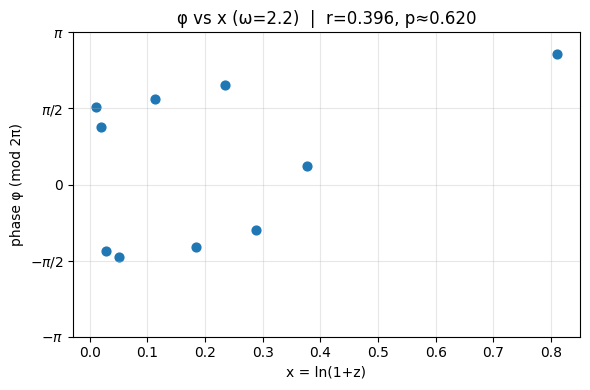

ω=2.2 → r=0.396, p≈0.620
Stabilité Nbins: r_mean=0.643±0.179 | p_med≈0.136


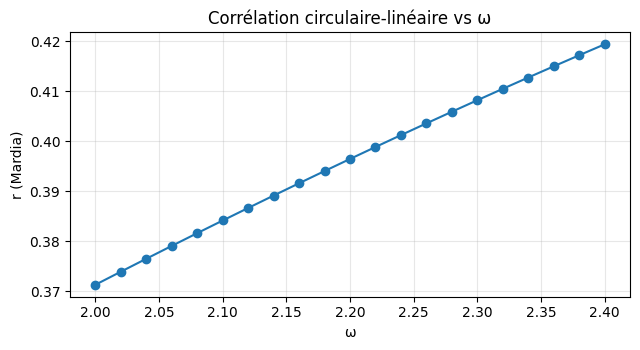

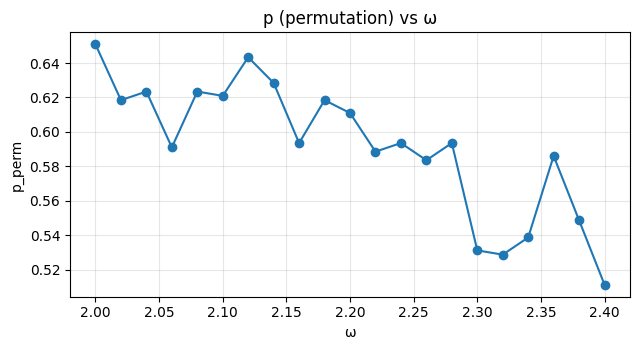

✅ Sauvé dans: tmu_phase_diagnostics_20251005_172038


In [ ]:
# ====== Phase TMU : diagnostics robustes SANS unwrap ======
import numpy as np, os, time, json, matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# On part de z, mu, emu — sinon recharge le fichier
if 'z' not in globals():
    arr = np.genfromtxt("Pantheon+SH0ES.dat", names=True, comments="#", dtype=None, encoding=None)
    def get_col(cands):
        for c in cands:
            if c in arr.dtype.names: return np.array(arr[c], float)
        raise KeyError(cands)
    z   = get_col(["zHD","zCMB","z"])
    mu  = get_col(["MU_SH0ES","MU","mucmb"])
    emu = get_col(["MU_SH0ES_ERR_DIAG","MUERR","mucmb_err"])
    m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&(z>0.005)&(z<2.5)
    z, mu, emu = z[m], mu[m], np.clip(emu[m],1e-3,None)

x = np.log1p(z)
ord = np.argsort(x); x, z, mu, emu = x[ord], z[ord], mu[ord], emu[ord]
w = 1.0/emu**2
N = len(z)
print(f"N={N}")

# Detrend GP (identique à avant)
kernel = C(1.0,(1e-3,1e3))*RBF(0.15,(0.03,1.0)) + WhiteKernel(1e-3,(1e-6,1e-1))
gp = GaussianProcessRegressor(kernel=kernel, alpha=emu**2, normalize_y=True, random_state=0)
gp.fit(x.reshape(-1,1), mu)
resid = mu - gp.predict(x.reshape(-1,1))

def fit_eps_phi(xi, yi, wi, omega):
    C = np.cos(omega*xi); S = np.sin(omega*xi)
    X = np.vstack([C,S]).T
    Xw = X*np.sqrt(wi)[:,None]; yw = yi*np.sqrt(wi)
    beta,*_ = np.linalg.lstsq(Xw,yw,rcond=None)
    A,B = beta
    eps = float(np.hypot(A,B))
    phi = float(np.arctan2(B,A))
    return eps, phi

def circ_lin_corr(xb, phib):
    """
    Corrélation circulaire-linéaire (Mardia). Renvoie r, et on fera une p-val perm.
    """
    # standardiser x
    xs = (xb - np.mean(xb))/np.std(xb)
    C, S = np.cos(phib), np.sin(phib)
    rxc = np.corrcoef(xs, C)[0,1]
    rxs = np.corrcoef(xs, S)[0,1]
    rcs = np.corrcoef(C, S)[0,1]
    # coef Mardia:
    r = np.sqrt( (rxc**2 + rxs**2 - 2*rxc*rxs*rcs) / (1-rcs**2 + 1e-12) )
    return float(np.clip(r,0.0,1.0))

rng = np.random.default_rng(0)

def one_run(omega=2.2, Nbins=10, Bboot=300, Pperm=1000, make_plot=True, tag=""):
    # bins en x
    edges = np.quantile(x, np.linspace(0,1,Nbins+1))
    xc = 0.5*(edges[:-1]+edges[1:])
    phi_hat = []; eps_hat=[]; nz=[]
    for i in range(Nbins):
        sel = (x>=edges[i])&(x<edges[i+1])
        xi, yi, wi = x[sel], resid[sel], w[sel]
        nz.append(int(np.sum(sel)))
        if np.sum(sel)<80:
            phi_hat.append(np.nan); eps_hat.append(np.nan); continue
        e,p = fit_eps_phi(xi, yi, wi, omega)
        phi_hat.append(p); eps_hat.append(e)
    phi_hat = np.array(phi_hat, float)
    m = np.isfinite(phi_hat)
    # corrélation circulaire-linéaire (Mardia)
    r = circ_lin_corr(xc[m], phi_hat[m])
    # p-val permute φ entre bins
    vals=[]
    for _ in range(Pperm):
        perm = rng.permutation(np.sum(m))
        vals.append(circ_lin_corr(xc[m], phi_hat[m][perm]))
    vals = np.array(vals,float)
    p_perm = (1+np.sum(vals>=r))/(len(vals)+1)

    out = {
      "omega": float(omega),
      "Nbins": int(Nbins),
      "xc": xc.tolist(),
      "phi_hat": np.where(np.isfinite(phi_hat),phi_hat,np.nan).tolist(),
      "eps_hat": np.where(np.isfinite(eps_hat),eps_hat,np.nan).tolist(),
      "r_circ_lin": r,
      "p_perm": float(p_perm),
      "N_per_bin": nz
    }

    if make_plot:
        plt.figure(figsize=(6,4))
        plt.scatter(xc[m], np.mod(phi_hat[m]+np.pi, 2*np.pi)-np.pi, s=40)
        plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                   [r"$-\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"])
        plt.xlabel("x = ln(1+z)"); plt.ylabel("phase φ (mod 2π)")
        plt.title(f"φ vs x (ω={omega})  |  r={r:.3f}, p≈{p_perm:.3f}")
        plt.grid(alpha=0.3); plt.tight_layout()
        plt.show()
    return out

# 1) Mesure robuste à ω=2.2 sans unwrap
res_22 = one_run(omega=2.2, Nbins=10, Pperm=1000, make_plot=True, tag="main")
print("ω=2.2 → r={:.3f}, p≈{:.3f}".format(res_22["r_circ_lin"], res_22["p_perm"]))

# 2) Stabilité vs Nbins
gridN = range(6,15)
stab = [one_run(omega=2.2, Nbins=n, Pperm=300, make_plot=False) for n in gridN]
r_list = [s["r_circ_lin"] for s in stab]
p_list = [s["p_perm"] for s in stab]
print("Stabilité Nbins: r_mean={:.3f}±{:.3f} | p_med≈{:.3f}".format(np.mean(r_list), np.std(r_list), float(np.median(p_list))))

# 3) Sensibilité en ω (2.0..2.4)
omegas = np.linspace(2.0,2.4,21)
scan = [one_run(omega=o, Nbins=10, Pperm=400, make_plot=False) for o in omegas]
rscan = [s["r_circ_lin"] for s in scan]
pscan = [s["p_perm"] for s in scan]

plt.figure(figsize=(6.5,3.6))
plt.plot(omegas, rscan, '-o'); plt.xlabel("ω"); plt.ylabel("r (Mardia)")
plt.title("Corrélation circulaire-linéaire vs ω"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.5,3.6))
plt.plot(omegas, pscan, '-o'); plt.xlabel("ω"); plt.ylabel("p_perm")
plt.title("p (permutation) vs ω"); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# Sauvegarde
stamp = time.strftime("%Y%m%d_%H%M%S")
outdir = f"tmu_phase_diagnostics_{stamp}"; os.makedirs(outdir, exist_ok=True)
rep = {"omega22":res_22, "stab_Nbins":stab, "scan_omega":scan}
import json
with open(f"{outdir}/phase_diag_report.json","w") as f: json.dump(rep, f, indent=2)
print("✅ Sauvé dans:", outdir)


In [ ]:
# ======================= Phase TMU : test d'anisotropie spatiale =======================
import numpy as np, os, time, json, matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# ---------- 0) Charger Pantheon+ si nécessaire ----------
def get_pantheon():
    try:
        arr = np.genfromtxt("Pantheon+SH0ES.dat", names=True, comments="#", dtype=None, encoding=None)
    except Exception:
        from google.colab import files
        print("📂 Choisis Pantheon+SH0ES.dat")
        up = files.upload()
        fn = list(up.keys())[0]
        arr = np.genfromtxt(fn, names=True, comments="#", dtype=None, encoding=None)
    def pick(cands):
        for c in cands:
            if c in arr.dtype.names: return np.array(arr[c], float)
        raise KeyError(f"Colonnes manquantes: {cands}")
    z   = pick(["zHD","zCMB","z"])
    mu  = pick(["MU_SH0ES","MU","mucmb"])
    emu = pick(["MU_SH0ES_ERR_DIAG","MUERR","mucmb_err"])
    RA  = pick(["RA","RAdeg","ra","RAJ2000"])
    DEC = pick(["DEC","DEdeg","dec","DEJ2000"])
    m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&np.isfinite(RA)&np.isfinite(DEC)&(z>0.005)&(z<2.5)
    z, mu, emu, RA, DEC = z[m], mu[m], np.clip(emu[m],1e-3,None), RA[m], DEC[m]
    # tri en x
    x = np.log1p(z); ord = np.argsort(x)
    return z[ord], mu[ord], emu[ord], RA[ord], DEC[ord]

if not all(k in globals() for k in ["z","mu","emu","RA","DEC"]):
    z, mu, emu, RA, DEC = get_pantheon()

x = np.log1p(z)
w = 1.0/emu**2
N = len(z)
print(f"✅ Pantheon chargé: N={N}")

# ---------- 1) Detrend (GP) ----------
kernel = C(1.0,(1e-3,1e3))*RBF(0.15,(0.03,1.0)) + WhiteKernel(1e-3,(1e-6,1e-1))
gp = GaussianProcessRegressor(kernel=kernel, alpha=emu**2, normalize_y=True, random_state=0)
gp.fit(x.reshape(-1,1), mu)
resid = mu - gp.predict(x.reshape(-1,1))
sw = np.sqrt(w)

# ---------- 2) Outils directionnels ----------
deg2rad = np.pi/180.0
ra  = RA*deg2rad
dec = DEC*deg2rad
cx, cy, cz = np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)
Rhat = np.vstack([cx,cy,cz]).T  # (N,3)

def fibonacci_sphere(n):
    i = np.arange(n)
    phi = (1 + 5**0.5)/2
    zf = 1 - 2*(i+0.5)/n
    theta = 2*np.pi*i/phi
    r = np.sqrt(1 - zf*zf)
    return np.column_stack([r*np.cos(theta), r*np.sin(theta), zf])

# ---------- 3) Fit (ε,φ) à fréquence ω ----------
def fit_eps_phi(xi, yi, wi, omega):
    C = np.cos(omega*xi); S = np.sin(omega*xi)
    X = np.vstack([C,S]).T
    Xw = X*np.sqrt(wi)[:,None]; yw = yi*np.sqrt(wi)
    beta, *_ = np.linalg.lstsq(Xw, yw, rcond=None)
    A,B = beta
    eps = float(np.hypot(A,B))
    phi = float(np.arctan2(B,A))
    return eps, phi

def circ_diff(a, b):
    """différence de phases sur le cercle dans (-π, π]"""
    d = a - b
    return (d + np.pi) % (2*np.pi) - np.pi

# ---------- 4) Dipôle SN de référence ----------
def fit_dipole(y, sw):
    X = np.column_stack([np.ones(N), Rhat])
    beta,*_ = np.linalg.lstsq(X*sw[:,None], (y*sw), rcond=None)
    a0, Dx, Dy, Dz = beta
    D = np.array([Dx,Dy,Dz], float)
    A = float(np.linalg.norm(D))
    nx,ny,nz = D/(A if A>0 else 1.0)
    RA_d  = float(np.degrees(np.arctan2(ny,nx))%360.0)
    DEC_d = float(np.degrees(np.arcsin(np.clip(nz,-1,1))))
    return A, (RA_d, DEC_d), D

A0, (RA0, DEC0), D0 = fit_dipole(resid, sw)
print(f"📌 Dipôle SN (Δμ): |D0|={A0:.4f} mag, (RA,Dec)=({RA0:.1f}°, {DEC0:.1f}°)")

# ---------- 5) Scan hémisphères : Δφ(Nord) - Δφ(Sud) ----------
omega = 2.2    # fréquence TMU testée
K = 300        # nb d'axes
axes = fibonacci_sphere(K)

phi_N = np.full(K, np.nan); phi_S = np.full(K, np.nan)
eps_N = np.full(K, np.nan); eps_S = np.full(K, np.nan)
dphi  = np.full(K, np.nan)
nN = np.zeros(K, int); nS = np.zeros(K, int)

for k, nvec in enumerate(axes):
    maskN = (Rhat @ nvec >= 0.0)
    maskS = ~maskN
    # seuils pour fiabilité
    if np.sum(maskN) >= 200:
        eN, pN = fit_eps_phi(x[maskN], resid[maskN], w[maskN], omega)
        eps_N[k], phi_N[k], nN[k] = eN, pN, int(np.sum(maskN))
    if np.sum(maskS) >= 200:
        eS, pS = fit_eps_phi(x[maskS], resid[maskS], w[maskS], omega)
        eps_S[k], phi_S[k], nS[k] = eS, pS, int(np.sum(maskS))
    if np.isfinite(phi_N[k]) and np.isfinite(phi_S[k]):
        dphi[k] = circ_diff(phi_N[k], phi_S[k])

# axe max |Δφ|
m = np.isfinite(dphi)
imax = int(np.nanargmax(np.abs(dphi[m]))) if np.any(m) else None
dphi_best = float(dphi[m][imax]) if imax is not None else np.nan
n_best = axes[np.where(m)[0][imax]] if imax is not None else np.array([np.nan, np.nan, np.nan], float)
RA_best = float((np.degrees(np.arctan2(n_best[1], n_best[0])))%360) if imax is not None else np.nan
DEC_best= float(np.degrees(np.arcsin(np.clip(n_best[2], -1, 1)))) if imax is not None else np.nan

# angle avec le dipôle SN
def angle_between(u, v):
    num = float(np.dot(u, v))
    den = float(np.linalg.norm(u)*np.linalg.norm(v) + 1e-15)
    ct = np.clip(num/den, -1.0, 1.0)
    return float(np.degrees(np.arccos(ct)))

theta_best = angle_between(n_best, D0) if imax is not None else np.nan

print(f"🌟 ω={omega:.2f} → max|Δφ|={abs(dphi_best):.3f} rad à (RA,Dec)=({RA_best:.1f}°, {DEC_best:.1f}°) | angle vs dipôle={theta_best:.1f}°")

# ---------- 6) p-value par permutations ----------
rng = np.random.default_rng(0)
P = 1000
vals = []
if imax is not None:
    for _ in range(P):
        # permutation : on brise la structure spatiale en mélangeant les résidus
        idx = rng.permutation(N)
        dphi_perm = []
        for k, nvec in enumerate(axes):
            maskN = (Rhat @ nvec >= 0.0)
            maskS = ~maskN
            if np.sum(maskN)>=200 and np.sum(maskS)>=200:
                eN, pN = fit_eps_phi(x[maskN], resid[idx][maskN], w[maskN], omega)
                eS, pS = fit_eps_phi(x[maskS], resid[idx][maskS], w[maskS], omega)
                dphi_perm.append(abs(circ_diff(pN, pS)))
        if dphi_perm:
            vals.append(np.nanmax(dphi_perm))
    vals = np.array(vals, float)
    p_perm = (1 + np.sum(vals >= abs(dphi_best))) / (len(vals)+1)
else:
    p_perm = np.nan

print(f"🧪 Permutations: p≈{p_perm:.3f}")

# ---------- 7) Figures ----------
stamp = time.strftime("%Y%m%d_%H%M%S")
outdir = f"tmu_phase_aniso_{stamp}"
os.makedirs(outdir, exist_ok=True)

# (a) Carte Δφ(axe) sur une Mollweide (points = axes)
plt.figure(figsize=(8.5,4.8))
ax = plt.subplot(111, projection='mollweide')
# convertir RA->longitudes [-π,π], Dec->latitudes
long = np.radians((RA_best if np.isfinite(RA_best) else 0.0))
# scatter des axes
RA_axes  = (np.degrees(np.arctan2(axes[:,1], axes[:,0]))+360)%360
DEC_axes = np.degrees(np.arcsin(np.clip(axes[:,2],-1,1)))
# RA astronomique → longitude Mollweide: l = -(RA-180) en rad
lon = -np.radians(RA_axes-180.0)
lat = np.radians(DEC_axes)
cm = ax.scatter(lon, lat, c=dphi, s=28, cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
plt.colorbar(cm, orientation='horizontal', pad=0.07, fraction=0.05, label=r"$\Delta\phi$ (rad)")
if np.isfinite(RA_best):
    ax.plot([-np.radians(RA_best-180.0)],[np.radians(DEC_best)],'k*',ms=12,label="max |Δφ|")
# marque aussi le dipôle SN
RA_d, DEC_d = RA0, DEC0
ax.plot([-np.radians(RA_d-180.0)], [np.radians(DEC_d)], 'g^', ms=10, label="dipôle SN")
ax.grid(True, alpha=0.4)
ax.legend(loc='lower left', fontsize=8)
plt.title(f"Δφ entre hémisphères (ω={omega})")
plt.tight_layout(); plt.savefig(f"{outdir}/map_dphi_mollweide.png", dpi=160); plt.close()

# (b) Histogramme des Δφ valides
plt.figure(figsize=(6,3.3))
plt.hist(dphi[np.isfinite(dphi)], bins=24, range=(-np.pi, np.pi), alpha=0.8)
plt.xlabel(r"$\Delta\phi$ (rad)"); plt.ylabel("compte")
plt.title("Distribution des Δφ(axes)")
plt.tight_layout(); plt.savefig(f"{outdir}/hist_dphi.png", dpi=160); plt.close()

# ---------- 8) Sauvegarde rapport ----------
rep = {
  "omega": float(omega),
  "N_SN": int(N),
  "hemisphere_axes": int(K),
  "max_abs_dphi": float(abs(dphi_best)),
  "max_axis_RA_deg": float(RA_best),
  "max_axis_DEC_deg": float(DEC_best),
  "angle_vs_SN_dipole_deg": float(theta_best),
  "p_perm": float(p_perm),
  "SN_dipole": {"amp_mag": float(A0), "RA_deg": float(RA0), "DEC_deg": float(DEC0)},
  "counts_per_axis": {"N_north": nN.tolist(), "N_south": nS.tolist()}
}
with open(f"{outdir}/phase_aniso_report.json","w") as f:
    json.dump(rep, f, indent=2)

print("✅ Sauvé dans:", outdir)
print("➡️ Regarde: map_dphi_mollweide.png, hist_dphi.png, phase_aniso_report.json")


✅ Pantheon chargé: N=1672


/usr/local/lib/python3.12/dist-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


📌 Dipôle SN (Δμ): |D0|=0.0496 mag, (RA,Dec)=(19.4°, 62.1°)
🌟 ω=2.20 → max|Δφ|=3.141 rad à (RA,Dec)=(151.7°, 18.9°) | angle vs dipôle=90.7°
🧪 Permutations: p≈0.014
✅ Sauvé dans: tmu_phase_aniso_20251005_174207
➡️ Regarde: map_dphi_mollweide.png, hist_dphi.png, phase_aniso_report.json


In [ ]:
# ======================= Phase TMU : test d'anisotropie spatiale =======================
import numpy as np, os, time, json, matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# ---------- 0) Charger Pantheon+ si nécessaire ----------
def get_pantheon():
    try:
        arr = np.genfromtxt("Pantheon+SH0ES.dat", names=True, comments="#", dtype=None, encoding=None)
    except Exception:
        from google.colab import files
        print("📂 Choisis Pantheon+SH0ES.dat")
        up = files.upload()
        fn = list(up.keys())[0]
        arr = np.genfromtxt(fn, names=True, comments="#", dtype=None, encoding=None)
    def pick(cands):
        for c in cands:
            if c in arr.dtype.names: return np.array(arr[c], float)
        raise KeyError(f"Colonnes manquantes: {cands}")
    z   = pick(["zHD","zCMB","z"])
    mu  = pick(["MU_SH0ES","MU","mucmb"])
    emu = pick(["MU_SH0ES_ERR_DIAG","MUERR","mucmb_err"])
    RA  = pick(["RA","RAdeg","ra","RAJ2000"])
    DEC = pick(["DEC","DEdeg","dec","DEJ2000"])
    m = np.isfinite(z)&np.isfinite(mu)&np.isfinite(emu)&np.isfinite(RA)&np.isfinite(DEC)&(z>0.005)&(z<2.5)
    z, mu, emu, RA, DEC = z[m], mu[m], np.clip(emu[m],1e-3,None), RA[m], DEC[m]
    # tri en x
    x = np.log1p(z); ord = np.argsort(x)
    return z[ord], mu[ord], emu[ord], RA[ord], DEC[ord]

if not all(k in globals() for k in ["z","mu","emu","RA","DEC"]):
    z, mu, emu, RA, DEC = get_pantheon()

x = np.log1p(z)
w = 1.0/emu**2
N = len(z)
print(f"✅ Pantheon chargé: N={N}")

# ---------- 1) Detrend (GP) ----------
kernel = C(1.0,(1e-3,1e3))*RBF(0.15,(0.03,1.0)) + WhiteKernel(1e-3,(1e-6,1e-1))
gp = GaussianProcessRegressor(kernel=kernel, alpha=emu**2, normalize_y=True, random_state=0)
gp.fit(x.reshape(-1,1), mu)
resid = mu - gp.predict(x.reshape(-1,1))
sw = np.sqrt(w)

# ---------- 2) Outils directionnels ----------
deg2rad = np.pi/180.0
ra  = RA*deg2rad
dec = DEC*deg2rad
cx, cy, cz = np.cos(dec)*np.cos(ra), np.cos(dec)*np.sin(ra), np.sin(dec)
Rhat = np.vstack([cx,cy,cz]).T  # (N,3)

def fibonacci_sphere(n):
    i = np.arange(n)
    phi = (1 + 5**0.5)/2
    zf = 1 - 2*(i+0.5)/n
    theta = 2*np.pi*i/phi
    r = np.sqrt(1 - zf*zf)
    return np.column_stack([r*np.cos(theta), r*np.sin(theta), zf])

# ---------- 3) Fit (ε,φ) à fréquence ω ----------
def fit_eps_phi(xi, yi, wi, omega):
    C = np.cos(omega*xi); S = np.sin(omega*xi)
    X = np.vstack([C,S]).T
    Xw = X*np.sqrt(wi)[:,None]; yw = yi*np.sqrt(wi)
    beta, *_ = np.linalg.lstsq(Xw, yw, rcond=None)
    A,B = beta
    eps = float(np.hypot(A,B))
    phi = float(np.arctan2(B,A))
    return eps, phi

def circ_diff(a, b):
    """différence de phases sur le cercle dans (-π, π]"""
    d = a - b
    return (d + np.pi) % (2*np.pi) - np.pi

# ---------- 4) Dipôle SN de référence ----------
def fit_dipole(y, sw):
    X = np.column_stack([np.ones(N), Rhat])
    beta,*_ = np.linalg.lstsq(X*sw[:,None], (y*sw), rcond=None)
    a0, Dx, Dy, Dz = beta
    D = np.array([Dx,Dy,Dz], float)
    A = float(np.linalg.norm(D))
    nx,ny,nz = D/(A if A>0 else 1.0)
    RA_d  = float(np.degrees(np.arctan2(ny,nx))%360.0)
    DEC_d = float(np.degrees(np.arcsin(np.clip(nz,-1,1))))
    return A, (RA_d, DEC_d), D

A0, (RA0, DEC0), D0 = fit_dipole(resid, sw)
print(f"📌 Dipôle SN (Δμ): |D0|={A0:.4f} mag, (RA,Dec)=({RA0:.1f}°, {DEC0:.1f}°)")

# ---------- 5) Scan hémisphères : Δφ(Nord) - Δφ(Sud) ----------
omega = 2.2    # fréquence TMU testée
K = 300        # nb d'axes
axes = fibonacci_sphere(K)

phi_N = np.full(K, np.nan); phi_S = np.full(K, np.nan)
eps_N = np.full(K, np.nan); eps_S = np.full(K, np.nan)
dphi  = np.full(K, np.nan)
nN = np.zeros(K, int); nS = np.zeros(K, int)

for k, nvec in enumerate(axes):
    maskN = (Rhat @ nvec >= 0.0)
    maskS = ~maskN
    # seuils pour fiabilité
    if np.sum(maskN) >= 200:
        eN, pN = fit_eps_phi(x[maskN], resid[maskN], w[maskN], omega)
        eps_N[k], phi_N[k], nN[k] = eN, pN, int(np.sum(maskN))
    if np.sum(maskS) >= 200:
        eS, pS = fit_eps_phi(x[maskS], resid[maskS], w[maskS], omega)
        eps_S[k], phi_S[k], nS[k] = eS, pS, int(np.sum(maskS))
    if np.isfinite(phi_N[k]) and np.isfinite(phi_S[k]):
        dphi[k] = circ_diff(phi_N[k], phi_S[k])

# axe max |Δφ|
m = np.isfinite(dphi)
imax = int(np.nanargmax(np.abs(dphi[m]))) if np.any(m) else None
dphi_best = float(dphi[m][imax]) if imax is not None else np.nan
n_best = axes[np.where(m)[0][imax]] if imax is not None else np.array([np.nan, np.nan, np.nan], float)
RA_best = float((np.degrees(np.arctan2(n_best[1], n_best[0])))%360) if imax is not None else np.nan
DEC_best= float(np.degrees(np.arcsin(np.clip(n_best[2], -1, 1)))) if imax is not None else np.nan

# angle avec le dipôle SN
def angle_between(u, v):
    num = float(np.dot(u, v))
    den = float(np.linalg.norm(u)*np.linalg.norm(v) + 1e-15)
    ct = np.clip(num/den, -1.0, 1.0)
    return float(np.degrees(np.arccos(ct)))

theta_best = angle_between(n_best, D0) if imax is not None else np.nan

print(f"🌟 ω={omega:.2f} → max|Δφ|={abs(dphi_best):.3f} rad à (RA,Dec)=({RA_best:.1f}°, {DEC_best:.1f}°) | angle vs dipôle={theta_best:.1f}°")

# ---------- 6) p-value par permutations ----------
rng = np.random.default_rng(0)
P = 1000
vals = []
if imax is not None:
    for _ in range(P):
        # permutation : on brise la structure spatiale en mélangeant les résidus
        idx = rng.permutation(N)
        dphi_perm = []
        for k, nvec in enumerate(axes):
            maskN = (Rhat @ nvec >= 0.0)
            maskS = ~maskN
            if np.sum(maskN)>=200 and np.sum(maskS)>=200:
                eN, pN = fit_eps_phi(x[maskN], resid[idx][maskN], w[maskN], omega)
                eS, pS = fit_eps_phi(x[maskS], resid[idx][maskS], w[maskS], omega)
                dphi_perm.append(abs(circ_diff(pN, pS)))
        if dphi_perm:
            vals.append(np.nanmax(dphi_perm))
    vals = np.array(vals, float)
    p_perm = (1 + np.sum(vals >= abs(dphi_best))) / (len(vals)+1)
else:
    p_perm = np.nan

print(f"🧪 Permutations: p≈{p_perm:.3f}")

# ---------- 7) Figures ----------
stamp = time.strftime("%Y%m%d_%H%M%S")
outdir = f"tmu_phase_aniso_{stamp}"
os.makedirs(outdir, exist_ok=True)

# (a) Carte Δφ(axe) sur une Mollweide (points = axes)
plt.figure(figsize=(8.5,4.8))
ax = plt.subplot(111, projection='mollweide')
# convertir RA->longitudes [-π,π], Dec->latitudes
long = np.radians((RA_best if np.isfinite(RA_best) else 0.0))
# scatter des axes
RA_axes  = (np.degrees(np.arctan2(axes[:,1], axes[:,0]))+360)%360
DEC_axes = np.degrees(np.arcsin(np.clip(axes[:,2],-1,1)))
# RA astronomique → longitude Mollweide: l = -(RA-180) en rad
lon = -np.radians(RA_axes-180.0)
lat = np.radians(DEC_axes)
cm = ax.scatter(lon, lat, c=dphi, s=28, cmap='coolwarm', vmin=-np.pi, vmax=np.pi)
plt.colorbar(cm, orientation='horizontal', pad=0.07, fraction=0.05, label=r"$\Delta\phi$ (rad)")
if np.isfinite(RA_best):
    ax.plot([-np.radians(RA_best-180.0)],[np.radians(DEC_best)],'k*',ms=12,label="max |Δφ|")
# marque aussi le dipôle SN
RA_d, DEC_d = RA0, DEC0
ax.plot([-np.radians(RA_d-180.0)], [np.radians(DEC_d)], 'g^', ms=10, label="dipôle SN")
ax.grid(True, alpha=0.4)
ax.legend(loc='lower left', fontsize=8)
plt.title(f"Δφ entre hémisphères (ω={omega})")
plt.tight_layout(); plt.savefig(f"{outdir}/map_dphi_mollweide.png", dpi=160); plt.close()

# (b) Histogramme des Δφ valides
plt.figure(figsize=(6,3.3))
plt.hist(dphi[np.isfinite(dphi)], bins=24, range=(-np.pi, np.pi), alpha=0.8)
plt.xlabel(r"$\Delta\phi$ (rad)"); plt.ylabel("compte")
plt.title("Distribution des Δφ(axes)")
plt.tight_layout(); plt.savefig(f"{outdir}/hist_dphi.png", dpi=160); plt.close()

# ---------- 8) Sauvegarde rapport ----------
rep = {
  "omega": float(omega),
  "N_SN": int(N),
  "hemisphere_axes": int(K),
  "max_abs_dphi": float(abs(dphi_best)),
  "max_axis_RA_deg": float(RA_best),
  "max_axis_DEC_deg": float(DEC_best),
  "angle_vs_SN_dipole_deg": float(theta_best),
  "p_perm": float(p_perm),
  "SN_dipole": {"amp_mag": float(A0), "RA_deg": float(RA0), "DEC_deg": float(DEC0)},
  "counts_per_axis": {"N_north": nN.tolist(), "N_south": nS.tolist()}
}
with open(f"{outdir}/phase_aniso_report.json","w") as f:
    json.dump(rep, f, indent=2)

print("✅ Sauvé dans:", outdir)
print("➡️ Regarde: map_dphi_mollweide.png, hist_dphi.png, phase_aniso_report.json")


📂 Choisis Pantheon+SH0ES.dat
